**Date: 24th Aug 2021** \
**Author: Osama Sidahmed**

On the previous notebook, some EDA was done, the data was preprocessed and some baseline modelling using Logistic regression and SVM was performed after which we made a quick comparison of the best estimators evaluation metrics. At the end of the notebook we saved our cleaned dataframes so that we use them on this notebook that we will use for doing some deeplearning modelling.

### Deeplearning modelling

#### Keras Dense Network

In this section we will attempt Dense networks to solve for our problem. First, a standard dense neural network will be fitted and evaluated and we will look at some visuals to aid us check for any signs for overfitting. This will help setup the best model on the Grid search later in terms of the model structure and the hyperparameters range.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import libraries
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier # for Keras NN gridsearchCV

In [37]:
# Global switches to control the folow of modelling and picking if the notebook has been rerun
run_model_1 = False
run_gs = False
run_model_2 = False

As we have done all the necessary pre-processing on the preceding notebook, we can just load the csv file we saved at the end of that notebook and use the data within on this notebook as mentioned earlier.

In [5]:
# Read csv file containing the database dataframes
df_train_lemma_sc = pd.read_csv('data/' + 'df_train_lemma_sc.csv')
df_test_lemma_sc = pd.read_csv('data/' + 'df_test_lemma_sc.csv')

In [7]:
df_train_lemma_sc.head(), df_test_lemma_sc.head()

(     id  target                              text_spacy_Lemmatized
 0  3296       0   the   sector have see a deluge of disruption ...
 1   258       0   nicki minaj single handedly annihilate the ma...
 2  4898       1   dmregister  rt tdavisdmr  a man be believe to...
 3  8980       0   I m scream bc the baby probably still see in ...
 4  7919       0   surprising oil tanker spill statistic publish...,
      id  target                              text_spacy_Lemmatized
 0  6211       0   when your dog  cat start pee on it  crap in t...
 1   589       1   after the attack  the soldier be surprised th...
 2  2741       0   do your research to find out if something lik...
 3  9614       0   the actual reason he wo nt have a problem be ...
 4  5108       0   hello  ph social medium  sorry for loudness  ...)

Now, we need to split X and y. Note that the data is already split into train and test set from the previous notebook, this will make it easier to compare with the baseline models.

In [8]:
# define our X_train and y_train
X_train = df_train_lemma_sc['text_spacy_Lemmatized'].fillna(' ')
y_train = df_train_lemma_sc['target']

In [9]:
# define our X_test and y_test
X_test = df_test_lemma_sc['text_spacy_Lemmatized'].fillna(' ')
y_test = df_test_lemma_sc['target']

In [10]:
# confirm the dataframes shapes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8512,), (2838,), (8512,), (2838,))

Now since this data is just cleaned data, we still need to create our features before modelling.

Before we do any modelling, we will prepare our train and test data for Keras networks, this include:
- Fitting and transforming our X data using the bag of words for our initial model

For now will not be splitting our train data to train/val sets but will rather use the Keras built-in `validation_split` param to split our validation data while modelling.

In [11]:
# sanity check -  our X_train data
X_train.head()

0     the   sector have see a deluge of disruption ...
1     nicki minaj single handedly annihilate the ma...
2     dmregister  rt tdavisdmr  a man be believe to...
3     I m scream bc the baby probably still see in ...
4     surprising oil tanker spill statistic publish...
Name: text_spacy_Lemmatized, dtype: object

In [12]:
# sanity check -  our y_train data
y_train.head()

0    0
1    0
2    1
3    0
4    0
Name: target, dtype: int64

In [13]:
# Fitting and transforming our X data using the bag of words for our initial model
transformer  = CountVectorizer(stop_words='english').fit(X_train)
X_train_transformed_dense = transformer.transform(X_train).todense()

In [14]:
# check the resulting densee martix
X_train_transformed_dense

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

The reason we transformed the matrix to dense is because of the large number of zero-valued elements on our matrix. As you can see below, we have more than 14,000 columns. We did some work in the previous models to reduce that but we will keep this as is for now as this is only an initial model. We have the opportunity to improve this later.

In [15]:
# the shape of the X data
X_train_transformed_dense.shape

(8512, 14061)

In [16]:
# ensuring that the data is string type
type(X_train.iloc[0])

str

In [17]:
y_train.shape

(8512,)

For the sake of modelling, we need to reshape the matrix so that it is compatible with Keras as following:

In [18]:
# reshape the target data matrix
y_train_reshaped  = y_train.values.reshape(-1,1)

In [127]:
y_train_reshaped

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

In [19]:
# and confirming the shape
y_train_reshaped.shape

(8512, 1)

In [20]:
# Random seed for reproducibility
seed = 1
np.random.seed(seed)

In [137]:
if run_model_1 == True:
    # Define the merics
    METRICS = [
          keras.metrics.TruePositives(name='tp'),
          keras.metrics.FalsePositives(name='fp'),
          keras.metrics.TrueNegatives(name='tn'),
          keras.metrics.FalseNegatives(name='fn'), 
          keras.metrics.BinaryAccuracy(name='accuracy'),
          keras.metrics.Precision(name='precision'),
          keras.metrics.Recall(name='recall'),
          keras.metrics.AUC(name='auc'),
    ]


    # create model
    model = keras.Sequential()
    model.add(layers.Dense(12, activation='relu'))
    model.add(layers.Dropout(0.25)) # Set 25% drop out
    # model.add(layers.Dense(6, activation='relu'))
    # model.add(layers.Dropout(0.25)) # Set 20% drop out

    # Declare the output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.00025), 
                  metrics = METRICS)

In [138]:
if run_model_1 == True:

    # Fit model
    history = model.fit(X_train_transformed_dense,
                        y_train_reshaped, epochs=15, verbose=1, validation_split=0.25)

Epoch 1/15
200/200 [==============================] - 3s 15ms/step - loss: 0.6448 - tp: 126.0000 - fp: 298.0000 - tn: 4877.0000 - fn: 1083.0000 - accuracy: 0.7837 - precision: 0.2972 - recall: 0.1042 - auc: 0.5934 - val_loss: 0.5862 - val_tp: 4.0000 - val_fp: 0.0000e+00 - val_tn: 1753.0000 - val_fn: 371.0000 - val_accuracy: 0.8257 - val_precision: 1.0000 - val_recall: 0.0107 - val_auc: 0.6991
Epoch 2/15
200/200 [==============================] - 2s 8ms/step - loss: 0.5359 - tp: 65.0000 - fp: 2.0000 - tn: 5173.0000 - fn: 1144.0000 - accuracy: 0.8205 - precision: 0.9701 - recall: 0.0538 - auc: 0.7612 - val_loss: 0.4957 - val_tp: 18.0000 - val_fp: 1.0000 - val_tn: 1752.0000 - val_fn: 357.0000 - val_accuracy: 0.8318 - val_precision: 0.9474 - val_recall: 0.0480 - val_auc: 0.7463
Epoch 3/15
200/200 [==============================] - 2s 8ms/step - loss: 0.4511 - tp: 160.0000 - fp: 2.0000 - tn: 5173.0000 - fn: 1049.0000 - accuracy: 0.8354 - precision: 0.9877 - recall: 0.1323 - auc: 0.8436 - va

We trained the model for 15 epochs, while monitoring our metrics, it is much easier, however if we can plot the history of epochs to understand the model performance.

In [139]:
if run_model_1 == True:
    
    # Evaluate the network
    train_accuracy = history.history['accuracy'][-1]
    result = model.evaluate(transformer.transform(X_test).todense()
                            ,y_test, verbose=0)

    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {result[5]:.4f}") 

    # Generate predictions
    predictions = model.predict(transformer.transform(X_test).todense())

Train Accuracy: 0.9585
Test Accuracy: 0.8774


Just looking at the train and test accuracy scores, it seems that there is a considerable overfitting in our network training. This can be explained by the cross in training and validation losses at the about the forth epoch, after which the validation loss rate of diminishing started to decrease compared to the training set. Looking at this plot alone, it can be said that we should have stopped our training at epoch 4. 

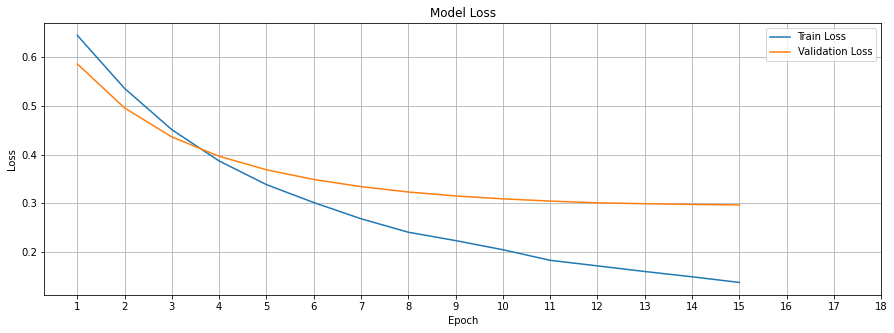

In [148]:
if run_model_1 == True:

    # Plot Train Loss and Validation Loss
    plt.figure(figsize=(15, 5))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train Loss', 'Validation Loss'])
    plt.grid()
    plt.xticks(np.arange(len(history.history)), np.arange(1, len(history.history)+1)) # to start the plot from 1

    plt.show()

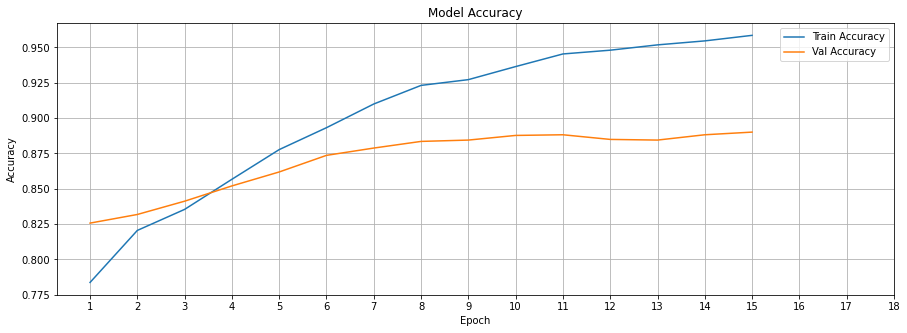

In [158]:
if run_model_1 == True:

    # Plot the train and val accuracy
    plt.figure(figsize=(15, 5))

    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])

    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train Accuracy', 'Val Accuracy'])
    plt.grid()
    plt.xticks(np.arange(len(history.history)), np.arange(1, len(history.history)+1)) # to start the plot from 1

    plt.show()

After plotting the accuracy scores, we see that there was some relative gain in the validation accuracy for another two epochs - until epoch 6 - with no much jump in the training set accuracy score.

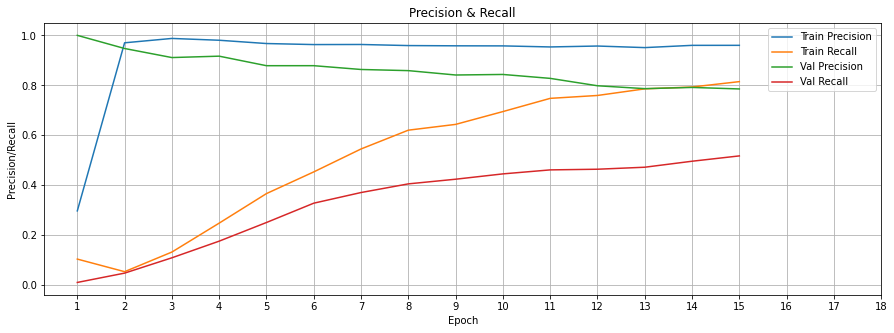

In [146]:
if run_model_1 == True:

    plt.figure(figsize=(15, 5))

    plt.plot(history.history['precision'])
    plt.plot(history.history['recall'])
    plt.plot(history.history['val_precision'])
    plt.plot(history.history['val_recall'])

    plt.title('Precision & Recall')
    plt.ylabel('Precision/Recall')
    plt.xlabel('Epoch')
    plt.legend(['Train Precision', 'Train Recall', 'Val Precision', 'Val Recall'])
    plt.grid()
    plt.xticks(np.arange(len(history.history)), np.arange(1, len(history.history)+1)) # to start the plot from 1

    plt.show()

Now plotting the precision and recall scores, has added another dimension to the decision criteria. Looking at the validation set lines and seeing them converge over time, we should ask ourselves an important question, do we care more about precision or recall?

In [143]:
if run_model_1 == True:

    # Evaluate the model using the test data and generate predictions
    # Evaluate the network
    train_accuracy = history.history["accuracy"][-1]
    result = model.evaluate(transformer.transform(X_test).todense(),
                            y_test, verbose=0)

    # loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc'
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {result[5]:.4f}")
    print(f"Test Precision: {result[6]:.4f}")
    print(f"Test Recall: {result[7]:.4f}")
    print(f"Test AUC: {result[8]:.4f}")
    print(f"Test TP: {result[1]:.0f}")
    print(f"Test FP: {result[2]:.0f}")
    print(f"Test TN: {result[3]:.0f}")
    print(f"Test FN: {result[4]:.0f}")

    predictions = model.predict(transformer.transform(X_test).todense())

Train Accuracy: 0.9585
Test Accuracy: 0.8774
Test Precision: 0.7586
Test Recall: 0.5000
Test AUC: 0.8724
Test TP: 264
Test FP: 84
Test TN: 2226
Test FN: 264


The previous question brings us to analyzing out confusion matrix and the model AUC, although the data is not imbalanced, it is worth looking into that and assess our model performance.

We will not be doing much of an analysis here as this is just an initial model, we will save out analysis until the end when we get some fine-tuned and optimized models and this what what will do next. It is worth reminding ourselves that although the model results are *looks* good or at least it can be further optimized, there is an opportunity to explore better models by trying different hyper parameters. This can be done by using Grid search and KerasClassifier wrapper as in the following code.

We will use a grid search employing the same SpaCy lemmatized data used on our machine learning models and we will loop through different:
- **Data:** We will only use SpaCy lemmatized data
- **Vectorizer type:** Count Vectorizer or TFIDF Vectorizer, each with stop words
- **Vectorizer hyper-parameters:** 
    - **ngram_range:** unigram or bigram
    - **min_df** 0.0005% or 0.001%
- **number of epochs**
- **number of neurons in the hidden layers** 
- **drop out rates (regularization)**
- **optimization functions**
- **optimizer learning_rate**

The Grid search will be fitting 3 folds for each of 512 candidates, totalling 1536 fits.

The following DenseTransformer() function is used as part of the pipeline to return a dense copy of the input.

In [493]:
class DenseTransformer():

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [494]:
from sklearn.pipeline import Pipeline

In [524]:
if run_gs == True:
    # function to return a compiled model as an input to our grid search
    def create_model(epochs, neurons_1, neurons_2, activation, rate, learning_rate):

        # Define the merics
        METRICS = [
              keras.metrics.TruePositives(name='tp'),
              keras.metrics.FalsePositives(name='fp'),
              keras.metrics.TrueNegatives(name='tn'),
              keras.metrics.FalseNegatives(name='fn'), 
              keras.metrics.BinaryAccuracy(name='accuracy'),
              keras.metrics.Precision(name='precision'),
              keras.metrics.Recall(name='recall'),
              keras.metrics.AUC(name='auc'),
        ]

        # create model
        model = keras.Sequential()
        model.add(layers.Dense(neurons_1, activation=activation))
        model.add(layers.Dropout(rate)) # Set X% drop out
        model.add(layers.Dense(neurons_2, activation=activation))
        model.add(layers.Dropout(rate)) # Set X% drop out

        # Declare the output layer
        model.add(layers.Dense(1, activation='sigmoid'))

        # Compile model
        model.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.Adam(learning_rate = learning_rate), 
                      metrics = METRICS)
        return model

And below is our grid seach:

In [528]:
if run_gs == True:
    
    # The hyperprameters list    
    ngram = [(1,1), (1,2)]
    mindf = [0.0005, 0.001]
    
    epochs = [15, 20]
    neurons_1 = [24, 12]
    neurons_2 = [12, 6]
    activation = ['relu', 'tanh']
    dropout_rate = [0.3, 0.4]
    learning_rate = [0.0001, 0.00025]

    # KerasClassifier is required to facilitate the Keras netork wrapping into the grid search
    model = KerasClassifier(build_fn=create_model)

    estimator = Pipeline([('vec_pipe', CountVectorizer(stop_words='english')), # Vectorize the data first
                         ('to_dense', DenseTransformer()), # convert data to Dense
                        ('model', model)
                        ])
    # different parameters
    param_grid = dict(vec_pipe= [CountVectorizer(stop_words='english'), TfidfVectorizer(stop_words='english')],
                                  vec_pipe__ngram_range = ngram,
                                  vec_pipe__min_df = mindf,
                                  model__epochs = epochs, 
                                  model__neurons_1 = neurons_1,
                                  model__neurons_2 = neurons_2,
                                  model__activation = activation,
                                  model__rate = dropout_rate,
                                  model__learning_rate = learning_rate)

    if run_gs == True:
        # SpaCy lemmatized set
        clf_nn_lemma = GridSearchCV(estimator=estimator, param_grid=param_grid, verbose = 10, cv=3, return_train_score = True)
        clf_nn_lemma.fit(X_train, y_train_reshaped)

Fitting 3 folds for each of 512 candidates, totalling 1536 fits
[CV 1/3; 1/512] START model__activation=relu, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1)
Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6885 - tp: 483.0000 - fp: 1689.0000 - tn: 2906.0000 - fn: 596.0000 - accuracy: 0.5973 - precision: 0.2224 - recall: 0.4476 - auc: 0.5426
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6524 - tp: 103.0000 - fp: 179.0000 - tn: 4416.0000 - fn: 976.0000 - accuracy: 0.7964 - precision: 0.3652 - recall: 0.0955 - auc: 0.5564
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6049 - tp: 12.0000 - fp: 23.0000 - tn: 4572.0000 - fn: 1067.0000 - accuracy: 0.8079 - precision: 0.3429 - recall: 0.0111 - auc: 0.5986
Epoch 4/15
178/178 [==========================

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6849 - tp: 256.0000 - fp: 995.0000 - tn: 3615.0000 - fn: 809.0000 - accuracy: 0.6821 - precision: 0.2046 - recall: 0.2404 - auc: 0.5087
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6539 - tp: 18.0000 - fp: 26.0000 - tn: 4584.0000 - fn: 1047.0000 - accuracy: 0.8109 - precision: 0.4091 - recall: 0.0169 - auc: 0.5683- ETA: 0s - loss: 0.6669 - tp: 11.0000 - fp: 18.0000 - tn: 1576.0000 - fn: 379.0000 - accuracy: 0.7999 - precision: 0.3793 - recall: 0
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6071 - tp: 2.0000 - fp: 2.0000 - tn: 4608.0000 - fn: 1063.0000 - accuracy: 0.8123 - precision: 0.5000 - recall: 0.0019 - auc: 0.6246
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5549 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4609.0000 - fn: 1065.0000 - accuracy: 0.8122 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6606
Epoch 5/15
17

[CV 2/3; 2/512] START model__activation=relu, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2)
Epoch 1/15
178/178 [==============================] - 2s 11ms/step - loss: 0.6718 - tp: 182.0000 - fp: 722.0000 - tn: 3929.0000 - fn: 842.0000 - accuracy: 0.7244 - precision: 0.2013 - recall: 0.1777 - auc: 0.5046
Epoch 2/15
178/178 [==============================] - 2s 10ms/step - loss: 0.6173 - tp: 22.0000 - fp: 20.0000 - tn: 4631.0000 - fn: 1002.0000 - accuracy: 0.8199 - precision: 0.5238 - recall: 0.0215 - auc: 0.5876
Epoch 3/15
178/178 [==============================] - 1s 8ms/step - loss: 0.5471 - tp: 1.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1023.0000 - accuracy: 0.8197 - precision: 1.0000 - recall: 9.7656e-04 - auc: 0.6586
Epoch 4/15
178/178 [==============================] - 1s 7ms/step - loss: 0.4868 - tp: 1.0000 - fp: 0.00

178/178 [==============================] - 1s 5ms/step - loss: 0.3261 - tp: 262.0000 - fp: 14.0000 - tn: 4637.0000 - fn: 762.0000 - accuracy: 0.8633 - precision: 0.9493 - recall: 0.2559 - auc: 0.8842 0s - loss: 0.3244 - tp: 173.0000 - fp: 9.0000 - tn: 3302.0000 - fn: 548.0000 - accuracy: 0.8619 - precision: 0.9505 - recall: 0.2399 - auc:
Epoch 15/15
178/178 [==============================] - 0s 3ms/step - loss: 0.2760 - tp: 415.0000 - fp: 22.0000 - tn: 4629.0000 - fn: 609.0000 - accuracy: 0.8888 - precision: 0.9497 - recall: 0.4053 - auc: 0.9418
[CV 2/3; 3/512] END model__activation=relu, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1); total time=  20.3s
[CV 3/3; 3/512] START model__activation=relu, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.3, vec_pipe=CountVectorizer(

178/178 [==============================] - 1s 4ms/step - loss: 0.4365 - tp: 13.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1052.0000 - accuracy: 0.8146 - precision: 1.0000 - recall: 0.0122 - auc: 0.7535
Epoch 8/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4089 - tp: 28.0000 - fp: 2.0000 - tn: 4608.0000 - fn: 1037.0000 - accuracy: 0.8169 - precision: 0.9333 - recall: 0.0263 - auc: 0.8039
Epoch 9/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3978 - tp: 48.0000 - fp: 1.0000 - tn: 4609.0000 - fn: 1017.0000 - accuracy: 0.8206 - precision: 0.9796 - recall: 0.0451 - auc: 0.8151
Epoch 10/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3838 - tp: 89.0000 - fp: 4.0000 - tn: 4606.0000 - fn: 976.0000 - accuracy: 0.8273 - precision: 0.9570 - recall: 0.0836 - auc: 0.8325
Epoch 11/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3623 - tp: 147.0000 - fp: 6.0000 - tn: 4604.0000 - fn: 918.0000 - accuracy: 0.8372 - preci

178/178 [==============================] - 1s 7ms/step - loss: 0.6874 - tp: 302.0000 - fp: 1308.0000 - tn: 3287.0000 - fn: 777.0000 - accuracy: 0.6325 - precision: 0.1876 - recall: 0.2799 - auc: 0.4898
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.6564 - tp: 4.0000 - fp: 7.0000 - tn: 4588.0000 - fn: 1075.0000 - accuracy: 0.8093 - precision: 0.3636 - recall: 0.0037 - auc: 0.5498
Epoch 3/15
178/178 [==============================] - 1s 6ms/step - loss: 0.6238 - tp: 0.0000e+00 - fp: 2.0000 - tn: 4593.0000 - fn: 1079.0000 - accuracy: 0.8095 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5395
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5882 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5533
Epoch 5/15
178/178 [==============================] - 1s 8ms/step - loss: 0.5498 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0

178/178 [==============================] - 1s 4ms/step - loss: 0.4165 - tp: 3.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1076.0000 - accuracy: 0.8104 - precision: 1.0000 - recall: 0.0028 - auc: 0.7955 
Epoch 13/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4058 - tp: 22.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1057.0000 - accuracy: 0.8137 - precision: 1.0000 - recall: 0.0204 - auc: 0.8104
Epoch 14/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3924 - tp: 52.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 1027.0000 - accuracy: 0.8188 - precision: 0.9811 - recall: 0.0482 - auc: 0.8331
Epoch 15/15
178/178 [==============================] - 0s 3ms/step - loss: 0.3504 - tp: 120.0000 - fp: 2.0000 - tn: 4593.0000 - fn: 959.0000 - accuracy: 0.8306 - precision: 0.9836 - recall: 0.1112 - auc: 0.9267
[CV 1/3; 7/512] END model__activation=relu, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.3, vec_pipe=T

178/178 [==============================] - 1s 4ms/step - loss: 0.4385 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7133 0s - loss: 0.4371 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2921.0000 - fn: 631.0000 - accuracy: 0.8224 - precision: 0.0000e+00 - recall: 0.0000e+00 -
Epoch 8/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4255 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7497
Epoch 9/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4135 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7787
Epoch 10/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4043 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e

[CV 3/3; 9/512] START model__activation=relu, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1)
Epoch 1/15
178/178 [==============================] - 1s 6ms/step - loss: 0.6655 - tp: 155.0000 - fp: 676.0000 - tn: 3934.0000 - fn: 910.0000 - accuracy: 0.7205 - precision: 0.1865 - recall: 0.1455 - auc: 0.4799     - ETA: 0s - loss: 0.6790 - tp: 55.0000 - fp: 237.0000 - tn: 598.0000 - fn: 134.0000 - accuracy: 0.6377 - precision: 0.188
Epoch 2/15
178/178 [==============================] - 2s 10ms/step - loss: 0.6185 - tp: 21.0000 - fp: 65.0000 - tn: 4545.0000 - fn: 1044.0000 - accuracy: 0.8046 - precision: 0.2442 - recall: 0.0197 - auc: 0.5448
Epoch 3/15
178/178 [==============================] - 2s 12ms/step - loss: 0.5673 - tp: 3.0000 - fp: 9.0000 - tn: 4601.0000 - fn: 1062.0000 - accuracy: 0.8113 - precision: 0.2500 - recall: 0.0028 

178/178 [==============================] - 1s 7ms/step - loss: 0.3250 - tp: 197.0000 - fp: 5.0000 - tn: 4605.0000 - fn: 868.0000 - accuracy: 0.8462 - precision: 0.9752 - recall: 0.1850 - auc: 0.9037
Epoch 14/15
178/178 [==============================] - 1s 8ms/step - loss: 0.3098 - tp: 222.0000 - fp: 3.0000 - tn: 4607.0000 - fn: 843.0000 - accuracy: 0.8509 - precision: 0.9867 - recall: 0.2085 - auc: 0.9192
Epoch 15/15
178/178 [==============================] - 1s 6ms/step - loss: 0.2575 - tp: 442.0000 - fp: 8.0000 - tn: 4602.0000 - fn: 623.0000 - accuracy: 0.8888 - precision: 0.9822 - recall: 0.4150 - auc: 0.9666
[CV 3/3; 10/512] END model__activation=relu, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2); total time=  30.9s
[CV 1/3; 11/512] START model__activation=relu, model__epochs=15, model__learning_rate=0.0001, model__neuro

178/178 [==============================] - 1s 4ms/step - loss: 0.4890 - tp: 5.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 1074.0000 - accuracy: 0.8105 - precision: 0.8333 - recall: 0.0046 - auc: 0.6569
Epoch 6/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4658 - tp: 9.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 1070.0000 - accuracy: 0.8112 - precision: 0.9000 - recall: 0.0083 - auc: 0.6806
Epoch 7/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4448 - tp: 17.0000 - fp: 2.0000 - tn: 4593.0000 - fn: 1062.0000 - accuracy: 0.8125 - precision: 0.8947 - recall: 0.0158 - auc: 0.7276
Epoch 8/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4289 - tp: 24.0000 - fp: 4.0000 - tn: 4591.0000 - fn: 1055.0000 - accuracy: 0.8134 - precision: 0.8571 - recall: 0.0222 - auc: 0.7560
Epoch 9/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4153 - tp: 48.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 1031.0000 - accuracy: 0.8181 - precision: 0

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6794 - tp: 49.0000 - fp: 300.0000 - tn: 4351.0000 - fn: 975.0000 - accuracy: 0.7753 - precision: 0.1404 - recall: 0.0479 - auc: 0.4966
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6444 - tp: 1.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1023.0000 - accuracy: 0.8197 - precision: 1.0000 - recall: 9.7656e-04 - auc: 0.5189
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5952 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5639 0s - loss: 0.6053 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2762.0000 - fn: 598.0000 - accuracy: 0.8220 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5471 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 

178/178 [==============================] - 1s 5ms/step - loss: 0.4035 - tp: 8.0000 - fp: 1.0000 - tn: 4650.0000 - fn: 1016.0000 - accuracy: 0.8208 - precision: 0.8889 - recall: 0.0078 - auc: 0.7905
Epoch 14/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3908 - tp: 23.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1001.0000 - accuracy: 0.8236 - precision: 1.0000 - recall: 0.0225 - auc: 0.8133TA: 0s - loss: 0.3962 - tp: 19.0000 - fp: 0.0000e+00 - tn: 3005.0000 - fn: 656.0000 - accuracy: 0.8217 - precision: 1.0000 - recall: 0.0281 - auc:
Epoch 15/15
178/178 [==============================] - 1s 3ms/step - loss: 0.3385 - tp: 47.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 977.0000 - accuracy: 0.8278 - precision: 1.0000 - recall: 0.0459 - auc: 0.9507
[CV 2/3; 14/512] END model__activation=relu, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec

178/178 [==============================] - 1s 3ms/step - loss: 0.5608 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4609.0000 - fn: 1065.0000 - accuracy: 0.8122 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5668
Epoch 6/15
178/178 [==============================] - 1s 3ms/step - loss: 0.5296 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5813
Epoch 7/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5026 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4609.0000 - fn: 1065.0000 - accuracy: 0.8122 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6104
Epoch 8/15
178/178 [==============================] - 1s 3ms/step - loss: 0.4834 - tp: 1.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1064.0000 - accuracy: 0.8125 - precision: 1.0000 - recall: 9.3897e-04 - auc: 0.6377
Epoch 9/15
178/178 [==============================] - 1s 3ms/step - loss: 0.4731 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4609.0000 

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6827 - tp: 362.0000 - fp: 1246.0000 - tn: 3349.0000 - fn: 717.0000 - accuracy: 0.6540 - precision: 0.2251 - recall: 0.3355 - auc: 0.5416
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6501 - tp: 112.0000 - fp: 159.0000 - tn: 4436.0000 - fn: 967.0000 - accuracy: 0.8016 - precision: 0.4133 - recall: 0.1038 - auc: 0.5682
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6100 - tp: 40.0000 - fp: 29.0000 - tn: 4566.0000 - fn: 1039.0000 - accuracy: 0.8118 - precision: 0.5797 - recall: 0.0371 - auc: 0.6057
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5673 - tp: 22.0000 - fp: 12.0000 - tn: 4583.0000 - fn: 1057.0000 - accuracy: 0.8116 - precision: 0.6471 - recall: 0.0204 - auc: 0.6230
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5290 - tp: 20.0000 - fp: 6.0000 - tn: 4589.0000 - fn: 1059.0000 - accuracy: 0

178/178 [==============================] - 1s 5ms/step - loss: 0.3927 - tp: 194.0000 - fp: 12.0000 - tn: 4583.0000 - fn: 885.0000 - accuracy: 0.8419 - precision: 0.9417 - recall: 0.1798 - auc: 0.8295
Epoch 10/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3666 - tp: 270.0000 - fp: 14.0000 - tn: 4581.0000 - fn: 809.0000 - accuracy: 0.8550 - precision: 0.9507 - recall: 0.2502 - auc: 0.8583
Epoch 11/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3465 - tp: 348.0000 - fp: 22.0000 - tn: 4573.0000 - fn: 731.0000 - accuracy: 0.8673 - precision: 0.9405 - recall: 0.3225 - auc: 0.8749
Epoch 12/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3269 - tp: 404.0000 - fp: 35.0000 - tn: 4560.0000 - fn: 675.0000 - accuracy: 0.8749 - precision: 0.9203 - recall: 0.3744 - auc: 0.8936
Epoch 13/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3087 - tp: 477.0000 - fp: 37.0000 - tn: 4558.0000 - fn: 602.0000 - accuracy: 0.8874 - p

178/178 [==============================] - 1s 3ms/step - loss: 0.3283 - tp: 331.0000 - fp: 11.0000 - tn: 4584.0000 - fn: 748.0000 - accuracy: 0.8662 - precision: 0.9678 - recall: 0.3068 - auc: 0.9282
[CV 1/3; 19/512] END model__activation=relu, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=6, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1); total time=  16.5s
[CV 2/3; 19/512] START model__activation=relu, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=6, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1)
Epoch 1/15
178/178 [==============================] - 1s 3ms/step - loss: 0.6892 - tp: 262.0000 - fp: 1103.0000 - tn: 3548.0000 - fn: 762.0000 - accuracy: 0.6714 - precision: 0.1919 - recall: 0.2559 - auc: 0.5218
Epoch 2/15
178/178 [==============================] - 0s 3ms/st

178/178 [==============================] - 1s 3ms/step - loss: 0.4664 - tp: 5.0000 - fp: 2.0000 - tn: 4649.0000 - fn: 1019.0000 - accuracy: 0.8201 - precision: 0.7143 - recall: 0.0049 - auc: 0.6963ETA: 0s - loss: 0.4660 - tp: 4.0000 - fp: 2.0000 - tn: 3894.0000 - fn: 836.0000 - accuracy: 0.8231 - precision: 0.6667 - recall: 0.0048 - auc: 0.69
Epoch 6/15
178/178 [==============================] - 1s 3ms/step - loss: 0.4493 - tp: 8.0000 - fp: 1.0000 - tn: 4650.0000 - fn: 1016.0000 - accuracy: 0.8208 - precision: 0.8889 - recall: 0.0078 - auc: 0.6996
Epoch 7/15
178/178 [==============================] - 1s 3ms/step - loss: 0.4245 - tp: 16.0000 - fp: 1.0000 - tn: 4650.0000 - fn: 1008.0000 - accuracy: 0.8222 - precision: 0.9412 - recall: 0.0156 - auc: 0.7516
Epoch 8/15
178/178 [==============================] - 1s 3ms/step - loss: 0.4073 - tp: 19.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1005.0000 - accuracy: 0.8229 - precision: 1.0000 - recall: 0.0186 - auc: 0.7781
Epoch 9/15
178/178 [==

[CV 1/3; 21/512] START model__activation=relu, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=6, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1)
Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6687 - tp: 22.0000 - fp: 108.0000 - tn: 4487.0000 - fn: 1057.0000 - accuracy: 0.7947 - precision: 0.1692 - recall: 0.0204 - auc: 0.5107
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6200 - tp: 0.0000e+00 - fp: 2.0000 - tn: 4593.0000 - fn: 1079.0000 - accuracy: 0.8095 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5513 0s - loss: 0.6229 - tp: 0.0000e+00 - fp: 2.0000 - tn: 4118.0000 - fn: 968.0000 - accuracy: 0.8094 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5643 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 

178/178 [==============================] - 1s 4ms/step - loss: 0.5160 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6274
Epoch 7/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4928 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6538
Epoch 8/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4751 - tp: 2.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1077.0000 - accuracy: 0.8102 - precision: 1.0000 - recall: 0.0019 - auc: 0.6727        
Epoch 9/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4644 - tp: 1.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1078.0000 - accuracy: 0.8100 - precision: 1.0000 - recall: 9.2678e-04 - auc: 0.6905
Epoch 10/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4489 - tp: 9.0000 - fp: 0.0000e+00 - tn: 4595.

178/178 [==============================] - 0s 3ms/step - loss: 0.3950 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9213
[CV 1/3; 23/512] END model__activation=relu, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=6, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1); total time=  13.5s
[CV 2/3; 23/512] START model__activation=relu, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=6, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1)
Epoch 1/15
178/178 [==============================] - 1s 3ms/step - loss: 0.6889 - tp: 330.0000 - fp: 1436.0000 - tn: 3215.0000 - fn: 694.0000 - accuracy: 0.6247 - precision: 0.1869 - recall: 0.3223 - auc: 0.5278
Epoch 2/15
178/178 [=============================

178/178 [==============================] - 1s 3ms/step - loss: 0.5144 - tp: 0.0000e+00 - fp: 3.0000 - tn: 4648.0000 - fn: 1024.0000 - accuracy: 0.8190 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5942 0s - loss: 0.5144 - tp: 0.0000e+00 - fp: 3.0000 - tn: 3787.0000 - fn: 818.0000 - accuracy: 0.8218 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.
Epoch 7/15
178/178 [==============================] - 1s 3ms/step - loss: 0.4884 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4650.0000 - fn: 1024.0000 - accuracy: 0.8194 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6279
Epoch 8/15
178/178 [==============================] - 1s 3ms/step - loss: 0.4752 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6359
Epoch 9/15
178/178 [==============================] - 1s 3ms/step - loss: 0.4656 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4650.0000 - fn: 1024.0000 - accuracy: 0.8194 - precision: 0.0000e+00 - rec

178/178 [==============================] - 1s 4ms/step - loss: 0.3569 - tp: 88.0000 - fp: 1.0000 - tn: 4650.0000 - fn: 936.0000 - accuracy: 0.8349 - precision: 0.9888 - recall: 0.0859 - auc: 0.9426
[CV 2/3; 25/512] END model__activation=relu, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1); total time=  15.1s
[CV 3/3; 25/512] START model__activation=relu, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1)
Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6979 - tp: 601.0000 - fp: 2366.0000 - tn: 2244.0000 - fn: 464.0000 - accuracy: 0.5013 - precision: 0.2026 - recall: 0.5643 - auc: 0.5324
Epoch 2/15
178/178 [==============================] - 1s 4ms/st

178/178 [==============================] - 1s 4ms/step - loss: 0.5562 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5898
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5124 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6424
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4783 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6848
Epoch 6/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4481 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7298s - loss: 0.4631 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 733.0000 - fn: 163.0000 - accuracy: 0.8181 - precision:

Epoch 1/15
178/178 [==============================] - 1s 3ms/step - loss: 0.7033 - tp: 596.0000 - fp: 2677.0000 - tn: 1974.0000 - fn: 428.0000 - accuracy: 0.4529 - precision: 0.1821 - recall: 0.5820 - auc: 0.5147A: 0s - loss: 0.7036 - tp: 591.0000 - fp: 2661.0000 - tn: 1930.0000 - fn: 418.0000 - accuracy: 0.4502 - precision: 0.1817 - recall: 0.5857 - auc: 0.514
Epoch 2/15
178/178 [==============================] - 1s 3ms/step - loss: 0.6852 - tp: 308.0000 - fp: 1025.0000 - tn: 3626.0000 - fn: 716.0000 - accuracy: 0.6932 - precision: 0.2311 - recall: 0.3008 - auc: 0.5507
Epoch 3/15
178/178 [==============================] - 1s 3ms/step - loss: 0.6691 - tp: 133.0000 - fp: 301.0000 - tn: 4350.0000 - fn: 891.0000 - accuracy: 0.7900 - precision: 0.3065 - recall: 0.1299 - auc: 0.5676
Epoch 4/15
178/178 [==============================] - 1s 3ms/step - loss: 0.6507 - tp: 69.0000 - fp: 87.0000 - tn: 4564.0000 - fn: 955.0000 - accuracy: 0.8164 - precision: 0.4423 - recall: 0.0674 - auc: 0.5703: 

178/178 [==============================] - 1s 3ms/step - loss: 0.4086 - tp: 6.0000 - fp: 1.0000 - tn: 4650.0000 - fn: 1018.0000 - accuracy: 0.8204 - precision: 0.8571 - recall: 0.0059 - auc: 0.7747
Epoch 11/15
178/178 [==============================] - 0s 3ms/step - loss: 0.3983 - tp: 6.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1018.0000 - accuracy: 0.8206 - precision: 1.0000 - recall: 0.0059 - auc: 0.7888
Epoch 12/15
178/178 [==============================] - 1s 3ms/step - loss: 0.3866 - tp: 14.0000 - fp: 2.0000 - tn: 4649.0000 - fn: 1010.0000 - accuracy: 0.8217 - precision: 0.8750 - recall: 0.0137 - auc: 0.8106
Epoch 13/15
178/178 [==============================] - 1s 3ms/step - loss: 0.3766 - tp: 17.0000 - fp: 3.0000 - tn: 4648.0000 - fn: 1007.0000 - accuracy: 0.8220 - precision: 0.8500 - recall: 0.0166 - auc: 0.8266
Epoch 14/15
178/178 [==============================] - 1s 3ms/step - loss: 0.3652 - tp: 32.0000 - fp: 2.0000 - tn: 4649.0000 - fn: 992.0000 - accuracy: 0.8248 - preci

[CV 3/3; 29/512] START model__activation=relu, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=6, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1)
Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6734 - tp: 59.0000 - fp: 275.0000 - tn: 4335.0000 - fn: 1006.0000 - accuracy: 0.7743 - precision: 0.1766 - recall: 0.0554 - auc: 0.4881
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6298 - tp: 3.0000 - fp: 14.0000 - tn: 4596.0000 - fn: 1062.0000 - accuracy: 0.8104 - precision: 0.1765 - recall: 0.0028 - auc: 0.5423
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5847 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4609.0000 - fn: 1065.0000 - accuracy: 0.8122 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5639
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5515 - tp: 0.0000e+00 - fp:

178/178 [==============================] - 1s 4ms/step - loss: 0.4408 - tp: 12.0000 - fp: 4.0000 - tn: 4606.0000 - fn: 1053.0000 - accuracy: 0.8137 - precision: 0.7500 - recall: 0.0113 - auc: 0.7278
Epoch 11/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4229 - tp: 33.0000 - fp: 5.0000 - tn: 4605.0000 - fn: 1032.0000 - accuracy: 0.8173 - precision: 0.8684 - recall: 0.0310 - auc: 0.7719
Epoch 12/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4061 - tp: 60.0000 - fp: 4.0000 - tn: 4606.0000 - fn: 1005.0000 - accuracy: 0.8222 - precision: 0.9375 - recall: 0.0563 - auc: 0.8021
Epoch 13/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3940 - tp: 107.0000 - fp: 5.0000 - tn: 4605.0000 - fn: 958.0000 - accuracy: 0.8303 - precision: 0.9554 - recall: 0.1005 - auc: 0.8209: 0s - loss: 0.3992 - tp: 81.0000 - fp: 4.0000 - tn: 3656.0000 - fn: 771.0000 - accuracy: 0.8282 - precision: 0.9529 - recall: 0.0951 - auc: 0
Epoch 14/15
178/178 [=====

178/178 [==============================] - 0s 3ms/step - loss: 0.6503 - tp: 8.0000 - fp: 26.0000 - tn: 4569.0000 - fn: 1071.0000 - accuracy: 0.8067 - precision: 0.2353 - recall: 0.0074 - auc: 0.5301
Epoch 4/15
178/178 [==============================] - 1s 3ms/step - loss: 0.6252 - tp: 5.0000 - fp: 12.0000 - tn: 4583.0000 - fn: 1074.0000 - accuracy: 0.8086 - precision: 0.2941 - recall: 0.0046 - auc: 0.5555
Epoch 5/15
178/178 [==============================] - 1s 3ms/step - loss: 0.6054 - tp: 1.0000 - fp: 10.0000 - tn: 4585.0000 - fn: 1078.0000 - accuracy: 0.8082 - precision: 0.0909 - recall: 9.2678e-04 - auc: 0.5520
Epoch 6/15
178/178 [==============================] - 1s 3ms/step - loss: 0.5874 - tp: 1.0000 - fp: 4.0000 - tn: 4591.0000 - fn: 1078.0000 - accuracy: 0.8093 - precision: 0.2000 - recall: 9.2678e-04 - auc: 0.5505  
Epoch 7/15
178/178 [==============================] - 1s 3ms/step - loss: 0.5670 - tp: 1.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1078.0000 - accuracy: 0.8100 

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6739 - tp: 106.0000 - fp: 423.0000 - tn: 4187.0000 - fn: 959.0000 - accuracy: 0.7565 - precision: 0.2004 - recall: 0.0995 - auc: 0.5077
Epoch 2/15
178/178 [==============================] - 1s 3ms/step - loss: 0.6346 - tp: 11.0000 - fp: 43.0000 - tn: 4567.0000 - fn: 1054.0000 - accuracy: 0.8067 - precision: 0.2037 - recall: 0.0103 - auc: 0.5361 - ETA: 0s - loss: 0.6499 - tp: 5.0000 - fp: 15.0000 - tn: 1026.0000 - fn: 234.0000 - accuracy: 0.8055 - precision: 0.2500 - recall: 0.0209 - auc: 0.542 - ETA: 0s - loss: 0.6496 - tp: 6.0000 - fp: 18.0000 - tn: 1456.0000 - fn: 344.0000 - accuracy: 0.8015 - precision: 0.2500 - recall: 0.0171
Epoch 3/15
178/178 [==============================] - 1s 3ms/step - loss: 0.5867 - tp: 4.0000 - fp: 17.0000 - tn: 4593.0000 - fn: 1061.0000 - accuracy: 0.8100 - precision: 0.1905 - recall: 0.0038 - auc: 0.5510
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.

178/178 [==============================] - 1s 4ms/step - loss: 0.4386 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7605
Epoch 9/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4216 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7878
Epoch 10/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4050 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8198
Epoch 11/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3890 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8418
Epoch 12/15
178/178 [==============================] - 1s 3ms/step - loss: 0.3754 - tp: 0.0000e+00 - fp: 0.00

Epoch 1/15
178/178 [==============================] - 0s 3ms/step - loss: 0.6839 - tp: 194.0000 - fp: 814.0000 - tn: 3781.0000 - fn: 885.0000 - accuracy: 0.7006 - precision: 0.1925 - recall: 0.1798 - auc: 0.4883
Epoch 2/15
178/178 [==============================] - 1s 3ms/step - loss: 0.6616 - tp: 31.0000 - fp: 51.0000 - tn: 4544.0000 - fn: 1048.0000 - accuracy: 0.8063 - precision: 0.3780 - recall: 0.0287 - auc: 0.5315
Epoch 3/15
178/178 [==============================] - 0s 3ms/step - loss: 0.6311 - tp: 1.0000 - fp: 5.0000 - tn: 4590.0000 - fn: 1078.0000 - accuracy: 0.8091 - precision: 0.1667 - recall: 9.2678e-04 - auc: 0.5804
Epoch 4/15
178/178 [==============================] - 1s 3ms/step - loss: 0.5949 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4594.0000 - fn: 1079.0000 - accuracy: 0.8097 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6107
Epoch 5/15
178/178 [==============================] - 0s 3ms/step - loss: 0.5571 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0

Epoch 1/15
178/178 [==============================] - 1s 3ms/step - loss: 0.6655 - tp: 108.0000 - fp: 384.0000 - tn: 4226.0000 - fn: 957.0000 - accuracy: 0.7637 - precision: 0.2195 - recall: 0.1014 - auc: 0.5042
Epoch 2/15
178/178 [==============================] - 0s 3ms/step - loss: 0.6248 - tp: 13.0000 - fp: 22.0000 - tn: 4588.0000 - fn: 1052.0000 - accuracy: 0.8107 - precision: 0.3714 - recall: 0.0122 - auc: 0.5474
Epoch 3/15
178/178 [==============================] - 0s 3ms/step - loss: 0.5749 - tp: 3.0000 - fp: 4.0000 - tn: 4606.0000 - fn: 1062.0000 - accuracy: 0.8122 - precision: 0.4286 - recall: 0.0028 - auc: 0.5894
Epoch 4/15
178/178 [==============================] - 0s 3ms/step - loss: 0.5237 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6424
Epoch 5/15
178/178 [==============================] - 1s 3ms/step - loss: 0.4885 - tp: 1.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1064.0000 

Epoch 1/15
178/178 [==============================] - 1s 3ms/step - loss: 0.6595 - tp: 88.0000 - fp: 416.0000 - tn: 4235.0000 - fn: 936.0000 - accuracy: 0.7618 - precision: 0.1746 - recall: 0.0859 - auc: 0.4916
Epoch 2/15
178/178 [==============================] - 1s 3ms/step - loss: 0.6201 - tp: 12.0000 - fp: 46.0000 - tn: 4605.0000 - fn: 1012.0000 - accuracy: 0.8136 - precision: 0.2069 - recall: 0.0117 - auc: 0.5433
Epoch 3/15
178/178 [==============================] - 1s 3ms/step - loss: 0.5781 - tp: 3.0000 - fp: 7.0000 - tn: 4644.0000 - fn: 1021.0000 - accuracy: 0.8189 - precision: 0.3000 - recall: 0.0029 - auc: 0.5642
Epoch 4/15
178/178 [==============================] - 1s 3ms/step - loss: 0.5359 - tp: 1.0000 - fp: 3.0000 - tn: 4648.0000 - fn: 1023.0000 - accuracy: 0.8192 - precision: 0.2500 - recall: 9.7656e-04 - auc: 0.6164
Epoch 5/15
178/178 [==============================] - 1s 3ms/step - loss: 0.4950 - tp: 1.0000 - fp: 1.0000 - tn: 4650.0000 - fn: 1023.0000 - accuracy: 0.819

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6786 - tp: 130.0000 - fp: 477.0000 - tn: 4118.0000 - fn: 949.0000 - accuracy: 0.7487 - precision: 0.2142 - recall: 0.1205 - auc: 0.5233
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6460 - tp: 1.0000 - fp: 5.0000 - tn: 4590.0000 - fn: 1078.0000 - accuracy: 0.8091 - precision: 0.1667 - recall: 9.2678e-04 - auc: 0.5189
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6049 - tp: 0.0000e+00 - fp: 2.0000 - tn: 4593.0000 - fn: 1079.0000 - accuracy: 0.8095 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5810
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5697 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4594.0000 - fn: 1079.0000 - accuracy: 0.8097 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5761
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5348 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - 

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6783 - tp: 46.0000 - fp: 217.0000 - tn: 4393.0000 - fn: 1019.0000 - accuracy: 0.7822 - precision: 0.1749 - recall: 0.0432 - auc: 0.5125
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6492 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4609.0000 - fn: 1065.0000 - accuracy: 0.8122 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5321
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6119 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5406
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5718 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5735
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5331 - tp: 0.0000e+00 - fp: 0.0000e+00 - 

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6693 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4650.0000 - fn: 1024.0000 - accuracy: 0.8194 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5110
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6220 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5586
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5667 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5884
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5216 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6006
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4858 - tp: 0.0000e+00 - fp: 

Epoch 1/15
178/178 [==============================] - 1s 3ms/step - loss: 0.6798 - tp: 92.0000 - fp: 381.0000 - tn: 4214.0000 - fn: 987.0000 - accuracy: 0.7589 - precision: 0.1945 - recall: 0.0853 - auc: 0.4858
Epoch 2/15
178/178 [==============================] - 1s 3ms/step - loss: 0.6512 - tp: 3.0000 - fp: 2.0000 - tn: 4593.0000 - fn: 1076.0000 - accuracy: 0.8100 - precision: 0.6000 - recall: 0.0028 - auc: 0.5233
Epoch 3/15
178/178 [==============================] - 1s 3ms/step - loss: 0.6160 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5374
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5757 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5669
Epoch 5/15
178/178 [==============================] - 1s 3ms/step - loss: 0.5393 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000

178/178 [==============================] - 1s 4ms/step - loss: 0.4372 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7477
Epoch 13/15
178/178 [==============================] - 1s 3ms/step - loss: 0.4272 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7737
Epoch 14/15
178/178 [==============================] - 1s 3ms/step - loss: 0.4201 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7873
Epoch 15/15
178/178 [==============================] - 0s 3ms/step - loss: 0.3843 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9192
[CV 1/3; 40/512] END model__activation=relu, model__epochs=15, model__learning_rate=0.0001, model__neurons_1

178/178 [==============================] - 1s 4ms/step - loss: 0.5019 - tp: 5.0000 - fp: 4.0000 - tn: 4647.0000 - fn: 1019.0000 - accuracy: 0.8197 - precision: 0.5556 - recall: 0.0049 - auc: 0.6279
Epoch 8/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4844 - tp: 10.0000 - fp: 4.0000 - tn: 4647.0000 - fn: 1014.0000 - accuracy: 0.8206 - precision: 0.7143 - recall: 0.0098 - auc: 0.6487
Epoch 9/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4645 - tp: 6.0000 - fp: 5.0000 - tn: 4646.0000 - fn: 1018.0000 - accuracy: 0.8197 - precision: 0.5455 - recall: 0.0059 - auc: 0.6820
Epoch 10/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4520 - tp: 11.0000 - fp: 3.0000 - tn: 4648.0000 - fn: 1013.0000 - accuracy: 0.8210 - precision: 0.7857 - recall: 0.0107 - auc: 0.7017
Epoch 11/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4408 - tp: 8.0000 - fp: 2.0000 - tn: 4649.0000 - fn: 1016.0000 - accuracy: 0.8206 - precision: 

178/178 [==============================] - 1s 5ms/step - loss: 0.5621 - tp: 6.0000 - fp: 12.0000 - tn: 4598.0000 - fn: 1059.0000 - accuracy: 0.8113 - precision: 0.3333 - recall: 0.0056 - auc: 0.6275
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5230 - tp: 8.0000 - fp: 8.0000 - tn: 4602.0000 - fn: 1057.0000 - accuracy: 0.8123 - precision: 0.5000 - recall: 0.0075 - auc: 0.6623
Epoch 6/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4962 - tp: 7.0000 - fp: 4.0000 - tn: 4606.0000 - fn: 1058.0000 - accuracy: 0.8129 - precision: 0.6364 - recall: 0.0066 - auc: 0.6809
Epoch 7/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4696 - tp: 13.0000 - fp: 3.0000 - tn: 4607.0000 - fn: 1052.0000 - accuracy: 0.8141 - precision: 0.8125 - recall: 0.0122 - auc: 0.7156
Epoch 8/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4528 - tp: 17.0000 - fp: 7.0000 - tn: 4603.0000 - fn: 1048.0000 - accuracy: 0.8141 - precision: 0

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6771 - tp: 140.0000 - fp: 633.0000 - tn: 3962.0000 - fn: 939.0000 - accuracy: 0.7229 - precision: 0.1811 - recall: 0.1297 - auc: 0.4803
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6479 - tp: 27.0000 - fp: 69.0000 - tn: 4526.0000 - fn: 1052.0000 - accuracy: 0.8024 - precision: 0.2812 - recall: 0.0250 - auc: 0.5335
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6124 - tp: 7.0000 - fp: 10.0000 - tn: 4585.0000 - fn: 1072.0000 - accuracy: 0.8093 - precision: 0.4118 - recall: 0.0065 - auc: 0.5631
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5748 - tp: 1.0000 - fp: 2.0000 - tn: 4593.0000 - fn: 1078.0000 - accuracy: 0.8097 - precision: 0.3333 - recall: 9.2678e-04 - auc: 0.5737 0s - loss: 0.5830 - tp: 1.0000 - fp: 1.0000 - tn: 2299.0000 - fn: 547.0000 - accuracy: 0.8076 - precision: 0.5000 - recall: 0.001
Epoch 5/15
178/178 [====

178/178 [==============================] - 1s 4ms/step - loss: 0.4576 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6925
Epoch 12/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4521 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7029
Epoch 13/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4434 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7253
Epoch 14/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4317 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7547
Epoch 15/15
178/178 [==============================] - 1s 3ms/step - loss: 0.3895 - tp: 0.0000e+00 - fp: 0.0

178/178 [==============================] - 1s 4ms/step - loss: 0.5179 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4650.0000 - fn: 1024.0000 - accuracy: 0.8194 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5955
Epoch 6/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4936 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6063
Epoch 7/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4769 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6204
Epoch 8/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4659 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6347
Epoch 9/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4514 - tp: 0.0000e+00 - fp: 0.0000e+00 

178/178 [==============================] - 1s 4ms/step - loss: 0.3949 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9104
[CV 2/3; 47/512] END model__activation=relu, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1); total time=  13.2s
[CV 3/3; 47/512] START model__activation=relu, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1)
Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6864 - tp: 211.0000 - fp: 955.0000 - tn: 3655.0000 - fn: 854.0000 - accuracy: 0.6812 - precision: 0.1810 - recall: 0.1981 - auc: 0.5083
Epoch 2/15
178/178 [============================

178/178 [==============================] - 1s 4ms/step - loss: 0.4777 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6226
Epoch 13/15
178/178 [==============================] - 1s 3ms/step - loss: 0.4695 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6444 0s - loss: 0.4672 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2573.0000 - fn: 595.0000 - accuracy: 0.8122 - precision: 0.0000e+00 - recall: 0.0000e+00 
Epoch 14/15
178/178 [==============================] - 1s 3ms/step - loss: 0.4639 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6572
Epoch 15/15
178/178 [==============================] - 0s 3ms/step - loss: 0.4293 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000

178/178 [==============================] - 1s 5ms/step - loss: 0.4164 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7935
Epoch 8/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3957 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8310
Epoch 9/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3841 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8460
Epoch 10/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3713 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8651
Epoch 11/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3580 - tp: 0.0000e+00 - fp: 0.000

Epoch 6/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4802 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6473
Epoch 7/15
178/178 [==============================] - 1s 3ms/step - loss: 0.4616 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6720
Epoch 8/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4464 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7054
Epoch 9/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4326 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7286
Epoch 10/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4298 - tp: 0.0000e+00 -

178/178 [==============================] - 1s 4ms/step - loss: 0.5319 - tp: 5.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1060.0000 - accuracy: 0.8132 - precision: 1.0000 - recall: 0.0047 - auc: 0.6440
Epoch 6/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5010 - tp: 3.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1062.0000 - accuracy: 0.8129 - precision: 1.0000 - recall: 0.0028 - auc: 0.6580
Epoch 7/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4768 - tp: 5.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1060.0000 - accuracy: 0.8132 - precision: 1.0000 - recall: 0.0047 - auc: 0.6880
Epoch 8/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4531 - tp: 10.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1055.0000 - accuracy: 0.8141 - precision: 1.0000 - recall: 0.0094 - auc: 0.7263
Epoch 9/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4394 - tp: 16.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1049.0000 - accuracy: 0.

178/178 [==============================] - 1s 5ms/step - loss: 0.6342 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4594.0000 - fn: 1079.0000 - accuracy: 0.8097 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5383
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5915 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5683
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5554 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5838
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5231 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6157
Epoch 6/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5026 - tp: 0.0000e+00 - fp: 0.0000e+00 

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6853 - tp: 89.0000 - fp: 380.0000 - tn: 4230.0000 - fn: 976.0000 - accuracy: 0.7611 - precision: 0.1898 - recall: 0.0836 - auc: 0.4897
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6665 - tp: 2.0000 - fp: 10.0000 - tn: 4600.0000 - fn: 1063.0000 - accuracy: 0.8109 - precision: 0.1667 - recall: 0.0019 - auc: 0.5375
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6438 - tp: 0.0000e+00 - fp: 3.0000 - tn: 4607.0000 - fn: 1065.0000 - accuracy: 0.8118 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5545
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6179 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5820
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5924 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - 

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6827 - tp: 102.0000 - fp: 431.0000 - tn: 4220.0000 - fn: 922.0000 - accuracy: 0.7616 - precision: 0.1914 - recall: 0.0996 - auc: 0.5052
Epoch 2/15
178/178 [==============================] - 1s 3ms/step - loss: 0.6578 - tp: 6.0000 - fp: 31.0000 - tn: 4620.0000 - fn: 1018.0000 - accuracy: 0.8152 - precision: 0.1622 - recall: 0.0059 - auc: 0.5253
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6269 - tp: 2.0000 - fp: 9.0000 - tn: 4642.0000 - fn: 1022.0000 - accuracy: 0.8183 - precision: 0.1818 - recall: 0.0020 - auc: 0.5307
Epoch 4/15
178/178 [==============================] - 1s 3ms/step - loss: 0.5975 - tp: 0.0000e+00 - fp: 6.0000 - tn: 4645.0000 - fn: 1024.0000 - accuracy: 0.8185 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5392
Epoch 5/15
178/178 [==============================] - 1s 3ms/step - loss: 0.5683 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4650.0000 - fn: 1024.0000 - acc

Epoch 1/15
178/178 [==============================] - 1s 3ms/step - loss: 0.6857 - tp: 162.0000 - fp: 655.0000 - tn: 3940.0000 - fn: 917.0000 - accuracy: 0.7229 - precision: 0.1983 - recall: 0.1501 - auc: 0.5107
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6630 - tp: 4.0000 - fp: 8.0000 - tn: 4587.0000 - fn: 1075.0000 - accuracy: 0.8091 - precision: 0.3333 - recall: 0.0037 - auc: 0.5557
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6338 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5732- loss: 0.6516 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 409.0000 - fn: 103.0000 - accuracy: 0.7988 - precision: 0.0000e+00 - recall: 0.
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6040 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.

178/178 [==============================] - 1s 4ms/step - loss: 0.4289 - tp: 130.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 949.0000 - accuracy: 0.8327 - precision: 1.0000 - recall: 0.1205 - auc: 0.9175
[CV 1/3; 57/512] END model__activation=relu, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1); total time=  18.1s
[CV 2/3; 57/512] START model__activation=relu, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1)
Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6764 - tp: 152.0000 - fp: 674.0000 - tn: 3977.0000 - fn: 872.0000 - accuracy: 0.7276 - precision: 0.1840 - recall: 0.1484 - auc: 0.4842
Epoch 2/15
178/178 [==============================] - 1s 5m

178/178 [==============================] - 1s 4ms/step - loss: 0.3095 - tp: 5.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1019.0000 - accuracy: 0.8204 - precision: 1.0000 - recall: 0.0049 - auc: 0.9483
[CV 2/3; 58/512] END model__activation=relu, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2); total time=  21.0s
[CV 3/3; 58/512] START model__activation=relu, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2)
Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6885 - tp: 352.0000 - fp: 1377.0000 - tn: 3233.0000 - fn: 713.0000 - accuracy: 0.6317 - precision: 0.2036 - recall: 0.3305 - auc: 0.5139
Epoch 2/15
178/178 [==============================] - 1s 5m

178/178 [==============================] - 1s 4ms/step - loss: 0.4120 - tp: 45.0000 - fp: 1.0000 - tn: 4609.0000 - fn: 1020.0000 - accuracy: 0.8201 - precision: 0.9783 - recall: 0.0423 - auc: 0.7782
Epoch 15/15
178/178 [==============================] - 1s 3ms/step - loss: 0.3548 - tp: 15.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1050.0000 - accuracy: 0.8150 - precision: 1.0000 - recall: 0.0141 - auc: 0.9152
[CV 3/3; 59/512] END model__activation=relu, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1); total time=  16.8s
[CV 1/3; 60/512] START model__activation=relu, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2)
Epoch 1/15
178/178 [==============================] - 1s 4ms/s

178/178 [==============================] - 1s 4ms/step - loss: 0.5259 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5584
Epoch 14/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5145 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5738
Epoch 15/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4832 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8995
[CV 1/3; 61/512] END model__activation=relu, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1); total time=  18.8s
[CV 2/3; 61/512] START model__activation=relu, model__epochs=1

178/178 [==============================] - 1s 5ms/step - loss: 0.4959 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4650.0000 - fn: 1024.0000 - accuracy: 0.8194 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6070
Epoch 10/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4830 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6320
Epoch 11/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4677 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6609
Epoch 12/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4558 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6885
Epoch 13/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4515 - tp: 0.0000e+00 - fp: 0.0000e

Epoch 6/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6163 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5274
Epoch 7/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6006 - tp: 1.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1078.0000 - accuracy: 0.8100 - precision: 1.0000 - recall: 9.2678e-04 - auc: 0.5231  
Epoch 8/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5888 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5224
Epoch 9/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5724 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5336
Epoch 10/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5619 - tp: 0.0000e+00 - fp: 0

178/178 [==============================] - 1s 4ms/step - loss: 0.6688 - tp: 58.0000 - fp: 237.0000 - tn: 4414.0000 - fn: 966.0000 - accuracy: 0.7880 - precision: 0.1966 - recall: 0.0566 - auc: 0.5226
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6428 - tp: 9.0000 - fp: 28.0000 - tn: 4623.0000 - fn: 1015.0000 - accuracy: 0.8162 - precision: 0.2432 - recall: 0.0088 - auc: 0.5351
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6163 - tp: 2.0000 - fp: 9.0000 - tn: 4642.0000 - fn: 1022.0000 - accuracy: 0.8183 - precision: 0.1818 - recall: 0.0020 - auc: 0.5299
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5903 - tp: 1.0000 - fp: 4.0000 - tn: 4647.0000 - fn: 1023.0000 - accuracy: 0.8190 - precision: 0.2000 - recall: 9.7656e-04 - auc: 0.5448
Epoch 6/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5665 - tp: 0.0000e+00 - fp: 5.0000 - tn: 4646.0000 - fn: 1024.0000 - accuracy: 0.8187 - prec

[CV 1/3; 65/512] START model__activation=relu, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=12, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1)
Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6470 - tp: 101.0000 - fp: 397.0000 - tn: 4198.0000 - fn: 978.0000 - accuracy: 0.7577 - precision: 0.2028 - recall: 0.0936 - auc: 0.5206
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5233 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6452
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4402 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7525
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3954 -

[CV 3/3; 65/512] START model__activation=relu, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=12, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1)
Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6278 - tp: 50.0000 - fp: 193.0000 - tn: 4417.0000 - fn: 1015.0000 - accuracy: 0.7871 - precision: 0.2058 - recall: 0.0469 - auc: 0.5325
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4943 - tp: 1.0000 - fp: 1.0000 - tn: 4609.0000 - fn: 1064.0000 - accuracy: 0.8123 - precision: 0.5000 - recall: 9.3897e-04 - auc: 0.6551  
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4136 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7915
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3717 - tp: 10.00

Epoch 1/15
178/178 [==============================] - 1s 6ms/step - loss: 0.6377 - tp: 89.0000 - fp: 333.0000 - tn: 4318.0000 - fn: 935.0000 - accuracy: 0.7766 - precision: 0.2109 - recall: 0.0869 - auc: 0.5385
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5019 - tp: 2.0000 - fp: 1.0000 - tn: 4650.0000 - fn: 1022.0000 - accuracy: 0.8197 - precision: 0.6667 - recall: 0.0020 - auc: 0.6560
Epoch 3/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4219 - tp: 16.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1008.0000 - accuracy: 0.8224 - precision: 1.0000 - recall: 0.0156 - auc: 0.7572
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3726 - tp: 89.0000 - fp: 2.0000 - tn: 4649.0000 - fn: 935.0000 - accuracy: 0.8349 - precision: 0.9780 - recall: 0.0869 - auc: 0.8348
Epoch 5/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3220 - tp: 308.0000 - fp: 16.0000 - tn: 4635.0000 - fn: 716.0000 - accuracy: 0.87

Epoch 1/15
178/178 [==============================] - 1s 3ms/step - loss: 0.6232 - tp: 6.0000 - fp: 18.0000 - tn: 4577.0000 - fn: 1073.0000 - accuracy: 0.8077 - precision: 0.2500 - recall: 0.0056 - auc: 0.4928
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5005 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6173
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4316 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7593
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3982 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8246
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3679 - tp: 3.0000 - fp: 0.0000e+00 - tn

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6202 - tp: 102.0000 - fp: 275.0000 - tn: 4335.0000 - fn: 963.0000 - accuracy: 0.7819 - precision: 0.2706 - recall: 0.0958 - auc: 0.5339
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4880 - tp: 5.0000 - fp: 1.0000 - tn: 4609.0000 - fn: 1060.0000 - accuracy: 0.8130 - precision: 0.8333 - recall: 0.0047 - auc: 0.6759
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4242 - tp: 23.0000 - fp: 1.0000 - tn: 4609.0000 - fn: 1042.0000 - accuracy: 0.8162 - precision: 0.9583 - recall: 0.0216 - auc: 0.7621
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3865 - tp: 74.0000 - fp: 2.0000 - tn: 4608.0000 - fn: 991.0000 - accuracy: 0.8250 - precision: 0.9737 - recall: 0.0695 - auc: 0.8269
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3479 - tp: 204.0000 - fp: 10.0000 - tn: 4600.0000 - fn: 861.0000 - accuracy: 0.8465 

178/178 [==============================] - 1s 4ms/step - loss: 0.1481 - tp: 837.0000 - fp: 60.0000 - tn: 4550.0000 - fn: 228.0000 - accuracy: 0.9493 - precision: 0.9331 - recall: 0.7859 - auc: 0.9782
[CV 3/3; 68/512] END model__activation=relu, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=12, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2); total time=  17.0s
[CV 1/3; 69/512] START model__activation=relu, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=12, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1)
Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6698 - tp: 110.0000 - fp: 567.0000 - tn: 4028.0000 - fn: 969.0000 - accuracy: 0.7293 - precision: 0.1625 - recall: 0.1019 - auc: 0.5096
Epoch 2/15
178/178 [==============================] - 1s 5m

Epoch 14/15
178/178 [==============================] - 1s 5ms/step - loss: 0.1684 - tp: 802.0000 - fp: 99.0000 - tn: 4552.0000 - fn: 222.0000 - accuracy: 0.9434 - precision: 0.8901 - recall: 0.7832 - auc: 0.9745
Epoch 15/15
178/178 [==============================] - 1s 4ms/step - loss: 0.1238 - tp: 900.0000 - fp: 78.0000 - tn: 4573.0000 - fn: 124.0000 - accuracy: 0.9644 - precision: 0.9202 - recall: 0.8789 - auc: 0.9876
[CV 2/3; 69/512] END model__activation=relu, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=12, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1); total time=  18.1s
[CV 3/3; 69/512] START model__activation=relu, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=12, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1)
Epoch 1/15
178/178 [==========================

178/178 [==============================] - 1s 5ms/step - loss: 0.1908 - tp: 769.0000 - fp: 82.0000 - tn: 4528.0000 - fn: 296.0000 - accuracy: 0.9334 - precision: 0.9036 - recall: 0.7221 - auc: 0.9672
Epoch 12/15
178/178 [==============================] - 1s 5ms/step - loss: 0.1768 - tp: 795.0000 - fp: 88.0000 - tn: 4522.0000 - fn: 270.0000 - accuracy: 0.9369 - precision: 0.9003 - recall: 0.7465 - auc: 0.9715
Epoch 13/15
178/178 [==============================] - 1s 5ms/step - loss: 0.1606 - tp: 840.0000 - fp: 72.0000 - tn: 4538.0000 - fn: 225.0000 - accuracy: 0.9477 - precision: 0.9211 - recall: 0.7887 - auc: 0.9773
Epoch 14/15
178/178 [==============================] - 1s 5ms/step - loss: 0.1542 - tp: 846.0000 - fp: 81.0000 - tn: 4529.0000 - fn: 219.0000 - accuracy: 0.9471 - precision: 0.9126 - recall: 0.7944 - auc: 0.9780
Epoch 15/15
178/178 [==============================] - 1s 4ms/step - loss: 0.1027 - tp: 938.0000 - fp: 43.0000 - tn: 4567.0000 - fn: 127.0000 - accuracy: 0.9700 - p

178/178 [==============================] - 1s 4ms/step - loss: 0.3316 - tp: 449.0000 - fp: 54.0000 - tn: 4541.0000 - fn: 630.0000 - accuracy: 0.8795 - precision: 0.8926 - recall: 0.4161 - auc: 0.8832
Epoch 9/15
178/178 [==============================] - 1s 3ms/step - loss: 0.3036 - tp: 561.0000 - fp: 100.0000 - tn: 4495.0000 - fn: 518.0000 - accuracy: 0.8911 - precision: 0.8487 - recall: 0.5199 - auc: 0.9004
Epoch 10/15
178/178 [==============================] - 1s 4ms/step - loss: 0.2842 - tp: 598.0000 - fp: 115.0000 - tn: 4480.0000 - fn: 481.0000 - accuracy: 0.8950 - precision: 0.8387 - recall: 0.5542 - auc: 0.9130
Epoch 11/15
178/178 [==============================] - 1s 4ms/step - loss: 0.2686 - tp: 666.0000 - fp: 133.0000 - tn: 4462.0000 - fn: 413.0000 - accuracy: 0.9038 - precision: 0.8335 - recall: 0.6172 - auc: 0.9209
Epoch 12/15
178/178 [==============================] - 1s 4ms/step - loss: 0.2523 - tp: 696.0000 - fp: 133.0000 - tn: 4462.0000 - fn: 383.0000 - accuracy: 0.9091 

178/178 [==============================] - 1s 5ms/step - loss: 0.3506 - tp: 386.0000 - fp: 49.0000 - tn: 4602.0000 - fn: 638.0000 - accuracy: 0.8789 - precision: 0.8874 - recall: 0.3770 - auc: 0.8529
Epoch 8/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3129 - tp: 522.0000 - fp: 99.0000 - tn: 4552.0000 - fn: 502.0000 - accuracy: 0.8941 - precision: 0.8406 - recall: 0.5098 - auc: 0.8894
Epoch 9/15
178/178 [==============================] - 1s 4ms/step - loss: 0.2896 - tp: 595.0000 - fp: 117.0000 - tn: 4534.0000 - fn: 429.0000 - accuracy: 0.9038 - precision: 0.8357 - recall: 0.5811 - auc: 0.9029
Epoch 10/15
178/178 [==============================] - 1s 5ms/step - loss: 0.2611 - tp: 655.0000 - fp: 102.0000 - tn: 4549.0000 - fn: 369.0000 - accuracy: 0.9170 - precision: 0.8653 - recall: 0.6396 - auc: 0.9217
Epoch 11/15
178/178 [==============================] - 1s 5ms/step - loss: 0.2427 - tp: 710.0000 - fp: 105.0000 - tn: 4546.0000 - fn: 314.0000 - accuracy: 0.9262 - 

178/178 [==============================] - 1s 6ms/step - loss: 0.3471 - tp: 89.0000 - fp: 1.0000 - tn: 4609.0000 - fn: 976.0000 - accuracy: 0.8278 - precision: 0.9889 - recall: 0.0836 - auc: 0.8823
Epoch 6/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3117 - tp: 265.0000 - fp: 8.0000 - tn: 4602.0000 - fn: 800.0000 - accuracy: 0.8576 - precision: 0.9707 - recall: 0.2488 - auc: 0.9129
Epoch 7/15
178/178 [==============================] - 1s 6ms/step - loss: 0.2794 - tp: 394.0000 - fp: 26.0000 - tn: 4584.0000 - fn: 671.0000 - accuracy: 0.8772 - precision: 0.9381 - recall: 0.3700 - auc: 0.9341
Epoch 8/15
178/178 [==============================] - 1s 6ms/step - loss: 0.2490 - tp: 550.0000 - fp: 39.0000 - tn: 4571.0000 - fn: 515.0000 - accuracy: 0.9024 - precision: 0.9338 - recall: 0.5164 - auc: 0.9479
Epoch 9/15
178/178 [==============================] - 1s 6ms/step - loss: 0.2300 - tp: 612.0000 - fp: 49.0000 - tn: 4561.0000 - fn: 453.0000 - accuracy: 0.9115 - precisio

178/178 [==============================] - 1s 4ms/step - loss: 0.4803 - tp: 19.0000 - fp: 4.0000 - tn: 4591.0000 - fn: 1060.0000 - accuracy: 0.8125 - precision: 0.8261 - recall: 0.0176 - auc: 0.6733
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4354 - tp: 48.0000 - fp: 2.0000 - tn: 4593.0000 - fn: 1031.0000 - accuracy: 0.8179 - precision: 0.9600 - recall: 0.0445 - auc: 0.7465
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4008 - tp: 121.0000 - fp: 6.0000 - tn: 4589.0000 - fn: 958.0000 - accuracy: 0.8301 - precision: 0.9528 - recall: 0.1121 - auc: 0.7966
Epoch 6/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3638 - tp: 275.0000 - fp: 28.0000 - tn: 4567.0000 - fn: 804.0000 - accuracy: 0.8534 - precision: 0.9076 - recall: 0.2549 - auc: 0.8450
Epoch 7/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3272 - tp: 408.0000 - fp: 45.0000 - tn: 4550.0000 - fn: 671.0000 - accuracy: 0.8738 - precisio

178/178 [==============================] - 1s 4ms/step - loss: 0.4655 - tp: 4.0000 - fp: 3.0000 - tn: 4607.0000 - fn: 1061.0000 - accuracy: 0.8125 - precision: 0.5714 - recall: 0.0038 - auc: 0.6878  
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4256 - tp: 35.0000 - fp: 4.0000 - tn: 4606.0000 - fn: 1030.0000 - accuracy: 0.8178 - precision: 0.8974 - recall: 0.0329 - auc: 0.7538
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3900 - tp: 92.0000 - fp: 7.0000 - tn: 4603.0000 - fn: 973.0000 - accuracy: 0.8273 - precision: 0.9293 - recall: 0.0864 - auc: 0.8133
Epoch 6/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3562 - tp: 242.0000 - fp: 27.0000 - tn: 4583.0000 - fn: 823.0000 - accuracy: 0.8502 - precision: 0.8996 - recall: 0.2272 - auc: 0.8554
Epoch 7/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3268 - tp: 397.0000 - fp: 52.0000 - tn: 4558.0000 - fn: 668.0000 - accuracy: 0.8731 - precisio

Epoch 1/15
178/178 [==============================] - 1s 6ms/step - loss: 0.6804 - tp: 230.0000 - fp: 887.0000 - tn: 3708.0000 - fn: 849.0000 - accuracy: 0.6940 - precision: 0.2059 - recall: 0.2132 - auc: 0.5091
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.6313 - tp: 1.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1078.0000 - accuracy: 0.8100 - precision: 1.0000 - recall: 9.2678e-04 - auc: 0.5135
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5620 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5468
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5078 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5973
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4724 - tp: 12.0000 - fp: 0.0000e+00 - tn: 459

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6421 - tp: 54.0000 - fp: 134.0000 - tn: 4476.0000 - fn: 1011.0000 - accuracy: 0.7982 - precision: 0.2872 - recall: 0.0507 - auc: 0.5281
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5268 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5883
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4546 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6990
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4256 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7638
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3889 - tp: 35.0000 - fp: 0.0000e+00 -

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6508 - tp: 44.0000 - fp: 217.0000 - tn: 4434.0000 - fn: 980.0000 - accuracy: 0.7891 - precision: 0.1686 - recall: 0.0430 - auc: 0.5243
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5425 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5540
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4741 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6170
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4445 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6806
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4235 - tp: 2.0000 - fp: 0.0000e+00 - t

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6736 - tp: 213.0000 - fp: 793.0000 - tn: 3802.0000 - fn: 866.0000 - accuracy: 0.7076 - precision: 0.2117 - recall: 0.1974 - auc: 0.5193
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6012 - tp: 0.0000e+00 - fp: 3.0000 - tn: 4592.0000 - fn: 1079.0000 - accuracy: 0.8093 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5462
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5278 - tp: 0.0000e+00 - fp: 2.0000 - tn: 4593.0000 - fn: 1079.0000 - accuracy: 0.8095 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5803
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4822 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6341
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4589 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6743 - tp: 248.0000 - fp: 1023.0000 - tn: 3587.0000 - fn: 817.0000 - accuracy: 0.6758 - precision: 0.1951 - recall: 0.2329 - auc: 0.5101
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6002 - tp: 3.0000 - fp: 13.0000 - tn: 4597.0000 - fn: 1062.0000 - accuracy: 0.8106 - precision: 0.1875 - recall: 0.0028 - auc: 0.5441
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5289 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4609.0000 - fn: 1065.0000 - accuracy: 0.8122 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5633
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4833 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6249
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4540 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 

Epoch 1/15
178/178 [==============================] - 1s 6ms/step - loss: 0.6752 - tp: 332.0000 - fp: 1258.0000 - tn: 3393.0000 - fn: 692.0000 - accuracy: 0.6564 - precision: 0.2088 - recall: 0.3242 - auc: 0.5490
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5937 - tp: 43.0000 - fp: 62.0000 - tn: 4589.0000 - fn: 981.0000 - accuracy: 0.8162 - precision: 0.4095 - recall: 0.0420 - auc: 0.5862
Epoch 3/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5149 - tp: 25.0000 - fp: 48.0000 - tn: 4603.0000 - fn: 999.0000 - accuracy: 0.8155 - precision: 0.3425 - recall: 0.0244 - auc: 0.6414
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4640 - tp: 39.0000 - fp: 28.0000 - tn: 4623.0000 - fn: 985.0000 - accuracy: 0.8215 - precision: 0.5821 - recall: 0.0381 - auc: 0.6940
Epoch 5/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4231 - tp: 105.0000 - fp: 21.0000 - tn: 4630.0000 - fn: 919.0000 - accuracy: 0.83

Epoch 1/15
178/178 [==============================] - 1s 6ms/step - loss: 0.6434 - tp: 75.0000 - fp: 237.0000 - tn: 4358.0000 - fn: 1004.0000 - accuracy: 0.7813 - precision: 0.2404 - recall: 0.0695 - auc: 0.5300
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5158 - tp: 4.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1075.0000 - accuracy: 0.8105 - precision: 1.0000 - recall: 0.0037 - auc: 0.6590
Epoch 3/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4373 - tp: 13.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1066.0000 - accuracy: 0.8121 - precision: 1.0000 - recall: 0.0120 - auc: 0.7575
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3904 - tp: 59.0000 - fp: 2.0000 - tn: 4593.0000 - fn: 1020.0000 - accuracy: 0.8199 - precision: 0.9672 - recall: 0.0547 - auc: 0.8290
Epoch 5/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3532 - tp: 157.0000 - fp: 2.0000 - tn: 4593.0000 - fn: 922.0000 - accuracy:

Epoch 1/15
178/178 [==============================] - 1s 6ms/step - loss: 0.6685 - tp: 308.0000 - fp: 988.0000 - tn: 3622.0000 - fn: 757.0000 - accuracy: 0.6925 - precision: 0.2377 - recall: 0.2892 - auc: 0.5434
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5779 - tp: 136.0000 - fp: 103.0000 - tn: 4507.0000 - fn: 929.0000 - accuracy: 0.8181 - precision: 0.5690 - recall: 0.1277 - auc: 0.6369
Epoch 3/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5020 - tp: 191.0000 - fp: 75.0000 - tn: 4535.0000 - fn: 874.0000 - accuracy: 0.8328 - precision: 0.7180 - recall: 0.1793 - auc: 0.7015
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4550 - tp: 320.0000 - fp: 106.0000 - tn: 4504.0000 - fn: 745.0000 - accuracy: 0.8500 - precision: 0.7512 - recall: 0.3005 - auc: 0.7501
Epoch 5/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4170 - tp: 483.0000 - fp: 159.0000 - tn: 4451.0000 - fn: 582.0000 - accuracy:

Epoch 1/15
178/178 [==============================] - ETA: 0s - loss: 0.6444 - tp: 52.0000 - fp: 219.0000 - tn: 4210.0000 - fn: 927.0000 - accuracy: 0.7881 - precision: 0.1919 - recall: 0.0531 - auc: 0.518 - 1s 4ms/step - loss: 0.6414 - tp: 53.0000 - fp: 219.0000 - tn: 4432.0000 - fn: 971.0000 - accuracy: 0.7903 - precision: 0.1949 - recall: 0.0518 - auc: 0.5197
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5339 - tp: 1.0000 - fp: 6.0000 - tn: 4645.0000 - fn: 1023.0000 - accuracy: 0.8187 - precision: 0.1429 - recall: 9.7656e-04 - auc: 0.5792
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4543 - tp: 1.0000 - fp: 1.0000 - tn: 4650.0000 - fn: 1023.0000 - accuracy: 0.8196 - precision: 0.5000 - recall: 9.7656e-04 - auc: 0.6972  
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4199 - tp: 2.0000 - fp: 1.0000 - tn: 4650.0000 - fn: 1022.0000 - accuracy: 0.8197 - precision: 0.6667 - recall: 0.0020 - auc: 0.749

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6310 - tp: 92.0000 - fp: 270.0000 - tn: 4325.0000 - fn: 987.0000 - accuracy: 0.7785 - precision: 0.2541 - recall: 0.0853 - auc: 0.5329
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5388 - tp: 9.0000 - fp: 16.0000 - tn: 4579.0000 - fn: 1070.0000 - accuracy: 0.8086 - precision: 0.3600 - recall: 0.0083 - auc: 0.6036
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4765 - tp: 4.0000 - fp: 2.0000 - tn: 4593.0000 - fn: 1075.0000 - accuracy: 0.8102 - precision: 0.6667 - recall: 0.0037 - auc: 0.6762
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4365 - tp: 30.0000 - fp: 2.0000 - tn: 4593.0000 - fn: 1049.0000 - accuracy: 0.8148 - precision: 0.9375 - recall: 0.0278 - auc: 0.7399
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3978 - tp: 95.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 984.0000 - accuracy: 0.8264 - 

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6274 - tp: 6.0000 - fp: 19.0000 - tn: 4591.0000 - fn: 1059.0000 - accuracy: 0.8100 - precision: 0.2400 - recall: 0.0056 - auc: 0.5189
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5078 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6362
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4336 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7520
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3986 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8116
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3675 - tp: 0.0000e+00 - fp: 0.0000e+00 

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6568 - tp: 59.0000 - fp: 280.0000 - tn: 4371.0000 - fn: 965.0000 - accuracy: 0.7806 - precision: 0.1740 - recall: 0.0576 - auc: 0.5039
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5756 - tp: 2.0000 - fp: 5.0000 - tn: 4646.0000 - fn: 1022.0000 - accuracy: 0.8190 - precision: 0.2857 - recall: 0.0020 - auc: 0.5616
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5204 - tp: 0.0000e+00 - fp: 3.0000 - tn: 4648.0000 - fn: 1024.0000 - accuracy: 0.8190 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6037
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4771 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4650.0000 - fn: 1024.0000 - accuracy: 0.8194 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6528
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4561 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6634 - tp: 81.0000 - fp: 306.0000 - tn: 4289.0000 - fn: 998.0000 - accuracy: 0.7702 - precision: 0.2093 - recall: 0.0751 - auc: 0.5350
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5842 - tp: 0.0000e+00 - fp: 4.0000 - tn: 4591.0000 - fn: 1079.0000 - accuracy: 0.8091 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5413
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5047 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4594.0000 - fn: 1079.0000 - accuracy: 0.8097 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6208
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4621 - tp: 0.0000e+00 - fp: 2.0000 - tn: 4593.0000 - fn: 1079.0000 - accuracy: 0.8095 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6849
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4305 - tp: 2.0000 - fp: 1.0000 - tn: 4594.0000 - f

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6727 - tp: 77.0000 - fp: 399.0000 - tn: 4211.0000 - fn: 988.0000 - accuracy: 0.7556 - precision: 0.1618 - recall: 0.0723 - auc: 0.5002
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5988 - tp: 0.0000e+00 - fp: 13.0000 - tn: 4597.0000 - fn: 1065.0000 - accuracy: 0.8100 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5613
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5275 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5967
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4789 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4609.0000 - fn: 1065.0000 - accuracy: 0.8122 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6571
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4478 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6799 - tp: 156.0000 - fp: 703.0000 - tn: 3948.0000 - fn: 868.0000 - accuracy: 0.7232 - precision: 0.1816 - recall: 0.1523 - auc: 0.4917
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6245 - tp: 4.0000 - fp: 12.0000 - tn: 4639.0000 - fn: 1020.0000 - accuracy: 0.8181 - precision: 0.2500 - recall: 0.0039 - auc: 0.5275
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5565 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5475
Epoch 4/15
178/178 [==============================] - 1s 3ms/step - loss: 0.5041 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5979
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4777 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.00

178/178 [==============================] - 1s 3ms/step - loss: 0.1852 - tp: 727.0000 - fp: 89.0000 - tn: 4562.0000 - fn: 297.0000 - accuracy: 0.9320 - precision: 0.8909 - recall: 0.7100 - auc: 0.9711
[CV 2/3; 88/512] END model__activation=relu, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=6, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2); total time=  19.8s
[CV 3/3; 88/512] START model__activation=relu, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=6, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2)
Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6614 - tp: 19.0000 - fp: 114.0000 - tn: 4496.0000 - fn: 1046.0000 - accuracy: 0.7956 - precision: 0.1429 - recall: 0.0178 - auc: 0.5218
Epoch 2/15
178/178 [==============================] - 1s 4ms/s

178/178 [==============================] - 1s 6ms/step - loss: 0.2130 - tp: 729.0000 - fp: 102.0000 - tn: 4508.0000 - fn: 336.0000 - accuracy: 0.9228 - precision: 0.8773 - recall: 0.6845 - auc: 0.9670
Epoch 15/15
178/178 [==============================] - 1s 5ms/step - loss: 0.1476 - tp: 894.0000 - fp: 41.0000 - tn: 4569.0000 - fn: 171.0000 - accuracy: 0.9626 - precision: 0.9561 - recall: 0.8394 - auc: 0.9907
[CV 3/3; 89/512] END model__activation=relu, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1); total time=  20.9s
[CV 1/3; 90/512] START model__activation=relu, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2)
Epoch 1/15
178/178 [==============================] - 1s 6m

178/178 [==============================] - 1s 4ms/step - loss: 0.2972 - tp: 544.0000 - fp: 97.0000 - tn: 4498.0000 - fn: 535.0000 - accuracy: 0.8886 - precision: 0.8487 - recall: 0.5042 - auc: 0.9095
Epoch 14/15
178/178 [==============================] - 1s 4ms/step - loss: 0.2842 - tp: 605.0000 - fp: 113.0000 - tn: 4482.0000 - fn: 474.0000 - accuracy: 0.8965 - precision: 0.8426 - recall: 0.5607 - auc: 0.9156
Epoch 15/15
178/178 [==============================] - 1s 4ms/step - loss: 0.1971 - tp: 782.0000 - fp: 66.0000 - tn: 4529.0000 - fn: 297.0000 - accuracy: 0.9360 - precision: 0.9222 - recall: 0.7247 - auc: 0.9720
[CV 1/3; 91/512] END model__activation=relu, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1); total time=  21.1s
[CV 2/3; 91/512] START model__activation=relu, model__epochs=15, model__learning_rate=0.00025, model__n

178/178 [==============================] - 1s 4ms/step - loss: 0.2522 - tp: 423.0000 - fp: 64.0000 - tn: 4546.0000 - fn: 642.0000 - accuracy: 0.8756 - precision: 0.8686 - recall: 0.3972 - auc: 0.9419
Epoch 14/15
178/178 [==============================] - 1s 4ms/step - loss: 0.2427 - tp: 463.0000 - fp: 74.0000 - tn: 4536.0000 - fn: 602.0000 - accuracy: 0.8809 - precision: 0.8622 - recall: 0.4347 - auc: 0.9444
Epoch 15/15
178/178 [==============================] - 1s 4ms/step - loss: 0.1816 - tp: 776.0000 - fp: 64.0000 - tn: 4546.0000 - fn: 289.0000 - accuracy: 0.9378 - precision: 0.9238 - recall: 0.7286 - auc: 0.9787
[CV 3/3; 91/512] END model__activation=relu, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1); total time=  17.6s
[CV 1/3; 92/512] START model__activation=relu, model__epochs=15, model__learning_rate=0.00025, model__ne

178/178 [==============================] - 1s 5ms/step - loss: 0.2995 - tp: 530.0000 - fp: 77.0000 - tn: 4518.0000 - fn: 549.0000 - accuracy: 0.8897 - precision: 0.8731 - recall: 0.4912 - auc: 0.9120
Epoch 12/15
178/178 [==============================] - 1s 5ms/step - loss: 0.2801 - tp: 577.0000 - fp: 78.0000 - tn: 4517.0000 - fn: 502.0000 - accuracy: 0.8978 - precision: 0.8809 - recall: 0.5348 - auc: 0.9235
Epoch 13/15
178/178 [==============================] - 1s 5ms/step - loss: 0.2623 - tp: 645.0000 - fp: 102.0000 - tn: 4493.0000 - fn: 434.0000 - accuracy: 0.9055 - precision: 0.8635 - recall: 0.5978 - auc: 0.9309
Epoch 14/15
178/178 [==============================] - 1s 5ms/step - loss: 0.2499 - tp: 631.0000 - fp: 112.0000 - tn: 4483.0000 - fn: 448.0000 - accuracy: 0.9013 - precision: 0.8493 - recall: 0.5848 - auc: 0.9382
Epoch 15/15
178/178 [==============================] - 1s 4ms/step - loss: 0.1778 - tp: 826.0000 - fp: 66.0000 - tn: 4529.0000 - fn: 253.0000 - accuracy: 0.9438 -

178/178 [==============================] - 1s 5ms/step - loss: 0.3672 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8452
Epoch 9/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3434 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8776
Epoch 10/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3239 - tp: 56.0000 - fp: 1.0000 - tn: 4650.0000 - fn: 968.0000 - accuracy: 0.8293 - precision: 0.9825 - recall: 0.0547 - auc: 0.8993
Epoch 11/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3087 - tp: 216.0000 - fp: 13.0000 - tn: 4638.0000 - fn: 808.0000 - accuracy: 0.8553 - precision: 0.9432 - recall: 0.2109 - auc: 0.9114
Epoch 12/15
178/178 [==============================] - 1s 5ms/step - loss: 0.2916 - tp: 303.0000 - fp: 26.0000 - tn: 4625.0000 - fn: 721.00

Epoch 1/15
178/178 [==============================] - 1s 3ms/step - loss: 0.6510 - tp: 18.0000 - fp: 132.0000 - tn: 4478.0000 - fn: 1047.0000 - accuracy: 0.7922 - precision: 0.1200 - recall: 0.0169 - auc: 0.5137
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5562 - tp: 1.0000 - fp: 1.0000 - tn: 4609.0000 - fn: 1064.0000 - accuracy: 0.8123 - precision: 0.5000 - recall: 9.3897e-04 - auc: 0.5482
Epoch 3/15
178/178 [==============================] - 1s 3ms/step - loss: 0.4996 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6007
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4742 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6441
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4508 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610

178/178 [==============================] - 1s 4ms/step - loss: 0.3855 - tp: 3.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1062.0000 - accuracy: 0.8129 - precision: 1.0000 - recall: 0.0028 - auc: 0.8205      - ETA: 0s - loss: 0.3834 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2094.0000 - fn: 464.0000 - accuracy: 0.8188 - precision: 1.0000 - recall: 0.0043 - a - ETA: 0s - loss: 0.3849 - tp: 2.0000 - fp: 0.0000e+00 - tn: 3961.0000 - fn: 901.0000 - accuracy: 0.8148 - precision: 1.0000 - recall: 0.0022 - auc: 0
Epoch 9/15
178/178 [==============================] - 1s 3ms/step - loss: 0.3664 - tp: 18.0000 - fp: 2.0000 - tn: 4608.0000 - fn: 1047.0000 - accuracy: 0.8152 - precision: 0.9000 - recall: 0.0169 - auc: 0.8509
Epoch 10/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3555 - tp: 89.0000 - fp: 6.0000 - tn: 4604.0000 - fn: 976.0000 - accuracy: 0.8270 - precision: 0.9368 - recall: 0.0836 - auc: 0.8608
Epoch 11/15
178/178 [==============================] - 1s 4ms/step - loss: 0

178/178 [==============================] - 1s 5ms/step - loss: 0.4099 - tp: 30.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1049.0000 - accuracy: 0.8151 - precision: 1.0000 - recall: 0.0278 - auc: 0.8024
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3646 - tp: 154.0000 - fp: 6.0000 - tn: 4589.0000 - fn: 925.0000 - accuracy: 0.8359 - precision: 0.9625 - recall: 0.1427 - auc: 0.8658
Epoch 6/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3238 - tp: 341.0000 - fp: 27.0000 - tn: 4568.0000 - fn: 738.0000 - accuracy: 0.8652 - precision: 0.9266 - recall: 0.3160 - auc: 0.8960
Epoch 7/15
178/178 [==============================] - 1s 5ms/step - loss: 0.2871 - tp: 493.0000 - fp: 38.0000 - tn: 4557.0000 - fn: 586.0000 - accuracy: 0.8900 - precision: 0.9284 - recall: 0.4569 - auc: 0.9210
Epoch 8/15
178/178 [==============================] - ETA: 0s - loss: 0.2586 - tp: 571.0000 - fp: 46.0000 - tn: 4329.0000 - fn: 462.0000 - accuracy: 0.9061 - precisi

178/178 [==============================] - 1s 4ms/step - loss: 0.5378 - tp: 3.0000 - fp: 4.0000 - tn: 4647.0000 - fn: 1021.0000 - accuracy: 0.8194 - precision: 0.4286 - recall: 0.0029 - auc: 0.6002
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4624 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6761
Epoch 4/15
178/178 [==============================] - 1s 3ms/step - loss: 0.4255 - tp: 2.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1022.0000 - accuracy: 0.8199 - precision: 1.0000 - recall: 0.0020 - auc: 0.7353
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3959 - tp: 16.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1008.0000 - accuracy: 0.8224 - precision: 1.0000 - recall: 0.0156 - auc: 0.7953
Epoch 6/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3727 - tp: 65.0000 - fp: 5.0000 - tn: 4646.0000 - fn: 959.0000 - accuracy:

[CV 3/3; 100/512] START model__activation=relu, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=12, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2)
Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6682 - tp: 244.0000 - fp: 847.0000 - tn: 3763.0000 - fn: 821.0000 - accuracy: 0.7061 - precision: 0.2236 - recall: 0.2291 - auc: 0.5361
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5912 - tp: 15.0000 - fp: 12.0000 - tn: 4598.0000 - fn: 1050.0000 - accuracy: 0.8129 - precision: 0.5556 - recall: 0.0141 - auc: 0.5902
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5151 - tp: 8.0000 - fp: 1.0000 - tn: 4609.0000 - fn: 1057.0000 - accuracy: 0.8136 - precision: 0.8889 - recall: 0.0075 - auc: 0.6472
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4562 - tp: 10.0000 - fp: 2.0000 - tn

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6586 - tp: 15.0000 - fp: 85.0000 - tn: 4566.0000 - fn: 1009.0000 - accuracy: 0.8072 - precision: 0.1500 - recall: 0.0146 - auc: 0.5093
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5575 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5631
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4806 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6108
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4434 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6971
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4118 - tp: 0.0000e+00 - fp: 0.0000e+00

Epoch 1/15
178/178 [==============================] - ETA: 0s - loss: 0.6728 - tp: 66.0000 - fp: 270.0000 - tn: 4213.0000 - fn: 987.0000 - accuracy: 0.7729 - precision: 0.1964 - recall: 0.0627 - auc: 0.516 - 1s 4ms/step - loss: 0.6720 - tp: 66.0000 - fp: 270.0000 - tn: 4325.0000 - fn: 1013.0000 - accuracy: 0.7739 - precision: 0.1964 - recall: 0.0612 - auc: 0.5164
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5972 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5550
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5118 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6297
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4676 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.000

Epoch 1/15
178/178 [==============================] - 1s 6ms/step - loss: 0.6429 - tp: 15.0000 - fp: 48.0000 - tn: 4562.0000 - fn: 1050.0000 - accuracy: 0.8065 - precision: 0.2381 - recall: 0.0141 - auc: 0.5236
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5360 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5846
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4692 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6718
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4341 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7562
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4035 - tp: 10.0000 - fp: 0.0000e+00 - 

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6466 - tp: 13.0000 - fp: 55.0000 - tn: 4596.0000 - fn: 1011.0000 - accuracy: 0.8122 - precision: 0.1912 - recall: 0.0127 - auc: 0.5147
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5409 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5698
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4754 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6173
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4492 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6731
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4302 - tp: 0.0000e+00 - fp: 0.0000e+00

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6662 - tp: 102.0000 - fp: 361.0000 - tn: 4234.0000 - fn: 977.0000 - accuracy: 0.7642 - precision: 0.2203 - recall: 0.0945 - auc: 0.5279
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5917 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5407
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5222 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5812
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4819 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6330
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4553 - tp: 0.0000e+00 - fp: 0.0000e+0

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6550 - tp: 36.0000 - fp: 204.0000 - tn: 4406.0000 - fn: 1029.0000 - accuracy: 0.7827 - precision: 0.1500 - recall: 0.0338 - auc: 0.5195
Epoch 2/15
178/178 [==============================] - 1s 3ms/step - loss: 0.5587 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5601
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4873 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6297
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4513 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7044
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4262 - tp: 0.0000e+00 - fp: 0.0000e+0

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6462 - tp: 55.0000 - fp: 259.0000 - tn: 4392.0000 - fn: 969.0000 - accuracy: 0.7836 - precision: 0.1752 - recall: 0.0537 - auc: 0.4867
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5392 - tp: 0.0000e+00 - fp: 3.0000 - tn: 4648.0000 - fn: 1024.0000 - accuracy: 0.8190 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5930
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4621 - tp: 2.0000 - fp: 1.0000 - tn: 4650.0000 - fn: 1022.0000 - accuracy: 0.8197 - precision: 0.6667 - recall: 0.0020 - auc: 0.6725
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4207 - tp: 5.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1019.0000 - accuracy: 0.8204 - precision: 1.0000 - recall: 0.0049 - auc: 0.7506
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3928 - tp: 23.0000 - fp: 2.0000 - tn: 4649.0000 - fn: 1001.0000 - accu

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6621 - tp: 121.0000 - fp: 482.0000 - tn: 4113.0000 - fn: 958.0000 - accuracy: 0.7462 - precision: 0.2007 - recall: 0.1121 - auc: 0.5096
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5720 - tp: 8.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 1071.0000 - accuracy: 0.8111 - precision: 0.8889 - recall: 0.0074 - auc: 0.5856
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4990 - tp: 3.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 1076.0000 - accuracy: 0.8102 - precision: 0.7500 - recall: 0.0028 - auc: 0.6448
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4527 - tp: 3.0000 - fp: 2.0000 - tn: 4593.0000 - fn: 1076.0000 - accuracy: 0.8100 - precision: 0.6000 - recall: 0.0028 - auc: 0.7150
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4186 - tp: 36.0000 - fp: 2.0000 - tn: 4593.0000 - fn: 1043.0000 - accuracy: 0.8158 - 

178/178 [==============================] - 1s 5ms/step - loss: 0.6547 - tp: 117.0000 - fp: 338.0000 - tn: 4272.0000 - fn: 948.0000 - accuracy: 0.7734 - precision: 0.2571 - recall: 0.1099 - auc: 0.5375
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5582 - tp: 5.0000 - fp: 3.0000 - tn: 4607.0000 - fn: 1060.0000 - accuracy: 0.8127 - precision: 0.6250 - recall: 0.0047 - auc: 0.6012
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4766 - tp: 5.0000 - fp: 3.0000 - tn: 4607.0000 - fn: 1060.0000 - accuracy: 0.8127 - precision: 0.6250 - recall: 0.0047 - auc: 0.6873        ETA: 0s - loss: 0.4948 - tp: 0.0000e+00 - fp: 1.0000 - tn: 343.0000 - fn: 72.0000 - accuracy: 0.8245 - precision: 0.0000e+00 - recal
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4277 - tp: 31.0000 - fp: 1.0000 - tn: 4609.0000 - fn: 1034.0000 - accuracy: 0.8176 - precision: 0.9688 - recall: 0.0291 - auc: 0.7571
Epoch 5/15
178/178 [===========

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6568 - tp: 55.0000 - fp: 203.0000 - tn: 4448.0000 - fn: 969.0000 - accuracy: 0.7935 - precision: 0.2132 - recall: 0.0537 - auc: 0.5018
Epoch 2/15
178/178 [==============================] - 1s 3ms/step - loss: 0.5717 - tp: 0.0000e+00 - fp: 3.0000 - tn: 4648.0000 - fn: 1024.0000 - accuracy: 0.8190 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5549
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4933 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6213
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4497 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6829
Epoch 5/15
178/178 [==============================] - 1s 3ms/step - loss: 0.4246 - tp: 0.0000e+00 - fp: 0.0000e+00 - t

Epoch 1/15
178/178 [==============================] - 1s 3ms/step - loss: 0.6425 - tp: 47.0000 - fp: 210.0000 - tn: 4385.0000 - fn: 1032.0000 - accuracy: 0.7811 - precision: 0.1829 - recall: 0.0436 - auc: 0.4941
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5499 - tp: 3.0000 - fp: 3.0000 - tn: 4592.0000 - fn: 1076.0000 - accuracy: 0.8098 - precision: 0.5000 - recall: 0.0028 - auc: 0.5803
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4788 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6518
Epoch 4/15
178/178 [==============================] - 1s 3ms/step - loss: 0.4465 - tp: 2.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 1077.0000 - accuracy: 0.8100 - precision: 0.6667 - recall: 0.0019 - auc: 0.7155
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4179 - tp: 18.0000 - fp: 2.0000 - tn: 4593.0000 - fn: 1061.0000 - acc

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6388 - tp: 20.0000 - fp: 108.0000 - tn: 4502.0000 - fn: 1045.0000 - accuracy: 0.7968 - precision: 0.1562 - recall: 0.0188 - auc: 0.4848
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5377 - tp: 1.0000 - fp: 2.0000 - tn: 4608.0000 - fn: 1064.0000 - accuracy: 0.8122 - precision: 0.3333 - recall: 9.3897e-04 - auc: 0.5846
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4689 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6713
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4352 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7354
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4033 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6426 - tp: 3.0000 - fp: 19.0000 - tn: 4632.0000 - fn: 1021.0000 - accuracy: 0.8167 - precision: 0.1364 - recall: 0.0029 - auc: 0.5147
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5395 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5417
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4783 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6013
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4522 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6595
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4283 - tp: 0.0000e+00 - fp: 0.0000e+00 

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6728 - tp: 121.0000 - fp: 552.0000 - tn: 4043.0000 - fn: 958.0000 - accuracy: 0.7339 - precision: 0.1798 - recall: 0.1121 - auc: 0.5058
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6119 - tp: 0.0000e+00 - fp: 3.0000 - tn: 4592.0000 - fn: 1079.0000 - accuracy: 0.8093 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5313
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5528 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4594.0000 - fn: 1079.0000 - accuracy: 0.8097 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5473
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5031 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6011
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4802 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 

[CV 3/3; 110/512] START model__activation=relu, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2)
Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6594 - tp: 46.0000 - fp: 211.0000 - tn: 4399.0000 - fn: 1019.0000 - accuracy: 0.7833 - precision: 0.1790 - recall: 0.0432 - auc: 0.5165
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5797 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5451
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5162 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5739
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4763 

178/178 [==============================] - 1s 3ms/step - loss: 0.3327 - tp: 257.0000 - fp: 39.0000 - tn: 4571.0000 - fn: 808.0000 - accuracy: 0.8507 - precision: 0.8682 - recall: 0.2413 - auc: 0.8878A: 0s - loss: 0.3323 - tp: 209.0000 - fp: 31.0000 - tn: 3948.0000 - fn: 708.0000 - accuracy: 0.8491 - precision: 0.8708 - recall: 0.2279 - auc: 0.89
Epoch 13/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3186 - tp: 358.0000 - fp: 61.0000 - tn: 4549.0000 - fn: 707.0000 - accuracy: 0.8647 - precision: 0.8544 - recall: 0.3362 - auc: 0.8945
Epoch 14/15
178/178 [==============================] - 1s 3ms/step - loss: 0.3004 - tp: 429.0000 - fp: 74.0000 - tn: 4536.0000 - fn: 636.0000 - accuracy: 0.8749 - precision: 0.8529 - recall: 0.4028 - auc: 0.9079
Epoch 15/15
178/178 [==============================] - 0s 3ms/step - loss: 0.2378 - tp: 635.0000 - fp: 73.0000 - tn: 4537.0000 - fn: 430.0000 - accuracy: 0.9114 - precision: 0.8969 - recall: 0.5962 - auc: 0.9561
[CV 3/3; 111/512

178/178 [==============================] - 1s 4ms/step - loss: 0.3958 - tp: 4.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 1075.0000 - accuracy: 0.8104 - precision: 0.8000 - recall: 0.0037 - auc: 0.8167
Epoch 7/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3709 - tp: 11.0000 - fp: 2.0000 - tn: 4593.0000 - fn: 1068.0000 - accuracy: 0.8114 - precision: 0.8462 - recall: 0.0102 - auc: 0.8531
Epoch 8/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3512 - tp: 26.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 1053.0000 - accuracy: 0.8142 - precision: 0.9630 - recall: 0.0241 - auc: 0.8766
Epoch 9/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3329 - tp: 73.0000 - fp: 2.0000 - tn: 4593.0000 - fn: 1006.0000 - accuracy: 0.8223 - precision: 0.9733 - recall: 0.0677 - auc: 0.8960 - ETA: 0s - loss: 0.3363 - tp: 9.0000 - fp: 0.0000e+00 - tn: 1717.0000 - fn: 386.0000 - accuracy: 0.8172 - precision: 1.0000 - recall: 0.0228 
Epoch 10/15
178/178 [========

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6685 - tp: 236.0000 - fp: 779.0000 - tn: 3872.0000 - fn: 788.0000 - accuracy: 0.7239 - precision: 0.2325 - recall: 0.2305 - auc: 0.5297
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5814 - tp: 49.0000 - fp: 40.0000 - tn: 4611.0000 - fn: 975.0000 - accuracy: 0.8211 - precision: 0.5506 - recall: 0.0479 - auc: 0.5895
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4980 - tp: 24.0000 - fp: 20.0000 - tn: 4631.0000 - fn: 1000.0000 - accuracy: 0.8203 - precision: 0.5455 - recall: 0.0234 - auc: 0.6610
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4408 - tp: 54.0000 - fp: 10.0000 - tn: 4641.0000 - fn: 970.0000 - accuracy: 0.8273 - precision: 0.8438 - recall: 0.0527 - auc: 0.7362
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4118 - tp: 96.0000 - fp: 11.0000 - tn: 4640.0000 - fn: 928.0000 - accuracy: 0.834

178/178 [==============================] - 1s 3ms/step - loss: 0.2671 - tp: 358.0000 - fp: 37.0000 - tn: 4614.0000 - fn: 666.0000 - accuracy: 0.8761 - precision: 0.9063 - recall: 0.3496 - auc: 0.9433
Epoch 15/15
178/178 [==============================] - 0s 3ms/step - loss: 0.2233 - tp: 573.0000 - fp: 31.0000 - tn: 4620.0000 - fn: 451.0000 - accuracy: 0.9151 - precision: 0.9487 - recall: 0.5596 - auc: 0.9732
[CV 2/3; 115/512] END model__activation=relu, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=6, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1); total time=  15.0s
[CV 3/3; 115/512] START model__activation=relu, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=6, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1)
Epoch 1/15
178/178 [==============================] - 1s 3ms

178/178 [==============================] - 1s 3ms/step - loss: 0.3731 - tp: 115.0000 - fp: 5.0000 - tn: 4605.0000 - fn: 950.0000 - accuracy: 0.8317 - precision: 0.9583 - recall: 0.1080 - auc: 0.8444
Epoch 7/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3507 - tp: 219.0000 - fp: 18.0000 - tn: 4592.0000 - fn: 846.0000 - accuracy: 0.8478 - precision: 0.9241 - recall: 0.2056 - auc: 0.8676
Epoch 8/15
178/178 [==============================] - 1s 3ms/step - loss: 0.3264 - tp: 306.0000 - fp: 32.0000 - tn: 4578.0000 - fn: 759.0000 - accuracy: 0.8606 - precision: 0.9053 - recall: 0.2873 - auc: 0.8900
Epoch 9/15
178/178 [==============================] - 1s 3ms/step - loss: 0.3108 - tp: 385.0000 - fp: 48.0000 - tn: 4562.0000 - fn: 680.0000 - accuracy: 0.8717 - precision: 0.8891 - recall: 0.3615 - auc: 0.8994
Epoch 10/15
178/178 [==============================] - 1s 4ms/step - loss: 0.2967 - tp: 372.0000 - fp: 53.0000 - tn: 4557.0000 - fn: 693.0000 - accuracy: 0.8685 - preci

Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4510 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6878
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4257 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7463
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3957 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8209
Epoch 6/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3694 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8634
Epoch 7/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3447 - tp: 0.0000e+00 - 

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6480 - tp: 27.0000 - fp: 126.0000 - tn: 4469.0000 - fn: 1052.0000 - accuracy: 0.7924 - precision: 0.1765 - recall: 0.0250 - auc: 0.4922
Epoch 2/15
178/178 [==============================] - ETA: 0s - loss: 0.5541 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4379.0000 - fn: 1029.0000 - accuracy: 0.8097 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.578 - 1s 5ms/step - loss: 0.5531 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5752
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4927 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6381
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4634 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - pr

178/178 [==============================] - 1s 4ms/step - loss: 0.3399 - tp: 382.0000 - fp: 59.0000 - tn: 4536.0000 - fn: 697.0000 - accuracy: 0.8668 - precision: 0.8662 - recall: 0.3540 - auc: 0.8777
Epoch 13/15
178/178 [==============================] - 1s 3ms/step - loss: 0.3219 - tp: 478.0000 - fp: 86.0000 - tn: 4509.0000 - fn: 601.0000 - accuracy: 0.8789 - precision: 0.8475 - recall: 0.4430 - auc: 0.8922s - loss: 0.3161 - tp: 49.0000 - fp: 6.0000 - tn: 461.0000 - fn: 60.0000 - accuracy: 0.8854 - precision: 0.8909 - recall: 0.4495 - auc:  - ETA: 0s - loss: 0.3250 - tp: 366.0000 - fp: 69.0000 - tn: 3530.0000 - fn: 483.0000 - accuracy: 0.8759 - precision: 0.8414 - recall: 0.4311 - auc: 0.8
Epoch 14/15
178/178 [==============================] - 1s 3ms/step - loss: 0.3076 - tp: 525.0000 - fp: 91.0000 - tn: 4504.0000 - fn: 554.0000 - accuracy: 0.8863 - precision: 0.8523 - recall: 0.4866 - auc: 0.8997
Epoch 15/15
178/178 [==============================] - 1s 3ms/step - loss: 0.2431 - tp: 

178/178 [==============================] - 1s 4ms/step - loss: 0.6408 - tp: 26.0000 - fp: 164.0000 - tn: 4487.0000 - fn: 998.0000 - accuracy: 0.7952 - precision: 0.1368 - recall: 0.0254 - auc: 0.5195
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5403 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4650.0000 - fn: 1024.0000 - accuracy: 0.8194 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5661
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4843 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6191
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4533 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6673
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4268 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.000

178/178 [==============================] - 1s 4ms/step - loss: 0.3258 - tp: 446.0000 - fp: 89.0000 - tn: 4562.0000 - fn: 578.0000 - accuracy: 0.8825 - precision: 0.8336 - recall: 0.4355 - auc: 0.8814
Epoch 14/15
178/178 [==============================] - 1s 5ms/step - loss: 0.2987 - tp: 494.0000 - fp: 83.0000 - tn: 4568.0000 - fn: 530.0000 - accuracy: 0.8920 - precision: 0.8562 - recall: 0.4824 - auc: 0.9032
Epoch 15/15
178/178 [==============================] - 1s 4ms/step - loss: 0.1975 - tp: 699.0000 - fp: 37.0000 - tn: 4614.0000 - fn: 325.0000 - accuracy: 0.9362 - precision: 0.9497 - recall: 0.6826 - auc: 0.9783
[CV 2/3; 121/512] END model__activation=relu, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1); total time=  17.1s
[CV 3/3; 121/512] START model__activation=relu, model__epochs=15, model__learning_rate=0.00025, model_

Epoch 10/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4298 - tp: 541.0000 - fp: 55.0000 - tn: 4540.0000 - fn: 538.0000 - accuracy: 0.8955 - precision: 0.9077 - recall: 0.5014 - auc: 0.8179
Epoch 11/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4082 - tp: 573.0000 - fp: 69.0000 - tn: 4526.0000 - fn: 506.0000 - accuracy: 0.8987 - precision: 0.8925 - recall: 0.5310 - auc: 0.8299 ETA: 0s - loss: 0.4161 - tp: 234.0000 - fp: 21.0000 - tn: 1894.0000 - fn: 219.0000 - accuracy: 0.8986 - precision: 0.9176 - recall: 0.5166 - a
Epoch 12/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3823 - tp: 618.0000 - fp: 62.0000 - tn: 4533.0000 - fn: 461.0000 - accuracy: 0.9078 - precision: 0.9088 - recall: 0.5728 - auc: 0.8577
Epoch 13/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3732 - tp: 643.0000 - fp: 69.0000 - tn: 4526.0000 - fn: 436.0000 - accuracy: 0.9110 - precision: 0.9031 - recall: 0.5959 - auc: 0.8580
Epoch 14/

178/178 [==============================] - 1s 3ms/step - loss: 0.6878 - tp: 310.0000 - fp: 1264.0000 - tn: 3387.0000 - fn: 714.0000 - accuracy: 0.6515 - precision: 0.1970 - recall: 0.3027 - auc: 0.5177
Epoch 2/15
178/178 [==============================] - 1s 3ms/step - loss: 0.6513 - tp: 35.0000 - fp: 92.0000 - tn: 4559.0000 - fn: 989.0000 - accuracy: 0.8095 - precision: 0.2756 - recall: 0.0342 - auc: 0.5274TA: 0s - loss: 0.6612 - tp: 21.0000 - fp: 65.0000 - tn: 2151.0000 - fn: 451.0000 - accuracy: 0.8080 - precision: 0.2442 - recall: 0.0445
Epoch 3/15
178/178 [==============================] - 1s 3ms/step - loss: 0.6011 - tp: 8.0000 - fp: 17.0000 - tn: 4634.0000 - fn: 1016.0000 - accuracy: 0.8180 - precision: 0.3200 - recall: 0.0078 - auc: 0.5523
Epoch 4/15
178/178 [==============================] - 1s 3ms/step - loss: 0.5407 - tp: 1.0000 - fp: 2.0000 - tn: 4649.0000 - fn: 1023.0000 - accuracy: 0.8194 - precision: 0.3333 - recall: 9.7656e-04 - auc: 0.5768
Epoch 5/15
178/178 [=========

178/178 [==============================] - 1s 3ms/step - loss: 0.4031 - tp: 420.0000 - fp: 65.0000 - tn: 4586.0000 - fn: 604.0000 - accuracy: 0.8821 - precision: 0.8660 - recall: 0.4102 - auc: 0.8056
Epoch 15/15
178/178 [==============================] - 0s 3ms/step - loss: 0.2974 - tp: 558.0000 - fp: 43.0000 - tn: 4608.0000 - fn: 466.0000 - accuracy: 0.9103 - precision: 0.9285 - recall: 0.5449 - auc: 0.9438
[CV 2/3; 124/512] END model__activation=relu, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2); total time=  14.2s
[CV 3/3; 124/512] START model__activation=relu, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2)
Epoch 1/15
178/178 [==============================] - 1s 3ms

178/178 [==============================] - 1s 4ms/step - loss: 0.5056 - tp: 1.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1064.0000 - accuracy: 0.8125 - precision: 1.0000 - recall: 9.3897e-04 - auc: 0.5991
Epoch 6/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4888 - tp: 6.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1059.0000 - accuracy: 0.8134 - precision: 1.0000 - recall: 0.0056 - auc: 0.6206ETA: 0s - loss: 0.4928 - tp: 2.0000 - fp: 0.0000e+00 - tn: 3434.0000 - fn: 788.0000 - accuracy: 0.8134 - precision: 1.0000 - recall: 0.0025 - auc
Epoch 7/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4568 - tp: 58.0000 - fp: 2.0000 - tn: 4608.0000 - fn: 1007.0000 - accuracy: 0.8222 - precision: 0.9667 - recall: 0.0545 - auc: 0.7034
Epoch 8/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4309 - tp: 138.0000 - fp: 12.0000 - tn: 4598.0000 - fn: 927.0000 - accuracy: 0.8345 - precision: 0.9200 - recall: 0.1296 - auc: 0.7526
Epoch 9/15
178/

Epoch 1/15
178/178 [==============================] - 1s 3ms/step - loss: 0.6549 - tp: 62.0000 - fp: 291.0000 - tn: 4304.0000 - fn: 1017.0000 - accuracy: 0.7695 - precision: 0.1756 - recall: 0.0575 - auc: 0.5302
Epoch 2/15
178/178 [==============================] - 1s 3ms/step - loss: 0.5729 - tp: 4.0000 - fp: 9.0000 - tn: 4586.0000 - fn: 1075.0000 - accuracy: 0.8090 - precision: 0.3077 - recall: 0.0037 - auc: 0.5535A: 0s - loss: 0.5787 - tp: 4.0000 - fp: 9.0000 - tn: 3624.0000 - fn: 843.0000 - accuracy: 0.8098 - precision: 0.3077 - recall: 0.0047 - auc: 0
Epoch 3/15
178/178 [==============================] - 1s 3ms/step - loss: 0.5193 - tp: 1.0000 - fp: 13.0000 - tn: 4582.0000 - fn: 1078.0000 - accuracy: 0.8077 - precision: 0.0714 - recall: 9.2678e-04 - auc: 0.5854
Epoch 4/15
178/178 [==============================] - 1s 3ms/step - loss: 0.4960 - tp: 0.0000e+00 - fp: 8.0000 - tn: 4587.0000 - fn: 1079.0000 - accuracy: 0.8084 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6048
Ep

178/178 [==============================] - 1s 4ms/step - loss: 0.3886 - tp: 179.0000 - fp: 28.0000 - tn: 4567.0000 - fn: 900.0000 - accuracy: 0.8364 - precision: 0.8647 - recall: 0.1659 - auc: 0.8237A: 0s - loss: 0.3911 - tp: 132.0000 - fp: 17.0000 - tn: 3506.0000 - fn: 697.0000 - accuracy: 0.8359 - precision: 0.8859 - recall: 0.1592 - auc: 0.8
Epoch 12/15
178/178 [==============================] - 1s 3ms/step - loss: 0.3728 - tp: 231.0000 - fp: 47.0000 - tn: 4548.0000 - fn: 848.0000 - accuracy: 0.8423 - precision: 0.8309 - recall: 0.2141 - auc: 0.8455
Epoch 13/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3608 - tp: 301.0000 - fp: 66.0000 - tn: 4529.0000 - fn: 778.0000 - accuracy: 0.8513 - precision: 0.8202 - recall: 0.2790 - auc: 0.8543
Epoch 14/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3476 - tp: 355.0000 - fp: 74.0000 - tn: 4521.0000 - fn: 724.0000 - accuracy: 0.8594 - precision: 0.8275 - recall: 0.3290 - auc: 0.8659
Epoch 15/15
178/1

Epoch 1/20
178/178 [==============================] - 1s 5ms/step - loss: 0.6900 - tp: 373.0000 - fp: 1556.0000 - tn: 3095.0000 - fn: 651.0000 - accuracy: 0.6111 - precision: 0.1934 - recall: 0.3643 - auc: 0.5044
Epoch 2/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6671 - tp: 75.0000 - fp: 158.0000 - tn: 4493.0000 - fn: 949.0000 - accuracy: 0.8049 - precision: 0.3219 - recall: 0.0732 - auc: 0.5575
Epoch 3/20
178/178 [==============================] - 1s 5ms/step - loss: 0.6364 - tp: 23.0000 - fp: 20.0000 - tn: 4631.0000 - fn: 1001.0000 - accuracy: 0.8201 - precision: 0.5349 - recall: 0.0225 - auc: 0.5764
Epoch 4/20
178/178 [==============================] - 1s 5ms/step - loss: 0.5950 - tp: 4.0000 - fp: 2.0000 - tn: 4649.0000 - fn: 1020.0000 - accuracy: 0.8199 - precision: 0.6667 - recall: 0.0039 - auc: 0.6001
Epoch 5/20
178/178 [==============================] - 1s 5ms/step - loss: 0.5424 - tp: 2.0000 - fp: 2.0000 - tn: 4649.0000 - fn: 1022.0000 - accuracy: 0.819

178/178 [==============================] - 1s 5ms/step - loss: 0.6550 - tp: 62.0000 - fp: 99.0000 - tn: 4552.0000 - fn: 962.0000 - accuracy: 0.8130 - precision: 0.3851 - recall: 0.0605 - auc: 0.5755
Epoch 3/20
178/178 [==============================] - 1s 6ms/step - loss: 0.6115 - tp: 28.0000 - fp: 7.0000 - tn: 4644.0000 - fn: 996.0000 - accuracy: 0.8233 - precision: 0.8000 - recall: 0.0273 - auc: 0.6203
Epoch 4/20
178/178 [==============================] - 1s 6ms/step - loss: 0.5603 - tp: 16.0000 - fp: 2.0000 - tn: 4649.0000 - fn: 1008.0000 - accuracy: 0.8220 - precision: 0.8889 - recall: 0.0156 - auc: 0.6558
Epoch 5/20
178/178 [==============================] - 1s 6ms/step - loss: 0.5083 - tp: 25.0000 - fp: 2.0000 - tn: 4649.0000 - fn: 999.0000 - accuracy: 0.8236 - precision: 0.9259 - recall: 0.0244 - auc: 0.7053
Epoch 6/20
178/178 [==============================] - 1s 6ms/step - loss: 0.4660 - tp: 34.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 990.0000 - accuracy: 0.8256 - precision

178/178 [==============================] - 1s 4ms/step - loss: 0.4857 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6686
Epoch 5/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4573 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6876
Epoch 6/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4355 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7236
Epoch 7/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4169 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7585
Epoch 8/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4029 - tp: 0.0000e+00 - fp: 0.0000e

178/178 [==============================] - 1s 4ms/step - loss: 0.4438 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7135
Epoch 6/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4209 - tp: 1.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1023.0000 - accuracy: 0.8197 - precision: 1.0000 - recall: 9.7656e-04 - auc: 0.7582
Epoch 7/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4037 - tp: 1.0000 - fp: 1.0000 - tn: 4650.0000 - fn: 1023.0000 - accuracy: 0.8196 - precision: 0.5000 - recall: 9.7656e-04 - auc: 0.7926
Epoch 8/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3856 - tp: 5.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1019.0000 - accuracy: 0.8204 - precision: 1.0000 - recall: 0.0049 - auc: 0.8274
Epoch 9/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3743 - tp: 3.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1021.0000 

178/178 [==============================] - 1s 5ms/step - loss: 0.5088 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6221
Epoch 9/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4869 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6257
Epoch 10/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4670 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6556
Epoch 11/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4583 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6705
Epoch 12/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4433 - tp: 0.0000e+00 - fp: 0.00

178/178 [==============================] - 1s 5ms/step - loss: 0.4222 - tp: 3.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1021.0000 - accuracy: 0.8201 - precision: 1.0000 - recall: 0.0029 - auc: 0.7516
Epoch 11/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4089 - tp: 17.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1007.0000 - accuracy: 0.8226 - precision: 1.0000 - recall: 0.0166 - auc: 0.7809
Epoch 12/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3956 - tp: 76.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 948.0000 - accuracy: 0.8330 - precision: 1.0000 - recall: 0.0742 - auc: 0.8055
Epoch 13/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3772 - tp: 165.0000 - fp: 13.0000 - tn: 4638.0000 - fn: 859.0000 - accuracy: 0.8463 - precision: 0.9270 - recall: 0.1611 - auc: 0.8353
Epoch 14/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3601 - tp: 246.0000 - fp: 26.0000 - tn: 4625.0000 - fn: 778.0000 - accuracy: 0.8

178/178 [==============================] - 1s 4ms/step - loss: 0.4079 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7855
Epoch 11/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3935 - tp: 1.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1023.0000 - accuracy: 0.8197 - precision: 1.0000 - recall: 9.7656e-04 - auc: 0.8188   TA: 0s - loss: 0.3944 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 581.0000 - fn: 123.0000 - accuracy: 0.8253 - precision: 0.0000e+00 - recall: 0
Epoch 12/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3837 - tp: 8.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1016.0000 - accuracy: 0.8210 - precision: 1.0000 - recall: 0.0078 - auc: 0.8296
Epoch 13/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3667 - tp: 44.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 980.0000 - accuracy: 0.8273 - precision: 1.0000 - recall: 0.0430 - auc: 0.85

178/178 [==============================] - 1s 4ms/step - loss: 0.4301 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7348
Epoch 10/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4196 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7608
Epoch 11/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4131 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7736
Epoch 12/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4010 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8009
Epoch 13/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3921 - tp: 0.0000e+00 - fp: 0.0

178/178 [==============================] - 1s 5ms/step - loss: 0.3775 - tp: 79.0000 - fp: 3.0000 - tn: 4648.0000 - fn: 945.0000 - accuracy: 0.8330 - precision: 0.9634 - recall: 0.0771 - auc: 0.8329
Epoch 11/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3648 - tp: 139.0000 - fp: 12.0000 - tn: 4639.0000 - fn: 885.0000 - accuracy: 0.8419 - precision: 0.9205 - recall: 0.1357 - auc: 0.8448
Epoch 12/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3456 - tp: 200.0000 - fp: 13.0000 - tn: 4638.0000 - fn: 824.0000 - accuracy: 0.8525 - precision: 0.9390 - recall: 0.1953 - auc: 0.8684
Epoch 13/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3300 - tp: 268.0000 - fp: 17.0000 - tn: 4634.0000 - fn: 756.0000 - accuracy: 0.8638 - precision: 0.9404 - recall: 0.2617 - auc: 0.8841
Epoch 14/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3180 - tp: 333.0000 - fp: 23.0000 - tn: 4628.0000 - fn: 691.0000 - accuracy: 0.8742 - pre

[CV 1/3; 138/512] START model__activation=relu, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2)
Epoch 1/20
178/178 [==============================] - 1s 6ms/step - loss: 0.7159 - tp: 939.0000 - fp: 3831.0000 - tn: 764.0000 - fn: 140.0000 - accuracy: 0.3001 - precision: 0.1969 - recall: 0.8703 - auc: 0.5596
Epoch 2/20
178/178 [==============================] - 1s 6ms/step - loss: 0.6909 - tp: 574.0000 - fp: 1672.0000 - tn: 2923.0000 - fn: 505.0000 - accuracy: 0.6163 - precision: 0.2556 - recall: 0.5320 - auc: 0.6079
Epoch 3/20
178/178 [==============================] - 1s 6ms/step - loss: 0.6761 - tp: 313.0000 - fp: 476.0000 - tn: 4119.0000 - fn: 766.0000 - accuracy: 0.7811 - precision: 0.3967 - recall: 0.2901 - auc: 0.6272
Epoch 4/20
178/178 [==============================] - 1s 6ms/step - loss: 0.6649 - tp: 225.0000 - fp: 166.0

178/178 [==============================] - 1s 4ms/step - loss: 0.5801 - tp: 21.0000 - fp: 56.0000 - tn: 4539.0000 - fn: 1058.0000 - accuracy: 0.8037 - precision: 0.2727 - recall: 0.0195 - auc: 0.5701
Epoch 4/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5349 - tp: 9.0000 - fp: 26.0000 - tn: 4569.0000 - fn: 1070.0000 - accuracy: 0.8068 - precision: 0.2571 - recall: 0.0083 - auc: 0.6252
Epoch 5/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5035 - tp: 11.0000 - fp: 13.0000 - tn: 4582.0000 - fn: 1068.0000 - accuracy: 0.8095 - precision: 0.4583 - recall: 0.0102 - auc: 0.6320
Epoch 6/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4788 - tp: 8.0000 - fp: 5.0000 - tn: 4590.0000 - fn: 1071.0000 - accuracy: 0.8104 - precision: 0.6154 - recall: 0.0074 - auc: 0.6681
Epoch 7/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4599 - tp: 9.0000 - fp: 7.0000 - tn: 4588.0000 - fn: 1070.0000 - accuracy: 0.8102 - precision:

178/178 [==============================] - 1s 4ms/step - loss: 0.4791 - tp: 3.0000 - fp: 5.0000 - tn: 4590.0000 - fn: 1076.0000 - accuracy: 0.8095 - precision: 0.3750 - recall: 0.0028 - auc: 0.6622
Epoch 7/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4580 - tp: 2.0000 - fp: 3.0000 - tn: 4592.0000 - fn: 1077.0000 - accuracy: 0.8097 - precision: 0.4000 - recall: 0.0019 - auc: 0.7016
Epoch 8/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4401 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4594.0000 - fn: 1079.0000 - accuracy: 0.8097 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7346
Epoch 9/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4341 - tp: 4.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 1075.0000 - accuracy: 0.8104 - precision: 0.8000 - recall: 0.0037 - auc: 0.7450
Epoch 10/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4158 - tp: 6.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1073.0000 - accuracy: 0.8109 

178/178 [==============================] - 1s 5ms/step - loss: 0.2909 - tp: 467.0000 - fp: 74.0000 - tn: 4577.0000 - fn: 557.0000 - accuracy: 0.8888 - precision: 0.8632 - recall: 0.4561 - auc: 0.9035
Epoch 20/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2342 - tp: 561.0000 - fp: 41.0000 - tn: 4610.0000 - fn: 463.0000 - accuracy: 0.9112 - precision: 0.9319 - recall: 0.5479 - auc: 0.9551
[CV 2/3; 140/512] END model__activation=relu, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2); total time=  21.1s
[CV 3/3; 140/512] START model__activation=relu, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2)
Epoch 1/20
178/178 [==============================] - 1s 5ms

178/178 [==============================] - 1s 4ms/step - loss: 0.2790 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9640
[CV 2/3; 141/512] END model__activation=relu, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1); total time=  23.5s
[CV 3/3; 141/512] START model__activation=relu, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [==============================] - 1s 5ms/step - loss: 0.6875 - tp: 295.0000 - fp: 1176.0000 - tn: 3434.0000 - fn: 770.0000 - accuracy: 0.6571 - precision: 0.2005 - recall: 0.2770 - auc: 0.5120
Epoch 2/20
178/178 [=======================

178/178 [==============================] - 1s 5ms/step - loss: 0.2584 - tp: 469.0000 - fp: 19.0000 - tn: 4632.0000 - fn: 555.0000 - accuracy: 0.8989 - precision: 0.9611 - recall: 0.4580 - auc: 0.9665
[CV 2/3; 142/512] END model__activation=relu, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2); total time=  25.6s
[CV 3/3; 142/512] START model__activation=relu, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2)
Epoch 1/20
178/178 [==============================] - 1s 5ms/step - loss: 0.6656 - tp: 54.0000 - fp: 257.0000 - tn: 4353.0000 - fn: 1011.0000 - accuracy: 0.7766 - precision: 0.1736 - recall: 0.0507 - auc: 0.5231
Epoch 2/20
178/178 [==============================] - 1s 5

178/178 [==============================] - 0s 3ms/step - loss: 0.2960 - tp: 295.0000 - fp: 14.0000 - tn: 4637.0000 - fn: 729.0000 - accuracy: 0.8691 - precision: 0.9547 - recall: 0.2881 - auc: 0.9401
[CV 2/3; 143/512] END model__activation=relu, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1); total time=  18.5s
[CV 3/3; 143/512] START model__activation=relu, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6949 - tp: 583.0000 - fp: 2407.0000 - tn: 2203.0000 - fn: 482.0000 - accuracy: 0.4909 - precision: 0.1950 - recall: 0.5474 - auc: 0.5207
Epoch 2/20
178/178 [==============================] - 1s 4m

178/178 [==============================] - 0s 3ms/step - loss: 0.3333 - tp: 3.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1021.0000 - accuracy: 0.8201 - precision: 1.0000 - recall: 0.0029 - auc: 0.9337 ETA: 0s - loss: 0.3330 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2998.0000 - fn: 679.0000 - accuracy: 0.8155 - precision: 1.0000 - recall: 0.0044 - auc
[CV 2/3; 144/512] END model__activation=relu, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2); total time=  18.9s
[CV 3/3; 144/512] START model__activation=relu, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2)
Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6672 - tp: 17.0000 - fp: 71.0000 - tn: 4539.0000

178/178 [==============================] - 1s 4ms/step - loss: 0.3937 - tp: 230.0000 - fp: 23.0000 - tn: 4628.0000 - fn: 794.0000 - accuracy: 0.8560 - precision: 0.9091 - recall: 0.2246 - auc: 0.7997
Epoch 15/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3753 - tp: 301.0000 - fp: 26.0000 - tn: 4625.0000 - fn: 723.0000 - accuracy: 0.8680 - precision: 0.9205 - recall: 0.2939 - auc: 0.8215
Epoch 16/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3523 - tp: 360.0000 - fp: 48.0000 - tn: 4603.0000 - fn: 664.0000 - accuracy: 0.8745 - precision: 0.8824 - recall: 0.3516 - auc: 0.8523
Epoch 17/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3370 - tp: 415.0000 - fp: 53.0000 - tn: 4598.0000 - fn: 609.0000 - accuracy: 0.8833 - precision: 0.8868 - recall: 0.4053 - auc: 0.8625
Epoch 18/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3266 - tp: 449.0000 - fp: 62.0000 - tn: 4589.0000 - fn: 575.0000 - accuracy: 0.8878 - p

178/178 [==============================] - 1s 5ms/step - loss: 0.4115 - tp: 258.0000 - fp: 36.0000 - tn: 4615.0000 - fn: 766.0000 - accuracy: 0.8587 - precision: 0.8776 - recall: 0.2520 - auc: 0.7968
Epoch 13/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3934 - tp: 306.0000 - fp: 53.0000 - tn: 4598.0000 - fn: 718.0000 - accuracy: 0.8641 - precision: 0.8524 - recall: 0.2988 - auc: 0.8047
Epoch 14/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3721 - tp: 361.0000 - fp: 57.0000 - tn: 4594.0000 - fn: 663.0000 - accuracy: 0.8731 - precision: 0.8636 - recall: 0.3525 - auc: 0.8245
Epoch 15/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3507 - tp: 381.0000 - fp: 49.0000 - tn: 4602.0000 - fn: 643.0000 - accuracy: 0.8781 - precision: 0.8860 - recall: 0.3721 - auc: 0.8488
Epoch 16/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3360 - tp: 428.0000 - fp: 57.0000 - tn: 4594.0000 - fn: 596.0000 - accuracy: 0.8849 - p

Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6687 - tp: 62.0000 - fp: 190.0000 - tn: 4405.0000 - fn: 1017.0000 - accuracy: 0.7873 - precision: 0.2460 - recall: 0.0575 - auc: 0.4939
Epoch 2/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6359 - tp: 2.0000 - fp: 7.0000 - tn: 4588.0000 - fn: 1077.0000 - accuracy: 0.8090 - precision: 0.2222 - recall: 0.0019 - auc: 0.5299
Epoch 3/20
178/178 [==============================] - 1s 3ms/step - loss: 0.5888 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5718
Epoch 4/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5369 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6203
Epoch 5/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4980 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.000

178/178 [==============================] - 1s 3ms/step - loss: 0.2381 - tp: 610.0000 - fp: 40.0000 - tn: 4570.0000 - fn: 455.0000 - accuracy: 0.9128 - precision: 0.9385 - recall: 0.5728 - auc: 0.9635
[CV 3/3; 147/512] END model__activation=relu, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=6, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1); total time=  23.0s
[CV 1/3; 148/512] START model__activation=relu, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=6, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2)
Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6853 - tp: 399.0000 - fp: 1642.0000 - tn: 2953.0000 - fn: 680.0000 - accuracy: 0.5908 - precision: 0.1955 - recall: 0.3698 - auc: 0.5046
Epoch 2/20
178/178 [==============================] - 1s 4ms/

178/178 [==============================] - 1s 4ms/step - loss: 0.3314 - tp: 59.0000 - fp: 4.0000 - tn: 4606.0000 - fn: 1006.0000 - accuracy: 0.8220 - precision: 0.9365 - recall: 0.0554 - auc: 0.8973
Epoch 18/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3262 - tp: 96.0000 - fp: 2.0000 - tn: 4608.0000 - fn: 969.0000 - accuracy: 0.8289 - precision: 0.9796 - recall: 0.0901 - auc: 0.8997- ETA: 0s - loss: 0.3285 - tp: 34.0000 - fp: 0.0000e+00 - tn: 2030.0000 - fn: 432.0000 - accuracy: 0.8269 - precision: 1.0000 - recall: 0.0730 - auc
Epoch 19/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3153 - tp: 156.0000 - fp: 4.0000 - tn: 4606.0000 - fn: 909.0000 - accuracy: 0.8391 - precision: 0.9750 - recall: 0.1465 - auc: 0.9100
Epoch 20/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2720 - tp: 317.0000 - fp: 11.0000 - tn: 4599.0000 - fn: 748.0000 - accuracy: 0.8663 - precision: 0.9665 - recall: 0.2977 - auc: 0.9550
[CV 3/3; 148/512] EN

178/178 [==============================] - 1s 4ms/step - loss: 0.4559 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7034
Epoch 8/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4393 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7469
Epoch 9/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4239 - tp: 4.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1061.0000 - accuracy: 0.8130 - precision: 1.0000 - recall: 0.0038 - auc: 0.7849
Epoch 10/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4059 - tp: 4.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1061.0000 - accuracy: 0.8130 - precision: 1.0000 - recall: 0.0038 - auc: 0.8200
Epoch 11/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3968 - tp: 10.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn:

[CV 3/3; 150/512] START model__activation=relu, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=6, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2)
Epoch 1/20
178/178 [==============================] - 1s 5ms/step - loss: 0.6769 - tp: 115.0000 - fp: 423.0000 - tn: 4187.0000 - fn: 950.0000 - accuracy: 0.7581 - precision: 0.2138 - recall: 0.1080 - auc: 0.5271
Epoch 2/20
178/178 [==============================] - 1s 5ms/step - loss: 0.6376 - tp: 2.0000 - fp: 7.0000 - tn: 4603.0000 - fn: 1063.0000 - accuracy: 0.8115 - precision: 0.2222 - recall: 0.0019 - auc: 0.5525
Epoch 3/20
178/178 [==============================] - 1s 5ms/step - loss: 0.5913 - tp: 0.0000e+00 - fp: 3.0000 - tn: 4607.0000 - fn: 1065.0000 - accuracy: 0.8118 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5964
Epoch 4/20
178/178 [==============================] - 1s 5ms/step - loss: 0.5497 - tp: 0.0000e+00 - fp:

178/178 [==============================] - ETA: 0s - loss: 0.4134 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4441.0000 - fn: 967.0000 - accuracy: 0.8212 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7627 ETA: 0s - loss: 0.4135 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3998.0000 - fn: 866.0000 - accuracy: 0.8220 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0. - 1s 3ms/step - loss: 0.4150 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7632
Epoch 18/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4109 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7726
Epoch 19/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4048 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7836
Epoc

[CV 1/3; 152/512] START model__activation=relu, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=6, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2)
Epoch 1/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6849 - tp: 231.0000 - fp: 924.0000 - tn: 3671.0000 - fn: 848.0000 - accuracy: 0.6877 - precision: 0.2000 - recall: 0.2141 - auc: 0.5112
Epoch 2/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6545 - tp: 6.0000 - fp: 31.0000 - tn: 4564.0000 - fn: 1073.0000 - accuracy: 0.8054 - precision: 0.1622 - recall: 0.0056 - auc: 0.5367
Epoch 3/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6171 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4594.0000 - fn: 1079.0000 - accuracy: 0.8097 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5696
Epoch 4/20
178/178 [==============================] - 1s 3ms/step - loss: 0.5847 - tp: 0.0000e+00 - fp:

178/178 [==============================] - 1s 3ms/step - loss: 0.3825 - tp: 19.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1046.0000 - accuracy: 0.8157 - precision: 1.0000 - recall: 0.0178 - auc: 0.8399- ETA: 0s - loss: 0.3725 - tp: 7.0000 - fp: 0.0000e+00 - tn: 1292.0000 - fn: 269.0000 - accuracy: 0.8284 - precision: 1.0000 - recall: 0.0254 - a
Epoch 16/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3755 - tp: 49.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1016.0000 - accuracy: 0.8210 - precision: 1.0000 - recall: 0.0460 - auc: 0.8464
Epoch 17/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3648 - tp: 69.0000 - fp: 1.0000 - tn: 4609.0000 - fn: 996.0000 - accuracy: 0.8243 - precision: 0.9857 - recall: 0.0648 - auc: 0.8624
Epoch 18/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3576 - tp: 111.0000 - fp: 2.0000 - tn: 4608.0000 - fn: 954.0000 - accuracy: 0.8315 - precision: 0.9823 - recall: 0.1042 - auc: 0.8666 ETA: 0s - loss: 

Epoch 1/20
178/178 [==============================] - 1s 5ms/step - loss: 0.7075 - tp: 666.0000 - fp: 2792.0000 - tn: 1859.0000 - fn: 358.0000 - accuracy: 0.4449 - precision: 0.1926 - recall: 0.6504 - auc: 0.5237
Epoch 2/20
178/178 [==============================] - 1s 6ms/step - loss: 0.6806 - tp: 310.0000 - fp: 1041.0000 - tn: 3610.0000 - fn: 714.0000 - accuracy: 0.6907 - precision: 0.2295 - recall: 0.3027 - auc: 0.5494
Epoch 3/20
178/178 [==============================] - 1s 5ms/step - loss: 0.6578 - tp: 151.0000 - fp: 344.0000 - tn: 4307.0000 - fn: 873.0000 - accuracy: 0.7856 - precision: 0.3051 - recall: 0.1475 - auc: 0.5691
Epoch 4/20
178/178 [==============================] - 1s 5ms/step - loss: 0.6352 - tp: 87.0000 - fp: 147.0000 - tn: 4504.0000 - fn: 937.0000 - accuracy: 0.8090 - precision: 0.3718 - recall: 0.0850 - auc: 0.5728
Epoch 5/20
178/178 [==============================] - 1s 5ms/step - loss: 0.6114 - tp: 81.0000 - fp: 114.0000 - tn: 4537.0000 - fn: 943.0000 - accuracy

Epoch 1/20
178/178 [==============================] - 1s 5ms/step - loss: 0.6642 - tp: 129.0000 - fp: 585.0000 - tn: 4066.0000 - fn: 895.0000 - accuracy: 0.7392 - precision: 0.1807 - recall: 0.1260 - auc: 0.4906
Epoch 2/20
178/178 [==============================] - 1s 5ms/step - loss: 0.6037 - tp: 28.0000 - fp: 56.0000 - tn: 4595.0000 - fn: 996.0000 - accuracy: 0.8146 - precision: 0.3333 - recall: 0.0273 - auc: 0.5712
Epoch 3/20
178/178 [==============================] - 1s 5ms/step - loss: 0.5379 - tp: 11.0000 - fp: 19.0000 - tn: 4632.0000 - fn: 1013.0000 - accuracy: 0.8181 - precision: 0.3667 - recall: 0.0107 - auc: 0.6385
Epoch 4/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4900 - tp: 6.0000 - fp: 8.0000 - tn: 4643.0000 - fn: 1018.0000 - accuracy: 0.8192 - precision: 0.4286 - recall: 0.0059 - auc: 0.6834
Epoch 5/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4545 - tp: 7.0000 - fp: 5.0000 - tn: 4646.0000 - fn: 1017.0000 - accuracy: 0.8199 

178/178 [==============================] - 0s 3ms/step - loss: 0.2874 - tp: 473.0000 - fp: 21.0000 - tn: 4574.0000 - fn: 606.0000 - accuracy: 0.8895 - precision: 0.9575 - recall: 0.4384 - auc: 0.9391A: 0s - loss: 0.2885 - tp: 334.0000 - fp: 14.0000 - tn: 2980.0000 - fn: 416.0000 - accuracy: 0.8851 - precision: 0.9598 - recall: 0.4453 - auc: 0.9
[CV 1/3; 155/512] END model__activation=relu, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1); total time=  19.3s
[CV 2/3; 155/512] START model__activation=relu, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6866 - tp: 166.0000 - fp: 746.0000 - tn: 3905.0000 

178/178 [==============================] - 1s 4ms/step - loss: 0.4367 - tp: 287.0000 - fp: 62.0000 - tn: 4533.0000 - fn: 792.0000 - accuracy: 0.8495 - precision: 0.8223 - recall: 0.2660 - auc: 0.7550
Epoch 17/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4237 - tp: 325.0000 - fp: 57.0000 - tn: 4538.0000 - fn: 754.0000 - accuracy: 0.8571 - precision: 0.8508 - recall: 0.3012 - auc: 0.7738A: 0s - loss: 0.4249 - tp: 249.0000 - fp: 45.0000 - tn: 3423.0000 - fn: 571.0000 - accuracy: 0.8563 - precision: 0.8469 - recall: 0.3037 - auc: 0.
Epoch 18/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4182 - tp: 345.0000 - fp: 72.0000 - tn: 4523.0000 - fn: 734.0000 - accuracy: 0.8579 - precision: 0.8273 - recall: 0.3197 - auc: 0.7833
Epoch 19/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4035 - tp: 360.0000 - fp: 64.0000 - tn: 4531.0000 - fn: 719.0000 - accuracy: 0.8620 - precision: 0.8491 - recall: 0.3336 - auc: 0.7995
Epoch 20/20
178/17

178/178 [==============================] - 1s 4ms/step - loss: 0.5145 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6087
Epoch 10/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5027 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6250
Epoch 11/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4974 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6248
Epoch 12/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4856 - tp: 1.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1078.0000 - accuracy: 0.8100 - precision: 1.0000 - recall: 9.2678e-04 - auc: 0.6489
Epoch 13/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4806 - tp: 1.0000 - fp: 0.0000e+00 - tn

178/178 [==============================] - 1s 5ms/step - loss: 0.6729 - tp: 19.0000 - fp: 5.0000 - tn: 4590.0000 - fn: 1060.0000 - accuracy: 0.8123 - precision: 0.7917 - recall: 0.0176 - auc: 0.5651
Epoch 4/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6610 - tp: 4.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1075.0000 - accuracy: 0.8105 - precision: 1.0000 - recall: 0.0037 - auc: 0.5389
Epoch 5/20
178/178 [==============================] - 1s 5ms/step - loss: 0.6467 - tp: 7.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1072.0000 - accuracy: 0.8111 - precision: 1.0000 - recall: 0.0065 - auc: 0.5585
Epoch 6/20
178/178 [==============================] - 1s 5ms/step - loss: 0.6311 - tp: 6.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1073.0000 - accuracy: 0.8109 - precision: 1.0000 - recall: 0.0056 - auc: 0.5643 0s - loss: 0.6324 - tp: 4.0000 - fp: 0.0000e+00 - tn: 3662.0000 - fn: 846.0000 - accuracy: 0.8125 - precision: 1.0000 - recall: 0.0047 - auc: 0
Epoch 7/20
178/178

178/178 [==============================] - 1s 4ms/step - loss: 0.3607 - tp: 43.0000 - fp: 1.0000 - tn: 4609.0000 - fn: 1022.0000 - accuracy: 0.8197 - precision: 0.9773 - recall: 0.0404 - auc: 0.8692
Epoch 19/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3537 - tp: 81.0000 - fp: 4.0000 - tn: 4606.0000 - fn: 984.0000 - accuracy: 0.8259 - precision: 0.9529 - recall: 0.0761 - auc: 0.8779
Epoch 20/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2958 - tp: 107.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 958.0000 - accuracy: 0.8312 - precision: 1.0000 - recall: 0.1005 - auc: 0.9645
[CV 3/3; 158/512] END model__activation=relu, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=6, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2); total time=  21.7s
[CV 1/3; 159/512] START model__activation=relu, model__epochs=20, model__learning_rate=0.0001, model__n

178/178 [==============================] - 1s 3ms/step - loss: 0.4776 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4609.0000 - fn: 1065.0000 - accuracy: 0.8122 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6409
Epoch 12/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4668 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4609.0000 - fn: 1065.0000 - accuracy: 0.8122 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6646
Epoch 13/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4609 - tp: 2.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1063.0000 - accuracy: 0.8127 - precision: 1.0000 - recall: 0.0019 - auc: 0.6783
Epoch 14/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4554 - tp: 4.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1061.0000 - accuracy: 0.8130 - precision: 1.0000 - recall: 0.0038 - auc: 0.6881 0.6979 ETA: 0s - loss: 0.4547 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1551.0000 - fn: 369.0000 - accuracy: 0.8078 - precision: 0.0000e+00 - 

178/178 [==============================] - 1s 4ms/step - loss: 0.6876 - tp: 233.0000 - fp: 1004.0000 - tn: 3606.0000 - fn: 832.0000 - accuracy: 0.6765 - precision: 0.1884 - recall: 0.2188 - auc: 0.4990 0s - loss: 0.6893 - tp: 226.0000 - fp: 971.0000 - tn: 2778.0000 - fn: 633.0000 - accuracy: 0.6519 - precision: 0.1888 - recall: 0.2631 - auc: 0.
Epoch 2/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6647 - tp: 4.0000 - fp: 31.0000 - tn: 4579.0000 - fn: 1061.0000 - accuracy: 0.8076 - precision: 0.1143 - recall: 0.0038 - auc: 0.5178TA: 0s - loss: 0.6706 - tp: 3.0000 - fp: 28.0000 - tn: 1983.0000 - fn: 418.0000 - accuracy: 0.8166 - precision: 0.0968 - recall: 0.0071 - auc: 0.540 - ETA: 0s - loss: 0.6697 - tp: 3.0000 - fp: 28.0000 - tn: 2399.0000 - fn: 514.0000 - accuracy: 0.8159 - precision: 0.0968 - recall: 0.0058 - auc: 0 - ETA: 0s - loss: 0.6658 - tp: 4.0000 - fp: 31.0000 - tn: 4254.0000 - fn: 991.0000 - accuracy: 0.8064 - precision: 0.1143 - recall: 0.0040 - auc: 0

178/178 [==============================] - 1s 4ms/step - loss: 0.2931 - tp: 303.0000 - fp: 18.0000 - tn: 4633.0000 - fn: 721.0000 - accuracy: 0.8698 - precision: 0.9439 - recall: 0.2959 - auc: 0.9283A: 0s - loss: 0.2893 - tp: 259.0000 - fp: 13.0000 - tn: 4035.0000 - fn: 621.0000 - accuracy: 0.8713 - precision: 0.9522 - recall: 0.2943 - auc: 0.931
Epoch 17/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2848 - tp: 346.0000 - fp: 27.0000 - tn: 4624.0000 - fn: 678.0000 - accuracy: 0.8758 - precision: 0.9276 - recall: 0.3379 - auc: 0.9288
Epoch 18/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2778 - tp: 350.0000 - fp: 34.0000 - tn: 4617.0000 - fn: 674.0000 - accuracy: 0.8752 - precision: 0.9115 - recall: 0.3418 - auc: 0.9320
Epoch 19/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2649 - tp: 411.0000 - fp: 37.0000 - tn: 4614.0000 - fn: 613.0000 - accuracy: 0.8855 - precision: 0.9174 - recall: 0.4014 - auc: 0.9400
Epoch 20/20
178

178/178 [==============================] - 1s 6ms/step - loss: 0.2982 - tp: 360.0000 - fp: 24.0000 - tn: 4627.0000 - fn: 664.0000 - accuracy: 0.8788 - precision: 0.9375 - recall: 0.3516 - auc: 0.9169
Epoch 17/20
178/178 [==============================] - 1s 7ms/step - loss: 0.2876 - tp: 409.0000 - fp: 30.0000 - tn: 4621.0000 - fn: 615.0000 - accuracy: 0.8863 - precision: 0.9317 - recall: 0.3994 - auc: 0.9226
Epoch 18/20
178/178 [==============================] - 1s 6ms/step - loss: 0.2727 - tp: 458.0000 - fp: 34.0000 - tn: 4617.0000 - fn: 566.0000 - accuracy: 0.8943 - precision: 0.9309 - recall: 0.4473 - auc: 0.9305
Epoch 19/20
178/178 [==============================] - 1s 6ms/step - loss: 0.2589 - tp: 512.0000 - fp: 29.0000 - tn: 4622.0000 - fn: 512.0000 - accuracy: 0.9047 - precision: 0.9464 - recall: 0.5000 - auc: 0.9405
Epoch 20/20
178/178 [==============================] - 1s 6ms/step - loss: 0.2099 - tp: 625.0000 - fp: 31.0000 - tn: 4620.0000 - fn: 399.0000 - accuracy: 0.9242 - p

178/178 [==============================] - 1s 3ms/step - loss: 0.3804 - tp: 64.0000 - fp: 6.0000 - tn: 4645.0000 - fn: 960.0000 - accuracy: 0.8298 - precision: 0.9143 - recall: 0.0625 - auc: 0.8214 - ETA: 0s - loss: 0.3753 - tp: 29.0000 - fp: 4.0000 - tn: 2597.0000 - fn: 538.0000 - accuracy: 0.8289 - precision: 0.8788 - recall: 0.0511 - auc: 0
Epoch 14/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3675 - tp: 123.0000 - fp: 6.0000 - tn: 4645.0000 - fn: 901.0000 - accuracy: 0.8402 - precision: 0.9535 - recall: 0.1201 - auc: 0.8382
Epoch 15/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3530 - tp: 172.0000 - fp: 8.0000 - tn: 4643.0000 - fn: 852.0000 - accuracy: 0.8485 - precision: 0.9556 - recall: 0.1680 - auc: 0.8578
Epoch 16/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3426 - tp: 218.0000 - fp: 18.0000 - tn: 4633.0000 - fn: 806.0000 - accuracy: 0.8548 - precision: 0.9237 - recall: 0.2129 - auc: 0.8681
Epoch 17/20
178/178 

178/178 [==============================] - 1s 3ms/step - loss: 0.3616 - tp: 123.0000 - fp: 8.0000 - tn: 4643.0000 - fn: 901.0000 - accuracy: 0.8398 - precision: 0.9389 - recall: 0.1201 - auc: 0.8464
Epoch 14/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3494 - tp: 149.0000 - fp: 12.0000 - tn: 4639.0000 - fn: 875.0000 - accuracy: 0.8437 - precision: 0.9255 - recall: 0.1455 - auc: 0.8625
Epoch 15/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3396 - tp: 191.0000 - fp: 21.0000 - tn: 4630.0000 - fn: 833.0000 - accuracy: 0.8495 - precision: 0.9009 - recall: 0.1865 - auc: 0.8724
Epoch 16/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3252 - tp: 240.0000 - fp: 22.0000 - tn: 4629.0000 - fn: 784.0000 - accuracy: 0.8580 - precision: 0.9160 - recall: 0.2344 - auc: 0.8915
Epoch 17/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3144 - tp: 306.0000 - fp: 25.0000 - tn: 4626.0000 - fn: 718.0000 - accuracy: 0.8691 - pr

178/178 [==============================] - 1s 4ms/step - loss: 0.4290 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7376
Epoch 13/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4159 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7722
Epoch 14/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4089 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7842 0s - loss: 0.4090 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2764.0000 - fn: 596.0000 - accuracy: 0.8226 - precision: 0.0000e+00 - recall: 0.0000e+00 - 
Epoch 15/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3923 - tp: 2.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1022.0000 - accuracy: 0.8199 - precision: 1.0000 -

178/178 [==============================] - 1s 4ms/step - loss: 0.5134 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6150 0s - loss: 0.5216 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1862.0000 - fn: 410.0000 - accuracy: 0.8195 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc - ETA: 0s - loss: 0.5167 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3260.0000 - fn: 708.0000 - accuracy: 0.8216 - precision: 0.0000e+00 - recall: 0.0000e+00 - a
Epoch 6/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4843 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6461
Epoch 7/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4615 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6830
Epoch 8/20
178/178 [=====

Epoch 1/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6722 - tp: 46.0000 - fp: 189.0000 - tn: 4462.0000 - fn: 978.0000 - accuracy: 0.7944 - precision: 0.1957 - recall: 0.0449 - auc: 0.5099
Epoch 2/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6379 - tp: 2.0000 - fp: 2.0000 - tn: 4649.0000 - fn: 1022.0000 - accuracy: 0.8196 - precision: 0.5000 - recall: 0.0020 - auc: 0.5311
Epoch 3/20
178/178 [==============================] - 1s 3ms/step - loss: 0.5964 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5463
Epoch 4/20
178/178 [==============================] - 1s 3ms/step - loss: 0.5536 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5786
Epoch 5/20
178/178 [==============================] - 1s 3ms/step - loss: 0.5165 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000

178/178 [==============================] - 1s 3ms/step - loss: 0.4161 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7941 0s - loss: 0.4283 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3072.0000 - fn: 768.0000 - accuracy: 0.8000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc:
Epoch 15/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4082 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8101
Epoch 16/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4043 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8147
Epoch 17/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3868 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 

Epoch 1/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6853 - tp: 293.0000 - fp: 1209.0000 - tn: 3401.0000 - fn: 772.0000 - accuracy: 0.6509 - precision: 0.1951 - recall: 0.2751 - auc: 0.5180
Epoch 2/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6564 - tp: 8.0000 - fp: 22.0000 - tn: 4588.0000 - fn: 1057.0000 - accuracy: 0.8099 - precision: 0.2667 - recall: 0.0075 - auc: 0.5371
Epoch 3/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6261 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4609.0000 - fn: 1065.0000 - accuracy: 0.8122 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5456
Epoch 4/20
178/178 [==============================] - 1s 3ms/step - loss: 0.5917 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5661
Epoch 5/20
178/178 [==============================] - 1s 3ms/step - loss: 0.5585 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 

Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6949 - tp: 510.0000 - fp: 2182.0000 - tn: 2428.0000 - fn: 555.0000 - accuracy: 0.5177 - precision: 0.1895 - recall: 0.4789 - auc: 0.5073
Epoch 2/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6750 - tp: 112.0000 - fp: 440.0000 - tn: 4170.0000 - fn: 953.0000 - accuracy: 0.7545 - precision: 0.2029 - recall: 0.1052 - auc: 0.5315
Epoch 3/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6531 - tp: 33.0000 - fp: 76.0000 - tn: 4534.0000 - fn: 1032.0000 - accuracy: 0.8048 - precision: 0.3028 - recall: 0.0310 - auc: 0.5659 0s - loss: 0.6573 - tp: 26.0000 - fp: 50.0000 - tn: 2600.0000 - fn: 588.0000 - accuracy: 0.8045 - precision: 0.3421 - recall: 0.0423 -
Epoch 4/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6297 - tp: 18.0000 - fp: 29.0000 - tn: 4581.0000 - fn: 1047.0000 - accuracy: 0.8104 - precision: 0.3830 - recall: 0.0169 - auc: 0.5630
Epoch 5/20
178/178

178/178 [==============================] - 1s 3ms/step - loss: 0.2223 - tp: 595.0000 - fp: 23.0000 - tn: 4628.0000 - fn: 429.0000 - accuracy: 0.9204 - precision: 0.9628 - recall: 0.5811 - auc: 0.9677
[CV 2/3; 170/512] END model__activation=relu, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2); total time=  22.6s
[CV 3/3; 170/512] START model__activation=relu, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2)
Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6778 - tp: 276.0000 - fp: 954.0000 - tn: 3656.0000 - fn: 789.0000 - accuracy: 0.6929 - precision: 0.2244 - recall: 0.2592 - auc: 0.5238
Epoch 2/20
178/178 [==============================] - ETA:

178/178 [==============================] - 1s 3ms/step - loss: 0.3945 - tp: 50.0000 - fp: 2.0000 - tn: 4649.0000 - fn: 974.0000 - accuracy: 0.8280 - precision: 0.9615 - recall: 0.0488 - auc: 0.7982ETA: 0s - loss: 0.3950 - tp: 31.0000 - fp: 2.0000 - tn: 3432.0000 - fn: 727.0000 - accuracy: 0.8261 - precision: 0.9394 - recall: 0.0409 - auc: 0.
Epoch 17/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3837 - tp: 92.0000 - fp: 6.0000 - tn: 4645.0000 - fn: 932.0000 - accuracy: 0.8347 - precision: 0.9388 - recall: 0.0898 - auc: 0.8108
Epoch 18/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3778 - tp: 118.0000 - fp: 13.0000 - tn: 4638.0000 - fn: 906.0000 - accuracy: 0.8381 - precision: 0.9008 - recall: 0.1152 - auc: 0.8219
Epoch 19/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3668 - tp: 149.0000 - fp: 17.0000 - tn: 4634.0000 - fn: 875.0000 - accuracy: 0.8428 - precision: 0.8976 - recall: 0.1455 - auc: 0.8321 0s - loss: 0.3652 - tp

Epoch 1/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6656 - tp: 171.0000 - fp: 595.0000 - tn: 4000.0000 - fn: 908.0000 - accuracy: 0.7351 - precision: 0.2232 - recall: 0.1585 - auc: 0.5175
Epoch 2/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6309 - tp: 47.0000 - fp: 117.0000 - tn: 4478.0000 - fn: 1032.0000 - accuracy: 0.7975 - precision: 0.2866 - recall: 0.0436 - auc: 0.5535
Epoch 3/20
178/178 [==============================] - 1s 3ms/step - loss: 0.5898 - tp: 13.0000 - fp: 23.0000 - tn: 4572.0000 - fn: 1066.0000 - accuracy: 0.8081 - precision: 0.3611 - recall: 0.0120 - auc: 0.5795
Epoch 4/20
178/178 [==============================] - 1s 3ms/step - loss: 0.5482 - tp: 5.0000 - fp: 11.0000 - tn: 4584.0000 - fn: 1074.0000 - accuracy: 0.8088 - precision: 0.3125 - recall: 0.0046 - auc: 0.6102
Epoch 5/20
178/178 [==============================] - 1s 3ms/step - loss: 0.5158 - tp: 3.0000 - fp: 5.0000 - tn: 4590.0000 - fn: 1076.0000 - accuracy: 0.80

Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6808 - tp: 140.0000 - fp: 583.0000 - tn: 4012.0000 - fn: 939.0000 - accuracy: 0.7318 - precision: 0.1936 - recall: 0.1297 - auc: 0.5025
Epoch 2/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6528 - tp: 4.0000 - fp: 15.0000 - tn: 4580.0000 - fn: 1075.0000 - accuracy: 0.8079 - precision: 0.2105 - recall: 0.0037 - auc: 0.5166
Epoch 3/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6194 - tp: 1.0000 - fp: 2.0000 - tn: 4593.0000 - fn: 1078.0000 - accuracy: 0.8097 - precision: 0.3333 - recall: 9.2678e-04 - auc: 0.5412A: 0s - loss: 0.6194 - tp: 1.0000 - fp: 2.0000 - tn: 4593.0000 - fn: 1078.0000 - accuracy: 0.8097 - precision: 0.3333 - recall: 9.2678e-04 - auc: 0.541
Epoch 4/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5859 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - a

178/178 [==============================] - 1s 4ms/step - loss: 0.4369 - tp: 2.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1063.0000 - accuracy: 0.8127 - precision: 1.0000 - recall: 0.0019 - auc: 0.7285
Epoch 15/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4298 - tp: 6.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1059.0000 - accuracy: 0.8134 - precision: 1.0000 - recall: 0.0056 - auc: 0.7494 - ETA: 0s - loss: 0.4233 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2256.0000 - fn: 495.0000 - accuracy: 0.8201 - precision: 1.0000 - recall: 0.0020 - auc:  - ETA: 0s - loss: 0.4271 - tp: 4.0000 - fp: 0.0000e+00 - tn: 3400.0000 - fn: 756.0000 - accuracy: 0.8183 - precision: 1.0000 - recall: 0.0053 - au
Epoch 16/20
178/178 [==============================] - ETA: 0s - loss: 0.4216 - tp: 14.0000 - fp: 0.0000e+00 - tn: 4423.0000 - fn: 1003.0000 - accuracy: 0.8156 - precision: 1.0000 - recall: 0.0138 - auc: 0.76 - 1s 4ms/step - loss: 0.4217 - tp: 15.0000 - fp: 0.0000e+00 - tn: 4610.0000 - 

178/178 [==============================] - 1s 4ms/step - loss: 0.5973 - tp: 1.0000 - fp: 1.0000 - tn: 4609.0000 - fn: 1064.0000 - accuracy: 0.8123 - precision: 0.5000 - recall: 9.3897e-04 - auc: 0.5681
Epoch 5/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5680 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5764
Epoch 6/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5401 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5864
Epoch 7/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5215 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5885
Epoch 8/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5041 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 46

178/178 [==============================] - 1s 3ms/step - loss: 0.6870 - tp: 296.0000 - fp: 1240.0000 - tn: 3370.0000 - fn: 769.0000 - accuracy: 0.6460 - precision: 0.1927 - recall: 0.2779 - auc: 0.5080
Epoch 2/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6603 - tp: 14.0000 - fp: 49.0000 - tn: 4561.0000 - fn: 1051.0000 - accuracy: 0.8062 - precision: 0.2222 - recall: 0.0131 - auc: 0.5429
Epoch 3/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6284 - tp: 1.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1064.0000 - accuracy: 0.8125 - precision: 1.0000 - recall: 9.3897e-04 - auc: 0.5424
Epoch 4/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5945 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5623 0s - loss: 0.6019 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2540.0000 - fn: 596.0000 - accuracy: 0.8099 - precision: 0.0000e+00 - recall: 0.0000e+0

178/178 [==============================] - 1s 3ms/step - loss: 0.4150 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7629
Epoch 20/20
178/178 [==============================] - 0s 2ms/step - loss: 0.3775 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9227
[CV 2/3; 176/512] END model__activation=relu, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2); total time=  17.2s
[CV 3/3; 176/512] START model__activation=relu, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2)
Epoch 1/20
178/178 [============

178/178 [==============================] - 1s 5ms/step - loss: 0.3674 - tp: 237.0000 - fp: 13.0000 - tn: 4638.0000 - fn: 787.0000 - accuracy: 0.8590 - precision: 0.9480 - recall: 0.2314 - auc: 0.8412
Epoch 15/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3575 - tp: 250.0000 - fp: 22.0000 - tn: 4629.0000 - fn: 774.0000 - accuracy: 0.8597 - precision: 0.9191 - recall: 0.2441 - auc: 0.8526
Epoch 16/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3351 - tp: 334.0000 - fp: 25.0000 - tn: 4626.0000 - fn: 690.0000 - accuracy: 0.8740 - precision: 0.9304 - recall: 0.3262 - auc: 0.8786
Epoch 17/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3274 - tp: 358.0000 - fp: 37.0000 - tn: 4614.0000 - fn: 666.0000 - accuracy: 0.8761 - precision: 0.9063 - recall: 0.3496 - auc: 0.8811A: 0s - loss: 0.3362 - tp: 166.0000 - fp: 14.0000 - tn: 2062.0000 - fn: 318.0000 - accuracy: 0.8703 - precision: 0.9222 - recall: 0.3430 - au
Epoch 18/20
178/178 [==

178/178 [==============================] - 1s 4ms/step - loss: 0.4475 - tp: 141.0000 - fp: 9.0000 - tn: 4642.0000 - fn: 883.0000 - accuracy: 0.8428 - precision: 0.9400 - recall: 0.1377 - auc: 0.7475
Epoch 11/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4393 - tp: 183.0000 - fp: 22.0000 - tn: 4629.0000 - fn: 841.0000 - accuracy: 0.8479 - precision: 0.8927 - recall: 0.1787 - auc: 0.7478
Epoch 12/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4198 - tp: 218.0000 - fp: 25.0000 - tn: 4626.0000 - fn: 806.0000 - accuracy: 0.8536 - precision: 0.8971 - recall: 0.2129 - auc: 0.7712
Epoch 13/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4100 - tp: 239.0000 - fp: 34.0000 - tn: 4617.0000 - fn: 785.0000 - accuracy: 0.8557 - precision: 0.8755 - recall: 0.2334 - auc: 0.7792
Epoch 14/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3951 - tp: 299.0000 - fp: 37.0000 - tn: 4614.0000 - fn: 725.0000 - accuracy: 0.8657 - pr

178/178 [==============================] - 1s 5ms/step - loss: 0.2934 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9403
Epoch 20/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2516 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9750
[CV 3/3; 178/512] END model__activation=relu, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2); total time=  20.5s
[CV 1/3; 179/512] START model__activation=relu, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [=============

178/178 [==============================] - 1s 4ms/step - loss: 0.4109 - tp: 87.0000 - fp: 2.0000 - tn: 4608.0000 - fn: 978.0000 - accuracy: 0.8273 - precision: 0.9775 - recall: 0.0817 - auc: 0.7889
Epoch 17/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4028 - tp: 136.0000 - fp: 6.0000 - tn: 4604.0000 - fn: 929.0000 - accuracy: 0.8352 - precision: 0.9577 - recall: 0.1277 - auc: 0.8012
Epoch 18/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3983 - tp: 162.0000 - fp: 13.0000 - tn: 4597.0000 - fn: 903.0000 - accuracy: 0.8386 - precision: 0.9257 - recall: 0.1521 - auc: 0.8060
Epoch 19/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3885 - tp: 204.0000 - fp: 20.0000 - tn: 4590.0000 - fn: 861.0000 - accuracy: 0.8448 - precision: 0.9107 - recall: 0.1915 - auc: 0.8218
Epoch 20/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3278 - tp: 276.0000 - fp: 8.0000 - tn: 4602.0000 - fn: 789.0000 - accuracy: 0.8596 - preci

178/178 [==============================] - 1s 3ms/step - loss: 0.4271 - tp: 93.0000 - fp: 6.0000 - tn: 4604.0000 - fn: 972.0000 - accuracy: 0.8277 - precision: 0.9394 - recall: 0.0873 - auc: 0.7712
Epoch 13/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4106 - tp: 143.0000 - fp: 7.0000 - tn: 4603.0000 - fn: 922.0000 - accuracy: 0.8363 - precision: 0.9533 - recall: 0.1343 - auc: 0.7948
Epoch 14/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4013 - tp: 183.0000 - fp: 11.0000 - tn: 4599.0000 - fn: 882.0000 - accuracy: 0.8426 - precision: 0.9433 - recall: 0.1718 - auc: 0.8025
Epoch 15/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3844 - tp: 223.0000 - fp: 15.0000 - tn: 4595.0000 - fn: 842.0000 - accuracy: 0.8490 - precision: 0.9370 - recall: 0.2094 - auc: 0.8296
Epoch 16/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3792 - tp: 241.0000 - fp: 25.0000 - tn: 4585.0000 - fn: 824.0000 - accuracy: 0.8504 - prec

178/178 [==============================] - 1s 4ms/step - loss: 0.5070 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6292
Epoch 8/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4961 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6235 0s - loss: 0.5123 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1440.0000 - fn: 352.0000 - accuracy: 0.8036 - precision: 0.0000e+00 - recall: 0.0000e+00 - - ETA: 0s - loss: 0.4969 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3723.0000 - fn: 853.0000 - accuracy: 0.8136 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0
Epoch 9/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4855 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6356 0s - loss: 0.4921 - tp: 

178/178 [==============================] - 1s 4ms/step - loss: 0.3413 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8911
Epoch 19/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3316 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9047
Epoch 20/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2925 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9656
[CV 2/3; 182/512] END model__activation=relu, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2); total time=  21.0s
[CV 3/3; 182/512] START model__activation=relu, model__epochs

178/178 [==============================] - 1s 3ms/step - loss: 0.4700 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6396 0s - loss: 0.4748 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1851.0000 - fn: 421.0000 - accuracy: 0.8147 - precision: 0.0000e+00 - recall: 0.0000e+00 -
Epoch 13/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4652 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6390 0s - loss: 0.4604 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1397.0000 - fn: 299.0000 - accuracy: 0.8237 - precision: 0.0000e+00 - recall: 0.0000e
Epoch 14/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4586 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6569
Epoch 15/20
178/178 [====================

178/178 [==============================] - 1s 3ms/step - loss: 0.6628 - tp: 10.0000 - fp: 69.0000 - tn: 4582.0000 - fn: 1014.0000 - accuracy: 0.8092 - precision: 0.1266 - recall: 0.0098 - auc: 0.5469
Epoch 3/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6360 - tp: 3.0000 - fp: 9.0000 - tn: 4642.0000 - fn: 1021.0000 - accuracy: 0.8185 - precision: 0.2500 - recall: 0.0029 - auc: 0.5511
Epoch 4/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6087 - tp: 0.0000e+00 - fp: 2.0000 - tn: 4649.0000 - fn: 1024.0000 - accuracy: 0.8192 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5685
Epoch 5/20
178/178 [==============================] - 1s 3ms/step - loss: 0.5825 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4650.0000 - fn: 1024.0000 - accuracy: 0.8194 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5756
Epoch 6/20
178/178 [==============================] - ETA: 0s - loss: 0.5576 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4466.0000 - fn: 974.0000 - accur

178/178 [==============================] - 1s 4ms/step - loss: 0.4119 - tp: 103.0000 - fp: 15.0000 - tn: 4580.0000 - fn: 976.0000 - accuracy: 0.8253 - precision: 0.8729 - recall: 0.0955 - auc: 0.7902
Epoch 15/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4014 - tp: 162.0000 - fp: 20.0000 - tn: 4575.0000 - fn: 917.0000 - accuracy: 0.8349 - precision: 0.8901 - recall: 0.1501 - auc: 0.8020
Epoch 16/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3820 - tp: 205.0000 - fp: 21.0000 - tn: 4574.0000 - fn: 874.0000 - accuracy: 0.8423 - precision: 0.9071 - recall: 0.1900 - auc: 0.8290
Epoch 17/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3713 - tp: 214.0000 - fp: 40.0000 - tn: 4555.0000 - fn: 865.0000 - accuracy: 0.8405 - precision: 0.8425 - recall: 0.1983 - auc: 0.8459
Epoch 18/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3656 - tp: 271.0000 - fp: 38.0000 - tn: 4557.0000 - fn: 808.0000 - accuracy: 0.8509 - p

178/178 [==============================] - 1s 4ms/step - loss: 0.4703 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6850
Epoch 9/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4493 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7262
Epoch 10/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4408 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7378
Epoch 11/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4258 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7689
Epoch 12/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4144 - tp: 0.0000e+00 - fp: 0.00

178/178 [==============================] - 1s 4ms/step - loss: 0.5806 - tp: 18.0000 - fp: 9.0000 - tn: 4586.0000 - fn: 1061.0000 - accuracy: 0.8114 - precision: 0.6667 - recall: 0.0167 - auc: 0.5937
Epoch 7/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5541 - tp: 10.0000 - fp: 16.0000 - tn: 4579.0000 - fn: 1069.0000 - accuracy: 0.8088 - precision: 0.3846 - recall: 0.0093 - auc: 0.6073
Epoch 8/20
178/178 [==============================] - 1s 3ms/step - loss: 0.5309 - tp: 6.0000 - fp: 5.0000 - tn: 4590.0000 - fn: 1073.0000 - accuracy: 0.8100 - precision: 0.5455 - recall: 0.0056 - auc: 0.6252
Epoch 9/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5131 - tp: 15.0000 - fp: 7.0000 - tn: 4588.0000 - fn: 1064.0000 - accuracy: 0.8112 - precision: 0.6818 - recall: 0.0139 - auc: 0.6348
Epoch 10/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4997 - tp: 15.0000 - fp: 4.0000 - tn: 4591.0000 - fn: 1064.0000 - accuracy: 0.8118 - precision

178/178 [==============================] - 1s 4ms/step - loss: 0.5347 - tp: 16.0000 - fp: 12.0000 - tn: 4583.0000 - fn: 1063.0000 - accuracy: 0.8105 - precision: 0.5714 - recall: 0.0148 - auc: 0.6196
Epoch 5/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5025 - tp: 10.0000 - fp: 9.0000 - tn: 4586.0000 - fn: 1069.0000 - accuracy: 0.8100 - precision: 0.5263 - recall: 0.0093 - auc: 0.6524
Epoch 6/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4834 - tp: 9.0000 - fp: 9.0000 - tn: 4586.0000 - fn: 1070.0000 - accuracy: 0.8098 - precision: 0.5000 - recall: 0.0083 - auc: 0.6671
Epoch 7/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4661 - tp: 22.0000 - fp: 5.0000 - tn: 4590.0000 - fn: 1057.0000 - accuracy: 0.8128 - precision: 0.8148 - recall: 0.0204 - auc: 0.6979
Epoch 8/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4549 - tp: 23.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 1056.0000 - accuracy: 0.8137 - precision:

178/178 [==============================] - 1s 4ms/step - loss: 0.6281 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5316
Epoch 4/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5994 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5381
Epoch 5/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5716 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5484
Epoch 6/20
178/178 [==============================] - 1s 5ms/step - loss: 0.5446 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5680
Epoch 7/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5259 - tp: 0.0000e+00 - fp: 0.0000e

178/178 [==============================] - 1s 5ms/step - loss: 0.6593 - tp: 13.0000 - fp: 33.0000 - tn: 4562.0000 - fn: 1066.0000 - accuracy: 0.8063 - precision: 0.2826 - recall: 0.0120 - auc: 0.5059
Epoch 3/20
178/178 [==============================] - 1s 5ms/step - loss: 0.6307 - tp: 4.0000 - fp: 13.0000 - tn: 4582.0000 - fn: 1075.0000 - accuracy: 0.8082 - precision: 0.2353 - recall: 0.0037 - auc: 0.5352
Epoch 4/20
178/178 [==============================] - 1s 5ms/step - loss: 0.6006 - tp: 0.0000e+00 - fp: 2.0000 - tn: 4593.0000 - fn: 1079.0000 - accuracy: 0.8095 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5482
Epoch 5/20
178/178 [==============================] - 1s 5ms/step - loss: 0.5715 - tp: 1.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 1078.0000 - accuracy: 0.8098 - precision: 0.5000 - recall: 9.2678e-04 - auc: 0.5636  
Epoch 6/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5445 - tp: 0.0000e+00 - fp: 2.0000 - tn: 4593.0000 - fn: 1079.0000 - accuracy:

178/178 [==============================] - 1s 4ms/step - loss: 0.3517 - tp: 183.0000 - fp: 2.0000 - tn: 4608.0000 - fn: 882.0000 - accuracy: 0.8442 - precision: 0.9892 - recall: 0.1718 - auc: 0.9580
[CV 3/3; 190/512] END model__activation=relu, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2); total time=  20.6s
[CV 1/3; 191/512] START model__activation=relu, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6741 - tp: 30.0000 - fp: 130.0000 - tn: 4465.0000 - fn: 1049.0000 - accuracy: 0.7922 - precision: 0.1875 - recall: 0.0278 - auc: 0.4960
Epoch 2/20
178/178 [==============================] - 1s 3ms/s

178/178 [==============================] - 1s 3ms/step - loss: 0.4749 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6403
Epoch 16/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4724 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6431
Epoch 17/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4630 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6690
Epoch 18/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4566 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6838
Epoch 19/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4519 - tp: 0.0000e+00 - fp: 0.0

178/178 [==============================] - 1s 4ms/step - loss: 0.5625 - tp: 0.0000e+00 - fp: 11.0000 - tn: 4599.0000 - fn: 1065.0000 - accuracy: 0.8104 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5549
Epoch 12/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5562 - tp: 1.0000 - fp: 7.0000 - tn: 4603.0000 - fn: 1064.0000 - accuracy: 0.8113 - precision: 0.1250 - recall: 9.3897e-04 - auc: 0.5452
Epoch 13/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5462 - tp: 0.0000e+00 - fp: 7.0000 - tn: 4603.0000 - fn: 1065.0000 - accuracy: 0.8111 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5556
Epoch 14/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5376 - tp: 0.0000e+00 - fp: 3.0000 - tn: 4607.0000 - fn: 1065.0000 - accuracy: 0.8118 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5707
Epoch 15/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5349 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4609.0000 - f

Epoch 1/20
178/178 [==============================] - 1s 5ms/step - loss: 0.6384 - tp: 82.0000 - fp: 373.0000 - tn: 4278.0000 - fn: 942.0000 - accuracy: 0.7683 - precision: 0.1802 - recall: 0.0801 - auc: 0.5120
Epoch 2/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4974 - tp: 1.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1023.0000 - accuracy: 0.8197 - precision: 1.0000 - recall: 9.7656e-04 - auc: 0.6497
Epoch 3/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4164 - tp: 6.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1018.0000 - accuracy: 0.8206 - precision: 1.0000 - recall: 0.0059 - auc: 0.7699
Epoch 4/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3656 - tp: 43.0000 - fp: 1.0000 - tn: 4650.0000 - fn: 981.0000 - accuracy: 0.8270 - precision: 0.9773 - recall: 0.0420 - auc: 0.8527
Epoch 5/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3263 - tp: 190.0000 - fp: 11.0000 - tn: 4640.0000 - fn: 834.0000 - accurac

178/178 [==============================] - 1s 5ms/step - loss: 0.6273 - tp: 32.0000 - fp: 135.0000 - tn: 4516.0000 - fn: 992.0000 - accuracy: 0.8014 - precision: 0.1916 - recall: 0.0312 - auc: 0.5075
Epoch 2/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4797 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4650.0000 - fn: 1024.0000 - accuracy: 0.8194 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6837
Epoch 3/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3994 - tp: 9.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1015.0000 - accuracy: 0.8211 - precision: 1.0000 - recall: 0.0088 - auc: 0.8023
Epoch 4/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3513 - tp: 73.0000 - fp: 2.0000 - tn: 4649.0000 - fn: 951.0000 - accuracy: 0.8321 - precision: 0.9733 - recall: 0.0713 - auc: 0.8715
Epoch 5/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3088 - tp: 255.0000 - fp: 7.0000 - tn: 4644.0000 - fn: 769.0000 - accuracy: 0.863

178/178 [==============================] - 0s 3ms/step - loss: 0.0953 - tp: 976.0000 - fp: 53.0000 - tn: 4542.0000 - fn: 103.0000 - accuracy: 0.9725 - precision: 0.9485 - recall: 0.9045 - auc: 0.9936
[CV 1/3; 195/512] END model__activation=relu, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=12, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1); total time=  19.6s
[CV 2/3; 195/512] START model__activation=relu, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=12, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6449 - tp: 118.0000 - fp: 532.0000 - tn: 4119.0000 - fn: 906.0000 - accuracy: 0.7466 - precision: 0.1815 - recall: 0.1152 - auc: 0.5028
Epoch 2/20
178/178 [==============================] - 1s 4

Epoch 20/20
178/178 [==============================] - 1s 3ms/step - loss: 0.0767 - tp: 1007.0000 - fp: 37.0000 - tn: 4558.0000 - fn: 72.0000 - accuracy: 0.9808 - precision: 0.9646 - recall: 0.9333 - auc: 0.9957
[CV 1/3; 196/512] END model__activation=relu, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=12, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2); total time=  18.7s
[CV 2/3; 196/512] START model__activation=relu, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=12, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2)
Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6120 - tp: 73.0000 - fp: 275.0000 - tn: 4376.0000 - fn: 951.0000 - accuracy: 0.7840 - precision: 0.2098 - recall: 0.0713 - auc: 0.5424
Epoch 2/20
178/178 [===========================

178/178 [==============================] - 1s 4ms/step - loss: 0.1255 - tp: 916.0000 - fp: 89.0000 - tn: 4506.0000 - fn: 163.0000 - accuracy: 0.9556 - precision: 0.9114 - recall: 0.8489 - auc: 0.9865
Epoch 20/20
178/178 [==============================] - 1s 4ms/step - loss: 0.0851 - tp: 993.0000 - fp: 49.0000 - tn: 4546.0000 - fn: 86.0000 - accuracy: 0.9762 - precision: 0.9530 - recall: 0.9203 - auc: 0.9951
[CV 1/3; 197/512] END model__activation=relu, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=12, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1); total time=  23.7s
[CV 2/3; 197/512] START model__activation=relu, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=12, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [==============================] - 1s 

Epoch 18/20
178/178 [==============================] - 1s 5ms/step - loss: 0.1062 - tp: 961.0000 - fp: 64.0000 - tn: 4531.0000 - fn: 118.0000 - accuracy: 0.9679 - precision: 0.9376 - recall: 0.8906 - auc: 0.9897
Epoch 19/20
178/178 [==============================] - 1s 5ms/step - loss: 0.0936 - tp: 975.0000 - fp: 53.0000 - tn: 4542.0000 - fn: 104.0000 - accuracy: 0.9723 - precision: 0.9484 - recall: 0.9036 - auc: 0.9925
Epoch 20/20
178/178 [==============================] - 1s 4ms/step - loss: 0.0605 - tp: 1013.0000 - fp: 28.0000 - tn: 4567.0000 - fn: 66.0000 - accuracy: 0.9834 - precision: 0.9731 - recall: 0.9388 - auc: 0.9976
[CV 1/3; 198/512] END model__activation=relu, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=12, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2); total time=  22.5s
[CV 2/3; 198/512] START model__activation=relu, model__epochs=20, model__learning_rate=0.

178/178 [==============================] - 1s 4ms/step - loss: 0.1971 - tp: 807.0000 - fp: 139.0000 - tn: 4456.0000 - fn: 272.0000 - accuracy: 0.9276 - precision: 0.8531 - recall: 0.7479 - auc: 0.9577
Epoch 19/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1846 - tp: 811.0000 - fp: 138.0000 - tn: 4457.0000 - fn: 268.0000 - accuracy: 0.9284 - precision: 0.8546 - recall: 0.7516 - auc: 0.9642
Epoch 20/20
178/178 [==============================] - 0s 3ms/step - loss: 0.1477 - tp: 865.0000 - fp: 88.0000 - tn: 4507.0000 - fn: 214.0000 - accuracy: 0.9468 - precision: 0.9077 - recall: 0.8017 - auc: 0.9788
[CV 1/3; 199/512] END model__activation=relu, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=12, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1); total time=  17.6s
[CV 2/3; 199/512] START model__activation=relu, model__epochs=20, model__learning_rate=0.00025, mode

178/178 [==============================] - 1s 4ms/step - loss: 0.2216 - tp: 738.0000 - fp: 118.0000 - tn: 4477.0000 - fn: 341.0000 - accuracy: 0.9191 - precision: 0.8621 - recall: 0.6840 - auc: 0.9503
Epoch 15/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2126 - tp: 767.0000 - fp: 136.0000 - tn: 4459.0000 - fn: 312.0000 - accuracy: 0.9210 - precision: 0.8494 - recall: 0.7108 - auc: 0.9531
Epoch 16/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2013 - tp: 786.0000 - fp: 143.0000 - tn: 4452.0000 - fn: 293.0000 - accuracy: 0.9232 - precision: 0.8461 - recall: 0.7285 - auc: 0.9589
Epoch 17/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1919 - tp: 812.0000 - fp: 126.0000 - tn: 4469.0000 - fn: 267.0000 - accuracy: 0.9307 - precision: 0.8657 - recall: 0.7525 - auc: 0.9618
Epoch 18/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1882 - tp: 837.0000 - fp: 124.0000 - tn: 4471.0000 - fn: 242.0000 - accuracy: 0.935

178/178 [==============================] - 1s 5ms/step - loss: 0.2260 - tp: 737.0000 - fp: 97.0000 - tn: 4498.0000 - fn: 342.0000 - accuracy: 0.9226 - precision: 0.8837 - recall: 0.6830 - auc: 0.9458
Epoch 11/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2053 - tp: 795.0000 - fp: 82.0000 - tn: 4513.0000 - fn: 284.0000 - accuracy: 0.9355 - precision: 0.9065 - recall: 0.7368 - auc: 0.9560A: 0s - loss: 0.2150 - tp: 318.0000 - fp: 41.0000 - tn: 1904.0000 - fn: 137.0000 - accuracy: 0.9258 - precision: 0.8858 - recall: 0.6989 - a
Epoch 12/20
178/178 [==============================] - 1s 5ms/step - loss: 0.1914 - tp: 829.0000 - fp: 93.0000 - tn: 4502.0000 - fn: 250.0000 - accuracy: 0.9395 - precision: 0.8991 - recall: 0.7683 - auc: 0.9613
Epoch 13/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1687 - tp: 853.0000 - fp: 74.0000 - tn: 4521.0000 - fn: 226.0000 - accuracy: 0.9471 - precision: 0.9202 - recall: 0.7905 - auc: 0.9711A: 0s - loss: 0.1656 - tp

178/178 [==============================] - 1s 5ms/step - loss: 0.2643 - tp: 674.0000 - fp: 103.0000 - tn: 4492.0000 - fn: 405.0000 - accuracy: 0.9105 - precision: 0.8674 - recall: 0.6247 - auc: 0.9265
Epoch 10/20
178/178 [==============================] - 1s 5ms/step - loss: 0.2366 - tp: 758.0000 - fp: 89.0000 - tn: 4506.0000 - fn: 321.0000 - accuracy: 0.9277 - precision: 0.8949 - recall: 0.7025 - auc: 0.9397
Epoch 11/20
178/178 [==============================] - 1s 5ms/step - loss: 0.2173 - tp: 792.0000 - fp: 102.0000 - tn: 4493.0000 - fn: 287.0000 - accuracy: 0.9314 - precision: 0.8859 - recall: 0.7340 - auc: 0.9493
Epoch 12/20
178/178 [==============================] - 1s 5ms/step - loss: 0.2036 - tp: 813.0000 - fp: 84.0000 - tn: 4511.0000 - fn: 266.0000 - accuracy: 0.9383 - precision: 0.9064 - recall: 0.7535 - auc: 0.9541
Epoch 13/20
178/178 [==============================] - 1s 5ms/step - loss: 0.1872 - tp: 847.0000 - fp: 90.0000 - tn: 4505.0000 - fn: 232.0000 - accuracy: 0.9432 -

178/178 [==============================] - 1s 3ms/step - loss: 0.3892 - tp: 25.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1054.0000 - accuracy: 0.8142 - precision: 1.0000 - recall: 0.0232 - auc: 0.8310
Epoch 6/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3646 - tp: 82.0000 - fp: 4.0000 - tn: 4591.0000 - fn: 997.0000 - accuracy: 0.8236 - precision: 0.9535 - recall: 0.0760 - auc: 0.8634
Epoch 7/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3382 - tp: 220.0000 - fp: 13.0000 - tn: 4582.0000 - fn: 859.0000 - accuracy: 0.8463 - precision: 0.9442 - recall: 0.2039 - auc: 0.8856
Epoch 8/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3176 - tp: 355.0000 - fp: 35.0000 - tn: 4560.0000 - fn: 724.0000 - accuracy: 0.8662 - precision: 0.9103 - recall: 0.3290 - auc: 0.8984
Epoch 9/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2962 - tp: 435.0000 - fp: 49.0000 - tn: 4546.0000 - fn: 644.0000 - accuracy: 0.8779 - prec

178/178 [==============================] - 1s 3ms/step - loss: 0.6510 - tp: 201.0000 - fp: 734.0000 - tn: 3861.0000 - fn: 878.0000 - accuracy: 0.7159 - precision: 0.2150 - recall: 0.1863 - auc: 0.5279
Epoch 2/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5647 - tp: 17.0000 - fp: 29.0000 - tn: 4566.0000 - fn: 1062.0000 - accuracy: 0.8077 - precision: 0.3696 - recall: 0.0158 - auc: 0.5702
Epoch 3/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4974 - tp: 15.0000 - fp: 4.0000 - tn: 4591.0000 - fn: 1064.0000 - accuracy: 0.8118 - precision: 0.7895 - recall: 0.0139 - auc: 0.6266
Epoch 4/20
178/178 [==============================] - ETA: 0s - loss: 0.4417 - tp: 30.0000 - fp: 1.0000 - tn: 4304.0000 - fn: 977.0000 - accuracy: 0.8159 - precision: 0.9677 - recall: 0.0298 - auc: 0.7319    - ETA: 0s - loss: 0.4456 - tp: 24.0000 - fp: 0.0000e+00 - tn: 3542.0000 - fn: 818.0000 - accuracy: 0.8134 - precision: 1.0000 - recall: 0.0285 - auc: 0.7 - 1s 4ms/step - 

178/178 [==============================] - 1s 3ms/step - loss: 0.1091 - tp: 923.0000 - fp: 50.0000 - tn: 4560.0000 - fn: 142.0000 - accuracy: 0.9662 - precision: 0.9486 - recall: 0.8667 - auc: 0.9896
[CV 3/3; 204/512] END model__activation=relu, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=12, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2); total time=  18.5s
[CV 1/3; 205/512] START model__activation=relu, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6446 - tp: 37.0000 - fp: 155.0000 - tn: 4440.0000 - fn: 1042.0000 - accuracy: 0.7890 - precision: 0.1927 - recall: 0.0343 - auc: 0.5201
Epoch 2/20
178/178 [==============================] - 1s 

178/178 [==============================] - 1s 4ms/step - loss: 0.1716 - tp: 832.0000 - fp: 82.0000 - tn: 4528.0000 - fn: 233.0000 - accuracy: 0.9445 - precision: 0.9103 - recall: 0.7812 - auc: 0.9757
Epoch 17/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1624 - tp: 868.0000 - fp: 83.0000 - tn: 4527.0000 - fn: 197.0000 - accuracy: 0.9507 - precision: 0.9127 - recall: 0.8150 - auc: 0.9781
Epoch 18/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1522 - tp: 868.0000 - fp: 80.0000 - tn: 4530.0000 - fn: 197.0000 - accuracy: 0.9512 - precision: 0.9156 - recall: 0.8150 - auc: 0.9813
Epoch 19/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1436 - tp: 890.0000 - fp: 81.0000 - tn: 4529.0000 - fn: 175.0000 - accuracy: 0.9549 - precision: 0.9166 - recall: 0.8357 - auc: 0.9835
Epoch 20/20
178/178 [==============================] - 1s 4ms/step - loss: 0.0981 - tp: 981.0000 - fp: 51.0000 - tn: 4559.0000 - fn: 84.0000 - accuracy: 0.9762 - pr

178/178 [==============================] - 1s 4ms/step - loss: 0.1893 - tp: 792.0000 - fp: 73.0000 - tn: 4537.0000 - fn: 273.0000 - accuracy: 0.9390 - precision: 0.9156 - recall: 0.7437 - auc: 0.9750
Epoch 15/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1711 - tp: 848.0000 - fp: 84.0000 - tn: 4526.0000 - fn: 217.0000 - accuracy: 0.9470 - precision: 0.9099 - recall: 0.7962 - auc: 0.9785
Epoch 16/20
178/178 [==============================] - 1s 5ms/step - loss: 0.1575 - tp: 876.0000 - fp: 92.0000 - tn: 4518.0000 - fn: 189.0000 - accuracy: 0.9505 - precision: 0.9050 - recall: 0.8225 - auc: 0.9817
Epoch 17/20
178/178 [==============================] - 1s 5ms/step - loss: 0.1452 - tp: 894.0000 - fp: 71.0000 - tn: 4539.0000 - fn: 171.0000 - accuracy: 0.9574 - precision: 0.9264 - recall: 0.8394 - auc: 0.9848
Epoch 18/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1354 - tp: 905.0000 - fp: 66.0000 - tn: 4544.0000 - fn: 160.0000 - accuracy: 0.9602 - p

178/178 [==============================] - 1s 3ms/step - loss: 0.4084 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7978
Epoch 7/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3794 - tp: 2.0000 - fp: 1.0000 - tn: 4609.0000 - fn: 1063.0000 - accuracy: 0.8125 - precision: 0.6667 - recall: 0.0019 - auc: 0.8484auc: 0.84 - ETA: 0s - loss: 0.3810 - tp: 1.0000 - fp: 1.0000 - tn: 3749.0000 - fn: 857.0000 - accuracy: 0.8138 - precision: 0.5000 - recall: 0.0012 - auc: 0.8431           
Epoch 8/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3596 - tp: 73.0000 - fp: 3.0000 - tn: 4607.0000 - fn: 992.0000 - accuracy: 0.8247 - precision: 0.9605 - recall: 0.0685 - auc: 0.8662
Epoch 9/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3302 - tp: 232.0000 - fp: 22.0000 - tn: 4588.0000 - fn: 833.0000 - accuracy: 0.8493 - precision: 0.9134 - recall: 0.2178

178/178 [==============================] - 1s 3ms/step - loss: 0.4597 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6718
Epoch 5/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4358 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7321
Epoch 6/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4086 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7974
Epoch 7/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3860 - tp: 36.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1029.0000 - accuracy: 0.8187 - precision: 1.0000 - recall: 0.0338 - auc: 0.8294
Epoch 8/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3563 - tp: 249.0000 - fp: 22.0000 - tn: 4588.0

178/178 [==============================] - 1s 7ms/step - loss: 0.4519 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4609.0000 - fn: 1065.0000 - accuracy: 0.8122 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7202
Epoch 4/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4043 - tp: 2.0000 - fp: 1.0000 - tn: 4609.0000 - fn: 1063.0000 - accuracy: 0.8125 - precision: 0.6667 - recall: 0.0019 - auc: 0.8053
Epoch 5/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3672 - tp: 24.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1041.0000 - accuracy: 0.8166 - precision: 1.0000 - recall: 0.0225 - auc: 0.8565
Epoch 6/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3335 - tp: 150.0000 - fp: 5.0000 - tn: 4605.0000 - fn: 915.0000 - accuracy: 0.8379 - precision: 0.9677 - recall: 0.1408 - auc: 0.8960
Epoch 7/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3043 - tp: 425.0000 - fp: 36.0000 - tn: 4574.0000 - fn: 640.0000 - accuracy: 0.88

178/178 [==============================] - 1s 5ms/step - loss: 0.4838 - tp: 57.0000 - fp: 12.0000 - tn: 4598.0000 - fn: 1008.0000 - accuracy: 0.8203 - precision: 0.8261 - recall: 0.0535 - auc: 0.6982
Epoch 4/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4369 - tp: 173.0000 - fp: 11.0000 - tn: 4599.0000 - fn: 892.0000 - accuracy: 0.8409 - precision: 0.9402 - recall: 0.1624 - auc: 0.7561
Epoch 5/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3868 - tp: 400.0000 - fp: 67.0000 - tn: 4543.0000 - fn: 665.0000 - accuracy: 0.8710 - precision: 0.8565 - recall: 0.3756 - auc: 0.8249
Epoch 6/20
178/178 [==============================] - 1s 6ms/step - loss: 0.3394 - tp: 549.0000 - fp: 112.0000 - tn: 4498.0000 - fn: 516.0000 - accuracy: 0.8893 - precision: 0.8306 - recall: 0.5155 - auc: 0.8695
Epoch 7/20
178/178 [==============================] - 1s 6ms/step - loss: 0.3071 - tp: 626.0000 - fp: 88.0000 - tn: 4522.0000 - fn: 439.0000 - accuracy: 0.9071 - prec

178/178 [==============================] - 1s 4ms/step - loss: 0.5209 - tp: 10.0000 - fp: 3.0000 - tn: 4607.0000 - fn: 1055.0000 - accuracy: 0.8136 - precision: 0.7692 - recall: 0.0094 - auc: 0.6278
Epoch 3/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4477 - tp: 16.0000 - fp: 1.0000 - tn: 4609.0000 - fn: 1049.0000 - accuracy: 0.8150 - precision: 0.9412 - recall: 0.0150 - auc: 0.7274
Epoch 4/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4048 - tp: 62.0000 - fp: 1.0000 - tn: 4609.0000 - fn: 1003.0000 - accuracy: 0.8231 - precision: 0.9841 - recall: 0.0582 - auc: 0.7997
Epoch 5/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3708 - tp: 146.0000 - fp: 7.0000 - tn: 4603.0000 - fn: 919.0000 - accuracy: 0.8368 - precision: 0.9542 - recall: 0.1371 - auc: 0.8426
Epoch 6/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3469 - tp: 245.0000 - fp: 16.0000 - tn: 4594.0000 - fn: 820.0000 - accuracy: 0.8527 - precision

178/178 [==============================] - 1s 5ms/step - loss: 0.6193 - tp: 57.0000 - fp: 83.0000 - tn: 4527.0000 - fn: 1008.0000 - accuracy: 0.8078 - precision: 0.4071 - recall: 0.0535 - auc: 0.5666
Epoch 3/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5552 - tp: 45.0000 - fp: 33.0000 - tn: 4577.0000 - fn: 1020.0000 - accuracy: 0.8144 - precision: 0.5769 - recall: 0.0423 - auc: 0.6038
Epoch 4/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5035 - tp: 46.0000 - fp: 23.0000 - tn: 4587.0000 - fn: 1019.0000 - accuracy: 0.8164 - precision: 0.6667 - recall: 0.0432 - auc: 0.6610
Epoch 5/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4731 - tp: 106.0000 - fp: 28.0000 - tn: 4582.0000 - fn: 959.0000 - accuracy: 0.8261 - precision: 0.7910 - recall: 0.0995 - auc: 0.6998
Epoch 6/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4491 - tp: 228.0000 - fp: 43.0000 - tn: 4567.0000 - fn: 837.0000 - accuracy: 0.8449 - preci

178/178 [==============================] - 1s 5ms/step - loss: 0.4678 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6741
Epoch 5/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4439 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7329
Epoch 6/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4104 - tp: 37.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1028.0000 - accuracy: 0.8189 - precision: 1.0000 - recall: 0.0347 - auc: 0.7991
Epoch 7/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3830 - tp: 173.0000 - fp: 8.0000 - tn: 4602.0000 - fn: 892.0000 - accuracy: 0.8414 - precision: 0.9558 - recall: 0.1624 - auc: 0.8363
Epoch 8/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3584 - tp: 341.0000 - fp: 35.0000 - tn: 4575.0000 - fn: 724.0

178/178 [==============================] - 1s 5ms/step - loss: 0.4037 - tp: 78.0000 - fp: 5.0000 - tn: 4605.0000 - fn: 987.0000 - accuracy: 0.8252 - precision: 0.9398 - recall: 0.0732 - auc: 0.8097
Epoch 6/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3683 - tp: 235.0000 - fp: 34.0000 - tn: 4576.0000 - fn: 830.0000 - accuracy: 0.8478 - precision: 0.8736 - recall: 0.2207 - auc: 0.8512
Epoch 7/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3323 - tp: 414.0000 - fp: 43.0000 - tn: 4567.0000 - fn: 651.0000 - accuracy: 0.8777 - precision: 0.9059 - recall: 0.3887 - auc: 0.8890
Epoch 8/20
178/178 [==============================] - 1s 5ms/step - loss: 0.2989 - tp: 508.0000 - fp: 58.0000 - tn: 4552.0000 - fn: 557.0000 - accuracy: 0.8916 - precision: 0.8975 - recall: 0.4770 - auc: 0.9124
Epoch 9/20
178/178 [==============================] - 1s 5ms/step - loss: 0.2734 - tp: 607.0000 - fp: 89.0000 - tn: 4521.0000 - fn: 458.0000 - accuracy: 0.9036 - precisi

178/178 [==============================] - 1s 4ms/step - loss: 0.3688 - tp: 20.0000 - fp: 1.0000 - tn: 4609.0000 - fn: 1045.0000 - accuracy: 0.8157 - precision: 0.9524 - recall: 0.0188 - auc: 0.8585
Epoch 8/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3441 - tp: 147.0000 - fp: 8.0000 - tn: 4602.0000 - fn: 918.0000 - accuracy: 0.8368 - precision: 0.9484 - recall: 0.1380 - auc: 0.8817
Epoch 9/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3222 - tp: 377.0000 - fp: 45.0000 - tn: 4565.0000 - fn: 688.0000 - accuracy: 0.8708 - precision: 0.8934 - recall: 0.3540 - auc: 0.8984
Epoch 10/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2994 - tp: 502.0000 - fp: 64.0000 - tn: 4546.0000 - fn: 563.0000 - accuracy: 0.8895 - precision: 0.8869 - recall: 0.4714 - auc: 0.9130
Epoch 11/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2822 - tp: 555.0000 - fp: 102.0000 - tn: 4508.0000 - fn: 510.0000 - accuracy: 0.8922 - prec

178/178 [==============================] - 1s 4ms/step - loss: 0.3798 - tp: 186.0000 - fp: 28.0000 - tn: 4582.0000 - fn: 879.0000 - accuracy: 0.8402 - precision: 0.8692 - recall: 0.1746 - auc: 0.8342
Epoch 8/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3484 - tp: 317.0000 - fp: 42.0000 - tn: 4568.0000 - fn: 748.0000 - accuracy: 0.8608 - precision: 0.8830 - recall: 0.2977 - auc: 0.8650
Epoch 9/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3248 - tp: 410.0000 - fp: 82.0000 - tn: 4528.0000 - fn: 655.0000 - accuracy: 0.8701 - precision: 0.8333 - recall: 0.3850 - auc: 0.8856
Epoch 10/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3082 - tp: 510.0000 - fp: 106.0000 - tn: 4504.0000 - fn: 555.0000 - accuracy: 0.8835 - precision: 0.8279 - recall: 0.4789 - auc: 0.8932
Epoch 11/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2874 - tp: 567.0000 - fp: 114.0000 - tn: 4496.0000 - fn: 498.0000 - accuracy: 0.8922 - p

178/178 [==============================] - 1s 5ms/step - loss: 0.3659 - tp: 473.0000 - fp: 125.0000 - tn: 4485.0000 - fn: 592.0000 - accuracy: 0.8737 - precision: 0.7910 - recall: 0.4441 - auc: 0.8438
Epoch 9/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3427 - tp: 541.0000 - fp: 95.0000 - tn: 4515.0000 - fn: 524.0000 - accuracy: 0.8909 - precision: 0.8506 - recall: 0.5080 - auc: 0.8606
Epoch 10/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3191 - tp: 627.0000 - fp: 117.0000 - tn: 4493.0000 - fn: 438.0000 - accuracy: 0.9022 - precision: 0.8427 - recall: 0.5887 - auc: 0.8857
Epoch 11/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3075 - tp: 645.0000 - fp: 108.0000 - tn: 4502.0000 - fn: 420.0000 - accuracy: 0.9070 - precision: 0.8566 - recall: 0.6056 - auc: 0.8938
Epoch 12/20
178/178 [==============================] - 1s 5ms/step - loss: 0.2895 - tp: 663.0000 - fp: 104.0000 - tn: 4506.0000 - fn: 402.0000 - accuracy: 0.9108 

178/178 [==============================] - 1s 6ms/step - loss: 0.2292 - tp: 502.0000 - fp: 58.0000 - tn: 4552.0000 - fn: 563.0000 - accuracy: 0.8906 - precision: 0.8964 - recall: 0.4714 - auc: 0.9525
Epoch 12/20
178/178 [==============================] - 1s 6ms/step - loss: 0.2178 - tp: 515.0000 - fp: 69.0000 - tn: 4541.0000 - fn: 550.0000 - accuracy: 0.8909 - precision: 0.8818 - recall: 0.4836 - auc: 0.9561
Epoch 13/20
178/178 [==============================] - 1s 6ms/step - loss: 0.2057 - tp: 509.0000 - fp: 52.0000 - tn: 4558.0000 - fn: 556.0000 - accuracy: 0.8929 - precision: 0.9073 - recall: 0.4779 - auc: 0.9635
Epoch 14/20
178/178 [==============================] - 1s 6ms/step - loss: 0.1959 - tp: 539.0000 - fp: 62.0000 - tn: 4548.0000 - fn: 526.0000 - accuracy: 0.8964 - precision: 0.8968 - recall: 0.5061 - auc: 0.9664
Epoch 15/20
178/178 [==============================] - 1s 6ms/step - loss: 0.1837 - tp: 552.0000 - fp: 60.0000 - tn: 4550.0000 - fn: 513.0000 - accuracy: 0.8990 - p

Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6467 - tp: 81.0000 - fp: 378.0000 - tn: 4273.0000 - fn: 943.0000 - accuracy: 0.7672 - precision: 0.1765 - recall: 0.0791 - auc: 0.5029
Epoch 2/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5500 - tp: 8.0000 - fp: 36.0000 - tn: 4615.0000 - fn: 1016.0000 - accuracy: 0.8146 - precision: 0.1818 - recall: 0.0078 - auc: 0.5752
Epoch 3/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4818 - tp: 3.0000 - fp: 9.0000 - tn: 4642.0000 - fn: 1021.0000 - accuracy: 0.8185 - precision: 0.2500 - recall: 0.0029 - auc: 0.6341
Epoch 4/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4398 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4650.0000 - fn: 1024.0000 - accuracy: 0.8194 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7056
Epoch 5/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4183 - tp: 1.0000 - fp: 2.0000 - tn: 4649.0000 - fn: 1023.0000 - accuracy

178/178 [==============================] - 1s 4ms/step - loss: 0.4287 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7298
Epoch 5/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4013 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7809
Epoch 6/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3775 - tp: 5.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1019.0000 - accuracy: 0.8204 - precision: 1.0000 - recall: 0.0049 - auc: 0.8223
Epoch 7/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3601 - tp: 14.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1010.0000 - accuracy: 0.8220 - precision: 1.0000 - recall: 0.0137 - auc: 0.8449
Epoch 8/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3417 - tp: 59.0000 - fp: 2.0000 - tn: 4649.0000 - fn: 965.

178/178 [==============================] - 1s 5ms/step - loss: 0.4918 - tp: 1.0000 - fp: 3.0000 - tn: 4648.0000 - fn: 1023.0000 - accuracy: 0.8192 - precision: 0.2500 - recall: 9.7656e-04 - auc: 0.6022
Epoch 6/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4717 - tp: 0.0000e+00 - fp: 3.0000 - tn: 4648.0000 - fn: 1024.0000 - accuracy: 0.8190 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6420
Epoch 7/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4544 - tp: 0.0000e+00 - fp: 4.0000 - tn: 4647.0000 - fn: 1024.0000 - accuracy: 0.8189 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6804
Epoch 8/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4342 - tp: 5.0000 - fp: 1.0000 - tn: 4650.0000 - fn: 1019.0000 - accuracy: 0.8203 - precision: 0.8333 - recall: 0.0049 - auc: 0.7237
Epoch 9/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4049 - tp: 59.0000 - fp: 3.0000 - tn: 4648.0000 - fn: 965.0000 - accura

178/178 [==============================] - 1s 5ms/step - loss: 0.3583 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8629
Epoch 8/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3429 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8750
Epoch 9/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3187 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9079
Epoch 10/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3057 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9154
Epoch 11/20
178/178 [==============================] - 1s 5ms/step - loss: 0.2881 - tp: 0.0000e+00 - fp: 0.000

Epoch 8/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4501 - tp: 28.0000 - fp: 4.0000 - tn: 4647.0000 - fn: 996.0000 - accuracy: 0.8238 - precision: 0.8750 - recall: 0.0273 - auc: 0.6893
Epoch 9/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4255 - tp: 149.0000 - fp: 24.0000 - tn: 4627.0000 - fn: 875.0000 - accuracy: 0.8416 - precision: 0.8613 - recall: 0.1455 - auc: 0.7459
Epoch 10/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4016 - tp: 185.0000 - fp: 41.0000 - tn: 4610.0000 - fn: 839.0000 - accuracy: 0.8449 - precision: 0.8186 - recall: 0.1807 - auc: 0.7838
Epoch 11/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3816 - tp: 270.0000 - fp: 73.0000 - tn: 4578.0000 - fn: 754.0000 - accuracy: 0.8543 - precision: 0.7872 - recall: 0.2637 - auc: 0.8151
Epoch 12/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3710 - tp: 358.0000 - fp: 109.0000 - tn: 4542.0000 - fn: 666.0000 - accuracy: 0

178/178 [==============================] - 1s 4ms/step - loss: 0.3369 - tp: 50.0000 - fp: 4.0000 - tn: 4647.0000 - fn: 974.0000 - accuracy: 0.8277 - precision: 0.9259 - recall: 0.0488 - auc: 0.8786
Epoch 11/20
178/178 [==============================] - ETA: 0s - loss: 0.3241 - tp: 175.0000 - fp: 24.0000 - tn: 4264.0000 - fn: 785.0000 - accuracy: 0.8458 - precision: 0.8794 - recall: 0.1823 - auc: 0.892 - 1s 4ms/step - loss: 0.3217 - tp: 190.0000 - fp: 28.0000 - tn: 4623.0000 - fn: 834.0000 - accuracy: 0.8481 - precision: 0.8716 - recall: 0.1855 - auc: 0.8923
Epoch 12/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3049 - tp: 271.0000 - fp: 39.0000 - tn: 4612.0000 - fn: 753.0000 - accuracy: 0.8604 - precision: 0.8742 - recall: 0.2646 - auc: 0.9059
Epoch 13/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2988 - tp: 336.0000 - fp: 48.0000 - tn: 4603.0000 - fn: 688.0000 - accuracy: 0.8703 - precision: 0.8750 - recall: 0.3281 - auc: 0.9084
Epoch 14/20


178/178 [==============================] - 1s 5ms/step - loss: 0.2308 - tp: 446.0000 - fp: 35.0000 - tn: 4616.0000 - fn: 578.0000 - accuracy: 0.8920 - precision: 0.9272 - recall: 0.4355 - auc: 0.9628
Epoch 12/20
178/178 [==============================] - 1s 6ms/step - loss: 0.2111 - tp: 617.0000 - fp: 57.0000 - tn: 4594.0000 - fn: 407.0000 - accuracy: 0.9182 - precision: 0.9154 - recall: 0.6025 - auc: 0.9671
Epoch 13/20
178/178 [==============================] - 1s 5ms/step - loss: 0.1903 - tp: 704.0000 - fp: 56.0000 - tn: 4595.0000 - fn: 320.0000 - accuracy: 0.9337 - precision: 0.9263 - recall: 0.6875 - auc: 0.9747
Epoch 14/20
178/178 [==============================] - 1s 5ms/step - loss: 0.1769 - tp: 752.0000 - fp: 67.0000 - tn: 4584.0000 - fn: 272.0000 - accuracy: 0.9403 - precision: 0.9182 - recall: 0.7344 - auc: 0.9771
Epoch 15/20
178/178 [==============================] - 1s 5ms/step - loss: 0.1614 - tp: 804.0000 - fp: 67.0000 - tn: 4584.0000 - fn: 220.0000 - accuracy: 0.9494 - p

Epoch 1/20
178/178 [==============================] - 1s 6ms/step - loss: 0.6641 - tp: 174.0000 - fp: 638.0000 - tn: 3957.0000 - fn: 905.0000 - accuracy: 0.7281 - precision: 0.2143 - recall: 0.1613 - auc: 0.5032
Epoch 2/20
178/178 [==============================] - 1s 5ms/step - loss: 0.5732 - tp: 17.0000 - fp: 11.0000 - tn: 4584.0000 - fn: 1062.0000 - accuracy: 0.8109 - precision: 0.6071 - recall: 0.0158 - auc: 0.5972
Epoch 3/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4845 - tp: 18.0000 - fp: 2.0000 - tn: 4593.0000 - fn: 1061.0000 - accuracy: 0.8127 - precision: 0.9000 - recall: 0.0167 - auc: 0.6805
Epoch 4/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4202 - tp: 85.0000 - fp: 2.0000 - tn: 4593.0000 - fn: 994.0000 - accuracy: 0.8245 - precision: 0.9770 - recall: 0.0788 - auc: 0.7800
Epoch 5/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3727 - tp: 243.0000 - fp: 9.0000 - tn: 4586.0000 - fn: 836.0000 - accuracy: 0.8511

178/178 [==============================] - 1s 4ms/step - loss: 0.5446 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5816
Epoch 3/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4780 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6492
Epoch 4/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4391 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7390
Epoch 5/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4135 - tp: 4.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1075.0000 - accuracy: 0.8105 - precision: 1.0000 - recall: 0.0037 - auc: 0.7921
Epoch 6/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3886 - tp: 31.0000 - fp: 2.0000 - tn: 4593.0000

178/178 [==============================] - 1s 4ms/step - loss: 0.4150 - tp: 67.0000 - fp: 2.0000 - tn: 4593.0000 - fn: 1012.0000 - accuracy: 0.8213 - precision: 0.9710 - recall: 0.0621 - auc: 0.7812
Epoch 6/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3829 - tp: 125.0000 - fp: 7.0000 - tn: 4588.0000 - fn: 954.0000 - accuracy: 0.8306 - precision: 0.9470 - recall: 0.1158 - auc: 0.8354
Epoch 7/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3560 - tp: 240.0000 - fp: 20.0000 - tn: 4575.0000 - fn: 839.0000 - accuracy: 0.8486 - precision: 0.9231 - recall: 0.2224 - auc: 0.8596
Epoch 8/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3349 - tp: 332.0000 - fp: 36.0000 - tn: 4559.0000 - fn: 747.0000 - accuracy: 0.8620 - precision: 0.9022 - recall: 0.3077 - auc: 0.8773
Epoch 9/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3094 - tp: 430.0000 - fp: 55.0000 - tn: 4540.0000 - fn: 649.0000 - accuracy: 0.8759 - precisi

178/178 [==============================] - 1s 5ms/step - loss: 0.3733 - tp: 81.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 998.0000 - accuracy: 0.8241 - precision: 1.0000 - recall: 0.0751 - auc: 0.8674
Epoch 8/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3378 - tp: 257.0000 - fp: 13.0000 - tn: 4582.0000 - fn: 822.0000 - accuracy: 0.8528 - precision: 0.9519 - recall: 0.2382 - auc: 0.8990
Epoch 9/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3044 - tp: 488.0000 - fp: 50.0000 - tn: 4545.0000 - fn: 591.0000 - accuracy: 0.8870 - precision: 0.9071 - recall: 0.4523 - auc: 0.9172
Epoch 10/20
178/178 [==============================] - 1s 5ms/step - loss: 0.2782 - tp: 559.0000 - fp: 73.0000 - tn: 4522.0000 - fn: 520.0000 - accuracy: 0.8955 - precision: 0.8845 - recall: 0.5181 - auc: 0.9322
Epoch 11/20
178/178 [==============================] - 1s 5ms/step - loss: 0.2626 - tp: 624.0000 - fp: 78.0000 - tn: 4517.0000 - fn: 455.0000 - accuracy: 0.9061 - p

178/178 [==============================] - 1s 5ms/step - loss: 0.3204 - tp: 393.0000 - fp: 29.0000 - tn: 4566.0000 - fn: 686.0000 - accuracy: 0.8740 - precision: 0.9313 - recall: 0.3642 - auc: 0.9068
Epoch 9/20
178/178 [==============================] - 1s 5ms/step - loss: 0.2926 - tp: 530.0000 - fp: 56.0000 - tn: 4539.0000 - fn: 549.0000 - accuracy: 0.8934 - precision: 0.9044 - recall: 0.4912 - auc: 0.9194
Epoch 10/20
178/178 [==============================] - 1s 5ms/step - loss: 0.2667 - tp: 610.0000 - fp: 73.0000 - tn: 4522.0000 - fn: 469.0000 - accuracy: 0.9045 - precision: 0.8931 - recall: 0.5653 - auc: 0.9325
Epoch 11/20
178/178 [==============================] - 1s 5ms/step - loss: 0.2426 - tp: 685.0000 - fp: 84.0000 - tn: 4511.0000 - fn: 394.0000 - accuracy: 0.9158 - precision: 0.8908 - recall: 0.6348 - auc: 0.9433
Epoch 12/20
178/178 [==============================] - 1s 5ms/step - loss: 0.2255 - tp: 725.0000 - fp: 90.0000 - tn: 4505.0000 - fn: 354.0000 - accuracy: 0.9217 - pr

178/178 [==============================] - 1s 4ms/step - loss: 0.3826 - tp: 57.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 1022.0000 - accuracy: 0.8197 - precision: 0.9828 - recall: 0.0528 - auc: 0.8497
Epoch 9/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3587 - tp: 172.0000 - fp: 15.0000 - tn: 4580.0000 - fn: 907.0000 - accuracy: 0.8375 - precision: 0.9198 - recall: 0.1594 - auc: 0.8687
Epoch 10/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3341 - tp: 307.0000 - fp: 36.0000 - tn: 4559.0000 - fn: 772.0000 - accuracy: 0.8576 - precision: 0.8950 - recall: 0.2845 - auc: 0.8886
Epoch 11/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3141 - tp: 430.0000 - fp: 62.0000 - tn: 4533.0000 - fn: 649.0000 - accuracy: 0.8747 - precision: 0.8740 - recall: 0.3985 - auc: 0.8995
Epoch 12/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2945 - tp: 515.0000 - fp: 100.0000 - tn: 4495.0000 - fn: 564.0000 - accuracy: 0.8830 - pr

178/178 [==============================] - 1s 4ms/step - loss: 0.3742 - tp: 125.0000 - fp: 8.0000 - tn: 4587.0000 - fn: 954.0000 - accuracy: 0.8305 - precision: 0.9398 - recall: 0.1158 - auc: 0.8527
Epoch 9/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3492 - tp: 258.0000 - fp: 20.0000 - tn: 4575.0000 - fn: 821.0000 - accuracy: 0.8518 - precision: 0.9281 - recall: 0.2391 - auc: 0.8744
Epoch 10/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3248 - tp: 408.0000 - fp: 46.0000 - tn: 4549.0000 - fn: 671.0000 - accuracy: 0.8736 - precision: 0.8987 - recall: 0.3781 - auc: 0.8950
Epoch 11/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3074 - tp: 472.0000 - fp: 82.0000 - tn: 4513.0000 - fn: 607.0000 - accuracy: 0.8786 - precision: 0.8520 - recall: 0.4374 - auc: 0.9034
Epoch 12/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2883 - tp: 560.0000 - fp: 87.0000 - tn: 4508.0000 - fn: 519.0000 - accuracy: 0.8932 - pre

178/178 [==============================] - 1s 5ms/step - loss: 0.3162 - tp: 552.0000 - fp: 99.0000 - tn: 4496.0000 - fn: 527.0000 - accuracy: 0.8897 - precision: 0.8479 - recall: 0.5116 - auc: 0.8825
Epoch 11/20
178/178 [==============================] - 1s 5ms/step - loss: 0.2890 - tp: 642.0000 - fp: 107.0000 - tn: 4488.0000 - fn: 437.0000 - accuracy: 0.9041 - precision: 0.8571 - recall: 0.5950 - auc: 0.9065
Epoch 12/20
178/178 [==============================] - 1s 5ms/step - loss: 0.2719 - tp: 658.0000 - fp: 94.0000 - tn: 4501.0000 - fn: 421.0000 - accuracy: 0.9092 - precision: 0.8750 - recall: 0.6098 - auc: 0.9145
Epoch 13/20
178/178 [==============================] - 1s 5ms/step - loss: 0.2525 - tp: 706.0000 - fp: 92.0000 - tn: 4503.0000 - fn: 373.0000 - accuracy: 0.9180 - precision: 0.8847 - recall: 0.6543 - auc: 0.9282
Epoch 14/20
178/178 [==============================] - 1s 5ms/step - loss: 0.2378 - tp: 745.0000 - fp: 88.0000 - tn: 4507.0000 - fn: 334.0000 - accuracy: 0.9256 - 

178/178 [==============================] - 1s 6ms/step - loss: 0.2045 - tp: 763.0000 - fp: 68.0000 - tn: 4527.0000 - fn: 316.0000 - accuracy: 0.9323 - precision: 0.9182 - recall: 0.7071 - auc: 0.9554
Epoch 13/20
178/178 [==============================] - 1s 5ms/step - loss: 0.1938 - tp: 793.0000 - fp: 59.0000 - tn: 4536.0000 - fn: 286.0000 - accuracy: 0.9392 - precision: 0.9308 - recall: 0.7349 - auc: 0.9594
Epoch 14/20
178/178 [==============================] - 1s 5ms/step - loss: 0.1791 - tp: 818.0000 - fp: 58.0000 - tn: 4537.0000 - fn: 261.0000 - accuracy: 0.9438 - precision: 0.9338 - recall: 0.7581 - auc: 0.9666
Epoch 15/20
178/178 [==============================] - 1s 5ms/step - loss: 0.1688 - tp: 834.0000 - fp: 54.0000 - tn: 4541.0000 - fn: 245.0000 - accuracy: 0.9473 - precision: 0.9392 - recall: 0.7729 - auc: 0.9703
Epoch 16/20
178/178 [==============================] - 1s 5ms/step - loss: 0.1575 - tp: 859.0000 - fp: 51.0000 - tn: 4544.0000 - fn: 220.0000 - accuracy: 0.9522 - p

178/178 [==============================] - 1s 4ms/step - loss: 0.2501 - tp: 663.0000 - fp: 101.0000 - tn: 4494.0000 - fn: 416.0000 - accuracy: 0.9089 - precision: 0.8678 - recall: 0.6145 - auc: 0.9298
Epoch 16/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2403 - tp: 693.0000 - fp: 106.0000 - tn: 4489.0000 - fn: 386.0000 - accuracy: 0.9133 - precision: 0.8673 - recall: 0.6423 - auc: 0.9351
Epoch 17/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2318 - tp: 694.0000 - fp: 121.0000 - tn: 4474.0000 - fn: 385.0000 - accuracy: 0.9108 - precision: 0.8515 - recall: 0.6432 - auc: 0.9403
Epoch 18/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2144 - tp: 742.0000 - fp: 103.0000 - tn: 4492.0000 - fn: 337.0000 - accuracy: 0.9225 - precision: 0.8781 - recall: 0.6877 - auc: 0.9505
Epoch 19/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2095 - tp: 756.0000 - fp: 107.0000 - tn: 4488.0000 - fn: 323.0000 - accuracy: 0.924

178/178 [==============================] - 1s 4ms/step - loss: 0.2097 - tp: 725.0000 - fp: 89.0000 - tn: 4506.0000 - fn: 354.0000 - accuracy: 0.9219 - precision: 0.8907 - recall: 0.6719 - auc: 0.9558
Epoch 19/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2034 - tp: 731.0000 - fp: 93.0000 - tn: 4502.0000 - fn: 348.0000 - accuracy: 0.9223 - precision: 0.8871 - recall: 0.6775 - auc: 0.9584
Epoch 20/20
178/178 [==============================] - 1s 3ms/step - loss: 0.1394 - tp: 867.0000 - fp: 60.0000 - tn: 4535.0000 - fn: 212.0000 - accuracy: 0.9521 - precision: 0.9353 - recall: 0.8035 - auc: 0.9847
[CV 1/3; 236/512] END model__activation=relu, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2); total time=  18.8s
[CV 2/3; 236/512] START model__activation=relu, model__epochs=20, model__learning_rate=0.00025, model_

178/178 [==============================] - 1s 4ms/step - loss: 0.2108 - tp: 766.0000 - fp: 108.0000 - tn: 4487.0000 - fn: 313.0000 - accuracy: 0.9258 - precision: 0.8764 - recall: 0.7099 - auc: 0.9543
Epoch 20/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1465 - tp: 854.0000 - fp: 55.0000 - tn: 4540.0000 - fn: 225.0000 - accuracy: 0.9507 - precision: 0.9395 - recall: 0.7915 - auc: 0.9837
[CV 1/3; 237/512] END model__activation=relu, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1); total time=  22.4s
[CV 2/3; 237/512] START model__activation=relu, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [==============================] - 1

178/178 [==============================] - 1s 4ms/step - loss: 0.1778 - tp: 806.0000 - fp: 78.0000 - tn: 4517.0000 - fn: 273.0000 - accuracy: 0.9381 - precision: 0.9118 - recall: 0.7470 - auc: 0.9743
Epoch 20/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1234 - tp: 931.0000 - fp: 47.0000 - tn: 4548.0000 - fn: 148.0000 - accuracy: 0.9656 - precision: 0.9519 - recall: 0.8628 - auc: 0.9906
[CV 1/3; 238/512] END model__activation=relu, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2); total time=  23.6s
[CV 2/3; 238/512] START model__activation=relu, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2)
Epoch 1/20
178/178 [==============================] - 1s

178/178 [==============================] - 1s 3ms/step - loss: 0.2065 - tp: 783.0000 - fp: 99.0000 - tn: 4496.0000 - fn: 296.0000 - accuracy: 0.9304 - precision: 0.8878 - recall: 0.7257 - auc: 0.9720
[CV 1/3; 239/512] END model__activation=relu, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1); total time=  22.7s
[CV 2/3; 239/512] START model__activation=relu, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6700 - tp: 139.0000 - fp: 645.0000 - tn: 4006.0000 - fn: 885.0000 - accuracy: 0.7304 - precision: 0.1773 - recall: 0.1357 - auc: 0.5117
Epoch 2/20
178/178 [==============================] - 1s 4

178/178 [==============================] - 1s 3ms/step - loss: 0.1957 - tp: 774.0000 - fp: 96.0000 - tn: 4499.0000 - fn: 305.0000 - accuracy: 0.9293 - precision: 0.8897 - recall: 0.7173 - auc: 0.9690
[CV 1/3; 240/512] END model__activation=relu, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2); total time=  22.7s
[CV 2/3; 240/512] START model__activation=relu, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2)
Epoch 1/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6663 - tp: 70.0000 - fp: 378.0000 - tn: 4273.0000 - fn: 954.0000 - accuracy: 0.7653 - precision: 0.1562 - recall: 0.0684 - auc: 0.4965
Epoch 2/20
178/178 [==============================] - 1s 4m

178/178 [==============================] - 1s 4ms/step - loss: 0.0890 - tp: 974.0000 - fp: 28.0000 - tn: 4567.0000 - fn: 105.0000 - accuracy: 0.9766 - precision: 0.9721 - recall: 0.9027 - auc: 0.9938
[CV 1/3; 241/512] END model__activation=relu, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=6, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1); total time=  24.7s
[CV 2/3; 241/512] START model__activation=relu, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=6, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [==============================] - 1s 7ms/step - loss: 0.6493 - tp: 67.0000 - fp: 280.0000 - tn: 4371.0000 - fn: 957.0000 - accuracy: 0.7820 - precision: 0.1931 - recall: 0.0654 - auc: 0.5207
Epoch 2/20
178/178 [==============================] - 1s 7m

[CV 2/3; 242/512] START model__activation=relu, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=6, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2)
Epoch 1/20
178/178 [==============================] - 1s 5ms/step - loss: 0.6762 - tp: 175.0000 - fp: 618.0000 - tn: 4033.0000 - fn: 849.0000 - accuracy: 0.7415 - precision: 0.2207 - recall: 0.1709 - auc: 0.5314
Epoch 2/20
178/178 [==============================] - 1s 5ms/step - loss: 0.6129 - tp: 38.0000 - fp: 32.0000 - tn: 4619.0000 - fn: 986.0000 - accuracy: 0.8206 - precision: 0.5429 - recall: 0.0371 - auc: 0.5939
Epoch 3/20
178/178 [==============================] - 1s 6ms/step - loss: 0.5240 - tp: 42.0000 - fp: 6.0000 - tn: 4645.0000 - fn: 982.0000 - accuracy: 0.8259 - precision: 0.8750 - recall: 0.0410 - auc: 0.6693
Epoch 4/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4570 - tp: 72.0000 - fp: 8.0000 - tn:

178/178 [==============================] - 1s 5ms/step - loss: 0.5204 - tp: 1.0000 - fp: 3.0000 - tn: 4648.0000 - fn: 1023.0000 - accuracy: 0.8192 - precision: 0.2500 - recall: 9.7656e-04 - auc: 0.6137
Epoch 4/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4834 - tp: 2.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1022.0000 - accuracy: 0.8199 - precision: 1.0000 - recall: 0.0020 - auc: 0.6463
Epoch 5/20
178/178 [==============================] - 1s 6ms/step - loss: 0.4554 - tp: 6.0000 - fp: 2.0000 - tn: 4649.0000 - fn: 1018.0000 - accuracy: 0.8203 - precision: 0.7500 - recall: 0.0059 - auc: 0.6931
Epoch 6/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4355 - tp: 29.0000 - fp: 1.0000 - tn: 4650.0000 - fn: 995.0000 - accuracy: 0.8245 - precision: 0.9667 - recall: 0.0283 - auc: 0.7269
Epoch 7/20
178/178 [==============================] - 1s 7ms/step - loss: 0.4067 - tp: 79.0000 - fp: 2.0000 - tn: 4649.0000 - fn: 945.0000 - accuracy: 0.8331 - precisi

178/178 [==============================] - 1s 4ms/step - loss: 0.4753 - tp: 89.0000 - fp: 21.0000 - tn: 4630.0000 - fn: 935.0000 - accuracy: 0.8315 - precision: 0.8091 - recall: 0.0869 - auc: 0.6760
Epoch 6/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4367 - tp: 158.0000 - fp: 18.0000 - tn: 4633.0000 - fn: 866.0000 - accuracy: 0.8442 - precision: 0.8977 - recall: 0.1543 - auc: 0.7360
Epoch 7/20
178/178 [==============================] - 1s 6ms/step - loss: 0.4053 - tp: 226.0000 - fp: 38.0000 - tn: 4613.0000 - fn: 798.0000 - accuracy: 0.8527 - precision: 0.8561 - recall: 0.2207 - auc: 0.7799
Epoch 8/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3784 - tp: 316.0000 - fp: 58.0000 - tn: 4593.0000 - fn: 708.0000 - accuracy: 0.8650 - precision: 0.8449 - recall: 0.3086 - auc: 0.8136
Epoch 9/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3581 - tp: 399.0000 - fp: 77.0000 - tn: 4574.0000 - fn: 625.0000 - accuracy: 0.8763 - precis

178/178 [==============================] - 1s 4ms/step - loss: 0.4027 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7919
Epoch 9/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3784 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8369
Epoch 10/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3629 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8556
Epoch 11/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3417 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8865
Epoch 12/20
178/178 [==============================] - 1s 6ms/step - loss: 0.3242 - tp: 0.0000e+00 - fp: 0.00

178/178 [==============================] - 1s 5ms/step - loss: 0.4075 - tp: 1.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1023.0000 - accuracy: 0.8197 - precision: 1.0000 - recall: 9.7656e-04 - auc: 0.7775
Epoch 8/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3863 - tp: 42.0000 - fp: 3.0000 - tn: 4648.0000 - fn: 982.0000 - accuracy: 0.8264 - precision: 0.9333 - recall: 0.0410 - auc: 0.8180
Epoch 9/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3655 - tp: 147.0000 - fp: 14.0000 - tn: 4637.0000 - fn: 877.0000 - accuracy: 0.8430 - precision: 0.9130 - recall: 0.1436 - auc: 0.8468
Epoch 10/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3310 - tp: 267.0000 - fp: 23.0000 - tn: 4628.0000 - fn: 757.0000 - accuracy: 0.8626 - precision: 0.9207 - recall: 0.2607 - auc: 0.8885
Epoch 11/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3122 - tp: 355.0000 - fp: 47.0000 - tn: 4604.0000 - fn: 669.0000 - accuracy: 0.8738 -

178/178 [==============================] - 1s 4ms/step - loss: 0.4247 - tp: 92.0000 - fp: 22.0000 - tn: 4629.0000 - fn: 932.0000 - accuracy: 0.8319 - precision: 0.8070 - recall: 0.0898 - auc: 0.7419
Epoch 10/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3990 - tp: 188.0000 - fp: 41.0000 - tn: 4610.0000 - fn: 836.0000 - accuracy: 0.8455 - precision: 0.8210 - recall: 0.1836 - auc: 0.7871
Epoch 11/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3810 - tp: 241.0000 - fp: 47.0000 - tn: 4604.0000 - fn: 783.0000 - accuracy: 0.8537 - precision: 0.8368 - recall: 0.2354 - auc: 0.8079
Epoch 12/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3645 - tp: 323.0000 - fp: 91.0000 - tn: 4560.0000 - fn: 701.0000 - accuracy: 0.8604 - precision: 0.7802 - recall: 0.3154 - auc: 0.8372
Epoch 13/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3496 - tp: 360.0000 - fp: 95.0000 - tn: 4556.0000 - fn: 664.0000 - accuracy: 0.8663 - pr

178/178 [==============================] - 1s 5ms/step - loss: 0.3581 - tp: 338.0000 - fp: 78.0000 - tn: 4573.0000 - fn: 686.0000 - accuracy: 0.8654 - precision: 0.8125 - recall: 0.3301 - auc: 0.8429
Epoch 12/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3406 - tp: 419.0000 - fp: 96.0000 - tn: 4555.0000 - fn: 605.0000 - accuracy: 0.8765 - precision: 0.8136 - recall: 0.4092 - auc: 0.8601
Epoch 13/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3299 - tp: 450.0000 - fp: 110.0000 - tn: 4541.0000 - fn: 574.0000 - accuracy: 0.8795 - precision: 0.8036 - recall: 0.4395 - auc: 0.8690
Epoch 14/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3170 - tp: 471.0000 - fp: 107.0000 - tn: 4544.0000 - fn: 553.0000 - accuracy: 0.8837 - precision: 0.8149 - recall: 0.4600 - auc: 0.8807
Epoch 15/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3122 - tp: 507.0000 - fp: 126.0000 - tn: 4525.0000 - fn: 517.0000 - accuracy: 0.8867 

178/178 [==============================] - 1s 4ms/step - loss: 0.2734 - tp: 570.0000 - fp: 104.0000 - tn: 4547.0000 - fn: 454.0000 - accuracy: 0.9017 - precision: 0.8457 - recall: 0.5566 - auc: 0.9226
Epoch 15/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2625 - tp: 610.0000 - fp: 109.0000 - tn: 4542.0000 - fn: 414.0000 - accuracy: 0.9078 - precision: 0.8484 - recall: 0.5957 - auc: 0.9242
Epoch 16/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2466 - tp: 642.0000 - fp: 93.0000 - tn: 4558.0000 - fn: 382.0000 - accuracy: 0.9163 - precision: 0.8735 - recall: 0.6270 - auc: 0.9371
Epoch 17/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2359 - tp: 650.0000 - fp: 101.0000 - tn: 4550.0000 - fn: 374.0000 - accuracy: 0.9163 - precision: 0.8655 - recall: 0.6348 - auc: 0.9413
Epoch 18/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2269 - tp: 678.0000 - fp: 104.0000 - tn: 4547.0000 - fn: 346.0000 - accuracy: 0.9207

178/178 [==============================] - 1s 5ms/step - loss: 0.5059 - tp: 23.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1056.0000 - accuracy: 0.8139 - precision: 1.0000 - recall: 0.0213 - auc: 0.6601
Epoch 5/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4579 - tp: 69.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 1010.0000 - accuracy: 0.8218 - precision: 0.9857 - recall: 0.0639 - auc: 0.7184
Epoch 6/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4195 - tp: 102.0000 - fp: 8.0000 - tn: 4587.0000 - fn: 977.0000 - accuracy: 0.8264 - precision: 0.9273 - recall: 0.0945 - auc: 0.77620.58 - ETA: 0s - loss: 0.4621 - tp: 6.0000 - fp: 0.0000e+00 - tn: 255.0000 - fn: 59.0000 - accuracy: 0.8156 - precision: 1.0000 - recall: 0.0923 - 
Epoch 7/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3905 - tp: 199.0000 - fp: 28.0000 - tn: 4567.0000 - fn: 880.0000 - accuracy: 0.8400 - precision: 0.8767 - recall: 0.1844 - auc: 0.8142
Epoch 8/20
178/178 

178/178 [==============================] - 1s 4ms/step - loss: 0.4346 - tp: 14.0000 - fp: 5.0000 - tn: 4590.0000 - fn: 1065.0000 - accuracy: 0.8114 - precision: 0.7368 - recall: 0.0130 - auc: 0.7404
Epoch 7/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4165 - tp: 45.0000 - fp: 2.0000 - tn: 4593.0000 - fn: 1034.0000 - accuracy: 0.8174 - precision: 0.9574 - recall: 0.0417 - auc: 0.7736
Epoch 8/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3909 - tp: 114.0000 - fp: 10.0000 - tn: 4585.0000 - fn: 965.0000 - accuracy: 0.8282 - precision: 0.9194 - recall: 0.1057 - auc: 0.8184
Epoch 9/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3770 - tp: 185.0000 - fp: 20.0000 - tn: 4575.0000 - fn: 894.0000 - accuracy: 0.8389 - precision: 0.9024 - recall: 0.1715 - auc: 0.8356
Epoch 10/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3528 - tp: 279.0000 - fp: 29.0000 - tn: 4566.0000 - fn: 800.0000 - accuracy: 0.8539 - precis

178/178 [==============================] - 1s 4ms/step - loss: 0.3647 - tp: 334.0000 - fp: 55.0000 - tn: 4540.0000 - fn: 745.0000 - accuracy: 0.8590 - precision: 0.8586 - recall: 0.3095 - auc: 0.8433
Epoch 10/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3437 - tp: 383.0000 - fp: 64.0000 - tn: 4531.0000 - fn: 696.0000 - accuracy: 0.8661 - precision: 0.8568 - recall: 0.3550 - auc: 0.8614
Epoch 11/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3321 - tp: 445.0000 - fp: 68.0000 - tn: 4527.0000 - fn: 634.0000 - accuracy: 0.8763 - precision: 0.8674 - recall: 0.4124 - auc: 0.8748
Epoch 12/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3158 - tp: 475.0000 - fp: 79.0000 - tn: 4516.0000 - fn: 604.0000 - accuracy: 0.8796 - precision: 0.8574 - recall: 0.4402 - auc: 0.8892
Epoch 13/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3067 - tp: 513.0000 - fp: 88.0000 - tn: 4507.0000 - fn: 566.0000 - accuracy: 0.8847 - p

Epoch 1/20
178/178 [==============================] - 1s 8ms/step - loss: 0.6731 - tp: 274.0000 - fp: 1062.0000 - tn: 3548.0000 - fn: 791.0000 - accuracy: 0.6735 - precision: 0.2051 - recall: 0.2573 - auc: 0.4980
Epoch 2/20
178/178 [==============================] - 1s 5ms/step - loss: 0.6118 - tp: 58.0000 - fp: 211.0000 - tn: 4399.0000 - fn: 1007.0000 - accuracy: 0.7854 - precision: 0.2156 - recall: 0.0545 - auc: 0.5375
Epoch 3/20
178/178 [==============================] - 1s 5ms/step - loss: 0.5462 - tp: 24.0000 - fp: 122.0000 - tn: 4488.0000 - fn: 1041.0000 - accuracy: 0.7951 - precision: 0.1644 - recall: 0.0225 - auc: 0.5890
Epoch 4/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4971 - tp: 16.0000 - fp: 80.0000 - tn: 4530.0000 - fn: 1049.0000 - accuracy: 0.8011 - precision: 0.1667 - recall: 0.0150 - auc: 0.6363
Epoch 5/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4746 - tp: 7.0000 - fp: 71.0000 - tn: 4539.0000 - fn: 1058.0000 - accuracy: 

178/178 [==============================] - 1s 4ms/step - loss: 0.6673 - tp: 85.0000 - fp: 342.0000 - tn: 4268.0000 - fn: 980.0000 - accuracy: 0.7670 - precision: 0.1991 - recall: 0.0798 - auc: 0.5127
Epoch 2/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5958 - tp: 2.0000 - fp: 21.0000 - tn: 4589.0000 - fn: 1063.0000 - accuracy: 0.8090 - precision: 0.0870 - recall: 0.0019 - auc: 0.5291
Epoch 3/20
178/178 [==============================] - 1s 5ms/step - loss: 0.5296 - tp: 0.0000e+00 - fp: 7.0000 - tn: 4603.0000 - fn: 1065.0000 - accuracy: 0.8111 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5590
Epoch 4/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4893 - tp: 0.0000e+00 - fp: 2.0000 - tn: 4608.0000 - fn: 1065.0000 - accuracy: 0.8120 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6115
Epoch 5/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4673 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4609.0000 - fn: 1065.0000 - acc

178/178 [==============================] - 1s 5ms/step - loss: 0.6152 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5098
Epoch 4/20
178/178 [==============================] - 1s 5ms/step - loss: 0.5807 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5414
Epoch 5/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5520 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5571
Epoch 6/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5350 - tp: 1.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1064.0000 - accuracy: 0.8125 - precision: 1.0000 - recall: 9.3897e-04 - auc: 0.5751
Epoch 7/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5118 - tp: 2.0000 - fp: 0.0000e+00 - tn: 46

178/178 [==============================] - 1s 3ms/step - loss: 0.4919 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6024
Epoch 5/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4709 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6511
Epoch 6/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4529 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6930
Epoch 7/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4317 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7446
Epoch 8/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4193 - tp: 0.0000e+00 - fp: 0.0000e

178/178 [==============================] - 1s 5ms/step - loss: 0.4776 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6383
Epoch 5/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4578 - tp: 2.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1063.0000 - accuracy: 0.8127 - precision: 1.0000 - recall: 0.0019 - auc: 0.6789  
Epoch 6/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4372 - tp: 21.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1044.0000 - accuracy: 0.8160 - precision: 1.0000 - recall: 0.0197 - auc: 0.7311
Epoch 7/20
178/178 [==============================] - 1s 7ms/step - loss: 0.4088 - tp: 87.0000 - fp: 8.0000 - tn: 4602.0000 - fn: 978.0000 - accuracy: 0.8263 - precision: 0.9158 - recall: 0.0817 - auc: 0.7887
Epoch 8/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3914 - tp: 160.0000 - fp: 23.0000 - tn: 4587.0000 - fn: 905.0000 - accur

178/178 [==============================] - 1s 5ms/step - loss: 0.2120 - tp: 725.0000 - fp: 59.0000 - tn: 4551.0000 - fn: 340.0000 - accuracy: 0.9297 - precision: 0.9247 - recall: 0.6808 - auc: 0.9537
Epoch 15/15
178/178 [==============================] - 1s 4ms/step - loss: 0.1776 - tp: 768.0000 - fp: 53.0000 - tn: 4557.0000 - fn: 297.0000 - accuracy: 0.9383 - precision: 0.9354 - recall: 0.7211 - auc: 0.9697
[CV 3/3; 257/512] END model__activation=tanh, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1); total time=  27.3s
[CV 1/3; 258/512] START model__activation=tanh, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2)
Epoch 1/15
178/178 [==============================] - 1s 6

178/178 [==============================] - 1s 4ms/step - loss: 0.2660 - tp: 602.0000 - fp: 66.0000 - tn: 4529.0000 - fn: 477.0000 - accuracy: 0.9043 - precision: 0.9012 - recall: 0.5579 - auc: 0.9230
Epoch 15/15
178/178 [==============================] - 1s 4ms/step - loss: 0.2348 - tp: 651.0000 - fp: 64.0000 - tn: 4531.0000 - fn: 428.0000 - accuracy: 0.9133 - precision: 0.9105 - recall: 0.6033 - auc: 0.9429
[CV 1/3; 259/512] END model__activation=tanh, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1); total time=  18.1s
[CV 2/3; 259/512] START model__activation=tanh, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1)
Epoch 1/15
178/178 [==============================] - 1s 4ms

178/178 [==============================] - 1s 4ms/step - loss: 0.2843 - tp: 480.0000 - fp: 48.0000 - tn: 4603.0000 - fn: 544.0000 - accuracy: 0.8957 - precision: 0.9091 - recall: 0.4688 - auc: 0.9094
Epoch 12/15
178/178 [==============================] - 1s 5ms/step - loss: 0.2711 - tp: 497.0000 - fp: 64.0000 - tn: 4587.0000 - fn: 527.0000 - accuracy: 0.8959 - precision: 0.8859 - recall: 0.4854 - auc: 0.9178
Epoch 13/15
178/178 [==============================] - 1s 4ms/step - loss: 0.2580 - tp: 538.0000 - fp: 60.0000 - tn: 4591.0000 - fn: 486.0000 - accuracy: 0.9038 - precision: 0.8997 - recall: 0.5254 - auc: 0.9253
Epoch 14/15
178/178 [==============================] - 1s 5ms/step - loss: 0.2485 - tp: 574.0000 - fp: 80.0000 - tn: 4571.0000 - fn: 450.0000 - accuracy: 0.9066 - precision: 0.8777 - recall: 0.5605 - auc: 0.9296
Epoch 15/15
178/178 [==============================] - 1s 4ms/step - loss: 0.2162 - tp: 616.0000 - fp: 69.0000 - tn: 4582.0000 - fn: 408.0000 - accuracy: 0.9159 - p

178/178 [==============================] - 1s 5ms/step - loss: 0.3658 - tp: 96.0000 - fp: 1.0000 - tn: 4609.0000 - fn: 969.0000 - accuracy: 0.8291 - precision: 0.9897 - recall: 0.0901 - auc: 0.8906
Epoch 10/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3402 - tp: 190.0000 - fp: 2.0000 - tn: 4608.0000 - fn: 875.0000 - accuracy: 0.8455 - precision: 0.9896 - recall: 0.1784 - auc: 0.9128
Epoch 11/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3181 - tp: 279.0000 - fp: 8.0000 - tn: 4602.0000 - fn: 786.0000 - accuracy: 0.8601 - precision: 0.9721 - recall: 0.2620 - auc: 0.9253
Epoch 12/15
178/178 [==============================] - 1s 6ms/step - loss: 0.2939 - tp: 413.0000 - fp: 15.0000 - tn: 4595.0000 - fn: 652.0000 - accuracy: 0.8825 - precision: 0.9650 - recall: 0.3878 - auc: 0.9377
Epoch 13/15
178/178 [==============================] - 1s 5ms/step - loss: 0.2736 - tp: 510.0000 - fp: 29.0000 - tn: 4581.0000 - fn: 555.0000 - accuracy: 0.8971 - preci

178/178 [==============================] - 1s 4ms/step - loss: 0.4397 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7647
Epoch 7/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4237 - tp: 2.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1077.0000 - accuracy: 0.8102 - precision: 1.0000 - recall: 0.0019 - auc: 0.7995
Epoch 8/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4047 - tp: 29.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1050.0000 - accuracy: 0.8149 - precision: 1.0000 - recall: 0.0269 - auc: 0.8415
Epoch 9/15
178/178 [==============================] - 1s 3ms/step - loss: 0.3892 - tp: 79.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 1000.0000 - accuracy: 0.8236 - precision: 0.9875 - recall: 0.0732 - auc: 0.8547
Epoch 10/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3710 - tp: 122.0000 - fp: 3.0000 - tn: 4592.0000 - fn: 957.0000 - accura

178/178 [==============================] - 1s 4ms/step - loss: 0.5566 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4650.0000 - fn: 1024.0000 - accuracy: 0.8194 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6027
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4884 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6699
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4495 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7119
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4274 - tp: 2.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1022.0000 - accuracy: 0.8199 - precision: 1.0000 - recall: 0.0020 - auc: 0.7622
Epoch 6/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4100 - tp: 13.0000 - fp: 0.0000e+00 - tn: 4651.0000

Epoch 1/15
178/178 [==============================] - 1s 6ms/step - loss: 0.6540 - tp: 288.0000 - fp: 1091.0000 - tn: 3519.0000 - fn: 777.0000 - accuracy: 0.6708 - precision: 0.2088 - recall: 0.2704 - auc: 0.5300
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5740 - tp: 82.0000 - fp: 122.0000 - tn: 4488.0000 - fn: 983.0000 - accuracy: 0.8053 - precision: 0.4020 - recall: 0.0770 - auc: 0.6082
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5085 - tp: 29.0000 - fp: 15.0000 - tn: 4595.0000 - fn: 1036.0000 - accuracy: 0.8148 - precision: 0.6591 - recall: 0.0272 - auc: 0.6669
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4643 - tp: 32.0000 - fp: 3.0000 - tn: 4607.0000 - fn: 1033.0000 - accuracy: 0.8174 - precision: 0.9143 - recall: 0.0300 - auc: 0.7213
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4269 - tp: 62.0000 - fp: 1.0000 - tn: 4609.0000 - fn: 1003.0000 - accuracy: 0.8

178/178 [==============================] - 1s 6ms/step - loss: 0.6472 - tp: 301.0000 - fp: 1000.0000 - tn: 3651.0000 - fn: 723.0000 - accuracy: 0.6964 - precision: 0.2314 - recall: 0.2939 - auc: 0.5552
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5490 - tp: 88.0000 - fp: 63.0000 - tn: 4588.0000 - fn: 936.0000 - accuracy: 0.8240 - precision: 0.5828 - recall: 0.0859 - auc: 0.6547
Epoch 3/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4746 - tp: 88.0000 - fp: 6.0000 - tn: 4645.0000 - fn: 936.0000 - accuracy: 0.8340 - precision: 0.9362 - recall: 0.0859 - auc: 0.7128
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4250 - tp: 112.0000 - fp: 4.0000 - tn: 4647.0000 - fn: 912.0000 - accuracy: 0.8386 - precision: 0.9655 - recall: 0.1094 - auc: 0.7727
Epoch 5/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3847 - tp: 156.0000 - fp: 7.0000 - tn: 4644.0000 - fn: 868.0000 - accuracy: 0.8458 - precisio

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6668 - tp: 333.0000 - fp: 1274.0000 - tn: 3321.0000 - fn: 746.0000 - accuracy: 0.6440 - precision: 0.2072 - recall: 0.3086 - auc: 0.5145
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6048 - tp: 110.0000 - fp: 192.0000 - tn: 4403.0000 - fn: 969.0000 - accuracy: 0.7954 - precision: 0.3642 - recall: 0.1019 - auc: 0.5724
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5440 - tp: 45.0000 - fp: 21.0000 - tn: 4574.0000 - fn: 1034.0000 - accuracy: 0.8141 - precision: 0.6818 - recall: 0.0417 - auc: 0.6310
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4964 - tp: 20.0000 - fp: 3.0000 - tn: 4592.0000 - fn: 1059.0000 - accuracy: 0.8128 - precision: 0.8696 - recall: 0.0185 - auc: 0.6670
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4607 - tp: 38.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1041.0000 - accuracy

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6580 - tp: 327.0000 - fp: 1179.0000 - tn: 3431.0000 - fn: 738.0000 - accuracy: 0.6622 - precision: 0.2171 - recall: 0.3070 - auc: 0.5277
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5893 - tp: 117.0000 - fp: 174.0000 - tn: 4436.0000 - fn: 948.0000 - accuracy: 0.8023 - precision: 0.4021 - recall: 0.1099 - auc: 0.5751
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5301 - tp: 57.0000 - fp: 26.0000 - tn: 4584.0000 - fn: 1008.0000 - accuracy: 0.8178 - precision: 0.6867 - recall: 0.0535 - auc: 0.6383
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4857 - tp: 47.0000 - fp: 8.0000 - tn: 4602.0000 - fn: 1018.0000 - accuracy: 0.8192 - precision: 0.8545 - recall: 0.0441 - auc: 0.6834
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4532 - tp: 56.0000 - fp: 3.0000 - tn: 4607.0000 - fn: 1009.0000 - accuracy: 0.

178/178 [==============================] - 1s 5ms/step - loss: 0.6541 - tp: 296.0000 - fp: 1246.0000 - tn: 3405.0000 - fn: 728.0000 - accuracy: 0.6522 - precision: 0.1920 - recall: 0.2891 - auc: 0.5058
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5629 - tp: 105.0000 - fp: 175.0000 - tn: 4476.0000 - fn: 919.0000 - accuracy: 0.8072 - precision: 0.3750 - recall: 0.1025 - auc: 0.5867
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4947 - tp: 56.0000 - fp: 26.0000 - tn: 4625.0000 - fn: 968.0000 - accuracy: 0.8248 - precision: 0.6829 - recall: 0.0547 - auc: 0.6639
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4520 - tp: 67.0000 - fp: 3.0000 - tn: 4648.0000 - fn: 957.0000 - accuracy: 0.8308 - precision: 0.9571 - recall: 0.0654 - auc: 0.7103
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4192 - tp: 104.0000 - fp: 4.0000 - tn: 4647.0000 - fn: 920.0000 - accuracy: 0.8372 - precis

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6638 - tp: 152.0000 - fp: 615.0000 - tn: 3995.0000 - fn: 913.0000 - accuracy: 0.7307 - precision: 0.1982 - recall: 0.1427 - auc: 0.5203
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5982 - tp: 2.0000 - fp: 1.0000 - tn: 4609.0000 - fn: 1063.0000 - accuracy: 0.8125 - precision: 0.6667 - recall: 0.0019 - auc: 0.5549
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5306 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6056
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4853 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6519
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4611 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.000

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6533 - tp: 133.0000 - fp: 533.0000 - tn: 4118.0000 - fn: 891.0000 - accuracy: 0.7491 - precision: 0.1997 - recall: 0.1299 - auc: 0.5342
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5712 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4650.0000 - fn: 1024.0000 - accuracy: 0.8194 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5866
Epoch 3/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5035 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6431
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4670 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6710
Epoch 5/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4418 - tp: 0.0000e+00 - fp: 0.0000e+00 - 

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6658 - tp: 170.0000 - fp: 798.0000 - tn: 3797.0000 - fn: 909.0000 - accuracy: 0.6992 - precision: 0.1756 - recall: 0.1576 - auc: 0.4971
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6026 - tp: 7.0000 - fp: 13.0000 - tn: 4582.0000 - fn: 1072.0000 - accuracy: 0.8088 - precision: 0.3500 - recall: 0.0065 - auc: 0.5477
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5438 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5858
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5007 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6182
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4717 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.00

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6605 - tp: 222.0000 - fp: 830.0000 - tn: 3780.0000 - fn: 843.0000 - accuracy: 0.7052 - precision: 0.2110 - recall: 0.2085 - auc: 0.5331
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5923 - tp: 13.0000 - fp: 27.0000 - tn: 4583.0000 - fn: 1052.0000 - accuracy: 0.8099 - precision: 0.3250 - recall: 0.0122 - auc: 0.5684
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5324 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6015
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4904 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6384
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4646 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6617 - tp: 161.0000 - fp: 778.0000 - tn: 3873.0000 - fn: 863.0000 - accuracy: 0.7108 - precision: 0.1715 - recall: 0.1572 - auc: 0.5046
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5938 - tp: 2.0000 - fp: 11.0000 - tn: 4640.0000 - fn: 1022.0000 - accuracy: 0.8180 - precision: 0.1538 - recall: 0.0020 - auc: 0.5418
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5264 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6042
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4850 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6205
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4534 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.00

Epoch 1/15
178/178 [==============================] - 1s 6ms/step - loss: 0.6620 - tp: 358.0000 - fp: 1152.0000 - tn: 3458.0000 - fn: 707.0000 - accuracy: 0.6724 - precision: 0.2371 - recall: 0.3362 - auc: 0.5629
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5872 - tp: 69.0000 - fp: 83.0000 - tn: 4527.0000 - fn: 996.0000 - accuracy: 0.8099 - precision: 0.4539 - recall: 0.0648 - auc: 0.6444
Epoch 3/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5249 - tp: 42.0000 - fp: 8.0000 - tn: 4602.0000 - fn: 1023.0000 - accuracy: 0.8183 - precision: 0.8400 - recall: 0.0394 - auc: 0.6957
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4774 - tp: 54.0000 - fp: 1.0000 - tn: 4609.0000 - fn: 1011.0000 - accuracy: 0.8217 - precision: 0.9818 - recall: 0.0507 - auc: 0.7377
Epoch 5/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4413 - tp: 91.0000 - fp: 1.0000 - tn: 4609.0000 - fn: 974.0000 - accuracy: 0.8282

Epoch 1/15
178/178 [==============================] - 1s 7ms/step - loss: 0.6358 - tp: 265.0000 - fp: 804.0000 - tn: 3847.0000 - fn: 759.0000 - accuracy: 0.7246 - precision: 0.2479 - recall: 0.2588 - auc: 0.5655
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5349 - tp: 94.0000 - fp: 28.0000 - tn: 4623.0000 - fn: 930.0000 - accuracy: 0.8312 - precision: 0.7705 - recall: 0.0918 - auc: 0.6723
Epoch 3/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4671 - tp: 89.0000 - fp: 6.0000 - tn: 4645.0000 - fn: 935.0000 - accuracy: 0.8342 - precision: 0.9368 - recall: 0.0869 - auc: 0.7348
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4190 - tp: 145.0000 - fp: 6.0000 - tn: 4645.0000 - fn: 879.0000 - accuracy: 0.8441 - precision: 0.9603 - recall: 0.1416 - auc: 0.7918
Epoch 5/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3853 - tp: 199.0000 - fp: 7.0000 - tn: 4644.0000 - fn: 825.0000 - accuracy: 0.8534 

178/178 [==============================] - 1s 4ms/step - loss: 0.6631 - tp: 383.0000 - fp: 1118.0000 - tn: 3477.0000 - fn: 696.0000 - accuracy: 0.6803 - precision: 0.2552 - recall: 0.3550 - auc: 0.5812
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6009 - tp: 134.0000 - fp: 107.0000 - tn: 4488.0000 - fn: 945.0000 - accuracy: 0.8146 - precision: 0.5560 - recall: 0.1242 - auc: 0.6554
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5475 - tp: 70.0000 - fp: 8.0000 - tn: 4587.0000 - fn: 1009.0000 - accuracy: 0.8208 - precision: 0.8974 - recall: 0.0649 - auc: 0.6658
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5034 - tp: 54.0000 - fp: 2.0000 - tn: 4593.0000 - fn: 1025.0000 - accuracy: 0.8190 - precision: 0.9643 - recall: 0.0500 - auc: 0.7045
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4701 - tp: 81.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 998.0000 - accuracy: 0.8241 - pr

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6447 - tp: 291.0000 - fp: 1043.0000 - tn: 3567.0000 - fn: 774.0000 - accuracy: 0.6798 - precision: 0.2181 - recall: 0.2732 - auc: 0.5412
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5633 - tp: 97.0000 - fp: 129.0000 - tn: 4481.0000 - fn: 968.0000 - accuracy: 0.8067 - precision: 0.4292 - recall: 0.0911 - auc: 0.6169
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5017 - tp: 48.0000 - fp: 18.0000 - tn: 4592.0000 - fn: 1017.0000 - accuracy: 0.8176 - precision: 0.7273 - recall: 0.0451 - auc: 0.6804
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4630 - tp: 65.0000 - fp: 5.0000 - tn: 4605.0000 - fn: 1000.0000 - accuracy: 0.8229 - precision: 0.9286 - recall: 0.0610 - auc: 0.7238
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4324 - tp: 93.0000 - fp: 9.0000 - tn: 4601.0000 - fn: 972.0000 - accuracy: 0.82

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6534 - tp: 350.0000 - fp: 1243.0000 - tn: 3408.0000 - fn: 674.0000 - accuracy: 0.6622 - precision: 0.2197 - recall: 0.3418 - auc: 0.5568
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5672 - tp: 128.0000 - fp: 165.0000 - tn: 4486.0000 - fn: 896.0000 - accuracy: 0.8130 - precision: 0.4369 - recall: 0.1250 - auc: 0.6283
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5006 - tp: 83.0000 - fp: 21.0000 - tn: 4630.0000 - fn: 941.0000 - accuracy: 0.8305 - precision: 0.7981 - recall: 0.0811 - auc: 0.6836
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4566 - tp: 90.0000 - fp: 8.0000 - tn: 4643.0000 - fn: 934.0000 - accuracy: 0.8340 - precision: 0.9184 - recall: 0.0879 - auc: 0.7205
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4264 - tp: 120.0000 - fp: 5.0000 - tn: 4646.0000 - fn: 904.0000 - accuracy: 0.83

178/178 [==============================] - 1s 7ms/step - loss: 0.6666 - tp: 133.0000 - fp: 491.0000 - tn: 4104.0000 - fn: 946.0000 - accuracy: 0.7467 - precision: 0.2131 - recall: 0.1233 - auc: 0.5294
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.6076 - tp: 3.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 1076.0000 - accuracy: 0.8102 - precision: 0.7500 - recall: 0.0028 - auc: 0.5591
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5477 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6198
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5048 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6448
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4768 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 107

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6644 - tp: 176.0000 - fp: 653.0000 - tn: 3957.0000 - fn: 889.0000 - accuracy: 0.7283 - precision: 0.2123 - recall: 0.1653 - auc: 0.5315
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5962 - tp: 0.0000e+00 - fp: 6.0000 - tn: 4604.0000 - fn: 1065.0000 - accuracy: 0.8113 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5709
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5346 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4609.0000 - fn: 1065.0000 - accuracy: 0.8122 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6133
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4908 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4609.0000 - fn: 1065.0000 - accuracy: 0.8122 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6597
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4618 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610

Epoch 1/15
178/178 [==============================] - 1s 6ms/step - loss: 0.6538 - tp: 93.0000 - fp: 483.0000 - tn: 4168.0000 - fn: 931.0000 - accuracy: 0.7508 - precision: 0.1615 - recall: 0.0908 - auc: 0.5174
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5738 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6014
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5088 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6604
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4723 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6789
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4456 - tp: 0.0000e+00 - fp: 0.0000e+00

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6482 - tp: 206.0000 - fp: 767.0000 - tn: 3828.0000 - fn: 873.0000 - accuracy: 0.7110 - precision: 0.2117 - recall: 0.1909 - auc: 0.5521
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5674 - tp: 6.0000 - fp: 12.0000 - tn: 4583.0000 - fn: 1073.0000 - accuracy: 0.8088 - precision: 0.3333 - recall: 0.0056 - auc: 0.5984
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5092 - tp: 1.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 1078.0000 - accuracy: 0.8098 - precision: 0.5000 - recall: 9.2678e-04 - auc: 0.6414
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4738 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6916
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4584 - tp: 1.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1078.00

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6654 - tp: 214.0000 - fp: 877.0000 - tn: 3733.0000 - fn: 851.0000 - accuracy: 0.6955 - precision: 0.1962 - recall: 0.2009 - auc: 0.5210
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6035 - tp: 5.0000 - fp: 24.0000 - tn: 4586.0000 - fn: 1060.0000 - accuracy: 0.8090 - precision: 0.1724 - recall: 0.0047 - auc: 0.5645
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5459 - tp: 1.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1064.0000 - accuracy: 0.8125 - precision: 1.0000 - recall: 9.3897e-04 - auc: 0.6112
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5083 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6191
Epoch 5/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4825 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn:

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6670 - tp: 183.0000 - fp: 772.0000 - tn: 3879.0000 - fn: 841.0000 - accuracy: 0.7158 - precision: 0.1916 - recall: 0.1787 - auc: 0.5253
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6106 - tp: 5.0000 - fp: 8.0000 - tn: 4643.0000 - fn: 1019.0000 - accuracy: 0.8190 - precision: 0.3846 - recall: 0.0049 - auc: 0.5715
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5566 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4650.0000 - fn: 1024.0000 - accuracy: 0.8194 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5994
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5130 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6235
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4813 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - 

Epoch 1/15
178/178 [==============================] - 1s 6ms/step - loss: 0.6560 - tp: 289.0000 - fp: 1052.0000 - tn: 3543.0000 - fn: 790.0000 - accuracy: 0.6754 - precision: 0.2155 - recall: 0.2678 - auc: 0.5243
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5854 - tp: 99.0000 - fp: 109.0000 - tn: 4486.0000 - fn: 980.0000 - accuracy: 0.8081 - precision: 0.4760 - recall: 0.0918 - auc: 0.5938
Epoch 3/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5284 - tp: 65.0000 - fp: 7.0000 - tn: 4588.0000 - fn: 1014.0000 - accuracy: 0.8201 - precision: 0.9028 - recall: 0.0602 - auc: 0.6558
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4852 - tp: 56.0000 - fp: 4.0000 - tn: 4591.0000 - fn: 1023.0000 - accuracy: 0.8190 - precision: 0.9333 - recall: 0.0519 - auc: 0.7042
Epoch 5/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4530 - tp: 80.0000 - fp: 3.0000 - tn: 4592.0000 - fn: 999.0000 - accuracy: 0.823

178/178 [==============================] - 1s 6ms/step - loss: 0.6576 - tp: 324.0000 - fp: 1133.0000 - tn: 3477.0000 - fn: 741.0000 - accuracy: 0.6698 - precision: 0.2224 - recall: 0.3042 - auc: 0.5319
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5892 - tp: 121.0000 - fp: 167.0000 - tn: 4443.0000 - fn: 944.0000 - accuracy: 0.8042 - precision: 0.4201 - recall: 0.1136 - auc: 0.5934
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5305 - tp: 51.0000 - fp: 31.0000 - tn: 4579.0000 - fn: 1014.0000 - accuracy: 0.8159 - precision: 0.6220 - recall: 0.0479 - auc: 0.6469
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4929 - tp: 51.0000 - fp: 11.0000 - tn: 4599.0000 - fn: 1014.0000 - accuracy: 0.8194 - precision: 0.8226 - recall: 0.0479 - auc: 0.6788
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4588 - tp: 71.0000 - fp: 8.0000 - tn: 4602.0000 - fn: 994.0000 - accuracy: 0.8234 - prec

Epoch 1/15
178/178 [==============================] - 1s 6ms/step - loss: 0.6508 - tp: 299.0000 - fp: 1086.0000 - tn: 3565.0000 - fn: 725.0000 - accuracy: 0.6809 - precision: 0.2159 - recall: 0.2920 - auc: 0.5208
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5572 - tp: 105.0000 - fp: 124.0000 - tn: 4527.0000 - fn: 919.0000 - accuracy: 0.8162 - precision: 0.4585 - recall: 0.1025 - auc: 0.6233
Epoch 3/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4923 - tp: 84.0000 - fp: 17.0000 - tn: 4634.0000 - fn: 940.0000 - accuracy: 0.8314 - precision: 0.8317 - recall: 0.0820 - auc: 0.6913
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4461 - tp: 98.0000 - fp: 8.0000 - tn: 4643.0000 - fn: 926.0000 - accuracy: 0.8354 - precision: 0.9245 - recall: 0.0957 - auc: 0.7379
Epoch 5/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4167 - tp: 130.0000 - fp: 3.0000 - tn: 4648.0000 - fn: 894.0000 - accuracy: 0.84

178/178 [==============================] - 1s 6ms/step - loss: 0.6459 - tp: 371.0000 - fp: 1212.0000 - tn: 3383.0000 - fn: 708.0000 - accuracy: 0.6616 - precision: 0.2344 - recall: 0.3438 - auc: 0.5339
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5637 - tp: 170.0000 - fp: 275.0000 - tn: 4320.0000 - fn: 909.0000 - accuracy: 0.7913 - precision: 0.3820 - recall: 0.1576 - auc: 0.5850
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5115 - tp: 101.0000 - fp: 74.0000 - tn: 4521.0000 - fn: 978.0000 - accuracy: 0.8146 - precision: 0.5771 - recall: 0.0936 - auc: 0.6323
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4751 - tp: 100.0000 - fp: 26.0000 - tn: 4569.0000 - fn: 979.0000 - accuracy: 0.8229 - precision: 0.7937 - recall: 0.0927 - auc: 0.6737
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4427 - tp: 131.0000 - fp: 22.0000 - tn: 4573.0000 - fn: 948.0000 - accuracy: 0.8290 - pr

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6569 - tp: 406.0000 - fp: 1430.0000 - tn: 3180.0000 - fn: 659.0000 - accuracy: 0.6319 - precision: 0.2211 - recall: 0.3812 - auc: 0.5569
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5819 - tp: 177.0000 - fp: 380.0000 - tn: 4230.0000 - fn: 888.0000 - accuracy: 0.7766 - precision: 0.3178 - recall: 0.1662 - auc: 0.5997
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5306 - tp: 100.0000 - fp: 123.0000 - tn: 4487.0000 - fn: 965.0000 - accuracy: 0.8083 - precision: 0.4484 - recall: 0.0939 - auc: 0.6379
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4909 - tp: 75.0000 - fp: 45.0000 - tn: 4565.0000 - fn: 990.0000 - accuracy: 0.8176 - precision: 0.6250 - recall: 0.0704 - auc: 0.6750
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4658 - tp: 96.0000 - fp: 26.0000 - tn: 4584.0000 - fn: 969.0000 - accuracy: 0

178/178 [==============================] - 1s 5ms/step - loss: 0.6604 - tp: 360.0000 - fp: 1360.0000 - tn: 3291.0000 - fn: 664.0000 - accuracy: 0.6433 - precision: 0.2093 - recall: 0.3516 - auc: 0.5306
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5913 - tp: 155.0000 - fp: 258.0000 - tn: 4393.0000 - fn: 869.0000 - accuracy: 0.8014 - precision: 0.3753 - recall: 0.1514 - auc: 0.5838
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5315 - tp: 89.0000 - fp: 66.0000 - tn: 4585.0000 - fn: 935.0000 - accuracy: 0.8236 - precision: 0.5742 - recall: 0.0869 - auc: 0.6357
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4884 - tp: 59.0000 - fp: 14.0000 - tn: 4637.0000 - fn: 965.0000 - accuracy: 0.8275 - precision: 0.8082 - recall: 0.0576 - auc: 0.6697
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4608 - tp: 62.0000 - fp: 9.0000 - tn: 4642.0000 - fn: 962.0000 - accuracy: 0.8289 - precis

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6639 - tp: 157.0000 - fp: 571.0000 - tn: 4039.0000 - fn: 908.0000 - accuracy: 0.7394 - precision: 0.2157 - recall: 0.1474 - auc: 0.5390
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.6064 - tp: 1.0000 - fp: 3.0000 - tn: 4607.0000 - fn: 1064.0000 - accuracy: 0.8120 - precision: 0.2500 - recall: 9.3897e-04 - auc: 0.5860
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5529 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6107
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5159 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6096
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4914 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610

[CV 2/3; 286/512] START model__activation=tanh, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=6, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2)
Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6720 - tp: 134.0000 - fp: 587.0000 - tn: 4064.0000 - fn: 890.0000 - accuracy: 0.7397 - precision: 0.1859 - recall: 0.1309 - auc: 0.5413
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.6255 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4650.0000 - fn: 1024.0000 - accuracy: 0.8194 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5619
Epoch 3/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5764 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5917
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5388 - tp: 

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6681 - tp: 212.0000 - fp: 835.0000 - tn: 3760.0000 - fn: 867.0000 - accuracy: 0.7000 - precision: 0.2025 - recall: 0.1965 - auc: 0.5176
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6146 - tp: 7.0000 - fp: 24.0000 - tn: 4571.0000 - fn: 1072.0000 - accuracy: 0.8068 - precision: 0.2258 - recall: 0.0065 - auc: 0.5551
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5679 - tp: 1.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 1078.0000 - accuracy: 0.8098 - precision: 0.5000 - recall: 9.2678e-04 - auc: 0.5614
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5266 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5961
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5012 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 107

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6609 - tp: 227.0000 - fp: 884.0000 - tn: 3726.0000 - fn: 838.0000 - accuracy: 0.6966 - precision: 0.2043 - recall: 0.2131 - auc: 0.5250
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5922 - tp: 10.0000 - fp: 32.0000 - tn: 4578.0000 - fn: 1055.0000 - accuracy: 0.8085 - precision: 0.2381 - recall: 0.0094 - auc: 0.5709
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5412 - tp: 2.0000 - fp: 1.0000 - tn: 4609.0000 - fn: 1063.0000 - accuracy: 0.8125 - precision: 0.6667 - recall: 0.0019 - auc: 0.5878
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5050 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4609.0000 - fn: 1065.0000 - accuracy: 0.8122 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6152
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4799 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6646 - tp: 182.0000 - fp: 840.0000 - tn: 3811.0000 - fn: 842.0000 - accuracy: 0.7036 - precision: 0.1781 - recall: 0.1777 - auc: 0.5033
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6051 - tp: 7.0000 - fp: 27.0000 - tn: 4624.0000 - fn: 1017.0000 - accuracy: 0.8160 - precision: 0.2059 - recall: 0.0068 - auc: 0.5431
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5492 - tp: 1.0000 - fp: 2.0000 - tn: 4649.0000 - fn: 1023.0000 - accuracy: 0.8194 - precision: 0.3333 - recall: 9.7656e-04 - auc: 0.5876
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5079 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6062
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4807 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 102

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6512 - tp: 339.0000 - fp: 865.0000 - tn: 3730.0000 - fn: 740.0000 - accuracy: 0.7171 - precision: 0.2816 - recall: 0.3142 - auc: 0.5831
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5799 - tp: 86.0000 - fp: 51.0000 - tn: 4544.0000 - fn: 993.0000 - accuracy: 0.8160 - precision: 0.6277 - recall: 0.0797 - auc: 0.6568
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5190 - tp: 48.0000 - fp: 2.0000 - tn: 4593.0000 - fn: 1031.0000 - accuracy: 0.8179 - precision: 0.9600 - recall: 0.0445 - auc: 0.6962
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4707 - tp: 53.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1026.0000 - accuracy: 0.8192 - precision: 1.0000 - recall: 0.0491 - auc: 0.7461
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4360 - tp: 70.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 1009.0000 - accuracy: 0.

Epoch 1/15
178/178 [==============================] - 1s 6ms/step - loss: 0.6596 - tp: 248.0000 - fp: 985.0000 - tn: 3625.0000 - fn: 817.0000 - accuracy: 0.6825 - precision: 0.2011 - recall: 0.2329 - auc: 0.4968
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5891 - tp: 53.0000 - fp: 69.0000 - tn: 4541.0000 - fn: 1012.0000 - accuracy: 0.8095 - precision: 0.4344 - recall: 0.0498 - auc: 0.5828
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5265 - tp: 16.0000 - fp: 7.0000 - tn: 4603.0000 - fn: 1049.0000 - accuracy: 0.8139 - precision: 0.6957 - recall: 0.0150 - auc: 0.6467
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4775 - tp: 27.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1038.0000 - accuracy: 0.8171 - precision: 1.0000 - recall: 0.0254 - auc: 0.7061
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4419 - tp: 47.0000 - fp: 1.0000 - tn: 4609.0000 - fn: 1018.0000 - accuracy: 0

Epoch 1/15
178/178 [==============================] - 1s 6ms/step - loss: 0.6596 - tp: 272.0000 - fp: 927.0000 - tn: 3724.0000 - fn: 752.0000 - accuracy: 0.7041 - precision: 0.2269 - recall: 0.2656 - auc: 0.5508
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5858 - tp: 52.0000 - fp: 38.0000 - tn: 4613.0000 - fn: 972.0000 - accuracy: 0.8220 - precision: 0.5778 - recall: 0.0508 - auc: 0.6273
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5127 - tp: 45.0000 - fp: 1.0000 - tn: 4650.0000 - fn: 979.0000 - accuracy: 0.8273 - precision: 0.9783 - recall: 0.0439 - auc: 0.6998
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4569 - tp: 67.0000 - fp: 2.0000 - tn: 4649.0000 - fn: 957.0000 - accuracy: 0.8310 - precision: 0.9710 - recall: 0.0654 - auc: 0.7529
Epoch 5/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4226 - tp: 87.0000 - fp: 3.0000 - tn: 4648.0000 - fn: 937.0000 - accuracy: 0.8344 - 

178/178 [==============================] - 1s 4ms/step - loss: 0.6647 - tp: 308.0000 - fp: 1267.0000 - tn: 3328.0000 - fn: 771.0000 - accuracy: 0.6408 - precision: 0.1956 - recall: 0.2854 - auc: 0.5175
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6003 - tp: 97.0000 - fp: 158.0000 - tn: 4437.0000 - fn: 982.0000 - accuracy: 0.7991 - precision: 0.3804 - recall: 0.0899 - auc: 0.5722
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5403 - tp: 39.0000 - fp: 27.0000 - tn: 4568.0000 - fn: 1040.0000 - accuracy: 0.8119 - precision: 0.5909 - recall: 0.0361 - auc: 0.6404
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4941 - tp: 31.0000 - fp: 2.0000 - tn: 4593.0000 - fn: 1048.0000 - accuracy: 0.8149 - precision: 0.9394 - recall: 0.0287 - auc: 0.6732
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4617 - tp: 39.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 1040.0000 - accuracy: 0.8165 - preci

178/178 [==============================] - 1s 4ms/step - loss: 0.6614 - tp: 372.0000 - fp: 1243.0000 - tn: 3408.0000 - fn: 652.0000 - accuracy: 0.6661 - precision: 0.2303 - recall: 0.3633 - auc: 0.5567
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5932 - tp: 143.0000 - fp: 159.0000 - tn: 4492.0000 - fn: 881.0000 - accuracy: 0.8167 - precision: 0.4735 - recall: 0.1396 - auc: 0.6278
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5360 - tp: 73.0000 - fp: 27.0000 - tn: 4624.0000 - fn: 951.0000 - accuracy: 0.8277 - precision: 0.7300 - recall: 0.0713 - auc: 0.6441
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4818 - tp: 72.0000 - fp: 6.0000 - tn: 4645.0000 - fn: 952.0000 - accuracy: 0.8312 - precision: 0.9231 - recall: 0.0703 - auc: 0.7001
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4452 - tp: 74.0000 - fp: 3.0000 - tn: 4648.0000 - fn: 950.0000 - accuracy: 0.8321 - precisi

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6705 - tp: 150.0000 - fp: 572.0000 - tn: 4038.0000 - fn: 915.0000 - accuracy: 0.7380 - precision: 0.2078 - recall: 0.1408 - auc: 0.5362
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6197 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4609.0000 - fn: 1065.0000 - accuracy: 0.8122 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5717
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5636 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5971
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5182 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6270
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4842 - tp: 0.0000e+00 - fp: 0.0000e+00 - 

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6689 - tp: 103.0000 - fp: 456.0000 - tn: 4195.0000 - fn: 921.0000 - accuracy: 0.7574 - precision: 0.1843 - recall: 0.1006 - auc: 0.5279
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6151 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5598
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5547 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6056
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5042 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6396
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4693 - tp: 0.0000e+00 - fp: 0.0000e+0

[CV 1/3; 295/512] START model__activation=tanh, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=12, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1)
Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6631 - tp: 187.0000 - fp: 755.0000 - tn: 3840.0000 - fn: 892.0000 - accuracy: 0.7097 - precision: 0.1985 - recall: 0.1733 - auc: 0.5167
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6013 - tp: 3.0000 - fp: 4.0000 - tn: 4591.0000 - fn: 1076.0000 - accuracy: 0.8097 - precision: 0.4286 - recall: 0.0028 - auc: 0.5682
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5432 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6055
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5019 - tp: 0.0000e+00 -

178/178 [==============================] - 1s 4ms/step - loss: 0.2914 - tp: 433.0000 - fp: 28.0000 - tn: 4567.0000 - fn: 646.0000 - accuracy: 0.8812 - precision: 0.9393 - recall: 0.4013 - auc: 0.9362
[CV 1/3; 296/512] END model__activation=tanh, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=12, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2); total time=  26.9s
[CV 2/3; 296/512] START model__activation=tanh, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=12, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2)
Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6718 - tp: 196.0000 - fp: 753.0000 - tn: 3898.0000 - fn: 828.0000 - accuracy: 0.7214 - precision: 0.2065 - recall: 0.1914 - auc: 0.5239
Epoch 2/15
178/178 [==============================] - 1s 6ms

178/178 [==============================] - 1s 6ms/step - loss: 0.3207 - tp: 324.0000 - fp: 12.0000 - tn: 4639.0000 - fn: 700.0000 - accuracy: 0.8745 - precision: 0.9643 - recall: 0.3164 - auc: 0.8919
Epoch 13/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3022 - tp: 409.0000 - fp: 24.0000 - tn: 4627.0000 - fn: 615.0000 - accuracy: 0.8874 - precision: 0.9446 - recall: 0.3994 - auc: 0.9021
Epoch 14/15
178/178 [==============================] - 1s 6ms/step - loss: 0.2887 - tp: 472.0000 - fp: 38.0000 - tn: 4613.0000 - fn: 552.0000 - accuracy: 0.8960 - precision: 0.9255 - recall: 0.4609 - auc: 0.9129
Epoch 15/15
178/178 [==============================] - 1s 8ms/step - loss: 0.2410 - tp: 560.0000 - fp: 42.0000 - tn: 4609.0000 - fn: 464.0000 - accuracy: 0.9108 - precision: 0.9302 - recall: 0.5469 - auc: 0.9515
[CV 2/3; 297/512] END model__activation=tanh, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=Cou

178/178 [==============================] - 1s 7ms/step - loss: 0.2950 - tp: 469.0000 - fp: 22.0000 - tn: 4573.0000 - fn: 610.0000 - accuracy: 0.8886 - precision: 0.9552 - recall: 0.4347 - auc: 0.9163
Epoch 13/15
178/178 [==============================] - 1s 5ms/step - loss: 0.2771 - tp: 534.0000 - fp: 37.0000 - tn: 4558.0000 - fn: 545.0000 - accuracy: 0.8974 - precision: 0.9352 - recall: 0.4949 - auc: 0.9266
Epoch 14/15
178/178 [==============================] - 1s 5ms/step - loss: 0.2612 - tp: 558.0000 - fp: 33.0000 - tn: 4562.0000 - fn: 521.0000 - accuracy: 0.9024 - precision: 0.9442 - recall: 0.5171 - auc: 0.9345
Epoch 15/15
178/178 [==============================] - 1s 5ms/step - loss: 0.2181 - tp: 647.0000 - fp: 41.0000 - tn: 4554.0000 - fn: 432.0000 - accuracy: 0.9166 - precision: 0.9404 - recall: 0.5996 - auc: 0.9616
[CV 1/3; 298/512] END model__activation=tanh, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=Cou

178/178 [==============================] - 1s 4ms/step - loss: 0.3575 - tp: 262.0000 - fp: 25.0000 - tn: 4626.0000 - fn: 762.0000 - accuracy: 0.8613 - precision: 0.9129 - recall: 0.2559 - auc: 0.8382
Epoch 13/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3387 - tp: 311.0000 - fp: 31.0000 - tn: 4620.0000 - fn: 713.0000 - accuracy: 0.8689 - precision: 0.9094 - recall: 0.3037 - auc: 0.8624
Epoch 14/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3245 - tp: 357.0000 - fp: 35.0000 - tn: 4616.0000 - fn: 667.0000 - accuracy: 0.8763 - precision: 0.9107 - recall: 0.3486 - auc: 0.8769
Epoch 15/15
178/178 [==============================] - 1s 3ms/step - loss: 0.2823 - tp: 435.0000 - fp: 41.0000 - tn: 4610.0000 - fn: 589.0000 - accuracy: 0.8890 - precision: 0.9139 - recall: 0.4248 - auc: 0.9200
[CV 2/3; 299/512] END model__activation=tanh, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=Cou

178/178 [==============================] - 1s 7ms/step - loss: 0.3482 - tp: 327.0000 - fp: 23.0000 - tn: 4587.0000 - fn: 738.0000 - accuracy: 0.8659 - precision: 0.9343 - recall: 0.3070 - auc: 0.8566
Epoch 12/15
178/178 [==============================] - 2s 9ms/step - loss: 0.3344 - tp: 383.0000 - fp: 36.0000 - tn: 4574.0000 - fn: 682.0000 - accuracy: 0.8735 - precision: 0.9141 - recall: 0.3596 - auc: 0.8705
Epoch 13/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3190 - tp: 435.0000 - fp: 43.0000 - tn: 4567.0000 - fn: 630.0000 - accuracy: 0.8814 - precision: 0.9100 - recall: 0.4085 - auc: 0.8832
Epoch 14/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3094 - tp: 458.0000 - fp: 56.0000 - tn: 4554.0000 - fn: 607.0000 - accuracy: 0.8832 - precision: 0.8911 - recall: 0.4300 - auc: 0.8873
Epoch 15/15
178/178 [==============================] - 1s 4ms/step - loss: 0.2622 - tp: 551.0000 - fp: 45.0000 - tn: 4565.0000 - fn: 514.0000 - accuracy: 0.9015 - p

178/178 [==============================] - 1s 5ms/step - loss: 0.4364 - tp: 2.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1077.0000 - accuracy: 0.8102 - precision: 1.0000 - recall: 0.0019 - auc: 0.7554
Epoch 8/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4199 - tp: 15.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1064.0000 - accuracy: 0.8125 - precision: 1.0000 - recall: 0.0139 - auc: 0.8001
Epoch 9/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4054 - tp: 30.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1049.0000 - accuracy: 0.8151 - precision: 1.0000 - recall: 0.0278 - auc: 0.8252
Epoch 10/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3871 - tp: 63.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1016.0000 - accuracy: 0.8209 - precision: 1.0000 - recall: 0.0584 - auc: 0.8598: 0s - loss: 0.3936 - tp: 41.0000 - fp: 0.0000e+00 - tn: 2854.0000 - fn: 657.0000 - accuracy: 0.8150 - precision: 1.0000 - recall: 0.0587 - auc:
Epoch 11/15

178/178 [==============================] - 1s 4ms/step - loss: 0.5306 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5733
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4960 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5963
Epoch 6/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4725 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6271
Epoch 7/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4641 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6335
Epoch 8/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4465 - tp: 0.0000e+00 - fp: 0.0000e

Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6136 - tp: 3.0000 - fp: 7.0000 - tn: 4603.0000 - fn: 1062.0000 - accuracy: 0.8116 - precision: 0.3000 - recall: 0.0028 - auc: 0.5548
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5588 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4609.0000 - fn: 1065.0000 - accuracy: 0.8122 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5777
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5164 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6038
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4892 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6264
Epoch 6/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4659 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn:

178/178 [==============================] - 1s 5ms/step - loss: 0.6617 - tp: 302.0000 - fp: 1107.0000 - tn: 3488.0000 - fn: 777.0000 - accuracy: 0.6680 - precision: 0.2143 - recall: 0.2799 - auc: 0.5266
Epoch 2/15
178/178 [==============================] - 1s 7ms/step - loss: 0.5929 - tp: 107.0000 - fp: 142.0000 - tn: 4453.0000 - fn: 972.0000 - accuracy: 0.8037 - precision: 0.4297 - recall: 0.0992 - auc: 0.6184
Epoch 3/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5306 - tp: 59.0000 - fp: 21.0000 - tn: 4574.0000 - fn: 1020.0000 - accuracy: 0.8165 - precision: 0.7375 - recall: 0.0547 - auc: 0.6847
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4853 - tp: 62.0000 - fp: 10.0000 - tn: 4585.0000 - fn: 1017.0000 - accuracy: 0.8190 - precision: 0.8611 - recall: 0.0575 - auc: 0.7235
Epoch 5/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4506 - tp: 81.0000 - fp: 2.0000 - tn: 4593.0000 - fn: 998.0000 - accuracy: 0.8238 - prec

Epoch 1/15
178/178 [==============================] - 1s 6ms/step - loss: 0.6714 - tp: 312.0000 - fp: 1184.0000 - tn: 3426.0000 - fn: 753.0000 - accuracy: 0.6587 - precision: 0.2086 - recall: 0.2930 - auc: 0.5099
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.6218 - tp: 107.0000 - fp: 216.0000 - tn: 4394.0000 - fn: 958.0000 - accuracy: 0.7931 - precision: 0.3313 - recall: 0.1005 - auc: 0.5969
Epoch 3/15
178/178 [==============================] - 1s 7ms/step - loss: 0.5721 - tp: 45.0000 - fp: 68.0000 - tn: 4542.0000 - fn: 1020.0000 - accuracy: 0.8083 - precision: 0.3982 - recall: 0.0423 - auc: 0.6477
Epoch 4/15
178/178 [==============================] - 1s 7ms/step - loss: 0.5321 - tp: 50.0000 - fp: 22.0000 - tn: 4588.0000 - fn: 1015.0000 - accuracy: 0.8173 - precision: 0.6944 - recall: 0.0469 - auc: 0.6710
Epoch 5/15
178/178 [==============================] - 1s 7ms/step - loss: 0.4926 - tp: 67.0000 - fp: 5.0000 - tn: 4605.0000 - fn: 998.0000 - accuracy: 0.

[CV 2/3; 307/512] START model__activation=tanh, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1)
Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6635 - tp: 351.0000 - fp: 1324.0000 - tn: 3327.0000 - fn: 673.0000 - accuracy: 0.6481 - precision: 0.2096 - recall: 0.3428 - auc: 0.5309
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6018 - tp: 125.0000 - fp: 272.0000 - tn: 4379.0000 - fn: 899.0000 - accuracy: 0.7937 - precision: 0.3149 - recall: 0.1221 - auc: 0.5820
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5482 - tp: 62.0000 - fp: 41.0000 - tn: 4610.0000 - fn: 962.0000 - accuracy: 0.8233 - precision: 0.6019 - recall: 0.0605 - auc: 0.6316
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5086 - tp: 42.0000 - fp: 5.0000 - t

[CV 1/3; 308/512] START model__activation=tanh, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2)
Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6661 - tp: 400.0000 - fp: 1390.0000 - tn: 3205.0000 - fn: 679.0000 - accuracy: 0.6354 - precision: 0.2235 - recall: 0.3707 - auc: 0.5450
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6010 - tp: 169.0000 - fp: 278.0000 - tn: 4317.0000 - fn: 910.0000 - accuracy: 0.7906 - precision: 0.3781 - recall: 0.1566 - auc: 0.5953
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5450 - tp: 99.0000 - fp: 42.0000 - tn: 4553.0000 - fn: 980.0000 - accuracy: 0.8199 - precision: 0.7021 - recall: 0.0918 - auc: 0.6445
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5027 - tp: 78.0000 - fp: 8.0000 - t

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6723 - tp: 312.0000 - fp: 1254.0000 - tn: 3356.0000 - fn: 753.0000 - accuracy: 0.6463 - precision: 0.1992 - recall: 0.2930 - auc: 0.4921
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6174 - tp: 134.0000 - fp: 168.0000 - tn: 4442.0000 - fn: 931.0000 - accuracy: 0.8063 - precision: 0.4437 - recall: 0.1258 - auc: 0.5801
Epoch 3/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5675 - tp: 70.0000 - fp: 32.0000 - tn: 4578.0000 - fn: 995.0000 - accuracy: 0.8190 - precision: 0.6863 - recall: 0.0657 - auc: 0.6231
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5257 - tp: 52.0000 - fp: 6.0000 - tn: 4604.0000 - fn: 1013.0000 - accuracy: 0.8204 - precision: 0.8966 - recall: 0.0488 - auc: 0.6626
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4914 - tp: 75.0000 - fp: 3.0000 - tn: 4607.0000 - fn: 990.0000 - accuracy: 0.82

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6691 - tp: 187.0000 - fp: 686.0000 - tn: 3965.0000 - fn: 837.0000 - accuracy: 0.7316 - precision: 0.2142 - recall: 0.1826 - auc: 0.5300
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6183 - tp: 4.0000 - fp: 7.0000 - tn: 4644.0000 - fn: 1020.0000 - accuracy: 0.8190 - precision: 0.3636 - recall: 0.0039 - auc: 0.5629
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5696 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4650.0000 - fn: 1024.0000 - accuracy: 0.8194 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5813
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5286 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6109
Epoch 5/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4966 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - 

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6650 - tp: 158.0000 - fp: 602.0000 - tn: 3993.0000 - fn: 921.0000 - accuracy: 0.7316 - precision: 0.2079 - recall: 0.1464 - auc: 0.5290
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6059 - tp: 3.0000 - fp: 3.0000 - tn: 4592.0000 - fn: 1076.0000 - accuracy: 0.8098 - precision: 0.5000 - recall: 0.0028 - auc: 0.5851
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5523 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6144
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5111 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6435
Epoch 5/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4834 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.000

[CV 3/3; 310/512] START model__activation=tanh, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2)
Epoch 1/15
178/178 [==============================] - 1s 6ms/step - loss: 0.6683 - tp: 121.0000 - fp: 505.0000 - tn: 4105.0000 - fn: 944.0000 - accuracy: 0.7447 - precision: 0.1933 - recall: 0.1136 - auc: 0.5246
Epoch 2/15
178/178 [==============================] - 1s 7ms/step - loss: 0.6194 - tp: 0.0000e+00 - fp: 4.0000 - tn: 4606.0000 - fn: 1065.0000 - accuracy: 0.8116 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5635
Epoch 3/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5713 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4609.0000 - fn: 1065.0000 - accuracy: 0.8122 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6068
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5304 - tp: 0.00

Epoch 1/15
178/178 [==============================] - 1s 3ms/step - loss: 0.6679 - tp: 165.0000 - fp: 787.0000 - tn: 3864.0000 - fn: 859.0000 - accuracy: 0.7100 - precision: 0.1733 - recall: 0.1611 - auc: 0.5123
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6196 - tp: 9.0000 - fp: 48.0000 - tn: 4603.0000 - fn: 1015.0000 - accuracy: 0.8127 - precision: 0.1579 - recall: 0.0088 - auc: 0.5290
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5705 - tp: 1.0000 - fp: 16.0000 - tn: 4635.0000 - fn: 1023.0000 - accuracy: 0.8169 - precision: 0.0588 - recall: 9.7656e-04 - auc: 0.5604
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5289 - tp: 1.0000 - fp: 5.0000 - tn: 4646.0000 - fn: 1023.0000 - accuracy: 0.8189 - precision: 0.1667 - recall: 9.7656e-04 - auc: 0.5845
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4968 - tp: 1.0000 - fp: 3.0000 - tn: 4648.0000 - fn: 1023.0000 - accuracy: 

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6696 - tp: 193.0000 - fp: 873.0000 - tn: 3722.0000 - fn: 886.0000 - accuracy: 0.6900 - precision: 0.1811 - recall: 0.1789 - auc: 0.4958
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6194 - tp: 5.0000 - fp: 24.0000 - tn: 4571.0000 - fn: 1074.0000 - accuracy: 0.8065 - precision: 0.1724 - recall: 0.0046 - auc: 0.5603
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5772 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5631
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5388 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5992
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5100 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.00

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6633 - tp: 193.0000 - fp: 722.0000 - tn: 3888.0000 - fn: 872.0000 - accuracy: 0.7191 - precision: 0.2109 - recall: 0.1812 - auc: 0.5376
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6035 - tp: 8.0000 - fp: 5.0000 - tn: 4605.0000 - fn: 1057.0000 - accuracy: 0.8129 - precision: 0.6154 - recall: 0.0075 - auc: 0.6015
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5500 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6354
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5126 - tp: 2.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1063.0000 - accuracy: 0.8127 - precision: 1.0000 - recall: 0.0019 - auc: 0.6426
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4875 - tp: 1.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1064.000

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6733 - tp: 348.0000 - fp: 1294.0000 - tn: 3357.0000 - fn: 676.0000 - accuracy: 0.6529 - precision: 0.2119 - recall: 0.3398 - auc: 0.5335
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6288 - tp: 114.0000 - fp: 265.0000 - tn: 4386.0000 - fn: 910.0000 - accuracy: 0.7930 - precision: 0.3008 - recall: 0.1113 - auc: 0.5652
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5827 - tp: 48.0000 - fp: 76.0000 - tn: 4575.0000 - fn: 976.0000 - accuracy: 0.8146 - precision: 0.3871 - recall: 0.0469 - auc: 0.6123
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5430 - tp: 24.0000 - fp: 12.0000 - tn: 4639.0000 - fn: 1000.0000 - accuracy: 0.8217 - precision: 0.6667 - recall: 0.0234 - auc: 0.6322
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5076 - tp: 22.0000 - fp: 10.0000 - tn: 4641.0000 - fn: 1002.0000 - accuracy: 0

178/178 [==============================] - 1s 5ms/step - loss: 0.6708 - tp: 398.0000 - fp: 1235.0000 - tn: 3360.0000 - fn: 681.0000 - accuracy: 0.6623 - precision: 0.2437 - recall: 0.3689 - auc: 0.5549
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6193 - tp: 136.0000 - fp: 191.0000 - tn: 4404.0000 - fn: 943.0000 - accuracy: 0.8001 - precision: 0.4159 - recall: 0.1260 - auc: 0.6189
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5673 - tp: 73.0000 - fp: 42.0000 - tn: 4553.0000 - fn: 1006.0000 - accuracy: 0.8153 - precision: 0.6348 - recall: 0.0677 - auc: 0.6530
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5232 - tp: 59.0000 - fp: 7.0000 - tn: 4588.0000 - fn: 1020.0000 - accuracy: 0.8190 - precision: 0.8939 - recall: 0.0547 - auc: 0.6835
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4854 - tp: 70.0000 - fp: 6.0000 - tn: 4589.0000 - fn: 1009.0000 - accuracy: 0.8211 - prec

178/178 [==============================] - 1s 5ms/step - loss: 0.6734 - tp: 342.0000 - fp: 1562.0000 - tn: 3089.0000 - fn: 682.0000 - accuracy: 0.6046 - precision: 0.1796 - recall: 0.3340 - auc: 0.4937
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6087 - tp: 155.0000 - fp: 417.0000 - tn: 4234.0000 - fn: 869.0000 - accuracy: 0.7734 - precision: 0.2710 - recall: 0.1514 - auc: 0.5406
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5558 - tp: 48.0000 - fp: 109.0000 - tn: 4542.0000 - fn: 976.0000 - accuracy: 0.8088 - precision: 0.3057 - recall: 0.0469 - auc: 0.5801
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5140 - tp: 40.0000 - fp: 36.0000 - tn: 4615.0000 - fn: 984.0000 - accuracy: 0.8203 - precision: 0.5263 - recall: 0.0391 - auc: 0.6233
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4874 - tp: 31.0000 - fp: 18.0000 - tn: 4633.0000 - fn: 993.0000 - accuracy: 0.8219 - prec

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6800 - tp: 382.0000 - fp: 1634.0000 - tn: 2961.0000 - fn: 697.0000 - accuracy: 0.5892 - precision: 0.1895 - recall: 0.3540 - auc: 0.4808
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6250 - tp: 190.0000 - fp: 587.0000 - tn: 4008.0000 - fn: 889.0000 - accuracy: 0.7399 - precision: 0.2445 - recall: 0.1761 - auc: 0.5279
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5816 - tp: 94.0000 - fp: 182.0000 - tn: 4413.0000 - fn: 985.0000 - accuracy: 0.7943 - precision: 0.3406 - recall: 0.0871 - auc: 0.5595
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5415 - tp: 84.0000 - fp: 60.0000 - tn: 4535.0000 - fn: 995.0000 - accuracy: 0.8141 - precision: 0.5833 - recall: 0.0778 - auc: 0.6089
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5107 - tp: 65.0000 - fp: 33.0000 - tn: 4562.0000 - fn: 1014.0000 - accuracy: 0

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6691 - tp: 192.0000 - fp: 778.0000 - tn: 3873.0000 - fn: 832.0000 - accuracy: 0.7163 - precision: 0.1979 - recall: 0.1875 - auc: 0.5340
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6221 - tp: 8.0000 - fp: 35.0000 - tn: 4616.0000 - fn: 1016.0000 - accuracy: 0.8148 - precision: 0.1860 - recall: 0.0078 - auc: 0.5573
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5773 - tp: 0.0000e+00 - fp: 7.0000 - tn: 4644.0000 - fn: 1024.0000 - accuracy: 0.8183 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5707
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5364 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5842
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5063 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 -

[CV 1/3; 318/512] START model__activation=tanh, model__epochs=15, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2)
Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6776 - tp: 143.0000 - fp: 545.0000 - tn: 4050.0000 - fn: 936.0000 - accuracy: 0.7390 - precision: 0.2078 - recall: 0.1325 - auc: 0.5096
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6427 - tp: 4.0000 - fp: 11.0000 - tn: 4584.0000 - fn: 1075.0000 - accuracy: 0.8086 - precision: 0.2667 - recall: 0.0037 - auc: 0.5408
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6028 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5875
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5686 - tp: 0.0000e+00 

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6640 - tp: 169.0000 - fp: 708.0000 - tn: 3902.0000 - fn: 896.0000 - accuracy: 0.7174 - precision: 0.1927 - recall: 0.1587 - auc: 0.5211
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6074 - tp: 2.0000 - fp: 8.0000 - tn: 4602.0000 - fn: 1063.0000 - accuracy: 0.8113 - precision: 0.2000 - recall: 0.0019 - auc: 0.5674
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5537 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6116
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5182 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6137
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4922 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.000

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6769 - tp: 206.0000 - fp: 881.0000 - tn: 3770.0000 - fn: 818.0000 - accuracy: 0.7006 - precision: 0.1895 - recall: 0.2012 - auc: 0.5142
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6422 - tp: 13.0000 - fp: 38.0000 - tn: 4613.0000 - fn: 1011.0000 - accuracy: 0.8152 - precision: 0.2549 - recall: 0.0127 - auc: 0.5449
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6051 - tp: 0.0000e+00 - fp: 2.0000 - tn: 4649.0000 - fn: 1024.0000 - accuracy: 0.8192 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5541
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5702 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4650.0000 - fn: 1024.0000 - accuracy: 0.8194 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5517
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5383 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4650.0000 - fn: 10

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6651 - tp: 210.0000 - fp: 961.0000 - tn: 3634.0000 - fn: 869.0000 - accuracy: 0.6775 - precision: 0.1793 - recall: 0.1946 - auc: 0.5035
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6130 - tp: 29.0000 - fp: 81.0000 - tn: 4514.0000 - fn: 1050.0000 - accuracy: 0.8007 - precision: 0.2636 - recall: 0.0269 - auc: 0.5534
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5652 - tp: 0.0000e+00 - fp: 2.0000 - tn: 4593.0000 - fn: 1079.0000 - accuracy: 0.8095 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5751
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5270 - tp: 3.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 1076.0000 - accuracy: 0.8102 - precision: 0.7500 - recall: 0.0028 - auc: 0.6068
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5061 - tp: 1.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 1078.0000 - accura

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5713 - tp: 137.0000 - fp: 366.0000 - tn: 4285.0000 - fn: 887.0000 - accuracy: 0.7792 - precision: 0.2724 - recall: 0.1338 - auc: 0.6009
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4280 - tp: 69.0000 - fp: 4.0000 - tn: 4647.0000 - fn: 955.0000 - accuracy: 0.8310 - precision: 0.9452 - recall: 0.0674 - auc: 0.7546
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3523 - tp: 243.0000 - fp: 17.0000 - tn: 4634.0000 - fn: 781.0000 - accuracy: 0.8594 - precision: 0.9346 - recall: 0.2373 - auc: 0.8579
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.2931 - tp: 426.0000 - fp: 37.0000 - tn: 4614.0000 - fn: 598.0000 - accuracy: 0.8881 - precision: 0.9201 - recall: 0.4160 - auc: 0.9100
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.2499 - tp: 578.0000 - fp: 56.0000 - tn: 4595.0000 - fn: 446.0000 - accuracy: 0.91

Epoch 1/15
178/178 [==============================] - 1s 8ms/step - loss: 0.5831 - tp: 138.0000 - fp: 369.0000 - tn: 4226.0000 - fn: 941.0000 - accuracy: 0.7691 - precision: 0.2722 - recall: 0.1279 - auc: 0.5893
Epoch 2/15
178/178 [==============================] - 1s 7ms/step - loss: 0.4247 - tp: 112.0000 - fp: 2.0000 - tn: 4593.0000 - fn: 967.0000 - accuracy: 0.8292 - precision: 0.9825 - recall: 0.1038 - auc: 0.7853
Epoch 3/15
178/178 [==============================] - 1s 7ms/step - loss: 0.3494 - tp: 315.0000 - fp: 14.0000 - tn: 4581.0000 - fn: 764.0000 - accuracy: 0.8629 - precision: 0.9574 - recall: 0.2919 - auc: 0.8659
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.2852 - tp: 513.0000 - fp: 37.0000 - tn: 4558.0000 - fn: 566.0000 - accuracy: 0.8937 - precision: 0.9327 - recall: 0.4754 - auc: 0.9154
Epoch 5/15
178/178 [==============================] - 1s 7ms/step - loss: 0.2371 - tp: 653.0000 - fp: 52.0000 - tn: 4543.0000 - fn: 426.0000 - accuracy: 0.9

Epoch 1/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5893 - tp: 114.0000 - fp: 319.0000 - tn: 4291.0000 - fn: 951.0000 - accuracy: 0.7762 - precision: 0.2633 - recall: 0.1070 - auc: 0.5946
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4258 - tp: 119.0000 - fp: 1.0000 - tn: 4609.0000 - fn: 946.0000 - accuracy: 0.8331 - precision: 0.9917 - recall: 0.1117 - auc: 0.7876
Epoch 3/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3382 - tp: 329.0000 - fp: 9.0000 - tn: 4601.0000 - fn: 736.0000 - accuracy: 0.8687 - precision: 0.9734 - recall: 0.3089 - auc: 0.8808
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.2766 - tp: 529.0000 - fp: 37.0000 - tn: 4573.0000 - fn: 536.0000 - accuracy: 0.8990 - precision: 0.9346 - recall: 0.4967 - auc: 0.9218
Epoch 5/15
178/178 [==============================] - 1s 6ms/step - loss: 0.2324 - tp: 653.0000 - fp: 45.0000 - tn: 4565.0000 - fn: 412.0000 - accuracy: 0.91

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6217 - tp: 196.0000 - fp: 598.0000 - tn: 4053.0000 - fn: 828.0000 - accuracy: 0.7487 - precision: 0.2469 - recall: 0.1914 - auc: 0.5541
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4789 - tp: 30.0000 - fp: 8.0000 - tn: 4643.0000 - fn: 994.0000 - accuracy: 0.8234 - precision: 0.7895 - recall: 0.0293 - auc: 0.6842
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4031 - tp: 91.0000 - fp: 7.0000 - tn: 4644.0000 - fn: 933.0000 - accuracy: 0.8344 - precision: 0.9286 - recall: 0.0889 - auc: 0.7875
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3500 - tp: 253.0000 - fp: 16.0000 - tn: 4635.0000 - fn: 771.0000 - accuracy: 0.8613 - precision: 0.9405 - recall: 0.2471 - auc: 0.8518
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3063 - tp: 425.0000 - fp: 49.0000 - tn: 4602.0000 - fn: 599.0000 - accuracy: 0.8858

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5796 - tp: 198.0000 - fp: 519.0000 - tn: 4076.0000 - fn: 881.0000 - accuracy: 0.7533 - precision: 0.2762 - recall: 0.1835 - auc: 0.5965
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4351 - tp: 99.0000 - fp: 5.0000 - tn: 4590.0000 - fn: 980.0000 - accuracy: 0.8264 - precision: 0.9519 - recall: 0.0918 - auc: 0.7541
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3647 - tp: 285.0000 - fp: 15.0000 - tn: 4580.0000 - fn: 794.0000 - accuracy: 0.8574 - precision: 0.9500 - recall: 0.2641 - auc: 0.8445
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3130 - tp: 448.0000 - fp: 49.0000 - tn: 4546.0000 - fn: 631.0000 - accuracy: 0.8802 - precision: 0.9014 - recall: 0.4152 - auc: 0.8895
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.2786 - tp: 575.0000 - fp: 70.0000 - tn: 4525.0000 - fn: 504.0000 - accuracy: 0.89

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5904 - tp: 162.0000 - fp: 456.0000 - tn: 4154.0000 - fn: 903.0000 - accuracy: 0.7605 - precision: 0.2621 - recall: 0.1521 - auc: 0.5819
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4440 - tp: 72.0000 - fp: 4.0000 - tn: 4606.0000 - fn: 993.0000 - accuracy: 0.8243 - precision: 0.9474 - recall: 0.0676 - auc: 0.7471
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3740 - tp: 192.0000 - fp: 14.0000 - tn: 4596.0000 - fn: 873.0000 - accuracy: 0.8437 - precision: 0.9320 - recall: 0.1803 - auc: 0.8379
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3197 - tp: 412.0000 - fp: 35.0000 - tn: 4575.0000 - fn: 653.0000 - accuracy: 0.8788 - precision: 0.9217 - recall: 0.3869 - auc: 0.8874
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.2818 - tp: 536.0000 - fp: 76.0000 - tn: 4534.0000 - fn: 529.0000 - accuracy: 0.89

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6068 - tp: 58.0000 - fp: 220.0000 - tn: 4431.0000 - fn: 966.0000 - accuracy: 0.7910 - precision: 0.2086 - recall: 0.0566 - auc: 0.5304
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4700 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6553
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4165 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7870
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3712 - tp: 75.0000 - fp: 2.0000 - tn: 4649.0000 - fn: 949.0000 - accuracy: 0.8324 - precision: 0.9740 - recall: 0.0732 - auc: 0.8665
Epoch 5/15
178/178 [==============================] - 1s 7ms/step - loss: 0.3196 - tp: 271.0000 - fp: 17.0000 - tn: 4634.0000 - fn

Epoch 1/15
178/178 [==============================] - 1s 6ms/step - loss: 0.6249 - tp: 51.0000 - fp: 182.0000 - tn: 4413.0000 - fn: 1028.0000 - accuracy: 0.7867 - precision: 0.2189 - recall: 0.0473 - auc: 0.5511
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4878 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6588
Epoch 3/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4288 - tp: 6.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1073.0000 - accuracy: 0.8109 - precision: 1.0000 - recall: 0.0056 - auc: 0.7960
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3852 - tp: 87.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 992.0000 - accuracy: 0.8252 - precision: 1.0000 - recall: 0.0806 - auc: 0.8641
Epoch 5/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3295 - tp: 299.0000 - fp: 10.0000 - tn: 4585.0000 - fn: 780.0

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5952 - tp: 62.0000 - fp: 260.0000 - tn: 4391.0000 - fn: 962.0000 - accuracy: 0.7847 - precision: 0.1925 - recall: 0.0605 - auc: 0.5241
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4593 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6765
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4117 - tp: 2.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1022.0000 - accuracy: 0.8199 - precision: 1.0000 - recall: 0.0020 - auc: 0.7877
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3723 - tp: 88.0000 - fp: 3.0000 - tn: 4648.0000 - fn: 936.0000 - accuracy: 0.8345 - precision: 0.9670 - recall: 0.0859 - auc: 0.8458
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3293 - tp: 286.0000 - fp: 24.0000 - tn: 4627.0000 - fn: 738.0000 -

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6173 - tp: 65.0000 - fp: 268.0000 - tn: 4327.0000 - fn: 1014.0000 - accuracy: 0.7741 - precision: 0.1952 - recall: 0.0602 - auc: 0.5323
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4849 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6516
Epoch 3/15
178/178 [==============================] - 2s 10ms/step - loss: 0.4291 - tp: 16.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1063.0000 - accuracy: 0.8127 - precision: 1.0000 - recall: 0.0148 - auc: 0.7798
Epoch 4/15
178/178 [==============================] - 2s 11ms/step - loss: 0.3883 - tp: 81.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 998.0000 - accuracy: 0.8239 - precision: 0.9878 - recall: 0.0751 - auc: 0.8473 ETA: 0s - loss: 0.3877 - tp: 70.0000 - fp: 1.0000 - tn: 4382.0000 - fn: 955.0000 - accuracy: 0.8232 - precision: 0.9859 - recall: 0.0683 -

[CV 3/3; 328/512] START model__activation=tanh, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=12, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2)
Epoch 1/15
178/178 [==============================] - 1s 8ms/step - loss: 0.5972 - tp: 71.0000 - fp: 243.0000 - tn: 4367.0000 - fn: 994.0000 - accuracy: 0.7820 - precision: 0.2261 - recall: 0.0667 - auc: 0.5530
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4667 - tp: 1.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1064.0000 - accuracy: 0.8125 - precision: 1.0000 - recall: 9.3897e-04 - auc: 0.6749
Epoch 3/15
178/178 [==============================] - ETA: 0s - loss: 0.4168 - tp: 21.0000 - fp: 0.0000e+00 - tn: 4474.0000 - fn: 1009.0000 - accuracy: 0.8167 - precision: 1.0000 - recall: 0.0204 - auc: 0.79 - 1s 6ms/step - loss: 0.4176 - tp: 24.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1041.0000 - accuracy: 0.81

178/178 [==============================] - 1s 7ms/step - loss: 0.0758 - tp: 970.0000 - fp: 43.0000 - tn: 4567.0000 - fn: 95.0000 - accuracy: 0.9757 - precision: 0.9576 - recall: 0.9108 - auc: 0.9950
[CV 3/3; 329/512] END model__activation=tanh, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=12, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1); total time=  26.0s
[CV 1/3; 330/512] START model__activation=tanh, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=12, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2)
Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5937 - tp: 128.0000 - fp: 412.0000 - tn: 4183.0000 - fn: 951.0000 - accuracy: 0.7598 - precision: 0.2370 - recall: 0.1186 - auc: 0.5513
Epoch 2/15
178/178 [==============================] - 1s 

178/178 [==============================] - 1s 5ms/step - loss: 0.2048 - tp: 774.0000 - fp: 120.0000 - tn: 4475.0000 - fn: 305.0000 - accuracy: 0.9251 - precision: 0.8658 - recall: 0.7173 - auc: 0.9507
Epoch 13/15
178/178 [==============================] - 1s 6ms/step - loss: 0.1962 - tp: 780.0000 - fp: 113.0000 - tn: 4482.0000 - fn: 299.0000 - accuracy: 0.9274 - precision: 0.8735 - recall: 0.7229 - auc: 0.9558
Epoch 14/15
178/178 [==============================] - 1s 5ms/step - loss: 0.1894 - tp: 798.0000 - fp: 109.0000 - tn: 4486.0000 - fn: 281.0000 - accuracy: 0.9313 - precision: 0.8798 - recall: 0.7396 - auc: 0.9587
Epoch 15/15
178/178 [==============================] - 1s 4ms/step - loss: 0.1508 - tp: 861.0000 - fp: 83.0000 - tn: 4512.0000 - fn: 218.0000 - accuracy: 0.9470 - precision: 0.9121 - recall: 0.7980 - auc: 0.9751
[CV 1/3; 331/512] END model__activation=tanh, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=12, model__rate=0.4, vec_pipe

178/178 [==============================] - 1s 5ms/step - loss: 0.2457 - tp: 622.0000 - fp: 90.0000 - tn: 4561.0000 - fn: 402.0000 - accuracy: 0.9133 - precision: 0.8736 - recall: 0.6074 - auc: 0.9241
Epoch 9/15
178/178 [==============================] - 1s 5ms/step - loss: 0.2310 - tp: 636.0000 - fp: 88.0000 - tn: 4563.0000 - fn: 388.0000 - accuracy: 0.9161 - precision: 0.8785 - recall: 0.6211 - auc: 0.93470s - loss: 0.2568 - tp: 88.0000 - fp: 14.0000 - tn: 578.0000 - fn: 56.0000 - accuracy: 0.9049 - precision: 0.8627 - recall: 0.6
Epoch 10/15
178/178 [==============================] - 1s 5ms/step - loss: 0.2204 - tp: 680.0000 - fp: 105.0000 - tn: 4546.0000 - fn: 344.0000 - accuracy: 0.9209 - precision: 0.8662 - recall: 0.6641 - auc: 0.9413
Epoch 11/15
178/178 [==============================] - 1s 5ms/step - loss: 0.2035 - tp: 695.0000 - fp: 91.0000 - tn: 4560.0000 - fn: 329.0000 - accuracy: 0.9260 - precision: 0.8842 - recall: 0.6787 - auc: 0.9515
Epoch 12/15
178/178 [================

178/178 [==============================] - 1s 5ms/step - loss: 0.3908 - tp: 61.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1004.0000 - accuracy: 0.8231 - precision: 1.0000 - recall: 0.0573 - auc: 0.8399
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3378 - tp: 240.0000 - fp: 2.0000 - tn: 4608.0000 - fn: 825.0000 - accuracy: 0.8543 - precision: 0.9917 - recall: 0.2254 - auc: 0.9022
Epoch 6/15
178/178 [==============================] - 1s 5ms/step - loss: 0.2900 - tp: 466.0000 - fp: 27.0000 - tn: 4583.0000 - fn: 599.0000 - accuracy: 0.8897 - precision: 0.9452 - recall: 0.4376 - auc: 0.9278
Epoch 7/15
178/178 [==============================] - 1s 5ms/step - loss: 0.2490 - tp: 615.0000 - fp: 69.0000 - tn: 4541.0000 - fn: 450.0000 - accuracy: 0.9085 - precision: 0.8991 - recall: 0.5775 - auc: 0.9462
Epoch 8/15
178/178 [==============================] - 1s 6ms/step - loss: 0.2229 - tp: 684.0000 - fp: 67.0000 - tn: 4543.0000 - fn: 381.0000 - accuracy: 0.9211 - pre

178/178 [==============================] - 1s 6ms/step - loss: 0.4299 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7359
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3917 - tp: 44.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 980.0000 - accuracy: 0.8273 - precision: 1.0000 - recall: 0.0430 - auc: 0.8182
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3423 - tp: 204.0000 - fp: 3.0000 - tn: 4648.0000 - fn: 820.0000 - accuracy: 0.8550 - precision: 0.9855 - recall: 0.1992 - auc: 0.8826
Epoch 6/15
178/178 [==============================] - 1s 6ms/step - loss: 0.2932 - tp: 394.0000 - fp: 21.0000 - tn: 4630.0000 - fn: 630.0000 - accuracy: 0.8853 - precision: 0.9494 - recall: 0.3848 - auc: 0.9238
Epoch 7/15
178/178 [==============================] - 1s 6ms/step - loss: 0.2514 - tp: 561.0000 - fp: 42.0000 - tn: 4609.0000 - fn: 463.0000 - accuracy:

Epoch 1/15
178/178 [==============================] - 1s 6ms/step - loss: 0.6219 - tp: 72.0000 - fp: 351.0000 - tn: 4259.0000 - fn: 993.0000 - accuracy: 0.7632 - precision: 0.1702 - recall: 0.0676 - auc: 0.5063
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4950 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6089
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4507 - tp: 3.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1062.0000 - accuracy: 0.8129 - precision: 1.0000 - recall: 0.0028 - auc: 0.6971  
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4115 - tp: 31.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1034.0000 - accuracy: 0.8178 - precision: 1.0000 - recall: 0.0291 - auc: 0.8030
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3710 - tp: 116.0000 - fp: 4.0000 - tn: 4606.0000 - fn: 949.

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6004 - tp: 64.0000 - fp: 301.0000 - tn: 4350.0000 - fn: 960.0000 - accuracy: 0.7778 - precision: 0.1753 - recall: 0.0625 - auc: 0.5400
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4732 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6314
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4237 - tp: 9.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1015.0000 - accuracy: 0.8211 - precision: 1.0000 - recall: 0.0088 - auc: 0.7451
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3866 - tp: 73.0000 - fp: 1.0000 - tn: 4650.0000 - fn: 951.0000 - accuracy: 0.8322 - precision: 0.9865 - recall: 0.0713 - auc: 0.8221
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3497 - tp: 203.0000 - fp: 13.0000 - tn: 4638.0000 - fn: 821.0000 -

Epoch 1/15
178/178 [==============================] - 1s 7ms/step - loss: 0.5871 - tp: 145.0000 - fp: 413.0000 - tn: 4182.0000 - fn: 934.0000 - accuracy: 0.7626 - precision: 0.2599 - recall: 0.1344 - auc: 0.5700
Epoch 2/15
178/178 [==============================] - 1s 7ms/step - loss: 0.4474 - tp: 81.0000 - fp: 3.0000 - tn: 4592.0000 - fn: 998.0000 - accuracy: 0.8236 - precision: 0.9643 - recall: 0.0751 - auc: 0.7506
Epoch 3/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3788 - tp: 223.0000 - fp: 6.0000 - tn: 4589.0000 - fn: 856.0000 - accuracy: 0.8481 - precision: 0.9738 - recall: 0.2067 - auc: 0.8405
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3235 - tp: 427.0000 - fp: 26.0000 - tn: 4569.0000 - fn: 652.0000 - accuracy: 0.8805 - precision: 0.9426 - recall: 0.3957 - auc: 0.8908
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.2806 - tp: 578.0000 - fp: 52.0000 - tn: 4543.0000 - fn: 501.0000 - accuracy: 0.902

Epoch 1/15
178/178 [==============================] - 1s 6ms/step - loss: 0.6021 - tp: 154.0000 - fp: 415.0000 - tn: 4195.0000 - fn: 911.0000 - accuracy: 0.7663 - precision: 0.2707 - recall: 0.1446 - auc: 0.5805
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4648 - tp: 63.0000 - fp: 1.0000 - tn: 4609.0000 - fn: 1002.0000 - accuracy: 0.8233 - precision: 0.9844 - recall: 0.0592 - auc: 0.7338
Epoch 3/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3938 - tp: 184.0000 - fp: 8.0000 - tn: 4602.0000 - fn: 881.0000 - accuracy: 0.8433 - precision: 0.9583 - recall: 0.1728 - auc: 0.8286
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3390 - tp: 385.0000 - fp: 19.0000 - tn: 4591.0000 - fn: 680.0000 - accuracy: 0.8768 - precision: 0.9530 - recall: 0.3615 - auc: 0.8815
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.2941 - tp: 533.0000 - fp: 40.0000 - tn: 4570.0000 - fn: 532.0000 - accuracy: 0.89

Epoch 1/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5901 - tp: 161.0000 - fp: 399.0000 - tn: 4252.0000 - fn: 863.0000 - accuracy: 0.7776 - precision: 0.2875 - recall: 0.1572 - auc: 0.5902
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4443 - tp: 105.0000 - fp: 4.0000 - tn: 4647.0000 - fn: 919.0000 - accuracy: 0.8374 - precision: 0.9633 - recall: 0.1025 - auc: 0.7417
Epoch 3/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3715 - tp: 230.0000 - fp: 13.0000 - tn: 4638.0000 - fn: 794.0000 - accuracy: 0.8578 - precision: 0.9465 - recall: 0.2246 - auc: 0.8361A: 0s - loss: 0.3725 - tp: 205.0000 - fp: 12.0000 - tn: 4322.0000 - fn: 741.0000 - accuracy: 0.8574 - precision: 0.9447 - recall: 0.2167 - auc: 0.83
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3220 - tp: 389.0000 - fp: 18.0000 - tn: 4633.0000 - fn: 635.0000 - accuracy: 0.8849 - precision: 0.9558 - recall: 0.3799 - auc: 0.8826
Epoch 5/

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5846 - tp: 179.0000 - fp: 488.0000 - tn: 4107.0000 - fn: 900.0000 - accuracy: 0.7554 - precision: 0.2684 - recall: 0.1659 - auc: 0.5758
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4668 - tp: 79.0000 - fp: 10.0000 - tn: 4585.0000 - fn: 1000.0000 - accuracy: 0.8220 - precision: 0.8876 - recall: 0.0732 - auc: 0.6939
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4007 - tp: 187.0000 - fp: 7.0000 - tn: 4588.0000 - fn: 892.0000 - accuracy: 0.8416 - precision: 0.9639 - recall: 0.1733 - auc: 0.8042
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3607 - tp: 326.0000 - fp: 26.0000 - tn: 4569.0000 - fn: 753.0000 - accuracy: 0.8627 - precision: 0.9261 - recall: 0.3021 - auc: 0.8464
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3177 - tp: 474.0000 - fp: 44.0000 - tn: 4551.0000 - fn: 605.0000 - accuracy: 0.8

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6043 - tp: 208.0000 - fp: 545.0000 - tn: 4065.0000 - fn: 857.0000 - accuracy: 0.7530 - precision: 0.2762 - recall: 0.1953 - auc: 0.5724: 0s - loss: 0.6487 - tp: 165.0000 - fp: 517.0000 - tn: 1783.0000 - fn: 383.0000 - accuracy: 0.6840 - precision: 0.2419 - recall: 0.30
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4774 - tp: 61.0000 - fp: 6.0000 - tn: 4604.0000 - fn: 1004.0000 - accuracy: 0.8220 - precision: 0.9104 - recall: 0.0573 - auc: 0.6840     - ETA: 0s - loss: 0.5106 - tp: 9.0000 - fp: 3.0000 - tn: 595.0000 - fn: 129.0000 - accuracy: 0.8207 - precision: 0.7500 - recall: 0.0652
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4153 - tp: 132.0000 - fp: 4.0000 - tn: 4606.0000 - fn: 933.0000 - accuracy: 0.8349 - precision: 0.9706 - recall: 0.1239 - auc: 0.7788
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3667 - tp: 292.00

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5932 - tp: 197.0000 - fp: 545.0000 - tn: 4106.0000 - fn: 827.0000 - accuracy: 0.7582 - precision: 0.2655 - recall: 0.1924 - auc: 0.5817
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4666 - tp: 85.0000 - fp: 9.0000 - tn: 4642.0000 - fn: 939.0000 - accuracy: 0.8330 - precision: 0.9043 - recall: 0.0830 - auc: 0.6916
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4040 - tp: 162.0000 - fp: 10.0000 - tn: 4641.0000 - fn: 862.0000 - accuracy: 0.8463 - precision: 0.9419 - recall: 0.1582 - auc: 0.7801
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3582 - tp: 303.0000 - fp: 27.0000 - tn: 4624.0000 - fn: 721.0000 - accuracy: 0.8682 - precision: 0.9182 - recall: 0.2959 - auc: 0.8366
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3254 - tp: 411.0000 - fp: 49.0000 - tn: 4602.0000 - fn: 613.0000 - accuracy: 0.88

Epoch 1/15
178/178 [==============================] - 1s 6ms/step - loss: 0.6217 - tp: 63.0000 - fp: 223.0000 - tn: 4387.0000 - fn: 1002.0000 - accuracy: 0.7841 - precision: 0.2203 - recall: 0.0592 - auc: 0.5398
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4995 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6388
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4509 - tp: 2.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1063.0000 - accuracy: 0.8127 - precision: 1.0000 - recall: 0.0019 - auc: 0.7118   
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4152 - tp: 35.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1030.0000 - accuracy: 0.8185 - precision: 1.0000 - recall: 0.0329 - auc: 0.7977
Epoch 5/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3719 - tp: 147.0000 - fp: 2.0000 - tn: 4608.0000 - fn: 91

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6078 - tp: 62.0000 - fp: 210.0000 - tn: 4441.0000 - fn: 962.0000 - accuracy: 0.7935 - precision: 0.2279 - recall: 0.0605 - auc: 0.5616
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4822 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6438
Epoch 3/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4317 - tp: 2.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1022.0000 - accuracy: 0.8199 - precision: 1.0000 - recall: 0.0020 - auc: 0.7368
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3965 - tp: 44.0000 - fp: 1.0000 - tn: 4650.0000 - fn: 980.0000 - accuracy: 0.8271 - precision: 0.9778 - recall: 0.0430 - auc: 0.8089ETA: 0s - loss: 0.3965 - tp: 40.0000 - fp: 1.0000 - tn: 4355.0000 - fn: 916.0000 - accuracy: 0.8274 - precision: 0.9756 - recall: 0.0418 - auc:

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6213 - tp: 87.0000 - fp: 277.0000 - tn: 4333.0000 - fn: 978.0000 - accuracy: 0.7789 - precision: 0.2390 - recall: 0.0817 - auc: 0.5349
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5009 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6338
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4484 - tp: 4.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1061.0000 - accuracy: 0.8130 - precision: 1.0000 - recall: 0.0038 - auc: 0.7250    
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4144 - tp: 31.0000 - fp: 1.0000 - tn: 4609.0000 - fn: 1034.0000 - accuracy: 0.8176 - precision: 0.9688 - recall: 0.0291 - auc: 0.8077
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3781 - tp: 151.0000 - fp: 4.0000 - tn: 4606.0000 - fn: 914.00

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6170 - tp: 62.0000 - fp: 261.0000 - tn: 4390.0000 - fn: 962.0000 - accuracy: 0.7845 - precision: 0.1920 - recall: 0.0605 - auc: 0.5454
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4965 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6152
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4475 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6929
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4130 - tp: 27.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 997.0000 - accuracy: 0.8243 - precision: 1.0000 - recall: 0.0264 - auc: 0.7748
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3772 - tp: 124.0000 - fp: 4.0000 - tn: 4647.0000 -

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6084 - tp: 163.0000 - fp: 635.0000 - tn: 3975.0000 - fn: 902.0000 - accuracy: 0.7292 - precision: 0.2043 - recall: 0.1531 - auc: 0.5449
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4848 - tp: 40.0000 - fp: 19.0000 - tn: 4591.0000 - fn: 1025.0000 - accuracy: 0.8160 - precision: 0.6780 - recall: 0.0376 - auc: 0.6789
Epoch 3/15
178/178 [==============================] - 1s 7ms/step - loss: 0.4189 - tp: 135.0000 - fp: 7.0000 - tn: 4603.0000 - fn: 930.0000 - accuracy: 0.8349 - precision: 0.9507 - recall: 0.1268 - auc: 0.7769
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3589 - tp: 303.0000 - fp: 18.0000 - tn: 4592.0000 - fn: 762.0000 - accuracy: 0.8626 - precision: 0.9439 - recall: 0.2845 - auc: 0.8573
Epoch 5/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3197 - tp: 452.0000 - fp: 49.0000 - tn: 4561.0000 - fn: 613.0000 - accuracy: 0.8

Epoch 1/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5915 - tp: 189.0000 - fp: 545.0000 - tn: 4106.0000 - fn: 835.0000 - accuracy: 0.7568 - precision: 0.2575 - recall: 0.1846 - auc: 0.5702
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4545 - tp: 86.0000 - fp: 14.0000 - tn: 4637.0000 - fn: 938.0000 - accuracy: 0.8322 - precision: 0.8600 - recall: 0.0840 - auc: 0.7135
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3902 - tp: 189.0000 - fp: 11.0000 - tn: 4640.0000 - fn: 835.0000 - accuracy: 0.8509 - precision: 0.9450 - recall: 0.1846 - auc: 0.7984
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3383 - tp: 332.0000 - fp: 22.0000 - tn: 4629.0000 - fn: 692.0000 - accuracy: 0.8742 - precision: 0.9379 - recall: 0.3242 - auc: 0.8641
Epoch 5/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3009 - tp: 447.0000 - fp: 31.0000 - tn: 4620.0000 - fn: 577.0000 - accuracy: 0.8

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5995 - tp: 260.0000 - fp: 708.0000 - tn: 3887.0000 - fn: 819.0000 - accuracy: 0.7309 - precision: 0.2686 - recall: 0.2410 - auc: 0.5838
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4867 - tp: 91.0000 - fp: 43.0000 - tn: 4552.0000 - fn: 988.0000 - accuracy: 0.8183 - precision: 0.6791 - recall: 0.0843 - auc: 0.6678
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4307 - tp: 132.0000 - fp: 12.0000 - tn: 4583.0000 - fn: 947.0000 - accuracy: 0.8310 - precision: 0.9167 - recall: 0.1223 - auc: 0.7535
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3934 - tp: 226.0000 - fp: 19.0000 - tn: 4576.0000 - fn: 853.0000 - accuracy: 0.8463 - precision: 0.9224 - recall: 0.2095 - auc: 0.8020
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3543 - tp: 369.0000 - fp: 38.0000 - tn: 4557.0000 - fn: 710.0000 - accuracy: 0.8

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6066 - tp: 232.0000 - fp: 676.0000 - tn: 3934.0000 - fn: 833.0000 - accuracy: 0.7341 - precision: 0.2555 - recall: 0.2178 - auc: 0.5644
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4912 - tp: 74.0000 - fp: 27.0000 - tn: 4583.0000 - fn: 991.0000 - accuracy: 0.8206 - precision: 0.7327 - recall: 0.0695 - auc: 0.6640
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4357 - tp: 116.0000 - fp: 5.0000 - tn: 4605.0000 - fn: 949.0000 - accuracy: 0.8319 - precision: 0.9587 - recall: 0.1089 - auc: 0.7401
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3920 - tp: 246.0000 - fp: 20.0000 - tn: 4590.0000 - fn: 819.0000 - accuracy: 0.8522 - precision: 0.9248 - recall: 0.2310 - auc: 0.8069
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3481 - tp: 389.0000 - fp: 33.0000 - tn: 4577.0000 - fn: 676.0000 - accuracy: 0.87

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6064 - tp: 211.0000 - fp: 691.0000 - tn: 3960.0000 - fn: 813.0000 - accuracy: 0.7350 - precision: 0.2339 - recall: 0.2061 - auc: 0.5531
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4877 - tp: 77.0000 - fp: 30.0000 - tn: 4621.0000 - fn: 947.0000 - accuracy: 0.8278 - precision: 0.7196 - recall: 0.0752 - auc: 0.6530
Epoch 3/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4248 - tp: 120.0000 - fp: 8.0000 - tn: 4643.0000 - fn: 904.0000 - accuracy: 0.8393 - precision: 0.9375 - recall: 0.1172 - auc: 0.7413
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3848 - tp: 219.0000 - fp: 17.0000 - tn: 4634.0000 - fn: 805.0000 - accuracy: 0.8552 - precision: 0.9280 - recall: 0.2139 - auc: 0.7966
Epoch 5/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3487 - tp: 339.0000 - fp: 27.0000 - tn: 4624.0000 - fn: 685.0000 - accuracy: 0.87

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6267 - tp: 58.0000 - fp: 268.0000 - tn: 4327.0000 - fn: 1021.0000 - accuracy: 0.7728 - precision: 0.1779 - recall: 0.0538 - auc: 0.5147
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5163 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5954
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4697 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6616
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4421 - tp: 15.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1064.0000 - accuracy: 0.8125 - precision: 1.0000 - recall: 0.0139 - auc: 0.7338
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4041 - tp: 71.0000 - fp: 0.0000e+00 - tn: 4595.0

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6256 - tp: 80.0000 - fp: 307.0000 - tn: 4303.0000 - fn: 985.0000 - accuracy: 0.7723 - precision: 0.2067 - recall: 0.0751 - auc: 0.5432
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5126 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6120
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4642 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6727
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4336 - tp: 7.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1058.0000 - accuracy: 0.8136 - precision: 1.0000 - recall: 0.0066 - auc: 0.7439
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3982 - tp: 82.0000 - fp: 2.0000 - tn: 4608.0000 - 

Epoch 1/15
178/178 [==============================] - 1s 6ms/step - loss: 0.6276 - tp: 66.0000 - fp: 271.0000 - tn: 4380.0000 - fn: 958.0000 - accuracy: 0.7834 - precision: 0.1958 - recall: 0.0645 - auc: 0.5190
Epoch 2/15
178/178 [==============================] - 1s 7ms/step - loss: 0.5102 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5930
Epoch 3/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4560 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6726
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4229 - tp: 15.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1009.0000 - accuracy: 0.8222 - precision: 1.0000 - recall: 0.0146 - auc: 0.7531
Epoch 5/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3855 - tp: 93.0000 - fp: 0.0000e+00 - tn: 4651.00

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6269 - tp: 118.0000 - fp: 326.0000 - tn: 4269.0000 - fn: 961.0000 - accuracy: 0.7732 - precision: 0.2658 - recall: 0.1094 - auc: 0.5472
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5241 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5827
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4766 - tp: 2.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1077.0000 - accuracy: 0.8102 - precision: 1.0000 - recall: 0.0019 - auc: 0.6486  
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4476 - tp: 24.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1055.0000 - accuracy: 0.8141 - precision: 1.0000 - recall: 0.0222 - auc: 0.7179
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4143 - tp: 88.0000 - fp: 3.0000 - tn: 4592.0000 - fn: 991.

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6358 - tp: 87.0000 - fp: 392.0000 - tn: 4218.0000 - fn: 978.0000 - accuracy: 0.7586 - precision: 0.1816 - recall: 0.0817 - auc: 0.5150
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5307 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5685
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4799 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6318
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4505 - tp: 5.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1060.0000 - accuracy: 0.8132 - precision: 1.0000 - recall: 0.0047 - auc: 0.7008
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4200 - tp: 42.0000 - fp: 0.0000e+00 - tn: 4610.000

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6161 - tp: 83.0000 - fp: 370.0000 - tn: 4281.0000 - fn: 941.0000 - accuracy: 0.7690 - precision: 0.1832 - recall: 0.0811 - auc: 0.5339
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4985 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4650.0000 - fn: 1024.0000 - accuracy: 0.8194 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5981
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4477 - tp: 1.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1023.0000 - accuracy: 0.8197 - precision: 1.0000 - recall: 9.7656e-04 - auc: 0.6877 
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4217 - tp: 25.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 999.0000 - accuracy: 0.8240 - precision: 1.0000 - recall: 0.0244 - auc: 0.7434
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3918 - tp: 115.0000 - fp: 4.0000 - tn: 4647.0000 - fn: 909.00

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6122 - tp: 124.0000 - fp: 412.0000 - tn: 4183.0000 - fn: 955.0000 - accuracy: 0.7591 - precision: 0.2313 - recall: 0.1149 - auc: 0.5595
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4867 - tp: 37.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1042.0000 - accuracy: 0.8164 - precision: 1.0000 - recall: 0.0343 - auc: 0.6895
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4061 - tp: 122.0000 - fp: 7.0000 - tn: 4588.0000 - fn: 957.0000 - accuracy: 0.8301 - precision: 0.9457 - recall: 0.1131 - auc: 0.8183
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3542 - tp: 285.0000 - fp: 15.0000 - tn: 4580.0000 - fn: 794.0000 - accuracy: 0.8574 - precision: 0.9500 - recall: 0.2641 - auc: 0.8692
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3044 - tp: 475.0000 - fp: 31.0000 - tn: 4564.0000 - fn: 604.0000 - accuracy: 

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6040 - tp: 144.0000 - fp: 432.0000 - tn: 4178.0000 - fn: 921.0000 - accuracy: 0.7616 - precision: 0.2500 - recall: 0.1352 - auc: 0.5767
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4687 - tp: 41.0000 - fp: 2.0000 - tn: 4608.0000 - fn: 1024.0000 - accuracy: 0.8192 - precision: 0.9535 - recall: 0.0385 - auc: 0.7131
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3985 - tp: 120.0000 - fp: 5.0000 - tn: 4605.0000 - fn: 945.0000 - accuracy: 0.8326 - precision: 0.9600 - recall: 0.1127 - auc: 0.8165
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3381 - tp: 318.0000 - fp: 19.0000 - tn: 4591.0000 - fn: 747.0000 - accuracy: 0.8650 - precision: 0.9436 - recall: 0.2986 - auc: 0.8847 0s - loss: 0.3394 - tp: 152.0000 - fp: 3.0000 - tn: 2605.0000 - fn: 440.0000 - accuracy: 0.8616 - precision: 0.9806 - recall: 0.2568 -
Epoch 5/15
178/178 [==

Epoch 1/15
178/178 [==============================] - 1s 6ms/step - loss: 0.6123 - tp: 138.0000 - fp: 483.0000 - tn: 4168.0000 - fn: 886.0000 - accuracy: 0.7588 - precision: 0.2222 - recall: 0.1348 - auc: 0.5427: 0s - loss: 0.6253 - tp: 135.0000 - fp: 483.0000 - tn: 3431.0000 - fn: 719.0000 - accuracy: 0.7479 - precision: 0.2184 - recall: 0.1581 - auc
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4689 - tp: 42.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 982.0000 - accuracy: 0.8270 - precision: 1.0000 - recall: 0.0410 - auc: 0.7059
Epoch 3/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3876 - tp: 142.0000 - fp: 7.0000 - tn: 4644.0000 - fn: 882.0000 - accuracy: 0.8433 - precision: 0.9530 - recall: 0.1387 - auc: 0.8135: 1s - loss: 0.4235 - tp: 6.0000 - fp: 1.0000 - tn: 443.0000 - fn: 94.0000 - accuracy: 0.8254 - precision: 0.8571 - recall: 
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3299 - tp: 305.0000 - f

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6461 - tp: 177.0000 - fp: 605.0000 - tn: 3990.0000 - fn: 902.0000 - accuracy: 0.7344 - precision: 0.2263 - recall: 0.1640 - auc: 0.5208
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5279 - tp: 7.0000 - fp: 7.0000 - tn: 4588.0000 - fn: 1072.0000 - accuracy: 0.8098 - precision: 0.5000 - recall: 0.0065 - auc: 0.6299
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4497 - tp: 36.0000 - fp: 2.0000 - tn: 4593.0000 - fn: 1043.0000 - accuracy: 0.8158 - precision: 0.9474 - recall: 0.0334 - auc: 0.7291
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3961 - tp: 133.0000 - fp: 6.0000 - tn: 4589.0000 - fn: 946.0000 - accuracy: 0.8322 - precision: 0.9568 - recall: 0.1233 - auc: 0.8168
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3440 - tp: 300.0000 - fp: 20.0000 - tn: 4575.0000 - fn: 779.0000 - accuracy: 0.8592

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6083 - tp: 164.0000 - fp: 546.0000 - tn: 4064.0000 - fn: 901.0000 - accuracy: 0.7450 - precision: 0.2310 - recall: 0.1540 - auc: 0.5523
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4779 - tp: 29.0000 - fp: 6.0000 - tn: 4604.0000 - fn: 1036.0000 - accuracy: 0.8164 - precision: 0.8286 - recall: 0.0272 - auc: 0.6947
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4141 - tp: 85.0000 - fp: 2.0000 - tn: 4608.0000 - fn: 980.0000 - accuracy: 0.8270 - precision: 0.9770 - recall: 0.0798 - auc: 0.7821
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3660 - tp: 222.0000 - fp: 17.0000 - tn: 4593.0000 - fn: 843.0000 - accuracy: 0.8485 - precision: 0.9289 - recall: 0.2085 - auc: 0.8463
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3234 - tp: 392.0000 - fp: 44.0000 - tn: 4566.0000 - fn: 673.0000 - accuracy: 0.873

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6117 - tp: 188.0000 - fp: 598.0000 - tn: 4053.0000 - fn: 836.0000 - accuracy: 0.7473 - precision: 0.2392 - recall: 0.1836 - auc: 0.5622
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4683 - tp: 62.0000 - fp: 4.0000 - tn: 4647.0000 - fn: 962.0000 - accuracy: 0.8298 - precision: 0.9394 - recall: 0.0605 - auc: 0.6838
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4009 - tp: 117.0000 - fp: 10.0000 - tn: 4641.0000 - fn: 907.0000 - accuracy: 0.8384 - precision: 0.9213 - recall: 0.1143 - auc: 0.7870
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3554 - tp: 247.0000 - fp: 18.0000 - tn: 4633.0000 - fn: 777.0000 - accuracy: 0.8599 - precision: 0.9321 - recall: 0.2412 - auc: 0.8365
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3161 - tp: 366.0000 - fp: 42.0000 - tn: 4609.0000 - fn: 658.0000 - accuracy: 0.87

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6421 - tp: 52.0000 - fp: 223.0000 - tn: 4372.0000 - fn: 1027.0000 - accuracy: 0.7797 - precision: 0.1891 - recall: 0.0482 - auc: 0.5245
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5219 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6015
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4588 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7048
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4273 - tp: 3.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1076.0000 - accuracy: 0.8104 - precision: 1.0000 - recall: 0.0028 - auc: 0.7901  
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3909 - tp: 48.0000 - fp: 0.0000e+00 - tn: 4595.

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6300 - tp: 37.0000 - fp: 211.0000 - tn: 4399.0000 - fn: 1028.0000 - accuracy: 0.7817 - precision: 0.1492 - recall: 0.0347 - auc: 0.5241
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5076 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6071
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4489 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7263
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4140 - tp: 11.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1054.0000 - accuracy: 0.8143 - precision: 1.0000 - recall: 0.0103 - auc: 0.8162
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3710 - tp: 78.0000 - fp: 1.0000 - tn: 4609.0000 

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6164 - tp: 49.0000 - fp: 211.0000 - tn: 4440.0000 - fn: 975.0000 - accuracy: 0.7910 - precision: 0.1885 - recall: 0.0479 - auc: 0.5455
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4867 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6281
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4328 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7374
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3953 - tp: 30.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 994.0000 - accuracy: 0.8248 - precision: 1.0000 - recall: 0.0293 - auc: 0.8258
Epoch 5/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3472 - tp: 150.0000 - fp: 4.0000 - tn: 4647.0000 -

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6306 - tp: 95.0000 - fp: 347.0000 - tn: 4248.0000 - fn: 984.0000 - accuracy: 0.7654 - precision: 0.2149 - recall: 0.0880 - auc: 0.5185
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5109 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6081
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4555 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7090
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4230 - tp: 8.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1071.0000 - accuracy: 0.8112 - precision: 1.0000 - recall: 0.0074 - auc: 0.7910
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3917 - tp: 80.0000 - fp: 1.0000 - tn: 4594.0000 - 

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6301 - tp: 84.0000 - fp: 273.0000 - tn: 4337.0000 - fn: 981.0000 - accuracy: 0.7790 - precision: 0.2353 - recall: 0.0789 - auc: 0.5449
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5126 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6129
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4532 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7106
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4278 - tp: 4.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1061.0000 - accuracy: 0.8130 - precision: 1.0000 - recall: 0.0038 - auc: 0.7719    
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3893 - tp: 54.0000 - fp: 2.0000 - tn: 4608.000

[CV 2/3; 360/512] START model__activation=tanh, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=12, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2)
Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6168 - tp: 58.0000 - fp: 319.0000 - tn: 4332.0000 - fn: 966.0000 - accuracy: 0.7736 - precision: 0.1538 - recall: 0.0566 - auc: 0.5096
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4864 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6299
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4335 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7317
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4009 - 

178/178 [==============================] - 1s 4ms/step - loss: 0.0972 - tp: 909.0000 - fp: 45.0000 - tn: 4606.0000 - fn: 115.0000 - accuracy: 0.9718 - precision: 0.9528 - recall: 0.8877 - auc: 0.9891
[CV 2/3; 361/512] END model__activation=tanh, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1); total time=  18.0s
[CV 3/3; 361/512] START model__activation=tanh, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1)
Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6145 - tp: 137.0000 - fp: 470.0000 - tn: 4140.0000 - fn: 928.0000 - accuracy: 0.7537 - precision: 0.2257 - recall: 0.1286 - auc: 0.5340
Epoch 2/15
178/178 [==============================] - 1s

178/178 [==============================] - 1s 4ms/step - loss: 0.0808 - tp: 971.0000 - fp: 38.0000 - tn: 4572.0000 - fn: 94.0000 - accuracy: 0.9767 - precision: 0.9623 - recall: 0.9117 - auc: 0.9942
[CV 3/3; 362/512] END model__activation=tanh, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2); total time=  21.6s
[CV 1/3; 363/512] START model__activation=tanh, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1)
Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6272 - tp: 188.0000 - fp: 626.0000 - tn: 3969.0000 - fn: 891.0000 - accuracy: 0.7326 - precision: 0.2310 - recall: 0.1742 - auc: 0.5438
Epoch 2/15
178/178 [==============================] - 1s 4

178/178 [==============================] - 1s 4ms/step - loss: 0.2065 - tp: 769.0000 - fp: 108.0000 - tn: 4487.0000 - fn: 310.0000 - accuracy: 0.9263 - precision: 0.8769 - recall: 0.7127 - auc: 0.9511
Epoch 14/15
178/178 [==============================] - 1s 4ms/step - loss: 0.2011 - tp: 775.0000 - fp: 110.0000 - tn: 4485.0000 - fn: 304.0000 - accuracy: 0.9270 - precision: 0.8757 - recall: 0.7183 - auc: 0.9545
Epoch 15/15
178/178 [==============================] - 1s 4ms/step - loss: 0.1568 - tp: 840.0000 - fp: 86.0000 - tn: 4509.0000 - fn: 239.0000 - accuracy: 0.9427 - precision: 0.9071 - recall: 0.7785 - auc: 0.9747
[CV 1/3; 364/512] END model__activation=tanh, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2); total time=  16.9s
[CV 2/3; 364/512] START model__activation=tanh, model__epochs=15, model__learning_rate=0.00025, mode

178/178 [==============================] - 1s 5ms/step - loss: 0.2459 - tp: 580.0000 - fp: 58.0000 - tn: 4593.0000 - fn: 444.0000 - accuracy: 0.9115 - precision: 0.9091 - recall: 0.5664 - auc: 0.9413
Epoch 10/15
178/178 [==============================] - 1s 5ms/step - loss: 0.2237 - tp: 640.0000 - fp: 71.0000 - tn: 4580.0000 - fn: 384.0000 - accuracy: 0.9198 - precision: 0.9001 - recall: 0.6250 - auc: 0.9536
Epoch 11/15
178/178 [==============================] - 1s 5ms/step - loss: 0.2042 - tp: 687.0000 - fp: 83.0000 - tn: 4568.0000 - fn: 337.0000 - accuracy: 0.9260 - precision: 0.8922 - recall: 0.6709 - auc: 0.9600
Epoch 12/15
178/178 [==============================] - 1s 5ms/step - loss: 0.1895 - tp: 730.0000 - fp: 88.0000 - tn: 4563.0000 - fn: 294.0000 - accuracy: 0.9327 - precision: 0.8924 - recall: 0.7129 - auc: 0.9643
Epoch 13/15
178/178 [==============================] - 1s 5ms/step - loss: 0.1745 - tp: 763.0000 - fp: 84.0000 - tn: 4567.0000 - fn: 261.0000 - accuracy: 0.9392 - p

178/178 [==============================] - 1s 5ms/step - loss: 0.3550 - tp: 173.0000 - fp: 3.0000 - tn: 4607.0000 - fn: 892.0000 - accuracy: 0.8423 - precision: 0.9830 - recall: 0.1624 - auc: 0.8852
Epoch 7/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3094 - tp: 383.0000 - fp: 13.0000 - tn: 4597.0000 - fn: 682.0000 - accuracy: 0.8775 - precision: 0.9672 - recall: 0.3596 - auc: 0.9201
Epoch 8/15
178/178 [==============================] - 1s 5ms/step - loss: 0.2710 - tp: 536.0000 - fp: 35.0000 - tn: 4575.0000 - fn: 529.0000 - accuracy: 0.9006 - precision: 0.9387 - recall: 0.5033 - auc: 0.9376
Epoch 9/15
178/178 [==============================] - 1s 5ms/step - loss: 0.2386 - tp: 632.0000 - fp: 49.0000 - tn: 4561.0000 - fn: 433.0000 - accuracy: 0.9151 - precision: 0.9280 - recall: 0.5934 - auc: 0.9511
Epoch 10/15
178/178 [==============================] - 1s 5ms/step - loss: 0.2147 - tp: 712.0000 - fp: 64.0000 - tn: 4546.0000 - fn: 353.0000 - accuracy: 0.9265 - preci

178/178 [==============================] - 1s 4ms/step - loss: 0.4650 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6718
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4374 - tp: 30.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1049.0000 - accuracy: 0.8151 - precision: 1.0000 - recall: 0.0278 - auc: 0.7371
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4050 - tp: 78.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 1001.0000 - accuracy: 0.8234 - precision: 0.9873 - recall: 0.0723 - auc: 0.8056
Epoch 6/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3679 - tp: 181.0000 - fp: 9.0000 - tn: 4586.0000 - fn: 898.0000 - accuracy: 0.8401 - precision: 0.9526 - recall: 0.1677 - auc: 0.8576: 0s - loss: 0.3487 - tp: 16.0000 - fp: 0.0000e+00 - tn: 588.0000 - fn: 100.0000 - accuracy: 0.8580 - precision: 1.0000 - recall: 0.1379 - au - ETA: 0s -

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6190 - tp: 85.0000 - fp: 312.0000 - tn: 4298.0000 - fn: 980.0000 - accuracy: 0.7723 - precision: 0.2141 - recall: 0.0798 - auc: 0.5316
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5016 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6169
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4506 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7065
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4214 - tp: 20.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1045.0000 - accuracy: 0.8159 - precision: 1.0000 - recall: 0.0188 - auc: 0.7754
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3879 - tp: 88.0000 - fp: 3.0000 - tn: 4607.0000 -

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6461 - tp: 101.0000 - fp: 413.0000 - tn: 4238.0000 - fn: 923.0000 - accuracy: 0.7646 - precision: 0.1965 - recall: 0.0986 - auc: 0.5205
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5382 - tp: 11.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1013.0000 - accuracy: 0.8215 - precision: 1.0000 - recall: 0.0107 - auc: 0.6382
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4633 - tp: 30.0000 - fp: 1.0000 - tn: 4650.0000 - fn: 994.0000 - accuracy: 0.8247 - precision: 0.9677 - recall: 0.0293 - auc: 0.7212
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4165 - tp: 108.0000 - fp: 3.0000 - tn: 4648.0000 - fn: 916.0000 - accuracy: 0.8381 - precision: 0.9730 - recall: 0.1055 - auc: 0.7867
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3698 - tp: 233.0000 - fp: 10.0000 - tn: 4641.0000 - fn: 791.0000 - accuracy: 0.

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6094 - tp: 176.0000 - fp: 534.0000 - tn: 4061.0000 - fn: 903.0000 - accuracy: 0.7467 - precision: 0.2479 - recall: 0.1631 - auc: 0.5725
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4711 - tp: 79.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 1000.0000 - accuracy: 0.8236 - precision: 0.9875 - recall: 0.0732 - auc: 0.7254
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4046 - tp: 181.0000 - fp: 5.0000 - tn: 4590.0000 - fn: 898.0000 - accuracy: 0.8409 - precision: 0.9731 - recall: 0.1677 - auc: 0.8077
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3521 - tp: 329.0000 - fp: 13.0000 - tn: 4582.0000 - fn: 750.0000 - accuracy: 0.8655 - precision: 0.9620 - recall: 0.3049 - auc: 0.8679
Epoch 5/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3102 - tp: 478.0000 - fp: 23.0000 - tn: 4572.0000 - fn: 601.0000 - accuracy: 0.89

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6224 - tp: 153.0000 - fp: 453.0000 - tn: 4157.0000 - fn: 912.0000 - accuracy: 0.7595 - precision: 0.2525 - recall: 0.1437 - auc: 0.5722
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4884 - tp: 72.0000 - fp: 4.0000 - tn: 4606.0000 - fn: 993.0000 - accuracy: 0.8243 - precision: 0.9474 - recall: 0.0676 - auc: 0.7330 0.46 - ETA: 0s - loss: 0.5648 - tp: 1.0000 - fp: 1.0000 - tn: 248.0000 - fn: 70.0000 - accuracy: 0.7781 - precision: 0.5000 - recall: 0.0141 - auc: 0
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4171 - tp: 149.0000 - fp: 2.0000 - tn: 4608.0000 - fn: 916.0000 - accuracy: 0.8382 - precision: 0.9868 - recall: 0.1399 - auc: 0.7941
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3581 - tp: 306.0000 - fp: 4.0000 - tn: 4606.0000 - fn: 759.0000 - accuracy: 0.8656 - precision: 0.9871 - recall: 0.2873 - auc: 0.8672
Epoch 5/1

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6164 - tp: 160.0000 - fp: 561.0000 - tn: 4090.0000 - fn: 864.0000 - accuracy: 0.7489 - precision: 0.2219 - recall: 0.1562 - auc: 0.5596
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4995 - tp: 14.0000 - fp: 13.0000 - tn: 4638.0000 - fn: 1010.0000 - accuracy: 0.8197 - precision: 0.5185 - recall: 0.0137 - auc: 0.6406
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4374 - tp: 38.0000 - fp: 4.0000 - tn: 4647.0000 - fn: 986.0000 - accuracy: 0.8256 - precision: 0.9048 - recall: 0.0371 - auc: 0.7335
Epoch 4/15
178/178 [==============================] - ETA: 0s - loss: 0.3982 - tp: 114.0000 - fp: 7.0000 - tn: 4407.0000 - fn: 848.0000 - accuracy: 0.8410 - precision: 0.9421 - recall: 0.1185 - auc: 0.78 - 1s 4ms/step - loss: 0.3985 - tp: 125.0000 - fp: 8.0000 - tn: 4643.0000 - fn: 899.0000 - accuracy: 0.8402 - precision: 0.9398 - recall: 0.1221 - auc: 0.7885
Epoch 

178/178 [==============================] - 1s 4ms/step - loss: 0.1609 - tp: 787.0000 - fp: 86.0000 - tn: 4565.0000 - fn: 237.0000 - accuracy: 0.9431 - precision: 0.9015 - recall: 0.7686 - auc: 0.9710
[CV 2/3; 372/512] END model__activation=tanh, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=6, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2); total time=  16.2s
[CV 3/3; 372/512] START model__activation=tanh, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=6, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2)
Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6260 - tp: 203.0000 - fp: 671.0000 - tn: 3939.0000 - fn: 862.0000 - accuracy: 0.7299 - precision: 0.2323 - recall: 0.1906 - auc: 0.5333
Epoch 2/15
178/178 [==============================] - 1s 4ms

178/178 [==============================] - 1s 5ms/step - loss: 0.2129 - tp: 742.0000 - fp: 79.0000 - tn: 4531.0000 - fn: 323.0000 - accuracy: 0.9292 - precision: 0.9038 - recall: 0.6967 - auc: 0.9597
Epoch 13/15
178/178 [==============================] - 1s 5ms/step - loss: 0.2017 - tp: 768.0000 - fp: 84.0000 - tn: 4526.0000 - fn: 297.0000 - accuracy: 0.9329 - precision: 0.9014 - recall: 0.7211 - auc: 0.9626
Epoch 14/15
178/178 [==============================] - 1s 5ms/step - loss: 0.1879 - tp: 789.0000 - fp: 87.0000 - tn: 4523.0000 - fn: 276.0000 - accuracy: 0.9360 - precision: 0.9007 - recall: 0.7408 - auc: 0.9677
Epoch 15/15
178/178 [==============================] - 1s 4ms/step - loss: 0.1473 - tp: 866.0000 - fp: 75.0000 - tn: 4535.0000 - fn: 199.0000 - accuracy: 0.9517 - precision: 0.9203 - recall: 0.8131 - auc: 0.9810
[CV 3/3; 373/512] END model__activation=tanh, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=6, model__rate=0.3, vec_pipe=Tfi

178/178 [==============================] - 1s 4ms/step - loss: 0.3340 - tp: 354.0000 - fp: 26.0000 - tn: 4569.0000 - fn: 725.0000 - accuracy: 0.8676 - precision: 0.9316 - recall: 0.3281 - auc: 0.8938
Epoch 9/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3061 - tp: 446.0000 - fp: 43.0000 - tn: 4552.0000 - fn: 633.0000 - accuracy: 0.8809 - precision: 0.9121 - recall: 0.4133 - auc: 0.9111
Epoch 10/15
178/178 [==============================] - 1s 4ms/step - loss: 0.2872 - tp: 556.0000 - fp: 70.0000 - tn: 4525.0000 - fn: 523.0000 - accuracy: 0.8955 - precision: 0.8882 - recall: 0.5153 - auc: 0.9189
Epoch 11/15
178/178 [==============================] - 1s 4ms/step - loss: 0.2707 - tp: 607.0000 - fp: 92.0000 - tn: 4503.0000 - fn: 472.0000 - accuracy: 0.9006 - precision: 0.8684 - recall: 0.5626 - auc: 0.9252
Epoch 12/15
178/178 [==============================] - 1s 4ms/step - loss: 0.2522 - tp: 646.0000 - fp: 97.0000 - tn: 4498.0000 - fn: 433.0000 - accuracy: 0.9066 - pr

178/178 [==============================] - 1s 4ms/step - loss: 0.4316 - tp: 6.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1018.0000 - accuracy: 0.8206 - precision: 1.0000 - recall: 0.0059 - auc: 0.7237
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4017 - tp: 47.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 977.0000 - accuracy: 0.8278 - precision: 1.0000 - recall: 0.0459 - auc: 0.7958
Epoch 6/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3724 - tp: 126.0000 - fp: 6.0000 - tn: 4645.0000 - fn: 898.0000 - accuracy: 0.8407 - precision: 0.9545 - recall: 0.1230 - auc: 0.8390
Epoch 7/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3425 - tp: 259.0000 - fp: 21.0000 - tn: 4630.0000 - fn: 765.0000 - accuracy: 0.8615 - precision: 0.9250 - recall: 0.2529 - auc: 0.8725
Epoch 8/15
178/178 [==============================] - 1s 4ms/step - loss: 0.3160 - tp: 365.0000 - fp: 30.0000 - tn: 4621.0000 - fn: 659.0000 - accuracy: 0.8786 - pr

178/178 [==============================] - 1s 6ms/step - loss: 0.5187 - tp: 31.0000 - fp: 11.0000 - tn: 4599.0000 - fn: 1034.0000 - accuracy: 0.8159 - precision: 0.7381 - recall: 0.0291 - auc: 0.6319
Epoch 3/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4589 - tp: 69.0000 - fp: 3.0000 - tn: 4607.0000 - fn: 996.0000 - accuracy: 0.8240 - precision: 0.9583 - recall: 0.0648 - auc: 0.7096
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4039 - tp: 167.0000 - fp: 2.0000 - tn: 4608.0000 - fn: 898.0000 - accuracy: 0.8414 - precision: 0.9882 - recall: 0.1568 - auc: 0.8047
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3632 - tp: 304.0000 - fp: 16.0000 - tn: 4594.0000 - fn: 761.0000 - accuracy: 0.8631 - precision: 0.9500 - recall: 0.2854 - auc: 0.8538
Epoch 6/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3216 - tp: 438.0000 - fp: 34.0000 - tn: 4576.0000 - fn: 627.0000 - accuracy: 0.8835 - precisio

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6216 - tp: 170.0000 - fp: 578.0000 - tn: 4073.0000 - fn: 854.0000 - accuracy: 0.7477 - precision: 0.2273 - recall: 0.1660 - auc: 0.5513
Epoch 2/15
178/178 [==============================] - 1s 6ms/step - loss: 0.5017 - tp: 47.0000 - fp: 26.0000 - tn: 4625.0000 - fn: 977.0000 - accuracy: 0.8233 - precision: 0.6438 - recall: 0.0459 - auc: 0.6652
Epoch 3/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4350 - tp: 91.0000 - fp: 5.0000 - tn: 4646.0000 - fn: 933.0000 - accuracy: 0.8347 - precision: 0.9479 - recall: 0.0889 - auc: 0.7309
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.3901 - tp: 181.0000 - fp: 10.0000 - tn: 4641.0000 - fn: 843.0000 - accuracy: 0.8497 - precision: 0.9476 - recall: 0.1768 - auc: 0.8033
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.3481 - tp: 308.0000 - fp: 17.0000 - tn: 4634.0000 - fn: 716.0000 - accuracy: 0.870

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6411 - tp: 256.0000 - fp: 911.0000 - tn: 3684.0000 - fn: 823.0000 - accuracy: 0.6944 - precision: 0.2194 - recall: 0.2373 - auc: 0.5434
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5447 - tp: 66.0000 - fp: 83.0000 - tn: 4512.0000 - fn: 1013.0000 - accuracy: 0.8068 - precision: 0.4430 - recall: 0.0612 - auc: 0.6033
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4816 - tp: 44.0000 - fp: 14.0000 - tn: 4581.0000 - fn: 1035.0000 - accuracy: 0.8151 - precision: 0.7586 - recall: 0.0408 - auc: 0.6725
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4432 - tp: 81.0000 - fp: 7.0000 - tn: 4588.0000 - fn: 998.0000 - accuracy: 0.8229 - precision: 0.9205 - recall: 0.0751 - auc: 0.7327
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4100 - tp: 185.0000 - fp: 7.0000 - tn: 4588.0000 - fn: 894.0000 - accuracy: 0.841

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6478 - tp: 197.0000 - fp: 675.0000 - tn: 3935.0000 - fn: 868.0000 - accuracy: 0.7281 - precision: 0.2259 - recall: 0.1850 - auc: 0.5350
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5593 - tp: 28.0000 - fp: 28.0000 - tn: 4582.0000 - fn: 1037.0000 - accuracy: 0.8123 - precision: 0.5000 - recall: 0.0263 - auc: 0.6008
Epoch 3/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4952 - tp: 31.0000 - fp: 7.0000 - tn: 4603.0000 - fn: 1034.0000 - accuracy: 0.8166 - precision: 0.8158 - recall: 0.0291 - auc: 0.6572
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4472 - tp: 61.0000 - fp: 1.0000 - tn: 4609.0000 - fn: 1004.0000 - accuracy: 0.8229 - precision: 0.9839 - recall: 0.0573 - auc: 0.7322
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4113 - tp: 157.0000 - fp: 7.0000 - tn: 4603.0000 - fn: 908.0000 - accuracy: 0.838

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6342 - tp: 103.0000 - fp: 406.0000 - tn: 4189.0000 - fn: 976.0000 - accuracy: 0.7564 - precision: 0.2024 - recall: 0.0955 - auc: 0.5314
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5376 - tp: 4.0000 - fp: 5.0000 - tn: 4590.0000 - fn: 1075.0000 - accuracy: 0.8097 - precision: 0.4444 - recall: 0.0037 - auc: 0.5607
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4873 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4594.0000 - fn: 1079.0000 - accuracy: 0.8097 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6207
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4588 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6886
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4331 - tp: 24.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn:

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6376 - tp: 89.0000 - fp: 284.0000 - tn: 4326.0000 - fn: 976.0000 - accuracy: 0.7780 - precision: 0.2386 - recall: 0.0836 - auc: 0.5313
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5388 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5830
Epoch 3/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4860 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6269
Epoch 4/15
178/178 [==============================] - 1s 6ms/step - loss: 0.4575 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6903
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4299 - tp: 16.0000 - fp: 0.0000e+00 - 

Epoch 1/15
178/178 [==============================] - 1s 5ms/step - loss: 0.6371 - tp: 64.0000 - fp: 259.0000 - tn: 4392.0000 - fn: 960.0000 - accuracy: 0.7852 - precision: 0.1981 - recall: 0.0625 - auc: 0.5139
Epoch 2/15
178/178 [==============================] - 1s 5ms/step - loss: 0.5354 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4650.0000 - fn: 1024.0000 - accuracy: 0.8194 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5629
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4750 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6361
Epoch 4/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4493 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6793
Epoch 5/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4201 - tp: 22.0000 - fp: 1.0000 - tn: 4650

Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6458 - tp: 112.0000 - fp: 442.0000 - tn: 4153.0000 - fn: 967.0000 - accuracy: 0.7517 - precision: 0.2022 - recall: 0.1038 - auc: 0.5240
Epoch 2/15
178/178 [==============================] - 1s 4ms/step - loss: 0.5535 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5608
Epoch 3/15
178/178 [==============================] - 1s 5ms/step - loss: 0.4944 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6225
Epoch 4/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4708 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6558
Epoch 5/15
178/178 [==============================] - 1s 4ms/step - loss: 0.4472 - tp: 14.0000 - fp: 0.0000e+00 -

178/178 [==============================] - 1s 4ms/step - loss: 0.2061 - tp: 726.0000 - fp: 93.0000 - tn: 4502.0000 - fn: 353.0000 - accuracy: 0.9214 - precision: 0.8864 - recall: 0.6728 - auc: 0.9590
[CV 1/3; 384/512] END model__activation=tanh, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2); total time=  15.6s
[CV 2/3; 384/512] START model__activation=tanh, model__epochs=15, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2)
Epoch 1/15
178/178 [==============================] - 1s 4ms/step - loss: 0.6385 - tp: 88.0000 - fp: 371.0000 - tn: 4280.0000 - fn: 936.0000 - accuracy: 0.7697 - precision: 0.1917 - recall: 0.0859 - auc: 0.5201A: 0s - loss: 0.6611 - tp: 87.0000 - fp: 371.0000 - tn: 2509.0

178/178 [==============================] - 1s 5ms/step - loss: 0.2772 - tp: 491.0000 - fp: 41.0000 - tn: 4610.0000 - fn: 533.0000 - accuracy: 0.8989 - precision: 0.9229 - recall: 0.4795 - auc: 0.9215
Epoch 11/20
178/178 [==============================] - 1s 6ms/step - loss: 0.2576 - tp: 534.0000 - fp: 45.0000 - tn: 4606.0000 - fn: 490.0000 - accuracy: 0.9057 - precision: 0.9223 - recall: 0.5215 - auc: 0.9347
Epoch 12/20
178/178 [==============================] - 1s 5ms/step - loss: 0.2414 - tp: 600.0000 - fp: 59.0000 - tn: 4592.0000 - fn: 424.0000 - accuracy: 0.9149 - precision: 0.9105 - recall: 0.5859 - auc: 0.9414
Epoch 13/20
178/178 [==============================] - 1s 6ms/step - loss: 0.2292 - tp: 632.0000 - fp: 62.0000 - tn: 4589.0000 - fn: 392.0000 - accuracy: 0.9200 - precision: 0.9107 - recall: 0.6172 - auc: 0.9446
Epoch 14/20
178/178 [==============================] - 1s 6ms/step - loss: 0.2141 - tp: 654.0000 - fp: 69.0000 - tn: 4582.0000 - fn: 370.0000 - accuracy: 0.9226 - p

Epoch 1/20
178/178 [==============================] - 1s 6ms/step - loss: 0.6530 - tp: 294.0000 - fp: 877.0000 - tn: 3718.0000 - fn: 785.0000 - accuracy: 0.7071 - precision: 0.2511 - recall: 0.2725 - auc: 0.5567
Epoch 2/20
178/178 [==============================] - 1s 6ms/step - loss: 0.5611 - tp: 89.0000 - fp: 21.0000 - tn: 4574.0000 - fn: 990.0000 - accuracy: 0.8218 - precision: 0.8091 - recall: 0.0825 - auc: 0.6670
Epoch 3/20
178/178 [==============================] - 1s 6ms/step - loss: 0.4826 - tp: 87.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 992.0000 - accuracy: 0.8252 - precision: 1.0000 - recall: 0.0806 - auc: 0.7422
Epoch 4/20
178/178 [==============================] - 1s 6ms/step - loss: 0.4294 - tp: 108.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 971.0000 - accuracy: 0.8289 - precision: 1.0000 - recall: 0.1001 - auc: 0.7975
Epoch 5/20
178/178 [==============================] - 1s 6ms/step - loss: 0.3875 - tp: 183.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 896.0000 - accuracy:

178/178 [==============================] - 1s 4ms/step - loss: 0.4882 - tp: 67.0000 - fp: 11.0000 - tn: 4584.0000 - fn: 1012.0000 - accuracy: 0.8197 - precision: 0.8590 - recall: 0.0621 - auc: 0.6858
Epoch 4/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4445 - tp: 77.0000 - fp: 5.0000 - tn: 4590.0000 - fn: 1002.0000 - accuracy: 0.8225 - precision: 0.9390 - recall: 0.0714 - auc: 0.7469
Epoch 5/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4117 - tp: 128.0000 - fp: 4.0000 - tn: 4591.0000 - fn: 951.0000 - accuracy: 0.8317 - precision: 0.9697 - recall: 0.1186 - auc: 0.7961
Epoch 6/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3928 - tp: 175.0000 - fp: 9.0000 - tn: 4586.0000 - fn: 904.0000 - accuracy: 0.8391 - precision: 0.9511 - recall: 0.1622 - auc: 0.8135
Epoch 7/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3644 - tp: 251.0000 - fp: 14.0000 - tn: 4581.0000 - fn: 828.0000 - accuracy: 0.8516 - precisio

178/178 [==============================] - 1s 5ms/step - loss: 0.4073 - tp: 132.0000 - fp: 2.0000 - tn: 4593.0000 - fn: 947.0000 - accuracy: 0.8327 - precision: 0.9851 - recall: 0.1223 - auc: 0.7991
Epoch 7/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3805 - tp: 214.0000 - fp: 4.0000 - tn: 4591.0000 - fn: 865.0000 - accuracy: 0.8468 - precision: 0.9817 - recall: 0.1983 - auc: 0.8330
Epoch 8/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3574 - tp: 272.0000 - fp: 8.0000 - tn: 4587.0000 - fn: 807.0000 - accuracy: 0.8564 - precision: 0.9714 - recall: 0.2521 - auc: 0.8609
Epoch 9/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3376 - tp: 347.0000 - fp: 20.0000 - tn: 4575.0000 - fn: 732.0000 - accuracy: 0.8675 - precision: 0.9455 - recall: 0.3216 - auc: 0.8799
Epoch 10/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3175 - tp: 425.0000 - fp: 30.0000 - tn: 4565.0000 - fn: 654.0000 - accuracy: 0.8795 - precisi

178/178 [==============================] - 1s 5ms/step - loss: 0.4164 - tp: 7.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1072.0000 - accuracy: 0.8111 - precision: 1.0000 - recall: 0.0065 - auc: 0.8232
Epoch 7/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3973 - tp: 40.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1039.0000 - accuracy: 0.8169 - precision: 1.0000 - recall: 0.0371 - auc: 0.8559
Epoch 8/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3735 - tp: 82.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 997.0000 - accuracy: 0.8243 - precision: 1.0000 - recall: 0.0760 - auc: 0.8873
Epoch 9/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3506 - tp: 169.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 910.0000 - accuracy: 0.8396 - precision: 1.0000 - recall: 0.1566 - auc: 0.9065
Epoch 10/20
178/178 [==============================] - 1s 6ms/step - loss: 0.3270 - tp: 272.0000 - fp: 10.0000 - tn: 4585.0000 - fn: 807.0000 - accuracy: 0.8

Epoch 20/20
178/178 [==============================] - 1s 3ms/step - loss: 0.1651 - tp: 765.0000 - fp: 77.0000 - tn: 4574.0000 - fn: 259.0000 - accuracy: 0.9408 - precision: 0.9086 - recall: 0.7471 - auc: 0.9768
[CV 2/3; 389/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1); total time=  24.6s
[CV 3/3; 389/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [==============================] - 1s 5ms/step - loss: 0.6584 - tp: 125.0000 - fp: 493.0000 - tn: 4117.0000 - fn: 940.0000 - accuracy: 0.7475 - precision: 0.2023 - recall: 0.1174 - auc: 0.5251
Epoch 2/20
178/178 [==========================

178/178 [==============================] - 1s 4ms/step - loss: 0.1486 - tp: 797.0000 - fp: 70.0000 - tn: 4581.0000 - fn: 227.0000 - accuracy: 0.9477 - precision: 0.9193 - recall: 0.7783 - auc: 0.9824
[CV 2/3; 390/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2); total time=  21.1s
[CV 3/3; 390/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2)
Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6620 - tp: 114.0000 - fp: 435.0000 - tn: 4175.0000 - fn: 951.0000 - accuracy: 0.7558 - precision: 0.2077 - recall: 0.1070 - auc: 0.5242: 0s - loss: 0.6769 - tp: 111.0000 - fp: 431.0000 - tn: 209

178/178 [==============================] - 1s 4ms/step - loss: 0.3073 - tp: 336.0000 - fp: 26.0000 - tn: 4625.0000 - fn: 688.0000 - accuracy: 0.8742 - precision: 0.9282 - recall: 0.3281 - auc: 0.9107
Epoch 14/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2941 - tp: 401.0000 - fp: 45.0000 - tn: 4606.0000 - fn: 623.0000 - accuracy: 0.8823 - precision: 0.8991 - recall: 0.3916 - auc: 0.9145
Epoch 15/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2816 - tp: 452.0000 - fp: 53.0000 - tn: 4598.0000 - fn: 572.0000 - accuracy: 0.8899 - precision: 0.8950 - recall: 0.4414 - auc: 0.9193A: 0s - loss: 0.2797 - tp: 61.0000 - fp: 3.0000 - tn: 765.0000 - fn: 99.0000 - accuracy: 0.8901 - precision: 0.9531 - recall: 0.3812 - auc: 0.916 - ETA: 0s - loss: 0.2818 - tp: 334.0000 - fp: 40.0000 - tn: 3422.0000 - fn: 428.0000 - accuracy: 0.8892 - precision: 0.8930 - recall: 0.4383 - auc: 0.9
Epoch 16/20
178/178 [==============================] - 1s 3ms/step - loss: 0.27

178/178 [==============================] - 1s 4ms/step - loss: 0.3464 - tp: 192.0000 - fp: 6.0000 - tn: 4645.0000 - fn: 832.0000 - accuracy: 0.8523 - precision: 0.9697 - recall: 0.1875 - auc: 0.88020s - loss: 0.3609 - tp: 19.0000 - fp: 0.0000e+00 - tn: 515.0000 - fn: 106.0000 - accuracy: 0.8344 - precision: 1.0000 - recall: 0.1
Epoch 12/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3266 - tp: 260.0000 - fp: 17.0000 - tn: 4634.0000 - fn: 764.0000 - accuracy: 0.8624 - precision: 0.9386 - recall: 0.2539 - auc: 0.8987
Epoch 13/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3141 - tp: 339.0000 - fp: 25.0000 - tn: 4626.0000 - fn: 685.0000 - accuracy: 0.8749 - precision: 0.9313 - recall: 0.3311 - auc: 0.9014
Epoch 14/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2961 - tp: 412.0000 - fp: 37.0000 - tn: 4614.0000 - fn: 612.0000 - accuracy: 0.8856 - precision: 0.9176 - recall: 0.4023 - auc: 0.9156A: 0s - loss: 0.3008 - tp: 245.0000

Epoch 1/20
178/178 [==============================] - ETA: 0s - loss: 0.6531 - tp: 276.0000 - fp: 999.0000 - tn: 3479.0000 - fn: 750.0000 - accuracy: 0.6822 - precision: 0.2165 - recall: 0.2690 - auc: 0.53 - 1s 4ms/step - loss: 0.6529 - tp: 278.0000 - fp: 1004.0000 - tn: 3591.0000 - fn: 801.0000 - accuracy: 0.6819 - precision: 0.2168 - recall: 0.2576 - auc: 0.5288
Epoch 2/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5705 - tp: 74.0000 - fp: 62.0000 - tn: 4533.0000 - fn: 1005.0000 - accuracy: 0.8119 - precision: 0.5441 - recall: 0.0686 - auc: 0.6174- ETA: 0s - loss: 0.6045 - tp: 6.0000 - fp: 8.0000 - tn: 325.0000 - fn: 77.0000 - accuracy: 0.7957 - precision: 0.4286 - recall: 0.0723 
Epoch 3/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5021 - tp: 48.0000 - fp: 3.0000 - tn: 4592.0000 - fn: 1031.0000 - accuracy: 0.8178 - precision: 0.9412 - recall: 0.0445 - auc: 0.6888
Epoch 4/20
178/178 [==============================] - 1s 4ms/step - loss: 0.

178/178 [==============================] - 1s 4ms/step - loss: 0.1438 - tp: 842.0000 - fp: 53.0000 - tn: 4557.0000 - fn: 223.0000 - accuracy: 0.9514 - precision: 0.9408 - recall: 0.7906 - auc: 0.9813
[CV 3/3; 393/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1); total time=  18.1s
[CV 1/3; 394/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2)
Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6602 - tp: 291.0000 - fp: 1009.0000 - tn: 3586.0000 - fn: 788.0000 - accuracy: 0.6833 - precision: 0.2238 - recall: 0.2697 - auc: 0.5199
Epoch 2/20
178/178 [==============================] - 1s 

178/178 [==============================] - 1s 4ms/step - loss: 0.1359 - tp: 842.0000 - fp: 50.0000 - tn: 4560.0000 - fn: 223.0000 - accuracy: 0.9519 - precision: 0.9439 - recall: 0.7906 - auc: 0.9837
[CV 3/3; 394/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2); total time=  20.6s
[CV 1/3; 395/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6618 - tp: 353.0000 - fp: 1380.0000 - tn: 3215.0000 - fn: 726.0000 - accuracy: 0.6288 - precision: 0.2037 - recall: 0.3272 - auc: 0.5122
Epoch 2/20
178/178 [==============================] - 0s 3

178/178 [==============================] - 1s 3ms/step - loss: 0.2611 - tp: 609.0000 - fp: 86.0000 - tn: 4524.0000 - fn: 456.0000 - accuracy: 0.9045 - precision: 0.8763 - recall: 0.5718 - auc: 0.9227
Epoch 18/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2518 - tp: 633.0000 - fp: 93.0000 - tn: 4517.0000 - fn: 432.0000 - accuracy: 0.9075 - precision: 0.8719 - recall: 0.5944 - auc: 0.9287s - loss: 0.2584 - tp: 83.0000 - fp: 12.0000 - tn: 472.0000 - fn: 41.0000 - accuracy: 0.9128 - precision: 0.8737 - recall: 0.6694 - a
Epoch 19/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2432 - tp: 663.0000 - fp: 90.0000 - tn: 4520.0000 - fn: 402.0000 - accuracy: 0.9133 - precision: 0.8805 - recall: 0.6225 - auc: 0.9341
Epoch 20/20
178/178 [==============================] - 0s 2ms/step - loss: 0.2117 - tp: 698.0000 - fp: 87.0000 - tn: 4523.0000 - fn: 367.0000 - accuracy: 0.9200 - precision: 0.8892 - recall: 0.6554 - auc: 0.9535
[CV 3/3; 395/512] END model__ac

178/178 [==============================] - 1s 3ms/step - loss: 0.2852 - tp: 517.0000 - fp: 49.0000 - tn: 4561.0000 - fn: 548.0000 - accuracy: 0.8948 - precision: 0.9134 - recall: 0.4854 - auc: 0.9115
Epoch 14/20
178/178 [==============================] - 1s 5ms/step - loss: 0.2774 - tp: 570.0000 - fp: 72.0000 - tn: 4538.0000 - fn: 495.0000 - accuracy: 0.9001 - precision: 0.8879 - recall: 0.5352 - auc: 0.9134
Epoch 15/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2689 - tp: 586.0000 - fp: 67.0000 - tn: 4543.0000 - fn: 479.0000 - accuracy: 0.9038 - precision: 0.8974 - recall: 0.5502 - auc: 0.9175
Epoch 16/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2558 - tp: 614.0000 - fp: 84.0000 - tn: 4526.0000 - fn: 451.0000 - accuracy: 0.9057 - precision: 0.8797 - recall: 0.5765 - auc: 0.9261
Epoch 17/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2514 - tp: 643.0000 - fp: 94.0000 - tn: 4516.0000 - fn: 422.0000 - accuracy: 0.9091 - p

Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6583 - tp: 165.0000 - fp: 638.0000 - tn: 4013.0000 - fn: 859.0000 - accuracy: 0.7362 - precision: 0.2055 - recall: 0.1611 - auc: 0.5123
Epoch 2/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5789 - tp: 0.0000e+00 - fp: 5.0000 - tn: 4646.0000 - fn: 1024.0000 - accuracy: 0.8187 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5723
Epoch 3/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5150 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5897
Epoch 4/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4735 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6486
Epoch 5/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4471 - tp: 0.0000e+00 - fp: 0.0000e+00 - 

178/178 [==============================] - 1s 3ms/step - loss: 0.1667 - tp: 810.0000 - fp: 68.0000 - tn: 4527.0000 - fn: 269.0000 - accuracy: 0.9406 - precision: 0.9226 - recall: 0.7507 - auc: 0.9784
[CV 1/3; 398/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2); total time=  18.6s
[CV 2/3; 398/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2)
Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6631 - tp: 133.0000 - fp: 524.0000 - tn: 4127.0000 - fn: 891.0000 - accuracy: 0.7507 - precision: 0.2024 - recall: 0.1299 - auc: 0.5319
Epoch 2/20
178/178 [==============================] - 1s 4

Epoch 16/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2838 - tp: 522.0000 - fp: 62.0000 - tn: 4533.0000 - fn: 557.0000 - accuracy: 0.8909 - precision: 0.8938 - recall: 0.4838 - auc: 0.9203
Epoch 17/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2739 - tp: 585.0000 - fp: 83.0000 - tn: 4512.0000 - fn: 494.0000 - accuracy: 0.8983 - precision: 0.8757 - recall: 0.5422 - auc: 0.9251
Epoch 18/20
178/178 [==============================] - ETA: 0s - loss: 0.2621 - tp: 590.0000 - fp: 82.0000 - tn: 4345.0000 - fn: 455.0000 - accuracy: 0.9019 - precision: 0.8780 - recall: 0.5646 - auc: 0.931 - 1s 3ms/step - loss: 0.2626 - tp: 606.0000 - fp: 82.0000 - tn: 4513.0000 - fn: 473.0000 - accuracy: 0.9022 - precision: 0.8808 - recall: 0.5616 - auc: 0.9304
Epoch 19/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2598 - tp: 629.0000 - fp: 91.0000 - tn: 4504.0000 - fn: 450.0000 - accuracy: 0.9047 - precision: 0.8736 - recall: 0.5829 - auc: 0.928

178/178 [==============================] - 1s 3ms/step - loss: 0.3500 - tp: 240.0000 - fp: 9.0000 - tn: 4586.0000 - fn: 839.0000 - accuracy: 0.8505 - precision: 0.9639 - recall: 0.2224 - auc: 0.8824
Epoch 14/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3337 - tp: 310.0000 - fp: 17.0000 - tn: 4578.0000 - fn: 769.0000 - accuracy: 0.8615 - precision: 0.9480 - recall: 0.2873 - auc: 0.8949
Epoch 15/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3165 - tp: 377.0000 - fp: 26.0000 - tn: 4569.0000 - fn: 702.0000 - accuracy: 0.8717 - precision: 0.9355 - recall: 0.3494 - auc: 0.9096s - loss: 0.3367 - tp: 41.0000 - fp: 3.0000 - tn: 557.0000 - fn: 103.0000 - accuracy: 0.8494 - precision: 0.9318 - recall: 0.2847 - a
Epoch 16/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3020 - tp: 450.0000 - fp: 42.0000 - tn: 4553.0000 - fn: 629.0000 - accuracy: 0.8817 - precision: 0.9146 - recall: 0.4171 - auc: 0.9158
Epoch 17/20
178/178 [===========

Epoch 1/20
178/178 [==============================] - 0s 3ms/step - loss: 0.6665 - tp: 206.0000 - fp: 788.0000 - tn: 3822.0000 - fn: 859.0000 - accuracy: 0.7098 - precision: 0.2072 - recall: 0.1934 - auc: 0.5184
Epoch 2/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6089 - tp: 5.0000 - fp: 13.0000 - tn: 4597.0000 - fn: 1060.0000 - accuracy: 0.8109 - precision: 0.2778 - recall: 0.0047 - auc: 0.5529
Epoch 3/20
178/178 [==============================] - 1s 3ms/step - loss: 0.5460 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5980 0s - loss: 0.5692 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1504.0000 - fn: 352.0000 - accuracy: 0.8103 - precision: 0.0000e+00 - recall: 0.0000e+00 
Epoch 4/20
178/178 [==============================] - 1s 3ms/step - loss: 0.5001 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.000

Epoch 19/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1958 - tp: 742.0000 - fp: 67.0000 - tn: 4584.0000 - fn: 282.0000 - accuracy: 0.9385 - precision: 0.9172 - recall: 0.7246 - auc: 0.9622
Epoch 20/20
178/178 [==============================] - 1s 3ms/step - loss: 0.1599 - tp: 797.0000 - fp: 62.0000 - tn: 4589.0000 - fn: 227.0000 - accuracy: 0.9491 - precision: 0.9278 - recall: 0.7783 - auc: 0.9766
[CV 2/3; 401/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=6, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1); total time=  18.4s
[CV 3/3; 401/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=6, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [============================

178/178 [==============================] - 1s 4ms/step - loss: 0.1666 - tp: 782.0000 - fp: 51.0000 - tn: 4600.0000 - fn: 242.0000 - accuracy: 0.9484 - precision: 0.9388 - recall: 0.7637 - auc: 0.9759A: 0s - loss: 0.1667 - tp: 735.0000 - fp: 48.0000 - tn: 4298.0000 - fn: 231.0000 - accuracy: 0.9475 - precision: 0.9387 - recall: 0.7609 - auc: 0.976
Epoch 19/20
178/178 [==============================] - ETA: 0s - loss: 0.1624 - tp: 784.0000 - fp: 38.0000 - tn: 4549.0000 - fn: 229.0000 - accuracy: 0.9523 - precision: 0.9538 - recall: 0.7739 - auc: 0.975 - 1s 4ms/step - loss: 0.1618 - tp: 793.0000 - fp: 38.0000 - tn: 4613.0000 - fn: 231.0000 - accuracy: 0.9526 - precision: 0.9543 - recall: 0.7744 - auc: 0.9757
Epoch 20/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1247 - tp: 841.0000 - fp: 36.0000 - tn: 4615.0000 - fn: 183.0000 - accuracy: 0.9614 - precision: 0.9590 - recall: 0.8213 - auc: 0.9871
[CV 2/3; 402/512] END model__activation=tanh, model__epochs=20, model__le

178/178 [==============================] - 1s 3ms/step - loss: 0.3233 - tp: 411.0000 - fp: 29.0000 - tn: 4622.0000 - fn: 613.0000 - accuracy: 0.8869 - precision: 0.9341 - recall: 0.4014 - auc: 0.8740
Epoch 13/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3065 - tp: 461.0000 - fp: 45.0000 - tn: 4606.0000 - fn: 563.0000 - accuracy: 0.8929 - precision: 0.9111 - recall: 0.4502 - auc: 0.8899
Epoch 14/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2949 - tp: 488.0000 - fp: 57.0000 - tn: 4594.0000 - fn: 536.0000 - accuracy: 0.8955 - precision: 0.8954 - recall: 0.4766 - auc: 0.9007
Epoch 15/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2819 - tp: 511.0000 - fp: 64.0000 - tn: 4587.0000 - fn: 513.0000 - accuracy: 0.8983 - precision: 0.8887 - recall: 0.4990 - auc: 0.9087
Epoch 16/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2733 - tp: 540.0000 - fp: 71.0000 - tn: 4580.0000 - fn: 484.0000 - accuracy: 0.9022 - p

Epoch 1/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6601 - tp: 338.0000 - fp: 1220.0000 - tn: 3375.0000 - fn: 741.0000 - accuracy: 0.6544 - precision: 0.2169 - recall: 0.3133 - auc: 0.5285
Epoch 2/20
178/178 [==============================] - 1s 3ms/step - loss: 0.5889 - tp: 134.0000 - fp: 206.0000 - tn: 4389.0000 - fn: 945.0000 - accuracy: 0.7971 - precision: 0.3941 - recall: 0.1242 - auc: 0.5897
Epoch 3/20
178/178 [==============================] - 1s 3ms/step - loss: 0.5286 - tp: 97.0000 - fp: 35.0000 - tn: 4560.0000 - fn: 982.0000 - accuracy: 0.8208 - precision: 0.7348 - recall: 0.0899 - auc: 0.65760s - loss: 0.5538 - tp: 29.0000 - fp: 17.0000 - tn: 1014.0000 - fn: 220.0000 - accuracy: 0.8148 - precision: 0.6304 - recall: 0.11
Epoch 4/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4877 - tp: 78.0000 - fp: 8.0000 - tn: 4587.0000 - fn: 1001.0000 - accuracy: 0.8222 - precision: 0.9070 - recall: 0.0723 - auc: 0.6836
Epoch 5/20
178/178 [=====

178/178 [==============================] - 1s 3ms/step - loss: 0.2334 - tp: 678.0000 - fp: 83.0000 - tn: 4527.0000 - fn: 387.0000 - accuracy: 0.9172 - precision: 0.8909 - recall: 0.6366 - auc: 0.9392
Epoch 19/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2254 - tp: 705.0000 - fp: 77.0000 - tn: 4533.0000 - fn: 360.0000 - accuracy: 0.9230 - precision: 0.9015 - recall: 0.6620 - auc: 0.9434
Epoch 20/20
178/178 [==============================] - 0s 3ms/step - loss: 0.1932 - tp: 730.0000 - fp: 77.0000 - tn: 4533.0000 - fn: 335.0000 - accuracy: 0.9274 - precision: 0.9046 - recall: 0.6854 - auc: 0.9620
[CV 3/3; 404/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=6, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2); total time=  15.9s
[CV 1/3; 405/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__ne

178/178 [==============================] - 1s 4ms/step - loss: 0.3771 - tp: 100.0000 - fp: 2.0000 - tn: 4608.0000 - fn: 965.0000 - accuracy: 0.8296 - precision: 0.9804 - recall: 0.0939 - auc: 0.8647
Epoch 10/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3531 - tp: 184.0000 - fp: 5.0000 - tn: 4605.0000 - fn: 881.0000 - accuracy: 0.8439 - precision: 0.9735 - recall: 0.1728 - auc: 0.8957
Epoch 11/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3367 - tp: 285.0000 - fp: 9.0000 - tn: 4601.0000 - fn: 780.0000 - accuracy: 0.8610 - precision: 0.9694 - recall: 0.2676 - auc: 0.9089
Epoch 12/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3166 - tp: 368.0000 - fp: 16.0000 - tn: 4594.0000 - fn: 697.0000 - accuracy: 0.8744 - precision: 0.9583 - recall: 0.3455 - auc: 0.9172
Epoch 13/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2972 - tp: 444.0000 - fp: 20.0000 - tn: 4590.0000 - fn: 621.0000 - accuracy: 0.8870 - prec

178/178 [==============================] - 1s 3ms/step - loss: 0.1940 - tp: 687.0000 - fp: 52.0000 - tn: 4599.0000 - fn: 337.0000 - accuracy: 0.9315 - precision: 0.9296 - recall: 0.6709 - auc: 0.9746A: 0s - loss: 0.1887 - tp: 516.0000 - fp: 36.0000 - tn: 3225.0000 - fn: 223.0000 - accuracy: 0.9352 - precision: 0.9348 - recall: 0.6982 - auc: 0.
[CV 2/3; 406/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=6, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2); total time=  18.9s
[CV 3/3; 406/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=6, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2)
Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6564 - tp: 119.0000 - fp: 491.0000 - tn: 4119.0000

178/178 [==============================] - 1s 3ms/step - loss: 0.4692 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6841
Epoch 6/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4524 - tp: 1.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1078.0000 - accuracy: 0.8100 - precision: 1.0000 - recall: 9.2678e-04 - auc: 0.7233
Epoch 7/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4346 - tp: 7.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1072.0000 - accuracy: 0.8111 - precision: 1.0000 - recall: 0.0065 - auc: 0.7649
Epoch 8/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4238 - tp: 36.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1043.0000 - accuracy: 0.8162 - precision: 1.0000 - recall: 0.0334 - auc: 0.7853
Epoch 9/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4039 - tp: 62.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1017.000

Epoch 1/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6595 - tp: 178.0000 - fp: 692.0000 - tn: 3903.0000 - fn: 901.0000 - accuracy: 0.7192 - precision: 0.2046 - recall: 0.1650 - auc: 0.5045
Epoch 2/20
178/178 [==============================] - 1s 3ms/step - loss: 0.5871 - tp: 3.0000 - fp: 11.0000 - tn: 4584.0000 - fn: 1076.0000 - accuracy: 0.8084 - precision: 0.2143 - recall: 0.0028 - auc: 0.5793
Epoch 3/20
178/178 [==============================] - 1s 3ms/step - loss: 0.5265 - tp: 1.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1078.0000 - accuracy: 0.8100 - precision: 1.0000 - recall: 9.2678e-04 - auc: 0.6262
Epoch 4/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4876 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6522
Epoch 5/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4653 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn:

178/178 [==============================] - 1s 3ms/step - loss: 0.2911 - tp: 531.0000 - fp: 49.0000 - tn: 4561.0000 - fn: 534.0000 - accuracy: 0.8973 - precision: 0.9155 - recall: 0.4986 - auc: 0.9215
Epoch 20/20
178/178 [==============================] - 0s 2ms/step - loss: 0.2581 - tp: 603.0000 - fp: 60.0000 - tn: 4550.0000 - fn: 462.0000 - accuracy: 0.9080 - precision: 0.9095 - recall: 0.5662 - auc: 0.9464
[CV 3/3; 408/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=6, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2); total time=  15.5s
[CV 1/3; 409/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [==============================] - 1s 4ms/

178/178 [==============================] - 1s 4ms/step - loss: 0.3675 - tp: 280.0000 - fp: 9.0000 - tn: 4601.0000 - fn: 785.0000 - accuracy: 0.8601 - precision: 0.9689 - recall: 0.2629 - auc: 0.8527
Epoch 10/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3492 - tp: 356.0000 - fp: 18.0000 - tn: 4592.0000 - fn: 709.0000 - accuracy: 0.8719 - precision: 0.9519 - recall: 0.3343 - auc: 0.8717
Epoch 11/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3320 - tp: 419.0000 - fp: 27.0000 - tn: 4583.0000 - fn: 646.0000 - accuracy: 0.8814 - precision: 0.9395 - recall: 0.3934 - auc: 0.8862
Epoch 12/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3137 - tp: 503.0000 - fp: 35.0000 - tn: 4575.0000 - fn: 562.0000 - accuracy: 0.8948 - precision: 0.9349 - recall: 0.4723 - auc: 0.9003
Epoch 13/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3022 - tp: 531.0000 - fp: 40.0000 - tn: 4570.0000 - fn: 534.0000 - accuracy: 0.8989 - pr

178/178 [==============================] - 1s 5ms/step - loss: 0.4404 - tp: 120.0000 - fp: 2.0000 - tn: 4608.0000 - fn: 945.0000 - accuracy: 0.8331 - precision: 0.9836 - recall: 0.1127 - auc: 0.7839: 0s - loss: 0.4412 - tp: 103.0000 - fp: 2.0000 - tn: 4088.0000 - fn: 831.0000 - accuracy: 0.8342 - precision: 0.9810 - recall: 0.1103 - auc: 0.
Epoch 7/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4166 - tp: 168.0000 - fp: 1.0000 - tn: 4609.0000 - fn: 897.0000 - accuracy: 0.8418 - precision: 0.9941 - recall: 0.1577 - auc: 0.8069
Epoch 8/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3945 - tp: 239.0000 - fp: 4.0000 - tn: 4606.0000 - fn: 826.0000 - accuracy: 0.8537 - precision: 0.9835 - recall: 0.2244 - auc: 0.8335
Epoch 9/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3709 - tp: 297.0000 - fp: 10.0000 - tn: 4600.0000 - fn: 768.0000 - accuracy: 0.8629 - precision: 0.9674 - recall: 0.2789 - auc: 0.8576ETA: 0s - loss: 0.3725 - tp

178/178 [==============================] - 0s 3ms/step - loss: 0.2332 - tp: 615.0000 - fp: 66.0000 - tn: 4585.0000 - fn: 409.0000 - accuracy: 0.9163 - precision: 0.9031 - recall: 0.6006 - auc: 0.9445
[CV 2/3; 411/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1); total time=  15.6s
[CV 3/3; 411/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=24, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6514 - tp: 432.0000 - fp: 1282.0000 - tn: 3328.0000 - fn: 633.0000 - accuracy: 0.6626 - precision: 0.2520 - recall: 0.4056 - auc: 0.5672
Epoch 2/20
178/178 [==============================] - 1s 3ms/

178/178 [==============================] - 1s 3ms/step - loss: 0.4028 - tp: 155.0000 - fp: 16.0000 - tn: 4635.0000 - fn: 869.0000 - accuracy: 0.8441 - precision: 0.9064 - recall: 0.1514 - auc: 0.7746
Epoch 8/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3916 - tp: 225.0000 - fp: 18.0000 - tn: 4633.0000 - fn: 799.0000 - accuracy: 0.8560 - precision: 0.9259 - recall: 0.2197 - auc: 0.7878
Epoch 9/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3700 - tp: 261.0000 - fp: 22.0000 - tn: 4629.0000 - fn: 763.0000 - accuracy: 0.8617 - precision: 0.9223 - recall: 0.2549 - auc: 0.8177.83 - ETA: 0s - loss: 0.3532 - tp: 20.0000 - fp: 3.0000 - tn: 490.0000 - fn: 63.0000 - accuracy: 0.8854 - precision: 0.8696 - recall: 0.2410 - auc: 0.7993             - ETA: 0s - loss: 0.3713 - tp: 45.0000 - fp: 7.0000 - tn: 924.0000 - fn: 144.0000 - accuracy: 0.8652 - precision: 0.8654 - recall: 0.2381 - auc: 0.80 - ETA: 0s - loss: 0.3806 - tp: 66.0000 - fp: 10.0000 - tn: 135

178/178 [==============================] - 1s 4ms/step - loss: 0.2907 - tp: 525.0000 - fp: 30.0000 - tn: 4565.0000 - fn: 554.0000 - accuracy: 0.8971 - precision: 0.9459 - recall: 0.4866 - auc: 0.9313     - ETA: 0s - loss: 0.3169 - tp: 86.0000 - fp: 4.0000 - tn: 737.0000 - fn: 101.0000 - accuracy: 0.8869 - precision: 0.9556 - recall: 0.4599
Epoch 17/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2778 - tp: 574.0000 - fp: 42.0000 - tn: 4553.0000 - fn: 505.0000 - accuracy: 0.9036 - precision: 0.9318 - recall: 0.5320 - auc: 0.9373
Epoch 18/20
178/178 [==============================] - ETA: 0s - loss: 0.2692 - tp: 593.0000 - fp: 45.0000 - tn: 4415.0000 - fn: 451.0000 - accuracy: 0.9099 - precision: 0.9295 - recall: 0.5680 - auc: 0.936 - 1s 4ms/step - loss: 0.2692 - tp: 612.0000 - fp: 47.0000 - tn: 4548.0000 - fn: 467.0000 - accuracy: 0.9094 - precision: 0.9287 - recall: 0.5672 - auc: 0.9363
Epoch 19/20
178/178 [==============================] - 1s 4ms/step - loss: 0.257

Epoch 1/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6659 - tp: 176.0000 - fp: 622.0000 - tn: 3988.0000 - fn: 889.0000 - accuracy: 0.7337 - precision: 0.2206 - recall: 0.1653 - auc: 0.5350
Epoch 2/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6108 - tp: 2.0000 - fp: 4.0000 - tn: 4606.0000 - fn: 1063.0000 - accuracy: 0.8120 - precision: 0.3333 - recall: 0.0019 - auc: 0.5471
Epoch 3/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5604 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5647
Epoch 4/20
178/178 [==============================] - ETA: 0s - loss: 0.5220 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4521.0000 - fn: 1047.0000 - accuracy: 0.8120 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.596 - 1s 4ms/step - loss: 0.5211 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e

Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6588 - tp: 192.0000 - fp: 615.0000 - tn: 3995.0000 - fn: 873.0000 - accuracy: 0.7378 - precision: 0.2379 - recall: 0.1803 - auc: 0.5532
Epoch 2/20
178/178 [==============================] - 1s 5ms/step - loss: 0.5935 - tp: 1.0000 - fp: 7.0000 - tn: 4603.0000 - fn: 1064.0000 - accuracy: 0.8113 - precision: 0.1250 - recall: 9.3897e-04 - auc: 0.5805- loss: 0.6081 - tp: 1.0000 - fp: 7.0000 - tn: 2420.0000 - fn: 580.0000 - accuracy: 0.8049 - precision: 0.1250 - recall: 0.0017 
Epoch 3/20
178/178 [==============================] - 1s 5ms/step - loss: 0.5421 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6011
Epoch 4/20
178/178 [==============================] - 1s 5ms/step - loss: 0.5026 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.63

Epoch 16/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3594 - tp: 244.0000 - fp: 18.0000 - tn: 4633.0000 - fn: 780.0000 - accuracy: 0.8594 - precision: 0.9313 - recall: 0.2383 - auc: 0.8556
Epoch 17/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3408 - tp: 275.0000 - fp: 13.0000 - tn: 4638.0000 - fn: 749.0000 - accuracy: 0.8657 - precision: 0.9549 - recall: 0.2686 - auc: 0.8790
Epoch 18/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3315 - tp: 334.0000 - fp: 24.0000 - tn: 4627.0000 - fn: 690.0000 - accuracy: 0.8742 - precision: 0.9330 - recall: 0.3262 - auc: 0.8838
Epoch 19/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3263 - tp: 395.0000 - fp: 39.0000 - tn: 4612.0000 - fn: 629.0000 - accuracy: 0.8823 - precision: 0.9101 - recall: 0.3857 - auc: 0.8807
Epoch 20/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2773 - tp: 473.0000 - fp: 56.0000 - tn: 4595.0000 - fn: 551.0000 - accuracy

178/178 [==============================] - 1s 3ms/step - loss: 0.4386 - tp: 8.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1016.0000 - accuracy: 0.8210 - precision: 1.0000 - recall: 0.0078 - auc: 0.7088      - ETA: 0s - loss: 0.4494 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1356.0000 - fn: 308.0000 - accuracy: 0.8149 - precision: 0.0000e+00 - recall: 0.0000e+00 
Epoch 8/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4231 - tp: 29.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 995.0000 - accuracy: 0.8247 - precision: 1.0000 - recall: 0.0283 - auc: 0.7470
Epoch 9/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4113 - tp: 48.0000 - fp: 2.0000 - tn: 4649.0000 - fn: 976.0000 - accuracy: 0.8277 - precision: 0.9600 - recall: 0.0469 - auc: 0.7720
Epoch 10/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3993 - tp: 79.0000 - fp: 3.0000 - tn: 4648.0000 - fn: 945.0000 - accuracy: 0.8330 - precision: 0.9634 - recall: 0.0771 - auc: 0.7946
Epoch 

178/178 [==============================] - 1s 4ms/step - loss: 0.4770 - tp: 6.0000 - fp: 1.0000 - tn: 4650.0000 - fn: 1018.0000 - accuracy: 0.8204 - precision: 0.8571 - recall: 0.0059 - auc: 0.7115
Epoch 5/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4426 - tp: 18.0000 - fp: 1.0000 - tn: 4650.0000 - fn: 1006.0000 - accuracy: 0.8226 - precision: 0.9474 - recall: 0.0176 - auc: 0.7470
Epoch 6/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4110 - tp: 48.0000 - fp: 3.0000 - tn: 4648.0000 - fn: 976.0000 - accuracy: 0.8275 - precision: 0.9412 - recall: 0.0469 - auc: 0.7999
Epoch 7/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3862 - tp: 87.0000 - fp: 2.0000 - tn: 4649.0000 - fn: 937.0000 - accuracy: 0.8345 - precision: 0.9775 - recall: 0.0850 - auc: 0.8346
Epoch 8/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3657 - tp: 151.0000 - fp: 4.0000 - tn: 4647.0000 - fn: 873.0000 - accuracy: 0.8455 - precision: 0.

178/178 [==============================] - 1s 4ms/step - loss: 0.6658 - tp: 275.0000 - fp: 933.0000 - tn: 3718.0000 - fn: 749.0000 - accuracy: 0.7036 - precision: 0.2276 - recall: 0.2686 - auc: 0.5419: 0s - loss: 0.6832 - tp: 149.0000 - fp: 573.0000 - tn: 1034.0000 - fn: 196.0000 - accuracy: 0.6060 - precision: 0.2064 - recall: 0.43
Epoch 2/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6062 - tp: 61.0000 - fp: 72.0000 - tn: 4579.0000 - fn: 963.0000 - accuracy: 0.8176 - precision: 0.4586 - recall: 0.0596 - auc: 0.6280
Epoch 3/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5478 - tp: 38.0000 - fp: 5.0000 - tn: 4646.0000 - fn: 986.0000 - accuracy: 0.8254 - precision: 0.8837 - recall: 0.0371 - auc: 0.6661
Epoch 4/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4956 - tp: 48.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 976.0000 - accuracy: 0.8280 - precision: 1.0000 - recall: 0.0469 - auc: 0.7134
Epoch 5/20
178/178 [=============

Epoch 14/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2880 - tp: 532.0000 - fp: 56.0000 - tn: 4539.0000 - fn: 547.0000 - accuracy: 0.8937 - precision: 0.9048 - recall: 0.4930 - auc: 0.9122
Epoch 15/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2801 - tp: 568.0000 - fp: 63.0000 - tn: 4532.0000 - fn: 511.0000 - accuracy: 0.8988 - precision: 0.9002 - recall: 0.5264 - auc: 0.9130
Epoch 16/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2727 - tp: 597.0000 - fp: 76.0000 - tn: 4519.0000 - fn: 482.0000 - accuracy: 0.9017 - precision: 0.8871 - recall: 0.5533 - auc: 0.9159
Epoch 17/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2648 - tp: 618.0000 - fp: 83.0000 - tn: 4512.0000 - fn: 461.0000 - accuracy: 0.9041 - precision: 0.8816 - recall: 0.5728 - auc: 0.9219s - loss: 0.2781 - tp: 155.0000 - fp: 19.0000 - tn: 1064.0000 - fn: 106.0000 - accuracy: 0.9070 - precision: 0.8908 - recall: 0.5939 - auc
Epoch 18/20
17

178/178 [==============================] - 1s 3ms/step - loss: 0.3172 - tp: 421.0000 - fp: 37.0000 - tn: 4558.0000 - fn: 658.0000 - accuracy: 0.8775 - precision: 0.9192 - recall: 0.3902 - auc: 0.8934
Epoch 13/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3029 - tp: 468.0000 - fp: 37.0000 - tn: 4558.0000 - fn: 611.0000 - accuracy: 0.8858 - precision: 0.9267 - recall: 0.4337 - auc: 0.9016
Epoch 14/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2912 - tp: 520.0000 - fp: 51.0000 - tn: 4544.0000 - fn: 559.0000 - accuracy: 0.8925 - precision: 0.9107 - recall: 0.4819 - auc: 0.9064
Epoch 15/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2788 - tp: 563.0000 - fp: 58.0000 - tn: 4537.0000 - fn: 516.0000 - accuracy: 0.8988 - precision: 0.9066 - recall: 0.5218 - auc: 0.9156
Epoch 16/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2709 - tp: 595.0000 - fp: 70.0000 - tn: 4525.0000 - fn: 484.0000 - accuracy: 0.9024 - p

Epoch 1/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6635 - tp: 317.0000 - fp: 1135.0000 - tn: 3475.0000 - fn: 748.0000 - accuracy: 0.6682 - precision: 0.2183 - recall: 0.2977 - auc: 0.5288
Epoch 2/20
178/178 [==============================] - 1s 3ms/step - loss: 0.5971 - tp: 101.0000 - fp: 129.0000 - tn: 4481.0000 - fn: 964.0000 - accuracy: 0.8074 - precision: 0.4391 - recall: 0.0948 - auc: 0.5957
Epoch 3/20
178/178 [==============================] - 1s 3ms/step - loss: 0.5350 - tp: 48.0000 - fp: 12.0000 - tn: 4598.0000 - fn: 1017.0000 - accuracy: 0.8187 - precision: 0.8000 - recall: 0.0451 - auc: 0.6612
Epoch 4/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4850 - tp: 47.0000 - fp: 5.0000 - tn: 4605.0000 - fn: 1018.0000 - accuracy: 0.8197 - precision: 0.9038 - recall: 0.0441 - auc: 0.7066
Epoch 5/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4486 - tp: 56.0000 - fp: 4.0000 - tn: 4606.0000 - fn: 1009.0000 - accuracy: 0.

178/178 [==============================] - 1s 3ms/step - loss: 0.2100 - tp: 627.0000 - fp: 57.0000 - tn: 4594.0000 - fn: 397.0000 - accuracy: 0.9200 - precision: 0.9167 - recall: 0.6123 - auc: 0.9657
[CV 2/3; 421/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=12, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1); total time=  17.6s
[CV 3/3; 421/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=12, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6688 - tp: 129.0000 - fp: 566.0000 - tn: 4044.0000 - fn: 936.0000 - accuracy: 0.7353 - precision: 0.1856 - recall: 0.1211 - auc: 0.5046
Epoch 2/20
178/178 [==============================] - 1s 4

178/178 [==============================] - 1s 4ms/step - loss: 0.2468 - tp: 537.0000 - fp: 31.0000 - tn: 4620.0000 - fn: 487.0000 - accuracy: 0.9087 - precision: 0.9454 - recall: 0.5244 - auc: 0.9544A: 0s - loss: 0.2493 - tp: 450.0000 - fp: 26.0000 - tn: 3822.0000 - fn: 406.0000 - accuracy: 0.9082 - precision: 0.9454 - recall: 0.5257 - auc: 0.9
Epoch 19/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2350 - tp: 566.0000 - fp: 44.0000 - tn: 4607.0000 - fn: 458.0000 - accuracy: 0.9115 - precision: 0.9279 - recall: 0.5527 - auc: 0.9578
Epoch 20/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2020 - tp: 629.0000 - fp: 44.0000 - tn: 4607.0000 - fn: 395.0000 - accuracy: 0.9226 - precision: 0.9346 - recall: 0.6143 - auc: 0.9716
[CV 2/3; 422/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=12, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_

178/178 [==============================] - 0s 3ms/step - loss: 0.3441 - tp: 193.0000 - fp: 9.0000 - tn: 4642.0000 - fn: 831.0000 - accuracy: 0.8520 - precision: 0.9554 - recall: 0.1885 - auc: 0.8850
Epoch 15/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3283 - tp: 263.0000 - fp: 17.0000 - tn: 4634.0000 - fn: 761.0000 - accuracy: 0.8629 - precision: 0.9393 - recall: 0.2568 - auc: 0.8944
Epoch 16/20
178/178 [==============================] - 0s 3ms/step - loss: 0.3147 - tp: 319.0000 - fp: 23.0000 - tn: 4628.0000 - fn: 705.0000 - accuracy: 0.8717 - precision: 0.9327 - recall: 0.3115 - auc: 0.9044
Epoch 17/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3020 - tp: 384.0000 - fp: 37.0000 - tn: 4614.0000 - fn: 640.0000 - accuracy: 0.8807 - precision: 0.9121 - recall: 0.3750 - auc: 0.9110A: 0s - loss: 0.2983 - tp: 211.0000 - fp: 12.0000 - tn: 2650.0000 - fn: 359.0000 - accuracy: 0.8852 - precision: 0.9462 - recall: 0.3702 - auc: 0
Epoch 18/20
178/178 

178/178 [==============================] - 1s 3ms/step - loss: 0.4056 - tp: 26.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 998.0000 - accuracy: 0.8241 - precision: 1.0000 - recall: 0.0254 - auc: 0.7910
Epoch 10/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3862 - tp: 53.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 971.0000 - accuracy: 0.8289 - precision: 1.0000 - recall: 0.0518 - auc: 0.8348
Epoch 11/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3718 - tp: 90.0000 - fp: 1.0000 - tn: 4650.0000 - fn: 934.0000 - accuracy: 0.8352 - precision: 0.9890 - recall: 0.0879 - auc: 0.8530
Epoch 12/20
178/178 [==============================] - 0s 3ms/step - loss: 0.3590 - tp: 138.0000 - fp: 10.0000 - tn: 4641.0000 - fn: 886.0000 - accuracy: 0.8421 - precision: 0.9324 - recall: 0.1348 - auc: 0.8657: 0s - loss: 0.3615 - tp: 119.0000 - fp: 10.0000 - tn: 3993.0000 - fn: 774.0000 - accuracy: 0.8399 - precision: 0.9225 - recall: 0.1333 - auc: 0.86
Epoch 13/20
178

178/178 [==============================] - 1s 4ms/step - loss: 0.3839 - tp: 113.0000 - fp: 3.0000 - tn: 4648.0000 - fn: 911.0000 - accuracy: 0.8389 - precision: 0.9741 - recall: 0.1104 - auc: 0.8246
Epoch 10/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3588 - tp: 195.0000 - fp: 8.0000 - tn: 4643.0000 - fn: 829.0000 - accuracy: 0.8525 - precision: 0.9606 - recall: 0.1904 - auc: 0.8575
Epoch 11/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3430 - tp: 251.0000 - fp: 12.0000 - tn: 4639.0000 - fn: 773.0000 - accuracy: 0.8617 - precision: 0.9544 - recall: 0.2451 - auc: 0.8713
Epoch 12/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3241 - tp: 326.0000 - fp: 20.0000 - tn: 4631.0000 - fn: 698.0000 - accuracy: 0.8735 - precision: 0.9422 - recall: 0.3184 - auc: 0.8894
Epoch 13/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3057 - tp: 376.0000 - fp: 26.0000 - tn: 4625.0000 - fn: 648.0000 - accuracy: 0.8812 - pre

178/178 [==============================] - 1s 4ms/step - loss: 0.3629 - tp: 206.0000 - fp: 4.0000 - tn: 4647.0000 - fn: 818.0000 - accuracy: 0.8552 - precision: 0.9810 - recall: 0.2012 - auc: 0.84190.81 - ETA: 0s - loss: 0.3671 - tp: 17.0000 - fp: 0.0000e+00 - tn: 447.0000 - fn: 80.0000 - accuracy: 0.8529 - precision: 1.0000 - recall: 0.1753 - auc: 0.8383  - ETA: 0s - loss: 0.3693 - tp: 141.0000 - fp: 4.0000 - tn: 3375.0000 - fn: 608.0000 - accuracy: 0.8517 - precision: 0.9724 - recall: 0.1883 - auc
Epoch 9/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3432 - tp: 272.0000 - fp: 10.0000 - tn: 4641.0000 - fn: 752.0000 - accuracy: 0.8657 - precision: 0.9645 - recall: 0.2656 - auc: 0.8636
Epoch 10/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3258 - tp: 327.0000 - fp: 15.0000 - tn: 4636.0000 - fn: 697.0000 - accuracy: 0.8745 - precision: 0.9561 - recall: 0.3193 - auc: 0.8795
Epoch 11/20
178/178 [==============================] - 1s 4ms/step - los

178/178 [==============================] - 0s 3ms/step - loss: 0.2344 - tp: 637.0000 - fp: 74.0000 - tn: 4521.0000 - fn: 442.0000 - accuracy: 0.9091 - precision: 0.8959 - recall: 0.5904 - auc: 0.9426
[CV 1/3; 427/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1); total time=  14.8s
[CV 2/3; 427/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [==============================] - 0s 3ms/step - loss: 0.6654 - tp: 343.0000 - fp: 1182.0000 - tn: 3469.0000 - fn: 681.0000 - accuracy: 0.6717 - precision: 0.2249 - recall: 0.3350 - auc: 0.5338
Epoch 2/20
178/178 [==============================] - 0s 3m

178/178 [==============================] - 0s 3ms/step - loss: 0.2773 - tp: 570.0000 - fp: 73.0000 - tn: 4522.0000 - fn: 509.0000 - accuracy: 0.8974 - precision: 0.8865 - recall: 0.5283 - auc: 0.9115
Epoch 19/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2655 - tp: 596.0000 - fp: 74.0000 - tn: 4521.0000 - fn: 483.0000 - accuracy: 0.9018 - precision: 0.8896 - recall: 0.5524 - auc: 0.9204
Epoch 20/20
178/178 [==============================] - 0s 2ms/step - loss: 0.2283 - tp: 649.0000 - fp: 67.0000 - tn: 4528.0000 - fn: 430.0000 - accuracy: 0.9124 - precision: 0.9064 - recall: 0.6015 - auc: 0.9473
[CV 1/3; 428/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2); total time=  15.4s
[CV 2/3; 428/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__n

178/178 [==============================] - 1s 3ms/step - loss: 0.3633 - tp: 141.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 938.0000 - accuracy: 0.8345 - precision: 0.9930 - recall: 0.1307 - auc: 0.8909
Epoch 15/20
178/178 [==============================] - ETA: 0s - loss: 0.3478 - tp: 201.0000 - fp: 6.0000 - tn: 4504.0000 - fn: 857.0000 - accuracy: 0.8450 - precision: 0.9710 - recall: 0.1900 - auc: 0.90 - 1s 4ms/step - loss: 0.3482 - tp: 206.0000 - fp: 6.0000 - tn: 4589.0000 - fn: 873.0000 - accuracy: 0.8451 - precision: 0.9717 - recall: 0.1909 - auc: 0.9013
Epoch 16/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3280 - tp: 285.0000 - fp: 10.0000 - tn: 4585.0000 - fn: 794.0000 - accuracy: 0.8583 - precision: 0.9661 - recall: 0.2641 - auc: 0.9188
Epoch 17/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3126 - tp: 341.0000 - fp: 18.0000 - tn: 4577.0000 - fn: 738.0000 - accuracy: 0.8668 - precision: 0.9499 - recall: 0.3160 - auc: 0.9265
Epoch 18/20
17

178/178 [==============================] - 1s 4ms/step - loss: 0.4199 - tp: 17.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1062.0000 - accuracy: 0.8128 - precision: 1.0000 - recall: 0.0158 - auc: 0.79430s - loss: 0.4237 - tp: 6.0000 - fp: 0.0000e+00 - tn: 3211.0000 - fn: 751.0000 - accuracy: 0.8107 - precision: 1.0000 - recall: 0.0079 - auc:
Epoch 10/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4063 - tp: 49.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1030.0000 - accuracy: 0.8185 - precision: 1.0000 - recall: 0.0454 - auc: 0.8183
Epoch 11/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3873 - tp: 83.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 996.0000 - accuracy: 0.8245 - precision: 1.0000 - recall: 0.0769 - auc: 0.8539  - ETA: 0s - loss: 0.4076 - tp: 7.0000 - fp: 0.0000e+00 - tn: 612.0000 - fn: 149.0000 - accuracy: 0.8060 - precision: 1.0000 - recall: 0.0449 
Epoch 12/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3708 - 

178/178 [==============================] - 1s 4ms/step - loss: 0.3320 - tp: 194.0000 - fp: 5.0000 - tn: 4646.0000 - fn: 830.0000 - accuracy: 0.8529 - precision: 0.9749 - recall: 0.1895 - auc: 0.9043: 0s - loss: 0.3306 - tp: 128.0000 - fp: 5.0000 - tn: 3449.0000 - fn: 610.0000 - accuracy: 0.8533 - precision: 0.9624 - recall: 0.1734 - auc
Epoch 15/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3135 - tp: 287.0000 - fp: 9.0000 - tn: 4642.0000 - fn: 737.0000 - accuracy: 0.8685 - precision: 0.9696 - recall: 0.2803 - auc: 0.9191
Epoch 16/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3009 - tp: 355.0000 - fp: 18.0000 - tn: 4633.0000 - fn: 669.0000 - accuracy: 0.8789 - precision: 0.9517 - recall: 0.3467 - auc: 0.9229
Epoch 17/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2821 - tp: 409.0000 - fp: 25.0000 - tn: 4626.0000 - fn: 615.0000 - accuracy: 0.8872 - precision: 0.9424 - recall: 0.3994 - auc: 0.9366
Epoch 18/20
178/178 [=====

Epoch 1/20
178/178 [==============================] - 0s 3ms/step - loss: 0.6632 - tp: 202.0000 - fp: 849.0000 - tn: 3746.0000 - fn: 877.0000 - accuracy: 0.6958 - precision: 0.1922 - recall: 0.1872 - auc: 0.5028
Epoch 2/20
178/178 [==============================] - 0s 3ms/step - loss: 0.6025 - tp: 4.0000 - fp: 14.0000 - tn: 4581.0000 - fn: 1075.0000 - accuracy: 0.8081 - precision: 0.2222 - recall: 0.0037 - auc: 0.5303
Epoch 3/20
178/178 [==============================] - 0s 3ms/step - loss: 0.5503 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5827
Epoch 4/20
178/178 [==============================] - 0s 3ms/step - loss: 0.5132 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5990
Epoch 5/20
178/178 [==============================] - 0s 3ms/step - loss: 0.4877 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.00

Epoch 1/20
178/178 [==============================] - 0s 3ms/step - loss: 0.6749 - tp: 191.0000 - fp: 861.0000 - tn: 3734.0000 - fn: 888.0000 - accuracy: 0.6918 - precision: 0.1816 - recall: 0.1770 - auc: 0.5083
Epoch 2/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6317 - tp: 7.0000 - fp: 20.0000 - tn: 4575.0000 - fn: 1072.0000 - accuracy: 0.8075 - precision: 0.2593 - recall: 0.0065 - auc: 0.5508
Epoch 3/20
178/178 [==============================] - 0s 3ms/step - loss: 0.5861 - tp: 1.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 1078.0000 - accuracy: 0.8098 - precision: 0.5000 - recall: 9.2678e-04 - auc: 0.5678 - ETA: 0s - loss: 0.6068 - tp: 1.0000 - fp: 0.0000e+00 - tn: 1642.0000 - fn: 405.0000 - accuracy: 0.8022 - precision: 1.0000 - recall: 0.0025 - auc:  - ETA: 0s - loss: 0.5938 - tp: 1.0000 - fp: 1.0000 - tn: 3310.0000 - fn: 784.0000 - accuracy: 0.8083 - precision: 0.5000 - recall: 0.0013 - auc: 0.55 - ETA: 0s - loss: 0.5899 - tp: 1.0000 - fp: 1.0000 - tn: 3931.000

178/178 [==============================] - 0s 2ms/step - loss: 0.2719 - tp: 486.0000 - fp: 40.0000 - tn: 4570.0000 - fn: 579.0000 - accuracy: 0.8909 - precision: 0.9240 - recall: 0.4563 - auc: 0.9416
[CV 3/3; 432/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2); total time=  14.7s
[CV 1/3; 433/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6758 - tp: 266.0000 - fp: 997.0000 - tn: 3598.0000 - fn: 813.0000 - accuracy: 0.6810 - precision: 0.2106 - recall: 0.2465 - auc: 0.5149
Epoch 2/20
178/178 [==============================] - 1s 4ms

178/178 [==============================] - 1s 4ms/step - loss: 0.2429 - tp: 656.0000 - fp: 60.0000 - tn: 4550.0000 - fn: 409.0000 - accuracy: 0.9174 - precision: 0.9162 - recall: 0.6160 - auc: 0.9430A: 0s - loss: 0.2405 - tp: 581.0000 - fp: 53.0000 - tn: 4010.0000 - fn: 348.0000 - accuracy: 0.9197 - precision: 0.9164 - recall: 0.6254 - auc: 0.94
Epoch 20/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2030 - tp: 725.0000 - fp: 57.0000 - tn: 4553.0000 - fn: 340.0000 - accuracy: 0.9300 - precision: 0.9271 - recall: 0.6808 - auc: 0.9652
[CV 3/3; 433/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1); total time=  17.5s
[CV 1/3; 434/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.3, vec_pipe=Count

178/178 [==============================] - 1s 4ms/step - loss: 0.3757 - tp: 254.0000 - fp: 4.0000 - tn: 4606.0000 - fn: 811.0000 - accuracy: 0.8564 - precision: 0.9845 - recall: 0.2385 - auc: 0.8536
Epoch 10/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3555 - tp: 330.0000 - fp: 8.0000 - tn: 4602.0000 - fn: 735.0000 - accuracy: 0.8691 - precision: 0.9763 - recall: 0.3099 - auc: 0.8710: 0s - loss: 0.3588 - tp: 288.0000 - fp: 7.0000 - tn: 3979.0000 - fn: 654.0000 - accuracy: 0.8659 - precision: 0.9763 - recall: 0.3057 - auc: 0.
Epoch 11/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3380 - tp: 380.0000 - fp: 13.0000 - tn: 4597.0000 - fn: 685.0000 - accuracy: 0.8770 - precision: 0.9669 - recall: 0.3568 - auc: 0.8841
Epoch 12/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3189 - tp: 443.0000 - fp: 15.0000 - tn: 4595.0000 - fn: 622.0000 - accuracy: 0.8878 - precision: 0.9672 - recall: 0.4160 - auc: 0.9008 0s - loss: 0.3206 - tp

178/178 [==============================] - 1s 3ms/step - loss: 0.4452 - tp: 82.0000 - fp: 4.0000 - tn: 4606.0000 - fn: 983.0000 - accuracy: 0.8261 - precision: 0.9535 - recall: 0.0770 - auc: 0.7347
Epoch 8/20
178/178 [==============================] - 0s 3ms/step - loss: 0.4271 - tp: 106.0000 - fp: 7.0000 - tn: 4603.0000 - fn: 959.0000 - accuracy: 0.8298 - precision: 0.9381 - recall: 0.0995 - auc: 0.7643: 0s - loss: 0.4298 - tp: 58.0000 - fp: 5.0000 - tn: 2915.0000 - fn: 606.0000 - accuracy: 0.8295 - precision: 0.9206 - recall: 0.0873 - auc: 0.
Epoch 9/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4129 - tp: 127.0000 - fp: 5.0000 - tn: 4605.0000 - fn: 938.0000 - accuracy: 0.8338 - precision: 0.9621 - recall: 0.1192 - auc: 0.7875
Epoch 10/20
178/178 [==============================] - 0s 3ms/step - loss: 0.3959 - tp: 161.0000 - fp: 7.0000 - tn: 4603.0000 - fn: 904.0000 - accuracy: 0.8395 - precision: 0.9583 - recall: 0.1512 - auc: 0.8146
Epoch 11/20
178/178 [=======

Epoch 18/20
178/178 [==============================] - 0s 3ms/step - loss: 0.2715 - tp: 591.0000 - fp: 66.0000 - tn: 4529.0000 - fn: 488.0000 - accuracy: 0.9024 - precision: 0.8995 - recall: 0.5477 - auc: 0.9209
Epoch 19/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2689 - tp: 610.0000 - fp: 71.0000 - tn: 4524.0000 - fn: 469.0000 - accuracy: 0.9048 - precision: 0.8957 - recall: 0.5653 - auc: 0.9194
Epoch 20/20
178/178 [==============================] - 0s 2ms/step - loss: 0.2332 - tp: 662.0000 - fp: 68.0000 - tn: 4527.0000 - fn: 417.0000 - accuracy: 0.9145 - precision: 0.9068 - recall: 0.6135 - auc: 0.9458A: 0s - loss: 0.2282 - tp: 436.0000 - fp: 41.0000 - tn: 2756.0000 - fn: 255.0000 - accuracy: 0.9151 - precision: 0.9140 - recall: 0.6310 - auc: 0.
[CV 1/3; 436/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.

178/178 [==============================] - 1s 4ms/step - loss: 0.3836 - tp: 121.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 958.0000 - accuracy: 0.8310 - precision: 0.9918 - recall: 0.1121 - auc: 0.8646
Epoch 16/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3670 - tp: 191.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 888.0000 - accuracy: 0.8433 - precision: 0.9948 - recall: 0.1770 - auc: 0.8881
Epoch 17/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3547 - tp: 238.0000 - fp: 4.0000 - tn: 4591.0000 - fn: 841.0000 - accuracy: 0.8511 - precision: 0.9835 - recall: 0.2206 - auc: 0.8953
Epoch 18/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3399 - tp: 302.0000 - fp: 9.0000 - tn: 4586.0000 - fn: 777.0000 - accuracy: 0.8615 - precision: 0.9711 - recall: 0.2799 - auc: 0.9091
Epoch 19/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3257 - tp: 367.0000 - fp: 15.0000 - tn: 4580.0000 - fn: 712.0000 - accuracy: 0.8719 - preci

178/178 [==============================] - 1s 4ms/step - loss: 0.4035 - tp: 46.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1033.0000 - accuracy: 0.8179 - precision: 1.0000 - recall: 0.0426 - auc: 0.8292A: 0s - loss: 0.4049 - tp: 17.0000 - fp: 0.0000e+00 - tn: 2208.0000 - fn: 495.0000 - accuracy: 0.8180 - precision: 1.0000 - recall: 0.0332 - auc
Epoch 12/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3882 - tp: 71.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1008.0000 - accuracy: 0.8223 - precision: 1.0000 - recall: 0.0658 - auc: 0.8547A: 0s - loss: 0.3873 - tp: 30.0000 - fp: 0.0000e+00 - tn: 2654.0000 - fn: 580.0000 - accuracy: 0.8223 - precision: 1.0000 - recall: 0.0492 - auc: 
Epoch 13/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3736 - tp: 125.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 954.0000 - accuracy: 0.8319 - precision: 1.0000 - recall: 0.1158 - auc: 0.8753: 0s - loss: 0.3761 - tp: 52.0000 - fp: 0.0000e+00 - tn: 2370.0000 - fn: 490.0

178/178 [==============================] - 1s 3ms/step - loss: 0.5725 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5953 0s - loss: 0.5867 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1360.0000 - fn: 304.0000 - accuracy: 0.8173 - precision: 0.0000e+00 - recall: 0.0000e+00 - a
Epoch 4/20
178/178 [==============================] - 0s 3ms/step - loss: 0.5305 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6020
Epoch 5/20
178/178 [==============================] - 1s 3ms/step - loss: 0.5016 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6346
Epoch 6/20
178/178 [==============================] - 0s 3ms/step - loss: 0.4799 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000

Epoch 1/20
178/178 [==============================] - 0s 3ms/step - loss: 0.6678 - tp: 215.0000 - fp: 771.0000 - tn: 3824.0000 - fn: 864.0000 - accuracy: 0.7118 - precision: 0.2181 - recall: 0.1993 - auc: 0.5206
Epoch 2/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6119 - tp: 9.0000 - fp: 7.0000 - tn: 4588.0000 - fn: 1070.0000 - accuracy: 0.8102 - precision: 0.5625 - recall: 0.0083 - auc: 0.5764
Epoch 3/20
178/178 [==============================] - 0s 3ms/step - loss: 0.5614 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6082
Epoch 4/20
178/178 [==============================] - 0s 3ms/step - loss: 0.5190 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6413
Epoch 5/20
178/178 [==============================] - 0s 3ms/step - loss: 0.4922 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.000

178/178 [==============================] - 0s 2ms/step - loss: 0.2629 - tp: 538.0000 - fp: 56.0000 - tn: 4554.0000 - fn: 527.0000 - accuracy: 0.8973 - precision: 0.9057 - recall: 0.5052 - auc: 0.9454
[CV 3/3; 440/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2); total time=  14.5s
[CV 1/3; 441/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6683 - tp: 341.0000 - fp: 1377.0000 - tn: 3218.0000 - fn: 738.0000 - accuracy: 0.6272 - precision: 0.1985 - recall: 0.3160 - auc: 0.5016
Epoch 2/20
178/178 [==============================] - 1s 4ms

178/178 [==============================] - 1s 3ms/step - loss: 0.2035 - tp: 714.0000 - fp: 53.0000 - tn: 4557.0000 - fn: 351.0000 - accuracy: 0.9288 - precision: 0.9309 - recall: 0.6704 - auc: 0.9643
[CV 3/3; 441/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1); total time=  16.4s
[CV 1/3; 442/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2)
Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6633 - tp: 349.0000 - fp: 1180.0000 - tn: 3415.0000 - fn: 730.0000 - accuracy: 0.6634 - precision: 0.2283 - recall: 0.3234 - auc: 0.5413
Epoch 2/20
178/178 [==============================] - 1s 4m

178/178 [==============================] - 1s 4ms/step - loss: 0.3113 - tp: 485.0000 - fp: 27.0000 - tn: 4583.0000 - fn: 580.0000 - accuracy: 0.8930 - precision: 0.9473 - recall: 0.4554 - auc: 0.9000A: 0s - loss: 0.3128 - tp: 472.0000 - fp: 26.0000 - tn: 4408.0000 - fn: 566.0000 - accuracy: 0.8918 - precision: 0.9478 - recall: 0.4547 - auc: 0.899
Epoch 14/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2991 - tp: 532.0000 - fp: 33.0000 - tn: 4577.0000 - fn: 533.0000 - accuracy: 0.9003 - precision: 0.9416 - recall: 0.4995 - auc: 0.9111
Epoch 15/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2842 - tp: 577.0000 - fp: 33.0000 - tn: 4577.0000 - fn: 488.0000 - accuracy: 0.9082 - precision: 0.9459 - recall: 0.5418 - auc: 0.9208
Epoch 16/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2735 - tp: 590.0000 - fp: 39.0000 - tn: 4571.0000 - fn: 475.0000 - accuracy: 0.9094 - precision: 0.9380 - recall: 0.5540 - auc: 0.9242
Epoch 17/20
178

[CV 2/3; 443/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6744 - tp: 368.0000 - fp: 1666.0000 - tn: 2985.0000 - fn: 656.0000 - accuracy: 0.5908 - precision: 0.1809 - recall: 0.3594 - auc: 0.4944
Epoch 2/20
178/178 [==============================] - 1s 3ms/step - loss: 0.5976 - tp: 191.0000 - fp: 493.0000 - tn: 4158.0000 - fn: 833.0000 - accuracy: 0.7663 - precision: 0.2792 - recall: 0.1865 - auc: 0.5665
Epoch 3/20
178/178 [==============================] - 1s 3ms/step - loss: 0.5431 - tp: 102.0000 - fp: 132.0000 - tn: 4519.0000 - fn: 922.0000 - accuracy: 0.8143 - precision: 0.4359 - recall: 0.0996 - auc: 0.60150s - loss: 0.5689 - tp: 29.0000 - fp: 67.0000 - tn: 1355.0000 - fn: 309.0000 - accuracy: 0.7864 - precision: 0

178/178 [==============================] - ETA: 0s - loss: 0.2568 - tp: 584.0000 - fp: 49.0000 - tn: 4329.0000 - fn: 446.0000 - accuracy: 0.9085 - precision: 0.9226 - recall: 0.5670 - auc: 0.937 - 0s 3ms/step - loss: 0.2578 - tp: 607.0000 - fp: 49.0000 - tn: 4546.0000 - fn: 472.0000 - accuracy: 0.9082 - precision: 0.9253 - recall: 0.5626 - auc: 0.9365
[CV 1/3; 444/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2); total time=  15.9s
[CV 2/3; 444/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2)
Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6779 - tp: 404.0000 - fp: 1630.0000 - tn: 30

178/178 [==============================] - 1s 4ms/step - loss: 0.3522 - tp: 282.0000 - fp: 11.0000 - tn: 4584.0000 - fn: 797.0000 - accuracy: 0.8576 - precision: 0.9625 - recall: 0.2614 - auc: 0.8906
Epoch 20/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3020 - tp: 397.0000 - fp: 10.0000 - tn: 4585.0000 - fn: 682.0000 - accuracy: 0.8780 - precision: 0.9754 - recall: 0.3679 - auc: 0.9544
[CV 1/3; 445/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1); total time=  16.6s
[CV 2/3; 445/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [==============================] - 1s 3ms

178/178 [==============================] - 1s 5ms/step - loss: 0.4344 - tp: 13.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1066.0000 - accuracy: 0.8121 - precision: 1.0000 - recall: 0.0120 - auc: 0.7604
Epoch 13/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4259 - tp: 33.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1046.0000 - accuracy: 0.8157 - precision: 1.0000 - recall: 0.0306 - auc: 0.7770
Epoch 14/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4139 - tp: 45.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1034.0000 - accuracy: 0.8178 - precision: 1.0000 - recall: 0.0417 - auc: 0.8044
Epoch 15/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4015 - tp: 80.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 999.0000 - accuracy: 0.8239 - precision: 1.0000 - recall: 0.0741 - auc: 0.8291A: 0s - loss: 0.4037 - tp: 61.0000 - fp: 0.0000e+00 - tn: 3704.0000 - fn: 811.0000 - accuracy: 0.8228 - precision: 1.0000 - recall: 0.0700 - auc: 0.8
Epoc

178/178 [==============================] - 1s 4ms/step - loss: 0.2823 - tp: 466.0000 - fp: 28.0000 - tn: 4623.0000 - fn: 558.0000 - accuracy: 0.8967 - precision: 0.9433 - recall: 0.4551 - auc: 0.9307
Epoch 20/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2356 - tp: 548.0000 - fp: 29.0000 - tn: 4622.0000 - fn: 476.0000 - accuracy: 0.9110 - precision: 0.9497 - recall: 0.5352 - auc: 0.9673
[CV 2/3; 446/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2); total time=  18.5s
[CV 3/3; 446/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.0001, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2)
Epoch 1/20
178/178 [==============================] - 1s 4ms

178/178 [==============================] - 0s 3ms/step - loss: 0.3925 - tp: 77.0000 - fp: 2.0000 - tn: 4649.0000 - fn: 947.0000 - accuracy: 0.8328 - precision: 0.9747 - recall: 0.0752 - auc: 0.8067
Epoch 16/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3810 - tp: 111.0000 - fp: 2.0000 - tn: 4649.0000 - fn: 913.0000 - accuracy: 0.8388 - precision: 0.9823 - recall: 0.1084 - auc: 0.8261
Epoch 17/20
178/178 [==============================] - 0s 3ms/step - loss: 0.3702 - tp: 152.0000 - fp: 5.0000 - tn: 4646.0000 - fn: 872.0000 - accuracy: 0.8455 - precision: 0.9682 - recall: 0.1484 - auc: 0.8409
Epoch 18/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3602 - tp: 199.0000 - fp: 13.0000 - tn: 4638.0000 - fn: 825.0000 - accuracy: 0.8523 - precision: 0.9387 - recall: 0.1943 - auc: 0.8541
Epoch 19/20
178/178 [==============================] - 0s 3ms/step - loss: 0.3488 - tp: 250.0000 - fp: 15.0000 - tn: 4636.0000 - fn: 774.0000 - accuracy: 0.8610 - preci

178/178 [==============================] - 1s 3ms/step - loss: 0.4173 - tp: 37.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 987.0000 - accuracy: 0.8261 - precision: 1.0000 - recall: 0.0361 - auc: 0.7593
Epoch 14/20
178/178 [==============================] - 0s 3ms/step - loss: 0.4076 - tp: 50.0000 - fp: 1.0000 - tn: 4650.0000 - fn: 974.0000 - accuracy: 0.8282 - precision: 0.9804 - recall: 0.0488 - auc: 0.7801     - ETA: 0s - loss: 0.3937 - tp: 16.0000 - fp: 0.0000e+00 - tn: 1807.0000 - fn: 353.0000 - accuracy: 0.8378 - precision: 1.0000 - recall: 0.0434 - auc: 
Epoch 15/20
178/178 [==============================] - 0s 3ms/step - loss: 0.3981 - tp: 80.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 944.0000 - accuracy: 0.8337 - precision: 1.0000 - recall: 0.0781 - auc: 0.7955
Epoch 16/20
178/178 [==============================] - 0s 3ms/step - loss: 0.3908 - tp: 105.0000 - fp: 1.0000 - tn: 4650.0000 - fn: 919.0000 - accuracy: 0.8379 - precision: 0.9906 - recall: 0.1025 - auc: 0.8109
Epoch 17

Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5977 - tp: 141.0000 - fp: 388.0000 - tn: 4207.0000 - fn: 938.0000 - accuracy: 0.7663 - precision: 0.2665 - recall: 0.1307 - auc: 0.5729: 0s - loss: 0.6141 - tp: 134.0000 - fp: 388.0000 - tn: 3419.0000 - fn: 763.0000 - accuracy: 0.7553 - precision: 0.2567 - recall: 0.1494 - auc: 
Epoch 2/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4483 - tp: 75.0000 - fp: 3.0000 - tn: 4592.0000 - fn: 1004.0000 - accuracy: 0.8225 - precision: 0.9615 - recall: 0.0695 - auc: 0.7459
Epoch 3/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3697 - tp: 216.0000 - fp: 10.0000 - tn: 4585.0000 - fn: 863.0000 - accuracy: 0.8461 - precision: 0.9558 - recall: 0.2002 - auc: 0.8524
Epoch 4/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3070 - tp: 464.0000 - fp: 31.0000 - tn: 4564.0000 - fn: 615.0000 - accuracy: 0.8861 - precision: 0.9374 - recall: 0.4300 - auc: 0.9056
Epoch 5/20
1

Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6068 - tp: 143.0000 - fp: 388.0000 - tn: 4207.0000 - fn: 936.0000 - accuracy: 0.7667 - precision: 0.2693 - recall: 0.1325 - auc: 0.5628: 0s - loss: 0.6507 - tp: 125.0000 - fp: 383.0000 - tn: 2024.0000 - fn: 444.0000 - accuracy: 0.7221 - precision: 0.2461 - recall: 0.21
Epoch 2/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4517 - tp: 78.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 1001.0000 - accuracy: 0.8234 - precision: 0.9873 - recall: 0.0723 - auc: 0.7468
Epoch 3/20
178/178 [==============================] - 1s 5ms/step - loss: 0.3658 - tp: 238.0000 - fp: 7.0000 - tn: 4588.0000 - fn: 841.0000 - accuracy: 0.8505 - precision: 0.9714 - recall: 0.2206 - auc: 0.8554
Epoch 4/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3000 - tp: 473.0000 - fp: 28.0000 - tn: 4567.0000 - fn: 606.0000 - accuracy: 0.8883 - precision: 0.9441 - recall: 0.4384 - auc: 0.9084
Epoch 5/20
178/178 [===

Epoch 10/20
178/178 [==============================] - 1s 5ms/step - loss: 0.1134 - tp: 878.0000 - fp: 50.0000 - tn: 4601.0000 - fn: 146.0000 - accuracy: 0.9655 - precision: 0.9461 - recall: 0.8574 - auc: 0.9871s - loss: 0.1248 - tp: 68.0000 - fp: 5.0000 - tn: 332.0000 - fn: 11.0000 - accuracy: 0.9615 - precision: 0.9315 - recall: 
Epoch 11/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1006 - tp: 898.0000 - fp: 55.0000 - tn: 4596.0000 - fn: 126.0000 - accuracy: 0.9681 - precision: 0.9423 - recall: 0.8770 - auc: 0.9898
Epoch 12/20
178/178 [==============================] - 1s 4ms/step - loss: 0.0871 - tp: 918.0000 - fp: 38.0000 - tn: 4613.0000 - fn: 106.0000 - accuracy: 0.9746 - precision: 0.9603 - recall: 0.8965 - auc: 0.9926
Epoch 13/20
178/178 [==============================] - 1s 4ms/step - loss: 0.0783 - tp: 939.0000 - fp: 42.0000 - tn: 4609.0000 - fn: 85.0000 - accuracy: 0.9776 - precision: 0.9572 - recall: 0.9170 - auc: 0.9936
Epoch 14/20
178/178 [==========

178/178 [==============================] - 1s 3ms/step - loss: 0.3402 - tp: 307.0000 - fp: 29.0000 - tn: 4622.0000 - fn: 717.0000 - accuracy: 0.8685 - precision: 0.9137 - recall: 0.2998 - auc: 0.8614A: 0s - loss: 0.3489 - tp: 192.0000 - fp: 18.0000 - tn: 3213.0000 - fn: 513.0000 - accuracy: 0.8651 - precision: 0.9143 - recall: 0.2723 - auc: 0.
Epoch 5/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3011 - tp: 452.0000 - fp: 56.0000 - tn: 4595.0000 - fn: 572.0000 - accuracy: 0.8893 - precision: 0.8898 - recall: 0.4414 - auc: 0.8910s - loss: 0.3130 - tp: 32.0000 - fp: 4.0000 - tn: 474.0000 - fn: 66.0000 - accuracy: 0.8785 - precision: 0.8889 - recall: 0.3265 - auc: - ETA: 0s - loss: 0.3020 - tp: 351.0000 - fp: 34.0000 - tn: 3577.0000 - fn: 454.0000 - accuracy: 0.8895 - precision: 0.9117 - recall: 0.4360 - auc: 0.8
Epoch 6/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2698 - tp: 551.0000 - fp: 74.0000 - tn: 4577.0000 - fn: 473.0000 - accuracy: 0.9

Epoch 1/20
178/178 [==============================] - ETA: 0s - loss: 0.6016 - tp: 150.0000 - fp: 431.0000 - tn: 3969.0000 - fn: 826.0000 - accuracy: 0.7662 - precision: 0.2582 - recall: 0.1537 - auc: 0.56 - 1s 3ms/step - loss: 0.5971 - tp: 151.0000 - fp: 432.0000 - tn: 4219.0000 - fn: 873.0000 - accuracy: 0.7700 - precision: 0.2590 - recall: 0.1475 - auc: 0.5694
Epoch 2/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4545 - tp: 54.0000 - fp: 1.0000 - tn: 4650.0000 - fn: 970.0000 - accuracy: 0.8289 - precision: 0.9818 - recall: 0.0527 - auc: 0.7093
Epoch 3/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3845 - tp: 158.0000 - fp: 9.0000 - tn: 4642.0000 - fn: 866.0000 - accuracy: 0.8458 - precision: 0.9461 - recall: 0.1543 - auc: 0.8062
Epoch 4/20
178/178 [==============================] - ETA: 0s - loss: 0.3373 - tp: 286.0000 - fp: 25.0000 - tn: 4359.0000 - fn: 674.0000 - accuracy: 0.8692 - precision: 0.9196 - recall: 0.2979 - auc: 0.858 - 1s 4ms/

178/178 [==============================] - 1s 4ms/step - loss: 0.0949 - tp: 975.0000 - fp: 61.0000 - tn: 4534.0000 - fn: 104.0000 - accuracy: 0.9709 - precision: 0.9411 - recall: 0.9036 - auc: 0.9907s - loss: 0.0953 - tp: 269.0000 - fp: 10.0000 - tn: 1227.0000 - fn: 30.0000 - accuracy: 0.9740 - precision: 0.9642 - recall:
Epoch 18/20
178/178 [==============================] - 1s 4ms/step - loss: 0.0861 - tp: 983.0000 - fp: 51.0000 - tn: 4544.0000 - fn: 96.0000 - accuracy: 0.9741 - precision: 0.9507 - recall: 0.9110 - auc: 0.9933
Epoch 19/20
178/178 [==============================] - 1s 4ms/step - loss: 0.0798 - tp: 991.0000 - fp: 47.0000 - tn: 4548.0000 - fn: 88.0000 - accuracy: 0.9762 - precision: 0.9547 - recall: 0.9184 - auc: 0.99400s - loss: 0.0822 - tp: 240.0000 - fp: 11.0000 - tn: 1098.0000 - fn: 27.0000 - accuracy: 0.9724 - precision: 0.9562 - recall: 
Epoch 20/20
178/178 [==============================] - 1s 3ms/step - loss: 0.0583 - tp: 1023.0000 - fp: 31.0000 - tn: 4564.0000 

178/178 [==============================] - 1s 4ms/step - loss: 0.2115 - tp: 709.0000 - fp: 66.0000 - tn: 4529.0000 - fn: 370.0000 - accuracy: 0.9232 - precision: 0.9148 - recall: 0.6571 - auc: 0.9610
Epoch 8/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1872 - tp: 782.0000 - fp: 74.0000 - tn: 4521.0000 - fn: 297.0000 - accuracy: 0.9346 - precision: 0.9136 - recall: 0.7247 - auc: 0.9684A: 0s - loss: 0.1857 - tp: 77.0000 - fp: 8.0000 - tn: 404.0000 - fn: 23.0000 - accuracy: 0.9395 - precision: 0.9059 - recall: 0.7700 - auc: 0.97 - ETA: 0s - loss: 0.1836 - tp: 386.0000 - fp: 33.0000 - tn: 2347.0000 - fn: 146.0000 - accuracy: 0.9385 - precision: 0.9212 - recall: 0.7256 - auc:
Epoch 9/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1637 - tp: 839.0000 - fp: 85.0000 - tn: 4510.0000 - fn: 240.0000 - accuracy: 0.9427 - precision: 0.9080 - recall: 0.7776 - auc: 0.9768
Epoch 10/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1467 - tp

178/178 [==============================] - 1s 3ms/step - loss: 0.4797 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6663
Epoch 3/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4336 - tp: 4.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1075.0000 - accuracy: 0.8105 - precision: 1.0000 - recall: 0.0037 - auc: 0.7684
Epoch 4/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3928 - tp: 69.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 1010.0000 - accuracy: 0.8218 - precision: 0.9857 - recall: 0.0639 - auc: 0.8455
Epoch 5/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3496 - tp: 239.0000 - fp: 10.0000 - tn: 4585.0000 - fn: 840.0000 - accuracy: 0.8502 - precision: 0.9598 - recall: 0.2215 - auc: 0.8858
Epoch 6/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3108 - tp: 402.0000 - fp: 36.0000 - tn: 4559.0000 - fn: 677.0000 - accuracy:

178/178 [==============================] - 0s 2ms/step - loss: 0.1316 - tp: 911.0000 - fp: 122.0000 - tn: 4488.0000 - fn: 154.0000 - accuracy: 0.9514 - precision: 0.8819 - recall: 0.8554 - auc: 0.9826
[CV 3/3; 455/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=12, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1); total time=  15.0s
[CV 1/3; 456/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=12, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2)
Epoch 1/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6114 - tp: 73.0000 - fp: 268.0000 - tn: 4327.0000 - fn: 1006.0000 - accuracy: 0.7755 - precision: 0.2141 - recall: 0.0677 - auc: 0.5520
Epoch 2/20
178/178 [==============================] - 1s 

178/178 [==============================] - 1s 3ms/step - loss: 0.1653 - tp: 855.0000 - fp: 124.0000 - tn: 4486.0000 - fn: 210.0000 - accuracy: 0.9411 - precision: 0.8733 - recall: 0.8028 - auc: 0.9714
Epoch 16/20
178/178 [==============================] - 1s 3ms/step - loss: 0.1637 - tp: 836.0000 - fp: 115.0000 - tn: 4495.0000 - fn: 229.0000 - accuracy: 0.9394 - precision: 0.8791 - recall: 0.7850 - auc: 0.9717
Epoch 17/20
178/178 [==============================] - 1s 3ms/step - loss: 0.1563 - tp: 857.0000 - fp: 120.0000 - tn: 4490.0000 - fn: 208.0000 - accuracy: 0.9422 - precision: 0.8772 - recall: 0.8047 - auc: 0.9737
Epoch 18/20
178/178 [==============================] - 1s 3ms/step - loss: 0.1514 - tp: 862.0000 - fp: 125.0000 - tn: 4485.0000 - fn: 203.0000 - accuracy: 0.9422 - precision: 0.8734 - recall: 0.8094 - auc: 0.9756
Epoch 19/20
178/178 [==============================] - 1s 3ms/step - loss: 0.1482 - tp: 868.0000 - fp: 110.0000 - tn: 4500.0000 - fn: 197.0000 - accuracy: 0.945

[CV 2/3; 457/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=12, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5762 - tp: 127.0000 - fp: 380.0000 - tn: 4271.0000 - fn: 897.0000 - accuracy: 0.7750 - precision: 0.2505 - recall: 0.1240 - auc: 0.5779
Epoch 2/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4414 - tp: 60.0000 - fp: 2.0000 - tn: 4649.0000 - fn: 964.0000 - accuracy: 0.8298 - precision: 0.9677 - recall: 0.0586 - auc: 0.7239
Epoch 3/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3683 - tp: 185.0000 - fp: 14.0000 - tn: 4637.0000 - fn: 839.0000 - accuracy: 0.8497 - precision: 0.9296 - recall: 0.1807 - auc: 0.8355
Epoch 4/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3187 - tp: 385.0000 - fp: 25.0000 -

178/178 [==============================] - 1s 5ms/step - loss: 0.0928 - tp: 968.0000 - fp: 40.0000 - tn: 4555.0000 - fn: 111.0000 - accuracy: 0.9734 - precision: 0.9603 - recall: 0.8971 - auc: 0.9914
Epoch 15/20
178/178 [==============================] - 1s 5ms/step - loss: 0.0840 - tp: 989.0000 - fp: 39.0000 - tn: 4556.0000 - fn: 90.0000 - accuracy: 0.9773 - precision: 0.9621 - recall: 0.9166 - auc: 0.9923
Epoch 16/20
178/178 [==============================] - 1s 5ms/step - loss: 0.0771 - tp: 996.0000 - fp: 41.0000 - tn: 4554.0000 - fn: 83.0000 - accuracy: 0.9781 - precision: 0.9605 - recall: 0.9231 - auc: 0.9938
Epoch 17/20
178/178 [==============================] - 1s 5ms/step - loss: 0.0725 - tp: 1001.0000 - fp: 35.0000 - tn: 4560.0000 - fn: 78.0000 - accuracy: 0.9801 - precision: 0.9662 - recall: 0.9277 - auc: 0.9939
Epoch 18/20
178/178 [==============================] - 1s 5ms/step - loss: 0.0653 - tp: 1012.0000 - fp: 34.0000 - tn: 4561.0000 - fn: 67.0000 - accuracy: 0.9822 - pre

178/178 [==============================] - 1s 3ms/step - loss: 0.6205 - tp: 203.0000 - fp: 590.0000 - tn: 4005.0000 - fn: 876.0000 - accuracy: 0.7416 - precision: 0.2560 - recall: 0.1881 - auc: 0.5677: 0s - loss: 0.6484 - tp: 188.0000 - fp: 573.0000 - tn: 2416.0000 - fn: 535.0000 - accuracy: 0.7015 - precision: 0.2470 - recall: 0.2600 - auc: 
Epoch 2/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4937 - tp: 28.0000 - fp: 4.0000 - tn: 4591.0000 - fn: 1051.0000 - accuracy: 0.8141 - precision: 0.8750 - recall: 0.0259 - auc: 0.6724
Epoch 3/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4243 - tp: 92.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 987.0000 - accuracy: 0.8259 - precision: 0.9892 - recall: 0.0853 - auc: 0.7700
Epoch 4/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3777 - tp: 226.0000 - fp: 15.0000 - tn: 4580.0000 - fn: 853.0000 - accuracy: 0.8470 - precision: 0.9378 - recall: 0.2095 - auc: 0.8282
Epoch 5/20
178/178 [=====

Epoch 1/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6208 - tp: 173.0000 - fp: 536.0000 - tn: 4059.0000 - fn: 906.0000 - accuracy: 0.7459 - precision: 0.2440 - recall: 0.1603 - auc: 0.5397: 0s - loss: 0.6270 - tp: 170.0000 - fp: 536.0000 - tn: 3687.0000 - fn: 823.0000 - accuracy: 0.7395 - precision: 0.2408 - recall: 0.1712 - auc: 0.53
Epoch 2/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4914 - tp: 42.0000 - fp: 5.0000 - tn: 4590.0000 - fn: 1037.0000 - accuracy: 0.8164 - precision: 0.8936 - recall: 0.0389 - auc: 0.6655
Epoch 3/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4240 - tp: 107.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 972.0000 - accuracy: 0.8285 - precision: 0.9907 - recall: 0.0992 - auc: 0.7642TA: 0s - loss: 0.4306 - tp: 19.0000 - fp: 0.0000e+00 - tn: 1072.0000 - fn: 221.0000 - accuracy: 0.8316 - precision: 1.0000 - recall: 0.0792 - a
Epoch 4/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3

178/178 [==============================] - 1s 3ms/step - loss: 0.1518 - tp: 847.0000 - fp: 93.0000 - tn: 4517.0000 - fn: 218.0000 - accuracy: 0.9452 - precision: 0.9011 - recall: 0.7953 - auc: 0.9741
Epoch 19/20
178/178 [==============================] - 1s 3ms/step - loss: 0.1480 - tp: 869.0000 - fp: 89.0000 - tn: 4521.0000 - fn: 196.0000 - accuracy: 0.9498 - precision: 0.9071 - recall: 0.8160 - auc: 0.9753
Epoch 20/20
178/178 [==============================] - 0s 3ms/step - loss: 0.1133 - tp: 922.0000 - fp: 72.0000 - tn: 4538.0000 - fn: 143.0000 - accuracy: 0.9621 - precision: 0.9276 - recall: 0.8657 - auc: 0.9867
[CV 3/3; 460/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=12, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2); total time=  16.2s
[CV 1/3; 461/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model_

178/178 [==============================] - 1s 4ms/step - loss: 0.2383 - tp: 649.0000 - fp: 60.0000 - tn: 4550.0000 - fn: 416.0000 - accuracy: 0.9161 - precision: 0.9154 - recall: 0.6094 - auc: 0.9500
Epoch 8/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2131 - tp: 711.0000 - fp: 74.0000 - tn: 4536.0000 - fn: 354.0000 - accuracy: 0.9246 - precision: 0.9057 - recall: 0.6676 - auc: 0.9569A: 0s - loss: 0.2145 - tp: 551.0000 - fp: 55.0000 - tn: 3622.0000 - fn: 284.0000 - accuracy: 0.9249 - precision: 0.9092 - recall: 0.6599 - auc: 0.9
Epoch 9/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1940 - tp: 779.0000 - fp: 88.0000 - tn: 4522.0000 - fn: 286.0000 - accuracy: 0.9341 - precision: 0.8985 - recall: 0.7315 - auc: 0.9634s - loss: 0.1828 - tp: 193.0000 - fp: 14.0000 - tn: 1135.0000 - fn: 66.0000 - accuracy: 0.9432 - precision: 0.9324 - recall: 0.7452 -
Epoch 10/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1720 - tp: 801.0000 -

178/178 [==============================] - 1s 4ms/step - loss: 0.0449 - tp: 976.0000 - fp: 18.0000 - tn: 4633.0000 - fn: 48.0000 - accuracy: 0.9884 - precision: 0.9819 - recall: 0.9531 - auc: 0.9986
[CV 2/3; 462/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2); total time=  19.0s
[CV 3/3; 462/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2)
Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6047 - tp: 46.0000 - fp: 185.0000 - tn: 4425.0000 - fn: 1019.0000 - accuracy: 0.7878 - precision: 0.1991 - recall: 0.0432 - auc: 0.5485
Epoch 2/20
178/178 [==============================] - 1s 

178/178 [==============================] - ETA: 0s - loss: 0.2138 - tp: 632.0000 - fp: 121.0000 - tn: 4212.0000 - fn: 315.0000 - accuracy: 0.9174 - precision: 0.8393 - recall: 0.6674 - auc: 0.94 - 1s 3ms/step - loss: 0.2136 - tp: 685.0000 - fp: 131.0000 - tn: 4520.0000 - fn: 339.0000 - accuracy: 0.9172 - precision: 0.8395 - recall: 0.6689 - auc: 0.9477
Epoch 13/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2035 - tp: 720.0000 - fp: 125.0000 - tn: 4526.0000 - fn: 304.0000 - accuracy: 0.9244 - precision: 0.8521 - recall: 0.7031 - auc: 0.9517
Epoch 14/20
178/178 [==============================] - 1s 3ms/step - loss: 0.1943 - tp: 719.0000 - fp: 124.0000 - tn: 4527.0000 - fn: 305.0000 - accuracy: 0.9244 - precision: 0.8529 - recall: 0.7021 - auc: 0.9570
Epoch 15/20
178/178 [==============================] - 1s 3ms/step - loss: 0.1882 - tp: 757.0000 - fp: 121.0000 - tn: 4530.0000 - fn: 267.0000 - accuracy: 0.9316 - precision: 0.8622 - recall: 0.7393 - auc: 0.9599
Epoch 

Epoch 1/20
178/178 [==============================] - 0s 3ms/step - loss: 0.6252 - tp: 74.0000 - fp: 347.0000 - tn: 4248.0000 - fn: 1005.0000 - accuracy: 0.7617 - precision: 0.1758 - recall: 0.0686 - auc: 0.5198: 0s - loss: 0.6306 - tp: 74.0000 - fp: 347.0000 - tn: 3945.0000 - fn: 946.0000 - accuracy: 0.7566 - precision: 0.1758 - recall: 0.0725 - auc: 0.515
Epoch 2/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4960 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6375 0s - loss: 0.5411 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1361.0000 - fn: 367.0000 - accuracy: 0.7876 - precision: 0.0000e+00 - recall: 0.0000e+0
Epoch 3/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4495 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7056s - loss: 0.4365 - tp: 0.0000e+00 - fp: 0.000

178/178 [==============================] - 1s 3ms/step - loss: 0.1592 - tp: 849.0000 - fp: 109.0000 - tn: 4501.0000 - fn: 216.0000 - accuracy: 0.9427 - precision: 0.8862 - recall: 0.7972 - auc: 0.9731
Epoch 20/20
178/178 [==============================] - 0s 3ms/step - loss: 0.1306 - tp: 900.0000 - fp: 102.0000 - tn: 4508.0000 - fn: 165.0000 - accuracy: 0.9530 - precision: 0.8982 - recall: 0.8451 - auc: 0.9825
[CV 3/3; 464/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2); total time=  16.4s
[CV 1/3; 465/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=6, model__rate=0.3, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [==============================] - 1s

178/178 [==============================] - 1s 4ms/step - loss: 0.1010 - tp: 960.0000 - fp: 54.0000 - tn: 4556.0000 - fn: 105.0000 - accuracy: 0.9720 - precision: 0.9467 - recall: 0.9014 - auc: 0.9901
Epoch 17/20
178/178 [==============================] - 1s 4ms/step - loss: 0.0980 - tp: 967.0000 - fp: 46.0000 - tn: 4564.0000 - fn: 98.0000 - accuracy: 0.9746 - precision: 0.9546 - recall: 0.9080 - auc: 0.9887
Epoch 18/20
178/178 [==============================] - 1s 4ms/step - loss: 0.0923 - tp: 973.0000 - fp: 37.0000 - tn: 4573.0000 - fn: 92.0000 - accuracy: 0.9773 - precision: 0.9634 - recall: 0.9136 - auc: 0.9905
Epoch 19/20
178/178 [==============================] - 1s 4ms/step - loss: 0.0862 - tp: 983.0000 - fp: 40.0000 - tn: 4570.0000 - fn: 82.0000 - accuracy: 0.9785 - precision: 0.9609 - recall: 0.9230 - auc: 0.9915
Epoch 20/20
178/178 [==============================] - 1s 3ms/step - loss: 0.0547 - tp: 1014.0000 - fp: 31.0000 - tn: 4579.0000 - fn: 51.0000 - accuracy: 0.9856 - prec

178/178 [==============================] - 1s 4ms/step - loss: 0.0905 - tp: 977.0000 - fp: 39.0000 - tn: 4571.0000 - fn: 88.0000 - accuracy: 0.9776 - precision: 0.9616 - recall: 0.9174 - auc: 0.9925
Epoch 16/20
178/178 [==============================] - 1s 4ms/step - loss: 0.0825 - tp: 977.0000 - fp: 31.0000 - tn: 4579.0000 - fn: 88.0000 - accuracy: 0.9790 - precision: 0.9692 - recall: 0.9174 - auc: 0.9931
Epoch 17/20
178/178 [==============================] - 1s 5ms/step - loss: 0.0771 - tp: 997.0000 - fp: 28.0000 - tn: 4582.0000 - fn: 68.0000 - accuracy: 0.9831 - precision: 0.9727 - recall: 0.9362 - auc: 0.9944
Epoch 18/20
178/178 [==============================] - ETA: 0s - loss: 0.0675 - tp: 992.0000 - fp: 31.0000 - tn: 4517.0000 - fn: 60.0000 - accuracy: 0.9837 - precision: 0.9697 - recall: 0.9430 - auc: 0.99 - 1s 5ms/step - loss: 0.0678 - tp: 1005.0000 - fp: 33.0000 - tn: 4577.0000 - fn: 60.0000 - accuracy: 0.9836 - precision: 0.9682 - recall: 0.9437 - auc: 0.9961
Epoch 19/20
178

178/178 [==============================] - 1s 4ms/step - loss: 0.2653 - tp: 614.0000 - fp: 88.0000 - tn: 4522.0000 - fn: 451.0000 - accuracy: 0.9050 - precision: 0.8746 - recall: 0.5765 - auc: 0.9209
Epoch 8/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2501 - tp: 665.0000 - fp: 100.0000 - tn: 4510.0000 - fn: 400.0000 - accuracy: 0.9119 - precision: 0.8693 - recall: 0.6244 - auc: 0.9282
Epoch 9/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2373 - tp: 692.0000 - fp: 106.0000 - tn: 4504.0000 - fn: 373.0000 - accuracy: 0.9156 - precision: 0.8672 - recall: 0.6498 - auc: 0.9358
Epoch 10/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2199 - tp: 725.0000 - fp: 111.0000 - tn: 4499.0000 - fn: 340.0000 - accuracy: 0.9205 - precision: 0.8672 - recall: 0.6808 - auc: 0.9457
Epoch 11/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2097 - tp: 741.0000 - fp: 102.0000 - tn: 4508.0000 - fn: 324.0000 - accuracy: 0.9249 -

178/178 [==============================] - 1s 3ms/step - loss: 0.2803 - tp: 613.0000 - fp: 76.0000 - tn: 4534.0000 - fn: 452.0000 - accuracy: 0.9070 - precision: 0.8897 - recall: 0.5756 - auc: 0.9120
Epoch 8/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2589 - tp: 656.0000 - fp: 86.0000 - tn: 4524.0000 - fn: 409.0000 - accuracy: 0.9128 - precision: 0.8841 - recall: 0.6160 - auc: 0.9232
Epoch 9/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2425 - tp: 706.0000 - fp: 94.0000 - tn: 4516.0000 - fn: 359.0000 - accuracy: 0.9202 - precision: 0.8825 - recall: 0.6629 - auc: 0.9319
Epoch 10/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2339 - tp: 727.0000 - fp: 102.0000 - tn: 4508.0000 - fn: 338.0000 - accuracy: 0.9225 - precision: 0.8770 - recall: 0.6826 - auc: 0.9344
Epoch 11/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2177 - tp: 748.0000 - fp: 99.0000 - tn: 4511.0000 - fn: 317.0000 - accuracy: 0.9267 - pr

178/178 [==============================] - 1s 4ms/step - loss: 0.1063 - tp: 929.0000 - fp: 58.0000 - tn: 4593.0000 - fn: 95.0000 - accuracy: 0.9730 - precision: 0.9412 - recall: 0.9072 - auc: 0.9875
Epoch 20/20
178/178 [==============================] - 1s 3ms/step - loss: 0.0774 - tp: 951.0000 - fp: 45.0000 - tn: 4606.0000 - fn: 73.0000 - accuracy: 0.9792 - precision: 0.9548 - recall: 0.9287 - auc: 0.9929
[CV 2/3; 469/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=6, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1); total time=  17.9s
[CV 3/3; 469/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=6, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [==============================] - 1s 4ms

178/178 [==============================] - 1s 5ms/step - loss: 0.2365 - tp: 602.0000 - fp: 51.0000 - tn: 4600.0000 - fn: 422.0000 - accuracy: 0.9167 - precision: 0.9219 - recall: 0.5879 - auc: 0.9507
Epoch 9/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2060 - tp: 691.0000 - fp: 66.0000 - tn: 4585.0000 - fn: 333.0000 - accuracy: 0.9297 - precision: 0.9128 - recall: 0.6748 - auc: 0.9649
Epoch 10/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1879 - tp: 758.0000 - fp: 67.0000 - tn: 4584.0000 - fn: 266.0000 - accuracy: 0.9413 - precision: 0.9188 - recall: 0.7402 - auc: 0.96760s - loss: 0.1810 - tp: 110.0000 - fp: 7.0000 - tn: 708.0000 - fn: 39.0000 - accuracy: 0.9468 - precision: 0.9402 - recall: 0.73
Epoch 11/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1702 - tp: 786.0000 - fp: 66.0000 - tn: 4585.0000 - fn: 238.0000 - accuracy: 0.9464 - precision: 0.9225 - recall: 0.7676 - auc: 0.9728
Epoch 12/20
178/178 [================

178/178 [==============================] - 1s 3ms/step - loss: 0.3682 - tp: 148.0000 - fp: 9.0000 - tn: 4642.0000 - fn: 876.0000 - accuracy: 0.8441 - precision: 0.9427 - recall: 0.1445 - auc: 0.8479
Epoch 6/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3331 - tp: 301.0000 - fp: 27.0000 - tn: 4624.0000 - fn: 723.0000 - accuracy: 0.8678 - precision: 0.9177 - recall: 0.2939 - auc: 0.8831
Epoch 7/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3048 - tp: 425.0000 - fp: 48.0000 - tn: 4603.0000 - fn: 599.0000 - accuracy: 0.8860 - precision: 0.8985 - recall: 0.4150 - auc: 0.8984
Epoch 8/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2804 - tp: 528.0000 - fp: 78.0000 - tn: 4573.0000 - fn: 496.0000 - accuracy: 0.8989 - precision: 0.8713 - recall: 0.5156 - auc: 0.9132
Epoch 9/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2609 - tp: 572.0000 - fp: 93.0000 - tn: 4558.0000 - fn: 452.0000 - accuracy: 0.9040 - precis

178/178 [==============================] - 1s 4ms/step - loss: 0.4204 - tp: 21.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1003.0000 - accuracy: 0.8233 - precision: 1.0000 - recall: 0.0205 - auc: 0.7574: 0s - loss: 0.4221 - tp: 15.0000 - fp: 0.0000e+00 - tn: 3723.0000 - fn: 806.0000 - accuracy: 0.8226 - precision: 1.0000 - recall: 0.0183 - auc: 0.7
Epoch 4/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3848 - tp: 96.0000 - fp: 2.0000 - tn: 4649.0000 - fn: 928.0000 - accuracy: 0.8361 - precision: 0.9796 - recall: 0.0938 - auc: 0.8220
Epoch 5/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3475 - tp: 236.0000 - fp: 13.0000 - tn: 4638.0000 - fn: 788.0000 - accuracy: 0.8589 - precision: 0.9478 - recall: 0.2305 - auc: 0.8674
Epoch 6/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3159 - tp: 367.0000 - fp: 33.0000 - tn: 4618.0000 - fn: 657.0000 - accuracy: 0.8784 - precision: 0.9175 - recall: 0.3584 - auc: 0.8923
Epoch 7/20
178/178

Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5954 - tp: 136.0000 - fp: 504.0000 - tn: 4147.0000 - fn: 888.0000 - accuracy: 0.7547 - precision: 0.2125 - recall: 0.1328 - auc: 0.5511
Epoch 2/20
178/178 [==============================] - 1s 5ms/step - loss: 0.4676 - tp: 47.0000 - fp: 12.0000 - tn: 4639.0000 - fn: 977.0000 - accuracy: 0.8257 - precision: 0.7966 - recall: 0.0459 - auc: 0.6880
Epoch 3/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4022 - tp: 129.0000 - fp: 6.0000 - tn: 4645.0000 - fn: 895.0000 - accuracy: 0.8412 - precision: 0.9556 - recall: 0.1260 - auc: 0.7890: 0s - loss: 0.4034 - tp: 52.0000 - fp: 3.0000 - tn: 2748.0000 - fn: 525.0000 - accuracy: 0.8413 - precision: 0.9455 - recall: 0.0901 - auc
Epoch 4/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3579 - tp: 281.0000 - fp: 21.0000 - tn: 4630.0000 - fn: 743.0000 - accuracy: 0.8654 - precision: 0.9305 - recall: 0.2744 - auc: 0.8437
Epoch 5/20
178/178

178/178 [==============================] - 1s 4ms/step - loss: 0.0572 - tp: 1025.0000 - fp: 19.0000 - tn: 4576.0000 - fn: 54.0000 - accuracy: 0.9871 - precision: 0.9818 - recall: 0.9500 - auc: 0.9948
[CV 1/3; 474/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2); total time=  21.2s
[CV 2/3; 474/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2)
Epoch 1/20
178/178 [==============================] - 1s 5ms/step - loss: 0.5843 - tp: 185.0000 - fp: 509.0000 - tn: 4142.0000 - fn: 839.0000 - accuracy: 0.7625 - precision: 0.2666 - recall: 0.1807 - auc: 0.5907
Epoch 2/20
178/178 [==============================] - 1s 5

178/178 [==============================] - 1s 3ms/step - loss: 0.1896 - tp: 841.0000 - fp: 103.0000 - tn: 4492.0000 - fn: 238.0000 - accuracy: 0.9399 - precision: 0.8909 - recall: 0.7794 - auc: 0.9562
Epoch 19/20
178/178 [==============================] - 1s 3ms/step - loss: 0.1810 - tp: 844.0000 - fp: 105.0000 - tn: 4490.0000 - fn: 235.0000 - accuracy: 0.9401 - precision: 0.8894 - recall: 0.7822 - auc: 0.96060s - loss: 0.1796 - tp: 263.0000 - fp: 32.0000 - tn: 1514.0000 - fn: 79.0000 - accuracy: 0.9412 - precision: 0.8915 - recall: 0.7690 - au
Epoch 20/20
178/178 [==============================] - 1s 3ms/step - loss: 0.1395 - tp: 895.0000 - fp: 72.0000 - tn: 4523.0000 - fn: 184.0000 - accuracy: 0.9549 - precision: 0.9255 - recall: 0.8295 - auc: 0.9769
[CV 1/3; 475/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngr

178/178 [==============================] - 1s 3ms/step - loss: 0.2310 - tp: 732.0000 - fp: 97.0000 - tn: 4498.0000 - fn: 347.0000 - accuracy: 0.9217 - precision: 0.8830 - recall: 0.6784 - auc: 0.9372
Epoch 13/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2199 - tp: 760.0000 - fp: 102.0000 - tn: 4493.0000 - fn: 319.0000 - accuracy: 0.9258 - precision: 0.8817 - recall: 0.7044 - auc: 0.9446
Epoch 14/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2085 - tp: 769.0000 - fp: 101.0000 - tn: 4494.0000 - fn: 310.0000 - accuracy: 0.9276 - precision: 0.8839 - recall: 0.7127 - auc: 0.9511
Epoch 15/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2014 - tp: 785.0000 - fp: 99.0000 - tn: 4496.0000 - fn: 294.0000 - accuracy: 0.9307 - precision: 0.8880 - recall: 0.7275 - auc: 0.9545
Epoch 16/20
178/178 [==============================] - 1s 3ms/step - loss: 0.1959 - tp: 808.0000 - fp: 93.0000 - tn: 4502.0000 - fn: 271.0000 - accuracy: 0.9358 -

Epoch 1/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6195 - tp: 214.0000 - fp: 665.0000 - tn: 3945.0000 - fn: 851.0000 - accuracy: 0.7329 - precision: 0.2435 - recall: 0.2009 - auc: 0.5497
Epoch 2/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4956 - tp: 63.0000 - fp: 10.0000 - tn: 4600.0000 - fn: 1002.0000 - accuracy: 0.8217 - precision: 0.8630 - recall: 0.0592 - auc: 0.6655
Epoch 3/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4376 - tp: 123.0000 - fp: 9.0000 - tn: 4601.0000 - fn: 942.0000 - accuracy: 0.8324 - precision: 0.9318 - recall: 0.1155 - auc: 0.7385
Epoch 4/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3884 - tp: 236.0000 - fp: 19.0000 - tn: 4591.0000 - fn: 829.0000 - accuracy: 0.8506 - precision: 0.9255 - recall: 0.2216 - auc: 0.8133
Epoch 5/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3473 - tp: 376.0000 - fp: 29.0000 - tn: 4581.0000 - fn: 689.0000 - accuracy: 0.8

178/178 [==============================] - 1s 3ms/step - loss: 0.0890 - tp: 920.0000 - fp: 55.0000 - tn: 4596.0000 - fn: 104.0000 - accuracy: 0.9720 - precision: 0.9436 - recall: 0.8984 - auc: 0.9919
[CV 2/3; 477/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=6, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1); total time=  18.5s
[CV 3/3; 477/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=6, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6098 - tp: 86.0000 - fp: 262.0000 - tn: 4348.0000 - fn: 979.0000 - accuracy: 0.7813 - precision: 0.2471 - recall: 0.0808 - auc: 0.5441
Epoch 2/20
178/178 [==============================] - 1s 4m

178/178 [==============================] - 1s 4ms/step - loss: 0.0719 - tp: 945.0000 - fp: 38.0000 - tn: 4613.0000 - fn: 79.0000 - accuracy: 0.9794 - precision: 0.9613 - recall: 0.9229 - auc: 0.9950
[CV 2/3; 478/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=6, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2); total time=  19.0s
[CV 3/3; 478/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=6, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2)
Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6119 - tp: 51.0000 - fp: 266.0000 - tn: 4344.0000 - fn: 1014.0000 - accuracy: 0.7744 - precision: 0.1609 - recall: 0.0479 - auc: 0.5234
Epoch 2/20
178/178 [==============================] - 1s 4m

178/178 [==============================] - 1s 3ms/step - loss: 0.1603 - tp: 784.0000 - fp: 99.0000 - tn: 4552.0000 - fn: 240.0000 - accuracy: 0.9403 - precision: 0.8879 - recall: 0.7656 - auc: 0.9714
[CV 2/3; 479/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=6, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1); total time=  17.3s
[CV 3/3; 479/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=24, model__neurons_2=6, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6131 - tp: 102.0000 - fp: 383.0000 - tn: 4227.0000 - fn: 963.0000 - accuracy: 0.7628 - precision: 0.2103 - recall: 0.0958 - auc: 0.5312
Epoch 2/20
178/178 [==============================] - 1s 3ms

Epoch 7/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3520 - tp: 314.0000 - fp: 21.0000 - tn: 4574.0000 - fn: 765.0000 - accuracy: 0.8615 - precision: 0.9373 - recall: 0.2910 - auc: 0.8704
Epoch 8/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3251 - tp: 449.0000 - fp: 43.0000 - tn: 4552.0000 - fn: 630.0000 - accuracy: 0.8814 - precision: 0.9126 - recall: 0.4161 - auc: 0.8908
Epoch 9/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3020 - tp: 532.0000 - fp: 66.0000 - tn: 4529.0000 - fn: 547.0000 - accuracy: 0.8920 - precision: 0.8896 - recall: 0.4930 - auc: 0.9078
Epoch 10/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2785 - tp: 591.0000 - fp: 92.0000 - tn: 4503.0000 - fn: 488.0000 - accuracy: 0.8978 - precision: 0.8653 - recall: 0.5477 - auc: 0.9204
Epoch 11/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2644 - tp: 627.0000 - fp: 93.0000 - tn: 4502.0000 - fn: 452.0000 - accuracy: 0

178/178 [==============================] - 1s 4ms/step - loss: 0.3479 - tp: 275.0000 - fp: 6.0000 - tn: 4589.0000 - fn: 804.0000 - accuracy: 0.8572 - precision: 0.9786 - recall: 0.2549 - auc: 0.8754
Epoch 5/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3000 - tp: 484.0000 - fp: 39.0000 - tn: 4556.0000 - fn: 595.0000 - accuracy: 0.8883 - precision: 0.9254 - recall: 0.4486 - auc: 0.9098
Epoch 6/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2604 - tp: 611.0000 - fp: 58.0000 - tn: 4537.0000 - fn: 468.0000 - accuracy: 0.9073 - precision: 0.9133 - recall: 0.5663 - auc: 0.9309
Epoch 7/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2271 - tp: 698.0000 - fp: 84.0000 - tn: 4511.0000 - fn: 381.0000 - accuracy: 0.9180 - precision: 0.8926 - recall: 0.6469 - auc: 0.9484
Epoch 8/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2063 - tp: 752.0000 - fp: 76.0000 - tn: 4519.0000 - fn: 327.0000 - accuracy: 0.9290 - precis

178/178 [==============================] - 1s 4ms/step - loss: 0.6162 - tp: 121.0000 - fp: 364.0000 - tn: 4231.0000 - fn: 958.0000 - accuracy: 0.7670 - precision: 0.2495 - recall: 0.1121 - auc: 0.55070s - loss: 0.6738 - tp: 89.0000 - fp: 293.0000 - tn: 844.0000 - fn: 182.0000 - accuracy: 0.6626 - precision: 0.2330 - recall: 0.
Epoch 2/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4744 - tp: 44.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 1035.0000 - accuracy: 0.8174 - precision: 0.9778 - recall: 0.0408 - auc: 0.7191
Epoch 3/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3919 - tp: 153.0000 - fp: 5.0000 - tn: 4590.0000 - fn: 926.0000 - accuracy: 0.8359 - precision: 0.9684 - recall: 0.1418 - auc: 0.8326
Epoch 4/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3350 - tp: 329.0000 - fp: 13.0000 - tn: 4582.0000 - fn: 750.0000 - accuracy: 0.8655 - precision: 0.9620 - recall: 0.3049 - auc: 0.8857
Epoch 5/20
178/178 [====================

Epoch 1/20
178/178 [==============================] - 0s 3ms/step - loss: 0.6253 - tp: 156.0000 - fp: 548.0000 - tn: 4047.0000 - fn: 923.0000 - accuracy: 0.7407 - precision: 0.2216 - recall: 0.1446 - auc: 0.5337
Epoch 2/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4941 - tp: 28.0000 - fp: 1.0000 - tn: 4594.0000 - fn: 1051.0000 - accuracy: 0.8146 - precision: 0.9655 - recall: 0.0259 - auc: 0.6615
Epoch 3/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4253 - tp: 78.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1001.0000 - accuracy: 0.8236 - precision: 1.0000 - recall: 0.0723 - auc: 0.7659
Epoch 4/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3782 - tp: 192.0000 - fp: 14.0000 - tn: 4581.0000 - fn: 887.0000 - accuracy: 0.8412 - precision: 0.9320 - recall: 0.1779 - auc: 0.8333
Epoch 5/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3347 - tp: 354.0000 - fp: 23.0000 - tn: 4572.0000 - fn: 725.0000 - accuracy: 

178/178 [==============================] - 1s 3ms/step - loss: 0.6206 - tp: 212.0000 - fp: 596.0000 - tn: 3999.0000 - fn: 867.0000 - accuracy: 0.7422 - precision: 0.2624 - recall: 0.1965 - auc: 0.5824
Epoch 2/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4888 - tp: 57.0000 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1022.0000 - accuracy: 0.8199 - precision: 1.0000 - recall: 0.0528 - auc: 0.6854TA: 0s - loss: 0.5037 - tp: 33.0000 - fp: 0.0000e+00 - tn: 3352.0000 - fn: 775.0000 - accuracy: 0.8137 - precision: 1.0000 - recall: 0.0408 - auc: 0.
Epoch 3/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4195 - tp: 116.0000 - fp: 4.0000 - tn: 4591.0000 - fn: 963.0000 - accuracy: 0.8296 - precision: 0.9667 - recall: 0.1075 - auc: 0.7731
Epoch 4/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3676 - tp: 233.0000 - fp: 12.0000 - tn: 4583.0000 - fn: 846.0000 - accuracy: 0.8488 - precision: 0.9510 - recall: 0.2159 - auc: 0.8444
Epoch 5/20
178/

[CV 1/3; 485/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=12, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6337 - tp: 49.0000 - fp: 251.0000 - tn: 4344.0000 - fn: 1030.0000 - accuracy: 0.7742 - precision: 0.1633 - recall: 0.0454 - auc: 0.5172
Epoch 2/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5125 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6247
Epoch 3/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4567 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4595.0000 - fn: 1079.0000 - accuracy: 0.8098 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7177
Epoch 4/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4236 

178/178 [==============================] - 1s 3ms/step - loss: 0.1057 - tp: 929.0000 - fp: 66.0000 - tn: 4544.0000 - fn: 136.0000 - accuracy: 0.9644 - precision: 0.9337 - recall: 0.8723 - auc: 0.9898
Epoch 20/20
178/178 [==============================] - 1s 3ms/step - loss: 0.0806 - tp: 984.0000 - fp: 63.0000 - tn: 4547.0000 - fn: 81.0000 - accuracy: 0.9746 - precision: 0.9398 - recall: 0.9239 - auc: 0.9940
[CV 3/3; 485/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=12, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1); total time=  16.4s
[CV 1/3; 486/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=12, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2)
Epoch 1/20
178/178 [==============================] - ETA

178/178 [==============================] - 1s 4ms/step - loss: 0.1009 - tp: 936.0000 - fp: 61.0000 - tn: 4549.0000 - fn: 129.0000 - accuracy: 0.9665 - precision: 0.9388 - recall: 0.8789 - auc: 0.9910
Epoch 18/20
178/178 [==============================] - 1s 4ms/step - loss: 0.0929 - tp: 963.0000 - fp: 53.0000 - tn: 4557.0000 - fn: 102.0000 - accuracy: 0.9727 - precision: 0.9478 - recall: 0.9042 - auc: 0.9922
Epoch 19/20
178/178 [==============================] - 1s 4ms/step - loss: 0.0852 - tp: 966.0000 - fp: 48.0000 - tn: 4562.0000 - fn: 99.0000 - accuracy: 0.9741 - precision: 0.9527 - recall: 0.9070 - auc: 0.9940
Epoch 20/20
178/178 [==============================] - 1s 3ms/step - loss: 0.0621 - tp: 1008.0000 - fp: 43.0000 - tn: 4567.0000 - fn: 57.0000 - accuracy: 0.9824 - precision: 0.9591 - recall: 0.9465 - auc: 0.9968
[CV 3/3; 486/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=12, model__rate=0.3, vec_pipe=Tfi

178/178 [==============================] - 0s 3ms/step - loss: 0.2102 - tp: 737.0000 - fp: 126.0000 - tn: 4484.0000 - fn: 328.0000 - accuracy: 0.9200 - precision: 0.8540 - recall: 0.6920 - auc: 0.9521
Epoch 14/20
178/178 [==============================] - 0s 3ms/step - loss: 0.2005 - tp: 743.0000 - fp: 124.0000 - tn: 4486.0000 - fn: 322.0000 - accuracy: 0.9214 - precision: 0.8570 - recall: 0.6977 - auc: 0.9574
Epoch 15/20
178/178 [==============================] - 1s 3ms/step - loss: 0.1916 - tp: 768.0000 - fp: 133.0000 - tn: 4477.0000 - fn: 297.0000 - accuracy: 0.9242 - precision: 0.8524 - recall: 0.7211 - auc: 0.9615
Epoch 16/20
178/178 [==============================] - 0s 3ms/step - loss: 0.1889 - tp: 784.0000 - fp: 135.0000 - tn: 4475.0000 - fn: 281.0000 - accuracy: 0.9267 - precision: 0.8531 - recall: 0.7362 - auc: 0.9621
Epoch 17/20
178/178 [==============================] - 0s 3ms/step - loss: 0.1833 - tp: 806.0000 - fp: 129.0000 - tn: 4481.0000 - fn: 259.0000 - accuracy: 0.931

Epoch 1/20
178/178 [==============================] - 0s 3ms/step - loss: 0.6142 - tp: 72.0000 - fp: 285.0000 - tn: 4366.0000 - fn: 952.0000 - accuracy: 0.7820 - precision: 0.2017 - recall: 0.0703 - auc: 0.5445
Epoch 2/20
178/178 [==============================] - 0s 3ms/step - loss: 0.4849 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6333
Epoch 3/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4329 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7375
Epoch 4/20
178/178 [==============================] - 0s 3ms/step - loss: 0.4016 - tp: 23.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1001.0000 - accuracy: 0.8236 - precision: 1.0000 - recall: 0.0225 - auc: 0.8034
Epoch 5/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3678 - tp: 112.0000 - fp: 7.0000 - tn: 4644.0000 

178/178 [==============================] - 1s 3ms/step - loss: 0.0685 - tp: 1007.0000 - fp: 41.0000 - tn: 4554.0000 - fn: 72.0000 - accuracy: 0.9801 - precision: 0.9609 - recall: 0.9333 - auc: 0.9951
[CV 1/3; 489/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1); total time=  17.1s
[CV 2/3; 489/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6284 - tp: 156.0000 - fp: 571.0000 - tn: 4080.0000 - fn: 868.0000 - accuracy: 0.7464 - precision: 0.2146 - recall: 0.1523 - auc: 0.5316
Epoch 2/20
178/178 [==============================] - 1s

178/178 [==============================] - 1s 4ms/step - loss: 0.0839 - tp: 988.0000 - fp: 42.0000 - tn: 4553.0000 - fn: 91.0000 - accuracy: 0.9766 - precision: 0.9592 - recall: 0.9157 - auc: 0.9934
Epoch 19/20
178/178 [==============================] - 1s 4ms/step - loss: 0.0768 - tp: 986.0000 - fp: 38.0000 - tn: 4557.0000 - fn: 93.0000 - accuracy: 0.9769 - precision: 0.9629 - recall: 0.9138 - auc: 0.9949
Epoch 20/20
178/178 [==============================] - 1s 3ms/step - loss: 0.0486 - tp: 1032.0000 - fp: 26.0000 - tn: 4569.0000 - fn: 47.0000 - accuracy: 0.9871 - precision: 0.9754 - recall: 0.9564 - auc: 0.9980
[CV 1/3; 490/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2); total time=  20.0s
[CV 2/3; 490/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__

178/178 [==============================] - 0s 3ms/step - loss: 0.2016 - tp: 760.0000 - fp: 122.0000 - tn: 4473.0000 - fn: 319.0000 - accuracy: 0.9223 - precision: 0.8617 - recall: 0.7044 - auc: 0.9538
Epoch 16/20
178/178 [==============================] - 1s 3ms/step - loss: 0.1966 - tp: 787.0000 - fp: 112.0000 - tn: 4483.0000 - fn: 292.0000 - accuracy: 0.9288 - precision: 0.8754 - recall: 0.7294 - auc: 0.9558
Epoch 17/20
178/178 [==============================] - 1s 3ms/step - loss: 0.1883 - tp: 801.0000 - fp: 114.0000 - tn: 4481.0000 - fn: 278.0000 - accuracy: 0.9309 - precision: 0.8754 - recall: 0.7424 - auc: 0.9610
Epoch 18/20
178/178 [==============================] - 0s 3ms/step - loss: 0.1810 - tp: 811.0000 - fp: 105.0000 - tn: 4490.0000 - fn: 268.0000 - accuracy: 0.9343 - precision: 0.8854 - recall: 0.7516 - auc: 0.9632
Epoch 19/20
178/178 [==============================] - 1s 3ms/step - loss: 0.1801 - tp: 829.0000 - fp: 98.0000 - tn: 4497.0000 - fn: 250.0000 - accuracy: 0.9387

Epoch 1/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6224 - tp: 170.0000 - fp: 645.0000 - tn: 3965.0000 - fn: 895.0000 - accuracy: 0.7286 - precision: 0.2086 - recall: 0.1596 - auc: 0.5102
Epoch 2/20
178/178 [==============================] - 1s 3ms/step - loss: 0.5025 - tp: 23.0000 - fp: 14.0000 - tn: 4596.0000 - fn: 1042.0000 - accuracy: 0.8139 - precision: 0.6216 - recall: 0.0216 - auc: 0.6325   - ETA: 0s - loss: 0.5319 - tp: 10.0000 - fp: 7.0000 - tn: 1551.0000 - fn: 352.0000 - accuracy: 0.8130 - precision: 0.5882 - recall: 0.0276 - 
Epoch 3/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4370 - tp: 49.0000 - fp: 2.0000 - tn: 4608.0000 - fn: 1016.0000 - accuracy: 0.8206 - precision: 0.9608 - recall: 0.0460 - auc: 0.7353
Epoch 4/20
178/178 [==============================] - 0s 3ms/step - loss: 0.3936 - tp: 145.0000 - fp: 4.0000 - tn: 4606.0000 - fn: 920.0000 - accuracy: 0.8372 - precision: 0.9732 - recall: 0.1362 - auc: 0.8103
Epoch 5/20
17

Epoch 1/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6223 - tp: 217.0000 - fp: 696.0000 - tn: 3914.0000 - fn: 848.0000 - accuracy: 0.7279 - precision: 0.2377 - recall: 0.2038 - auc: 0.5479
Epoch 2/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4919 - tp: 55.0000 - fp: 19.0000 - tn: 4591.0000 - fn: 1010.0000 - accuracy: 0.8187 - precision: 0.7432 - recall: 0.0516 - auc: 0.6585
Epoch 3/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4252 - tp: 100.0000 - fp: 5.0000 - tn: 4605.0000 - fn: 965.0000 - accuracy: 0.8291 - precision: 0.9524 - recall: 0.0939 - auc: 0.7514
Epoch 4/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3769 - tp: 205.0000 - fp: 16.0000 - tn: 4594.0000 - fn: 860.0000 - accuracy: 0.8456 - precision: 0.9276 - recall: 0.1925 - auc: 0.8229
Epoch 5/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3334 - tp: 348.0000 - fp: 36.0000 - tn: 4574.0000 - fn: 717.0000 - accuracy: 0.8

178/178 [==============================] - 1s 3ms/step - loss: 0.5264 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5672
Epoch 3/20
178/178 [==============================] - ETA: 0s - loss: 0.4689 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4362.0000 - fn: 1014.0000 - accuracy: 0.8114 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.660 - 1s 3ms/step - loss: 0.4664 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6642
Epoch 4/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4375 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7392
Epoch 5/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4059 - tp: 26.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1039.0000 - accuracy: 0.8169 - pre

Epoch 13/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1728 - tp: 816.0000 - fp: 83.0000 - tn: 4512.0000 - fn: 263.0000 - accuracy: 0.9390 - precision: 0.9077 - recall: 0.7563 - auc: 0.9729
Epoch 14/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1594 - tp: 849.0000 - fp: 73.0000 - tn: 4522.0000 - fn: 230.0000 - accuracy: 0.9466 - precision: 0.9208 - recall: 0.7868 - auc: 0.9769
Epoch 15/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1488 - tp: 863.0000 - fp: 68.0000 - tn: 4527.0000 - fn: 216.0000 - accuracy: 0.9499 - precision: 0.9270 - recall: 0.7998 - auc: 0.9796
Epoch 16/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1366 - tp: 897.0000 - fp: 71.0000 - tn: 4524.0000 - fn: 182.0000 - accuracy: 0.9554 - precision: 0.9267 - recall: 0.8313 - auc: 0.9822
Epoch 17/20
178/178 [==============================] - ETA: 0s - loss: 0.1251 - tp: 860.0000 - fp: 56.0000 - tn: 4327.0000 - fn: 165.0000 - accuracy: 0.

Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6272 - tp: 59.0000 - fp: 275.0000 - tn: 4335.0000 - fn: 1006.0000 - accuracy: 0.7743 - precision: 0.1766 - recall: 0.0554 - auc: 0.5390
Epoch 2/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5128 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5957
Epoch 3/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4548 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6970
Epoch 4/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4269 - tp: 10.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1055.0000 - accuracy: 0.8141 - precision: 1.0000 - recall: 0.0094 - auc: 0.7693
Epoch 5/20
178/178 [==============================] - 1s 4ms/step - loss: 0.3887 - tp: 65.0000 - fp: 2.0000 - tn: 4608.0000 

178/178 [==============================] - 0s 2ms/step - loss: 0.1597 - tp: 772.0000 - fp: 113.0000 - tn: 4538.0000 - fn: 252.0000 - accuracy: 0.9357 - precision: 0.8723 - recall: 0.7539 - auc: 0.9723: 0s - loss: 0.1573 - tp: 671.0000 - fp: 96.0000 - tn: 3820.0000 - fn: 213.0000 - accuracy: 0.9356 - precision: 0.8748 - recall: 0.7590 - auc: 0.974
[CV 2/3; 495/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1); total time=  14.3s
[CV 3/3; 495/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6450 - tp: 104.0000 - fp: 415.0000 - tn: 4195

178/178 [==============================] - 0s 3ms/step - loss: 0.1784 - tp: 770.0000 - fp: 115.0000 - tn: 4536.0000 - fn: 254.0000 - accuracy: 0.9350 - precision: 0.8701 - recall: 0.7520 - auc: 0.9640
Epoch 20/20
178/178 [==============================] - 0s 2ms/step - loss: 0.1486 - tp: 803.0000 - fp: 106.0000 - tn: 4545.0000 - fn: 221.0000 - accuracy: 0.9424 - precision: 0.8834 - recall: 0.7842 - auc: 0.9759
[CV 2/3; 496/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2); total time=  13.8s
[CV 3/3; 496/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=12, model__rate=0.4, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2)
Epoch 1/20
178/178 [==============================] - 1s

178/178 [==============================] - 1s 3ms/step - loss: 0.1700 - tp: 787.0000 - fp: 73.0000 - tn: 4578.0000 - fn: 237.0000 - accuracy: 0.9454 - precision: 0.9151 - recall: 0.7686 - auc: 0.9699
Epoch 13/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1506 - tp: 817.0000 - fp: 65.0000 - tn: 4586.0000 - fn: 207.0000 - accuracy: 0.9521 - precision: 0.9263 - recall: 0.7979 - auc: 0.9777
Epoch 14/20
178/178 [==============================] - 1s 3ms/step - loss: 0.1414 - tp: 844.0000 - fp: 67.0000 - tn: 4584.0000 - fn: 180.0000 - accuracy: 0.9565 - precision: 0.9265 - recall: 0.8242 - auc: 0.9789
Epoch 15/20
178/178 [==============================] - ETA: 0s - loss: 0.1309 - tp: 817.0000 - fp: 48.0000 - tn: 4363.0000 - fn: 148.0000 - accuracy: 0.9635 - precision: 0.9445 - recall: 0.8466 - auc: 0.981 - 1s 3ms/step - loss: 0.1314 - tp: 864.0000 - fp: 48.0000 - tn: 4603.0000 - fn: 160.0000 - accuracy: 0.9633 - precision: 0.9474 - recall: 0.8438 - auc: 0.9815
Epoch 16/2

178/178 [==============================] - 1s 4ms/step - loss: 0.2747 - tp: 535.0000 - fp: 43.0000 - tn: 4608.0000 - fn: 489.0000 - accuracy: 0.9063 - precision: 0.9256 - recall: 0.5225 - auc: 0.9170
Epoch 7/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2399 - tp: 617.0000 - fp: 52.0000 - tn: 4599.0000 - fn: 407.0000 - accuracy: 0.9191 - precision: 0.9223 - recall: 0.6025 - auc: 0.9424
Epoch 8/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2139 - tp: 672.0000 - fp: 55.0000 - tn: 4596.0000 - fn: 352.0000 - accuracy: 0.9283 - precision: 0.9243 - recall: 0.6562 - auc: 0.9538
Epoch 9/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1934 - tp: 727.0000 - fp: 60.0000 - tn: 4591.0000 - fn: 297.0000 - accuracy: 0.9371 - precision: 0.9238 - recall: 0.7100 - auc: 0.9621
Epoch 10/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1749 - tp: 771.0000 - fp: 60.0000 - tn: 4591.0000 - fn: 253.0000 - accuracy: 0.9448 - prec

178/178 [==============================] - 1s 3ms/step - loss: 0.4415 - tp: 45.0000 - fp: 3.0000 - tn: 4648.0000 - fn: 979.0000 - accuracy: 0.8270 - precision: 0.9375 - recall: 0.0439 - auc: 0.7368
Epoch 4/20
178/178 [==============================] - 0s 3ms/step - loss: 0.4048 - tp: 133.0000 - fp: 7.0000 - tn: 4644.0000 - fn: 891.0000 - accuracy: 0.8418 - precision: 0.9500 - recall: 0.1299 - auc: 0.7800
Epoch 5/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3650 - tp: 245.0000 - fp: 17.0000 - tn: 4634.0000 - fn: 779.0000 - accuracy: 0.8597 - precision: 0.9351 - recall: 0.2393 - auc: 0.8370
Epoch 6/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3348 - tp: 360.0000 - fp: 37.0000 - tn: 4614.0000 - fn: 664.0000 - accuracy: 0.8765 - precision: 0.9068 - recall: 0.3516 - auc: 0.8642
Epoch 7/20
178/178 [==============================] - 0s 3ms/step - loss: 0.3119 - tp: 451.0000 - fp: 54.0000 - tn: 4597.0000 - fn: 573.0000 - accuracy: 0.8895 - precisio

178/178 [==============================] - 1s 3ms/step - loss: 0.6175 - tp: 188.0000 - fp: 608.0000 - tn: 4043.0000 - fn: 836.0000 - accuracy: 0.7456 - precision: 0.2362 - recall: 0.1836 - auc: 0.5565
Epoch 2/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4936 - tp: 72.0000 - fp: 4.0000 - tn: 4647.0000 - fn: 952.0000 - accuracy: 0.8315 - precision: 0.9474 - recall: 0.0703 - auc: 0.6771A: 0s - loss: 0.4938 - tp: 68.0000 - fp: 4.0000 - tn: 4488.0000 - fn: 912.0000 - accuracy: 0.8326 - precision: 0.9444 - recall: 0.0694 - auc: 0.677
Epoch 3/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4302 - tp: 104.0000 - fp: 1.0000 - tn: 4650.0000 - fn: 920.0000 - accuracy: 0.8377 - precision: 0.9905 - recall: 0.1016 - auc: 0.7409
Epoch 4/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3856 - tp: 220.0000 - fp: 12.0000 - tn: 4639.0000 - fn: 804.0000 - accuracy: 0.8562 - precision: 0.9483 - recall: 0.2148 - auc: 0.8056
Epoch 5/20
178/178 [==

178/178 [==============================] - 1s 4ms/step - loss: 0.1076 - tp: 945.0000 - fp: 55.0000 - tn: 4540.0000 - fn: 134.0000 - accuracy: 0.9667 - precision: 0.9450 - recall: 0.8758 - auc: 0.9889
[CV 1/3; 501/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=6, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1); total time=  17.2s
[CV 2/3; 501/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=6, model__rate=0.3, vec_pipe=TfidfVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [==============================] - 1s 3ms/step - loss: 0.6218 - tp: 76.0000 - fp: 318.0000 - tn: 4333.0000 - fn: 948.0000 - accuracy: 0.7769 - precision: 0.1929 - recall: 0.0742 - auc: 0.5234
Epoch 2/20
178/178 [==============================] - 1s 3m

178/178 [==============================] - 1s 4ms/step - loss: 0.1566 - tp: 866.0000 - fp: 60.0000 - tn: 4535.0000 - fn: 213.0000 - accuracy: 0.9519 - precision: 0.9352 - recall: 0.8026 - auc: 0.9790
Epoch 16/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1446 - tp: 887.0000 - fp: 59.0000 - tn: 4536.0000 - fn: 192.0000 - accuracy: 0.9558 - precision: 0.9376 - recall: 0.8221 - auc: 0.9818
Epoch 17/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1336 - tp: 904.0000 - fp: 62.0000 - tn: 4533.0000 - fn: 175.0000 - accuracy: 0.9582 - precision: 0.9358 - recall: 0.8378 - auc: 0.9857
Epoch 18/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1251 - tp: 920.0000 - fp: 55.0000 - tn: 4540.0000 - fn: 159.0000 - accuracy: 0.9623 - precision: 0.9436 - recall: 0.8526 - auc: 0.9869
Epoch 19/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1182 - tp: 946.0000 - fp: 54.0000 - tn: 4541.0000 - fn: 133.0000 - accuracy: 0.9670 - p

Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6312 - tp: 67.0000 - fp: 265.0000 - tn: 4345.0000 - fn: 998.0000 - accuracy: 0.7774 - precision: 0.2018 - recall: 0.0629 - auc: 0.5353
Epoch 2/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5197 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6059
Epoch 3/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4581 - tp: 1.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1064.0000 - accuracy: 0.8125 - precision: 1.0000 - recall: 9.3897e-04 - auc: 0.7070   : 0s - loss: 0.4692 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 390.0000 - fn: 90.0000 - accuracy: 0.8125 - precision: 0.0000e+00 - recall: 0.
Epoch 4/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4249 - tp: 12.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1053.0000 - accuracy: 0.8144 - precision: 1.0000 - recall: 0.0113 - auc:

178/178 [==============================] - 0s 3ms/step - loss: 0.6432 - tp: 68.0000 - fp: 388.0000 - tn: 4222.0000 - fn: 997.0000 - accuracy: 0.7559 - precision: 0.1491 - recall: 0.0638 - auc: 0.4956
Epoch 2/20
178/178 [==============================] - 0s 3ms/step - loss: 0.5402 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5801
Epoch 3/20
178/178 [==============================] - 0s 3ms/step - loss: 0.4827 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6403
Epoch 4/20
178/178 [==============================] - 0s 3ms/step - loss: 0.4537 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6986
Epoch 5/20
178/178 [==============================] - 0s 2ms/step - loss: 0.4295 - tp: 14.0000 - fp: 0.0000e+00 - tn: 4610.00

178/178 [==============================] - 1s 3ms/step - loss: 0.2440 - tp: 668.0000 - fp: 102.0000 - tn: 4493.0000 - fn: 411.0000 - accuracy: 0.9096 - precision: 0.8675 - recall: 0.6191 - auc: 0.9385
Epoch 14/20
178/178 [==============================] - 0s 3ms/step - loss: 0.2335 - tp: 707.0000 - fp: 92.0000 - tn: 4503.0000 - fn: 372.0000 - accuracy: 0.9182 - precision: 0.8849 - recall: 0.6552 - auc: 0.9423
Epoch 15/20
178/178 [==============================] - 0s 3ms/step - loss: 0.2233 - tp: 722.0000 - fp: 97.0000 - tn: 4498.0000 - fn: 357.0000 - accuracy: 0.9200 - precision: 0.8816 - recall: 0.6691 - auc: 0.9467
Epoch 16/20
178/178 [==============================] - 0s 3ms/step - loss: 0.2106 - tp: 748.0000 - fp: 107.0000 - tn: 4488.0000 - fn: 331.0000 - accuracy: 0.9228 - precision: 0.8749 - recall: 0.6932 - auc: 0.9552
Epoch 17/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2098 - tp: 762.0000 - fp: 114.0000 - tn: 4481.0000 - fn: 317.0000 - accuracy: 0.9240 

Epoch 1/20
178/178 [==============================] - 0s 3ms/step - loss: 0.6494 - tp: 96.0000 - fp: 349.0000 - tn: 4261.0000 - fn: 969.0000 - accuracy: 0.7678 - precision: 0.2157 - recall: 0.0901 - auc: 0.5452
Epoch 2/20
178/178 [==============================] - 1s 3ms/step - loss: 0.5582 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5661
Epoch 3/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4980 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1065.0000 - accuracy: 0.8123 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6132
Epoch 4/20
178/178 [==============================] - 0s 3ms/step - loss: 0.4622 - tp: 1.0000 - fp: 0.0000e+00 - tn: 4610.0000 - fn: 1064.0000 - accuracy: 0.8125 - precision: 1.0000 - recall: 9.3897e-04 - auc: 0.6825   
Epoch 5/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4343 - tp: 12.0000 - fp: 0.0000e+00 - tn: 4

178/178 [==============================] - 1s 4ms/step - loss: 0.2217 - tp: 727.0000 - fp: 73.0000 - tn: 4522.0000 - fn: 352.0000 - accuracy: 0.9251 - precision: 0.9087 - recall: 0.6738 - auc: 0.9485
Epoch 12/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2038 - tp: 780.0000 - fp: 76.0000 - tn: 4519.0000 - fn: 299.0000 - accuracy: 0.9339 - precision: 0.9112 - recall: 0.7229 - auc: 0.9580
Epoch 13/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1881 - tp: 795.0000 - fp: 82.0000 - tn: 4513.0000 - fn: 284.0000 - accuracy: 0.9355 - precision: 0.9065 - recall: 0.7368 - auc: 0.9653
Epoch 14/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1798 - tp: 824.0000 - fp: 74.0000 - tn: 4521.0000 - fn: 255.0000 - accuracy: 0.9420 - precision: 0.9176 - recall: 0.7637 - auc: 0.9673
Epoch 15/20
178/178 [==============================] - 1s 3ms/step - loss: 0.1652 - tp: 844.0000 - fp: 73.0000 - tn: 4522.0000 - fn: 235.0000 - accuracy: 0.9457 - p

Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 0.6443 - tp: 234.0000 - fp: 710.0000 - tn: 3900.0000 - fn: 831.0000 - accuracy: 0.7285 - precision: 0.2479 - recall: 0.2197 - auc: 0.5605
Epoch 2/20
178/178 [==============================] - 1s 4ms/step - loss: 0.5493 - tp: 43.0000 - fp: 15.0000 - tn: 4595.0000 - fn: 1022.0000 - accuracy: 0.8173 - precision: 0.7414 - recall: 0.0404 - auc: 0.6150
Epoch 3/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4809 - tp: 41.0000 - fp: 5.0000 - tn: 4605.0000 - fn: 1024.0000 - accuracy: 0.8187 - precision: 0.8913 - recall: 0.0385 - auc: 0.6824
Epoch 4/20
178/178 [==============================] - 1s 4ms/step - loss: 0.4400 - tp: 89.0000 - fp: 1.0000 - tn: 4609.0000 - fn: 976.0000 - accuracy: 0.8278 - precision: 0.9889 - recall: 0.0836 - auc: 0.7479
Epoch 5/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4012 - tp: 178.0000 - fp: 6.0000 - tn: 4604.0000 - fn: 887.0000 - accuracy: 0.8426

178/178 [==============================] - 1s 5ms/step - loss: 0.1134 - tp: 896.0000 - fp: 44.0000 - tn: 4607.0000 - fn: 128.0000 - accuracy: 0.9697 - precision: 0.9532 - recall: 0.8750 - auc: 0.9850
Epoch 20/20
178/178 [==============================] - 1s 3ms/step - loss: 0.0718 - tp: 950.0000 - fp: 26.0000 - tn: 4625.0000 - fn: 74.0000 - accuracy: 0.9824 - precision: 0.9734 - recall: 0.9277 - auc: 0.9939
[CV 2/3; 506/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2); total time=  19.1s
[CV 3/3; 506/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.0005, vec_pipe__ngram_range=(1, 2)
Epoch 1/20
178/178 [==============================] - 1s 4m

178/178 [==============================] - 0s 2ms/step - loss: 0.1511 - tp: 808.0000 - fp: 87.0000 - tn: 4564.0000 - fn: 216.0000 - accuracy: 0.9466 - precision: 0.9028 - recall: 0.7891 - auc: 0.9736
[CV 2/3; 507/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1); total time=  14.9s
[CV 3/3; 507/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 1)
Epoch 1/20
178/178 [==============================] - 0s 3ms/step - loss: 0.6554 - tp: 260.0000 - fp: 799.0000 - tn: 3811.0000 - fn: 805.0000 - accuracy: 0.7174 - precision: 0.2455 - recall: 0.2441 - auc: 0.5546
Epoch 2/20
178/178 [==============================] - 0s 3ms

178/178 [==============================] - 0s 3ms/step - loss: 0.1829 - tp: 760.0000 - fp: 97.0000 - tn: 4554.0000 - fn: 264.0000 - accuracy: 0.9364 - precision: 0.8868 - recall: 0.7422 - auc: 0.9613
Epoch 20/20
178/178 [==============================] - 0s 3ms/step - loss: 0.1388 - tp: 836.0000 - fp: 72.0000 - tn: 4579.0000 - fn: 188.0000 - accuracy: 0.9542 - precision: 0.9207 - recall: 0.8164 - auc: 0.9767
[CV 2/3; 508/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2); total time=  13.6s
[CV 3/3; 508/512] START model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=CountVectorizer(stop_words='english'), vec_pipe__min_df=0.001, vec_pipe__ngram_range=(1, 2)
Epoch 1/20
178/178 [==============================] - 0s 3ms

178/178 [==============================] - 1s 4ms/step - loss: 0.1706 - tp: 800.0000 - fp: 77.0000 - tn: 4574.0000 - fn: 224.0000 - accuracy: 0.9470 - precision: 0.9122 - recall: 0.7812 - auc: 0.9710
Epoch 18/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1630 - tp: 823.0000 - fp: 70.0000 - tn: 4581.0000 - fn: 201.0000 - accuracy: 0.9522 - precision: 0.9216 - recall: 0.8037 - auc: 0.9738
Epoch 19/20
178/178 [==============================] - 1s 3ms/step - loss: 0.1544 - tp: 832.0000 - fp: 71.0000 - tn: 4580.0000 - fn: 192.0000 - accuracy: 0.9537 - precision: 0.9214 - recall: 0.8125 - auc: 0.9773
Epoch 20/20
178/178 [==============================] - 1s 3ms/step - loss: 0.1112 - tp: 887.0000 - fp: 62.0000 - tn: 4589.0000 - fn: 137.0000 - accuracy: 0.9649 - precision: 0.9347 - recall: 0.8662 - auc: 0.9880
[CV 2/3; 509/512] END model__activation=tanh, model__epochs=20, model__learning_rate=0.00025, model__neurons_1=12, model__neurons_2=6, model__rate=0.4, vec_pipe=Tfi

178/178 [==============================] - 1s 4ms/step - loss: 0.2419 - tp: 609.0000 - fp: 52.0000 - tn: 4599.0000 - fn: 415.0000 - accuracy: 0.9177 - precision: 0.9213 - recall: 0.5947 - auc: 0.9488
Epoch 12/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2225 - tp: 653.0000 - fp: 54.0000 - tn: 4597.0000 - fn: 371.0000 - accuracy: 0.9251 - precision: 0.9236 - recall: 0.6377 - auc: 0.9564
Epoch 13/20
178/178 [==============================] - 1s 4ms/step - loss: 0.2089 - tp: 710.0000 - fp: 65.0000 - tn: 4586.0000 - fn: 314.0000 - accuracy: 0.9332 - precision: 0.9161 - recall: 0.6934 - auc: 0.9612
Epoch 14/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1914 - tp: 753.0000 - fp: 66.0000 - tn: 4585.0000 - fn: 271.0000 - accuracy: 0.9406 - precision: 0.9194 - recall: 0.7354 - auc: 0.9670
Epoch 15/20
178/178 [==============================] - 1s 4ms/step - loss: 0.1777 - tp: 771.0000 - fp: 71.0000 - tn: 4580.0000 - fn: 253.0000 - accuracy: 0.9429 - p

178/178 [==============================] - 0s 3ms/step - loss: 0.3709 - tp: 193.0000 - fp: 14.0000 - tn: 4637.0000 - fn: 831.0000 - accuracy: 0.8511 - precision: 0.9324 - recall: 0.1885 - auc: 0.8327   - ETA: 0s - loss: 0.3674 - tp: 55.0000 - fp: 3.0000 - tn: 1750.0000 - fn: 304.0000 - accuracy: 0.8546 - precision: 0.9483 - recall: 0.1532 - auc
Epoch 8/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3397 - tp: 294.0000 - fp: 23.0000 - tn: 4628.0000 - fn: 730.0000 - accuracy: 0.8673 - precision: 0.9274 - recall: 0.2871 - auc: 0.8746
Epoch 9/20
178/178 [==============================] - 1s 3ms/step - loss: 0.3187 - tp: 400.0000 - fp: 37.0000 - tn: 4614.0000 - fn: 624.0000 - accuracy: 0.8835 - precision: 0.9153 - recall: 0.3906 - auc: 0.8896
Epoch 10/20
178/178 [==============================] - 1s 3ms/step - loss: 0.2991 - tp: 452.0000 - fp: 61.0000 - tn: 4590.0000 - fn: 572.0000 - accuracy: 0.8885 - precision: 0.8811 - recall: 0.4414 - auc: 0.9045A: 0s - loss: 0.3127

Epoch 4/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4507 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1024.0000 - accuracy: 0.8196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6802
Epoch 5/20
178/178 [==============================] - 0s 3ms/step - loss: 0.4321 - tp: 14.0000 - fp: 0.0000e+00 - tn: 4651.0000 - fn: 1010.0000 - accuracy: 0.8220 - precision: 1.0000 - recall: 0.0137 - auc: 0.7214
Epoch 6/20
178/178 [==============================] - 1s 3ms/step - loss: 0.4052 - tp: 66.0000 - fp: 1.0000 - tn: 4650.0000 - fn: 958.0000 - accuracy: 0.8310 - precision: 0.9851 - recall: 0.0645 - auc: 0.7787  - ETA: 0s - loss: 0.4097 - tp: 45.0000 - fp: 0.0000e+00 - tn: 3426.0000 - fn: 721.0000 - accuracy: 0.8280 - precision: 1.0000 - recall: 0.0587 - auc: 0.7
Epoch 7/20
178/178 [==============================] - 0s 3ms/step - loss: 0.3814 - tp: 144.0000 - fp: 4.0000 - tn: 4647.0000 - fn: 880.0000 - accuracy: 0.8442 - precision: 0.9730 - recall: 0.1406 -

You will notice that we are not using early stopping as we are are hypertuning the number of *epochs* based on our conclusions from the initial model.

This gridsearch took about 8.5 hours to train on my computer as the data is not very big and the range of hyperparameters is not that wide.

The following is just returning our gridsearchCV object to ensure this what we ran. 

In [529]:
# This is the SpaCy lemmatized data grid search
clf_nn_lemma

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vec_pipe',
                                        CountVectorizer(stop_words='english')),
                                       ('to_dense',
                                        <__main__.DenseTransformer object at 0x000002A8ED3E8EB0>),
                                       ('model',
                                        <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002A8F121C8E0>)]),
             param_grid={'model__activation': ['relu', 'tanh'],
                         'model__epochs': [15, 20],
                         'model__learning_rate': [0.0001, 0.00025],
                         'model__neurons_1': [24, 12],
                         'model__neurons_2': [12, 6], 'model__rate': [0.3, 0.4],
                         'vec_pipe': [CountVectorizer(min_df=0.0005,
                                                      stop_words='english'),
                                      TfidfVec

If we want to see what the best hyper parameters were, in other terms, the model with the best evaluation metric, which is accuracy in our case as we used the default, we can retrieve this by using the `best_param_` attribute.

In [566]:
'******Best Parameters are:******', clf_nn_lemma.best_params_, '******Best Estimator is:******', clf_nn_lemma.best_estimator_

('******Best Parameters are:******',
 {'model__activation': 'relu',
  'model__epochs': 15,
  'model__learning_rate': 0.00025,
  'model__neurons_1': 12,
  'model__neurons_2': 12,
  'model__rate': 0.4,
  'vec_pipe': CountVectorizer(min_df=0.0005, stop_words='english'),
  'vec_pipe__min_df': 0.0005,
  'vec_pipe__ngram_range': (1, 1)},
 '******Best Estimator is:******',
 Pipeline(steps=[('vec_pipe',
                  CountVectorizer(min_df=0.0005, stop_words='english')),
                 ('to_dense',
                  <__main__.DenseTransformer object at 0x000002A8E8848910>),
                 ('model',
                  <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002A8E8B9E5E0>)]))

No, to get the Mean cross-validated accuracy of the best_estimator, we can use the gridsearchCV `best_score_` attribute which represents our best Train accuracy score.

In [537]:
clf_nn_lemma.best_score_

0.8842805425326029

**One important point to mention here is that what we call train_score or best_score_ here is actually the gridsearchCV held out data score (split data) accuracy score**

If we wanted to get the best train score we can use `clf_nn_lemma.best_estimator_.score(X_train, y_train)`, and if we want to make a comparison between all the models we can use the the output of the `cv_results_` attribute which is the result of us setting the `return_train_score` param to `True` on our gridsearvhCV although being computationally intensive.

In [572]:
clf_nn_lemma.cv_results_

{'mean_fit_time': array([16.56633743, 20.29556855, 13.29469013, 22.09699901, 20.65893602,
        24.16852228, 17.81571166, 16.32560142, 30.18284472, 27.91846355,
        21.15191778, 18.88217854, 23.92489235, 18.31225506, 13.60434763,
        14.35056726, 15.45171801, 16.37443089, 12.8640631 , 11.61683623,
        13.07164876, 14.47234805, 11.6229047 , 11.43046649, 13.79110217,
        14.70367964, 11.71250097, 11.309443  , 14.68669097, 16.15485732,
        13.03459167, 11.29186583, 13.55204829, 14.63374233, 11.5040466 ,
        12.66670998, 15.08162419, 15.86155685, 12.43145593, 12.29461598,
        14.37855148, 15.5649151 , 12.55921205, 13.28715324, 13.99220753,
        14.58166679, 12.60651747, 13.11797325, 17.45944365, 17.64142752,
        14.80259426, 14.73616727, 16.78813799, 17.54353356, 14.0007445 ,
        14.40179642, 16.63182036, 18.39048346, 14.89463639, 14.75903424,
        16.70910613, 17.51613688, 14.679087  , 15.22725463, 19.76659942,
        21.26535201, 20.02412407, 

In [1031]:
[key for key in (iter(clf_nn_lemma.cv_results_.keys()))]

['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_model__activation',
 'param_model__epochs',
 'param_model__learning_rate',
 'param_model__neurons_1',
 'param_model__neurons_2',
 'param_model__rate',
 'param_vec_pipe',
 'param_vec_pipe__min_df',
 'param_vec_pipe__ngram_range',
 'params',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'mean_test_score',
 'std_test_score',
 'rank_test_score',
 'split0_train_score',
 'split1_train_score',
 'split2_train_score',
 'mean_train_score',
 'std_train_score']

cv_results_ attribute contain all scores calculated on each fit, we can use this information to analyze the impact of different hyperparameters on the underfitting/overfitting of our model. We are not going to undertake this analysis on this notebook.

Now to fit the best model to our test data we use the `score` function.

In [549]:
# best estimator fit to test data
clf_nn_lemma.best_estimator_.score(X_test, y_test)

89/89 [==============================] - 0s 4ms/step - loss: 0.3547 - tp: 285.0000 - fp: 119.0000 - tn: 2191.0000 - fn: 243.0000 - accuracy: 0.8724 - precision: 0.7054 - recall: 0.5398 - auc: 0.8710


0.8724454045295715

the best estimator model gives an accuracy of 87.24%. we should remember here that we used accuracy as the model evaluation metric. but since our data is imbalanced **~80:20** as we have seen on the previous notebook, we need to use a different way to evaluate our model. We need to look at the precision, recall and the confusion matrix to get better understanding of our model performance.

we notice from the scoring of our test data above that the precision: 0.7054 - recall: 0.5398 associated with our best estimator are low, especially the Recall. 

In [1042]:
# helper function to plot the confusion matrix
from sklearn.metrics import precision_score, recall_score
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    # print precision and recall
    # Precision = TruePositives / (TruePositives + FalsePositives)
    precision = precision_score(y_test, predictions, average='binary')
    recall = recall_score(y_test, predictions, average='binary')
    print(f'Precision: {"%10.2f" % precision}')
    print(f'Recall: {"%10.2f" % recall}')
    print('\n')

    print('No-disastor tweets correctly classified (True Negatives): ', cm[0][0])
    print('No-disastor tweets Incorrectly classified as disastor tweets (False Positives): ', cm[0][1])
    print('True disastor tweets Missed (False Negatives): ', cm[1][0])
    print('True disastor tweets Detected (True Positives): ', cm[1][1])
    print('Total tweets: ', np.sum(cm[1]))

In [1041]:
# calcualing class probabablity scores and capturing the 0-class estimation
train_prob = [element[1] for element in clf_nn_lemma.best_estimator_.predict_proba(X_train)]
test_prob = [element[1] for element in clf_nn_lemma.best_estimator_.predict_proba(X_test)]

Precision:       0.71
Recall:       0.54


No-disastor tweets correctly classified (True Negatives):  2191
No-disastor tweets Incorrectly classified as disastor tweets (False Positives):  119
True disastor tweets Missed (False Negatives):  243
True disastor tweets Detected (True Positives):  285
Total tweets:  528


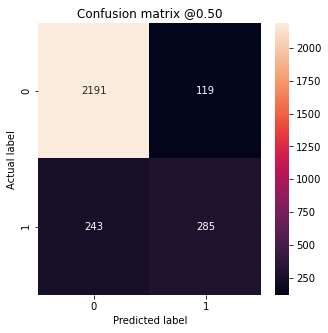

In [1043]:
plot_cm(y_test, np.array(test_prob) > 0.5, 0.5)

We can clearly see from the above that this model miss-classifies almost half of the positive class, a flaw in the model performance that the accuracy score alone could not tell us due to the class imbalance. Fortunately enough, we can tune the model performance by controlling for the model classification threshold, let us first explore the a range of different classification thresholds. As we need to use smaller thresholds values to get higher recalls (which is assumed to be of more interest here), let us use the range [0.1, 0.2, 0.3, 0.4]

--------------------------Threshold:        0.4--------------------------
Precision:       0.66
Recall:       0.58


No-disastor tweets correctly classified (True Negatives):  2153
No-disastor tweets Incorrectly classified as disastor tweets (False Positives):  157
True disastor tweets Missed (False Negatives):  220
True disastor tweets Detected (True Positives):  308
Total tweets:  528


--------------------------Threshold:        0.3--------------------------
Precision:       0.61
Recall:       0.64


No-disastor tweets correctly classified (True Negatives):  2096
No-disastor tweets Incorrectly classified as disastor tweets (False Positives):  214
True disastor tweets Missed (False Negatives):  192
True disastor tweets Detected (True Positives):  336
Total tweets:  528


--------------------------Threshold:        0.2--------------------------
Precision:       0.55
Recall:       0.68


No-disastor tweets correctly classified (True Negatives):  2019
No-disastor tweets Incorrectly clas

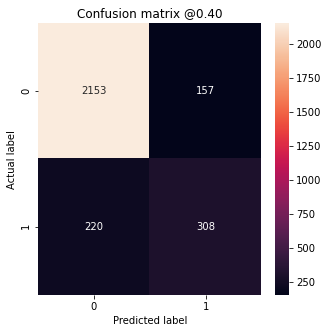

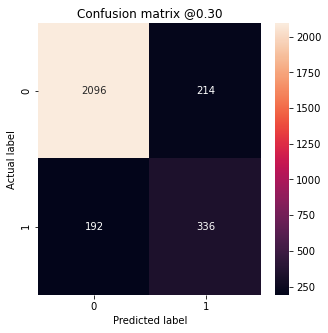

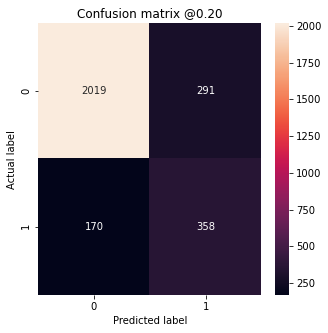

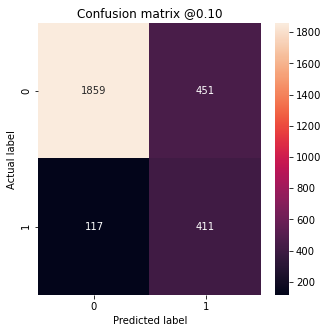

In [1044]:
# present the cm for a range of thresholds [0.1, 0.2, 0.3, 0.4]
for thereshold in np.arange(0.4, 0, -0.1):
    print(f'--------------------------Threshold: {"%10.1f" % thereshold}--------------------------' )
    plot_cm(y_test, np.array(test_prob) > thereshold, thereshold)
    print('\n')

Hmmm, clearly the model performance becomes different based on our own definition of what a good model is which is application-dependent. Are we more concerned with accurately classifying the True disaster tweets as much as possible with tolerance to the misclassification of the negative class? In which case we try to focus more on using thresholds that yield higher recall values. Or, we are only concerned with overall model accuracy for this application, in which case the accuracy measure will be enough for our application as a model evaluation metric.

Another way of looking at what we did above but for all thresholds (0 to 1), we can plot the ROC curves. [The ROC plot](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#plot_the_roc) is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.


In [1046]:
# helper function to plot the roc curve
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#plot_the_roc

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,100])
    plt.ylim([0,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

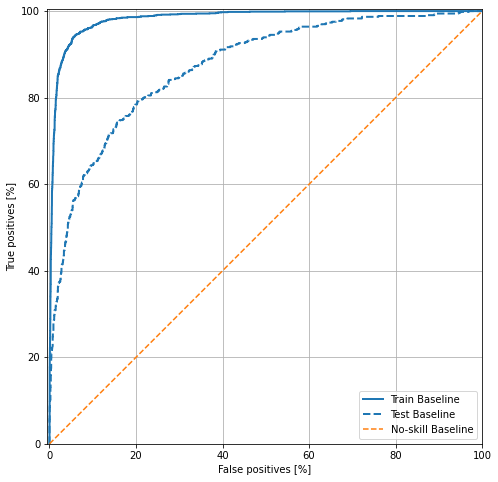

In [1047]:
# plot the roc curve
plt.figure(figsize = (8,8))
plot_roc("Train Baseline", y_train, np.array(train_prob), color=colors[0])
plot_roc("Test Baseline", y_test, np.array(test_prob), color=colors[0], linestyle='--')
plt.plot([0,100],[0,100], label="No-skill Baseline", color=colors[1], linestyle='--')
plt.legend(loc='lower right');

Comparing the test data curve (dashed) with the train data curve (solid) and how far these curves are from the flat no-skill line gives us inaccurate picture of our model performance as ROC curves should only be used with fairly balanced datasets which is not the case on this project. Instead, we need to us the Precision-Recall curves or what are referred to as AUPRC curves (Area under the interpolated precision-recall curve). We can obtain them by plotting (recall, precision) points for different values of the classification threshold.  

In [936]:
#https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#plot_the_roc
# helper function to plot the roc curve
from sklearn.metrics import precision_recall_curve
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [1050]:
# to calculate the prc for the no-skill line
ns_probs = [0 for _ in range(len(y_test))]

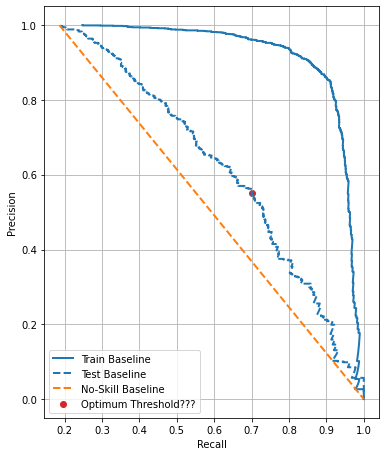

In [1048]:
# plot the roc curve
plt.figure(figsize = (6,14))
plot_prc("Train Baseline", y_train, np.array(train_prob), color=colors[0])
plot_prc("Test Baseline", y_test, np.array(test_prob), color=colors[0], linestyle='--')
plot_prc("No-Skill Baseline", y_test, np.array(ns_probs), color=colors[1], linestyle='--')
plt.scatter([0.7], [0.55], label="Optimum Threshold???", color=colors[3])
plt.legend(loc='lower left');

Ok, no this is a more realistic representation of the model performance. Here we see the model performance on using the test (hold out) data is not getting flatter and approaching the no-skill line. Again, the approach to chose the best classification threshold is application-dependent and may even be dynamic. But in general we may aim to chose a point where we balance between the two measures, probably with on the area of the highest separation between the test and no-skill curves. are we to chose the threshold yielding the points (Precision, Recall) = (~0.55, ~0.7) noted as Red in the plot?

Some thoughts here, there are some other steps that we could have employed to refine our modeling. for instance:
- We could have oversampled out positive class to get at more performing models
- We could have used more efficient model evaluation metrics during gridSearchCV by defining metrics based on recall and precision

Now, as we did not persist the winning model in our previous steps, let us now use the winning model params to run the model again and save it as a pickle.

('******Best Parameters are:******', <p>
 {'model__activation': 'relu', <p>
  'model__epochs': 15,  <p>
  'model__learning_rate': 0.00025, <p>
  'model__neurons_1': 12, <p>
  'model__neurons_2': 12, <p> 
  'model__rate': 0.4, <p> 
  'vec_pipe': CountVectorizer(min_df=0.0005, stop_words='english'), <p> 
  'vec_pipe__min_df': 0.0005, <p> 
  'vec_pipe__ngram_range': (1, 1)}, <p>
 '******Best Estimator is:******', <p>
 Pipeline(steps=[('vec_pipe',  <p>
                  CountVectorizer(min_df=0.0005, stop_words='english')),  <p>
                 ('to_dense',  <p>
                  <__main__.DenseTransformer object at 0x000002A8E8848910>), <p> 
                 ('model', <p> 
                  <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002A8E8B9E5E0>)]))

In [25]:
# prepare the data
# Fitting and transforming our X data using the bag of words for our initial model
transformer  = CountVectorizer(stop_words='english', ngram_range = (1,1), min_df = 0.0005).fit(X_train)
X_train_transformed_dense = transformer.transform(X_train).todense()

In [26]:
if run_model_2 == True:
    # Define the merics
    METRICS = [
          keras.metrics.TruePositives(name='tp'),
          keras.metrics.FalsePositives(name='fp'),
          keras.metrics.TrueNegatives(name='tn'),
          keras.metrics.FalseNegatives(name='fn'), 
          keras.metrics.BinaryAccuracy(name='accuracy'),
          keras.metrics.Precision(name='precision'),
          keras.metrics.Recall(name='recall'),
          keras.metrics.AUC(name='auc'),
    ]


    # create model
    model = keras.Sequential()
    model.add(layers.Dense(12, activation='relu'))
    model.add(layers.Dropout(0.4)) # Set 25% drop out
    model.add(layers.Dense(12, activation='relu'))
    model.add(layers.Dropout(0.4)) # Set 20% drop out

    # Declare the output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.00025), 
                  metrics = METRICS)

In [27]:
if run_model_2 == True:

    # Fit model
    history = model.fit(X_train_transformed_dense,
                        y_train_reshaped, epochs=15, verbose=1, validation_split=0.25)

Epoch 1/15
200/200 [==============================] - 1s 7ms/step - loss: 0.6536 - tp: 69.0000 - fp: 372.0000 - tn: 4803.0000 - fn: 1140.0000 - accuracy: 0.7632 - precision: 0.1565 - recall: 0.0571 - auc: 0.5021 - val_loss: 0.6030 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1753.0000 - val_fn: 375.0000 - val_accuracy: 0.8238 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5800
Epoch 2/15
200/200 [==============================] - 0s 2ms/step - loss: 0.5544 - tp: 3.0000 - fp: 2.0000 - tn: 5173.0000 - fn: 1206.0000 - accuracy: 0.8108 - precision: 0.6000 - recall: 0.0025 - auc: 0.5661 - val_loss: 0.4850 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1753.0000 - val_fn: 375.0000 - val_accuracy: 0.8238 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7013
Epoch 3/15
200/200 [==============================] - 1s 3ms/step - loss: 0.4690 - tp: 0.0000e+00 - fp: 1.0000 - tn: 5174.0000 - fn: 1209.0000 - accuracy: 0.8105 - precision: 0.0000e+00 - rec

In [34]:
if run_model_2 == True:
    
    # Evaluate the network
    train_accuracy = history.history['accuracy'][-1]
    result = model.evaluate(transformer.transform(X_test).todense()
                            ,y_test, verbose=0)

    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {result[5]:.4f}") 

    # Generate predictions
    predictions = model.predict(transformer.transform(X_test).todense())

Train Accuracy: 0.9214
Test Accuracy: 0.8717


As we can see the Test accuracy score matches that of the best estimator test accuracy that we got earlier on when we did our gridSearchCV. This confirms - to a acceptable extent - that we have the best model possible.

Now let us persist this model so that we can use it in production. We need to remember that we also have to save the preprocessing step on our pickle too as every tweet has to undergo pre-processing first. For the sake of this exercise, we will consider the preprocessing step as the CountVectorizer and the transformation to dense only (the second will be applied inline).

In [36]:
# Save the model
import joblib
preprocessing_file = 'data/pickle/preprocessing.joblib'
joblib.dump(transformer, preprocessing_file) 

# Save model
model.save('data/pickle/model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: data/pickle/model\assets


The saved pre-processing and model pickles are used by a Streamlit web-based application to classify tweets.